In [1]:
%load_ext autoreload
%autoreload 2

In [68]:
import promonet
import ppgs
import os
from pathlib import Path
import torch
import torchaudio
import IPython.display as ipd
import pysodic
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import pyfoal

In [3]:
# audio_file = Path('0016-000784-100.wav')
# audio_file = Path('tomato-resampled.wav')
audio_file = Path('tomato_clean.wav')
model = 'w2v2fb-ppg'
# model = 'bottleneck-latents'
config_dir = promonet.ROOT_DIR / 'config' / 'ppgs-experiments'
ppgs_config_dir = config_dir / 'ppgs'
promonet_config_dir = config_dir / 'promonet'
assert ppgs_config_dir.exists()
assert promonet_config_dir.exists()
IPython.display.Audio(audio_file)

In [70]:
original_audio = ppgs.load.audio(audio_file)
alignment = pyfoal.from_text_and_audio(
    'I think that tomato sounds better',
    original_audio.squeeze(dim=0),
    ppgs.SAMPLE_RATE,
    aligner='p2fa'
)
for p in alignment.phonemes():
    p.phoneme = p.phoneme.lower()
list((str(p), p.start(), p.end()) for p in alignment[4])

[('t', 1.2496598639455778, 1.3294784580498862),
 ('ah', 1.3294784580498862, 1.3693877551020404),
 ('m', 1.3693877551020404, 1.4691609977324258),
 ('ey', 1.4691609977324258, 1.5689342403628115),
 ('t', 1.5689342403628115, 1.6088435374149657),
 ('ow', 1.6088435374149657, 1.7185941043083897)]

In [71]:
# Create original ppg file
ppg_file = Path(audio_file.parent / f'{audio_file.stem}-{model}.pt')
print(ppg_file)

command = 'python -m ppgs '
command += f'--sources {audio_file} '
command += f'--sinks {ppg_file} '
command += f'--config {ppgs_config_dir / (model + ".py")} '
command += f'--gpu 0'

print(command)

os.system(command)

ppg = torch.load(ppg_file)
ppg_threshold = 0.0
ppg[ppg < ppg_threshold] = 0
ppg = torch.log(ppg)
ppg = torch.softmax(ppg, dim=0).nan_to_num(0)
torch.save(ppg, ppg_file)

tomato_clean-w2v2fb-ppg.pt
python -m ppgs --sources tomato_clean.wav --sinks tomato_clean-w2v2fb-ppg.pt --config /repos/promonet/config/ppgs-experiments/ppgs/w2v2fb-ppg.py --gpu 0
preparing dataset metadata (operation may be slow)


processing w2v2fb for dataset <list of files>: 100%|██████████| 1/1 [00:02<00:00,  2.46s/it]


using transformer model


In [72]:
# similarity_matrix = torch.load('balanced_similarity.pt') ** (1/3)
similarity_matrix = torch.load('balanced_similarity.pt')

In [73]:
def norm(ppg):
    return torch.mm(similarity_matrix.T ** 1, ppg)
jsd = ppgs.evaluate.metrics.jensenShannonDivergence

In [64]:
output_dir = Path('reconstruction')

for i in range(0, 0):
    reconstruction_output_file = output_dir / f'{audio_file.stem}-reconstruction-{i:03d}.wav'
    command = 'python -m promonet '
    command += '--audio_files ' + str(audio_file) + ' '
    command += '--output_files ' + str(reconstruction_output_file) + ' '
    # command += '--pitch_files ' + str(pitch_file) + ' '
    command += f'--target_ppg_files {ppg_file} '
    command += f'--speaker_ids {16} '
    # command += f'--speaker_ids {0} '
    command += f'--config {ppgs_config_dir / (model + ".py")} {promonet_config_dir / (model + ".py")} '
    command += f'--checkpoint /repos/promonet/runs/{model}/generator-00250000.pt '
    command += f'--gpu 0'
    print(command)
    os.system(command)

    input_file = reconstruction_output_file
    output_file = output_dir / (Path(input_file).stem + '-ppg.pt')
    command = 'python -m ppgs '
    command += f'--sources {input_file} '
    command += f'--sinks {output_file} '
    command += f'--config {ppgs_config_dir / (model + ".py")} '
    command += f'--gpu 0'
    print(command)
    os.system(command)
IPython.display.Audio(reconstruction_output_file)

In [65]:
ppg_files = list(output_dir.glob('*.pt'))

distances = torch.full((len(ppg_files),), torch.inf)

for i, ppg_file in enumerate(sorted(ppg_files)):
    inferred_ppg = torch.load(ppg_file)
    distances[i] = jsd(norm(inferred_ppg), norm(ppg[..., :inferred_ppg.shape[-1]]))
print(distances)
print(distances.argmin(), distances.min())

reconstruction_inferred_ppg = torch.load(ppg_files[distances.argmin()])

tensor([45.0352, 29.5709, 29.9288, 35.1339, 30.6588, 27.4642, 31.4204, 29.9474,
        32.4401, 27.7660, 28.9291, 30.6273, 29.5700, 39.1025, 45.4370, 45.8590,
        50.3894, 45.6219, 44.9899, 45.2274, 42.9598, 50.6399, 47.0846, 44.1572,
        45.0325, 26.6845, 23.5126, 24.4672, 30.3971, 24.6699, 22.0870, 22.5394,
        23.1264, 28.6293, 26.3838, 22.8740, 29.2457, 24.4589, 21.1095, 23.6857,
        24.6605, 24.1348, 24.8059, 23.3784, 25.1302, 22.8508, 22.9307, 26.2099,
        27.8991, 28.1092, 36.1451, 31.9546, 31.3084, 30.2588, 34.6490, 41.6574,
        28.6712, 29.6994, 31.3896, 33.3468, 29.7533, 31.6093, 36.0689, 33.4312,
        31.6640, 31.8938, 32.2003, 33.5015, 30.1227, 31.9458, 41.7739, 31.2685,
        31.8532, 31.8267, 33.0713])
tensor(38) tensor(21.1095)


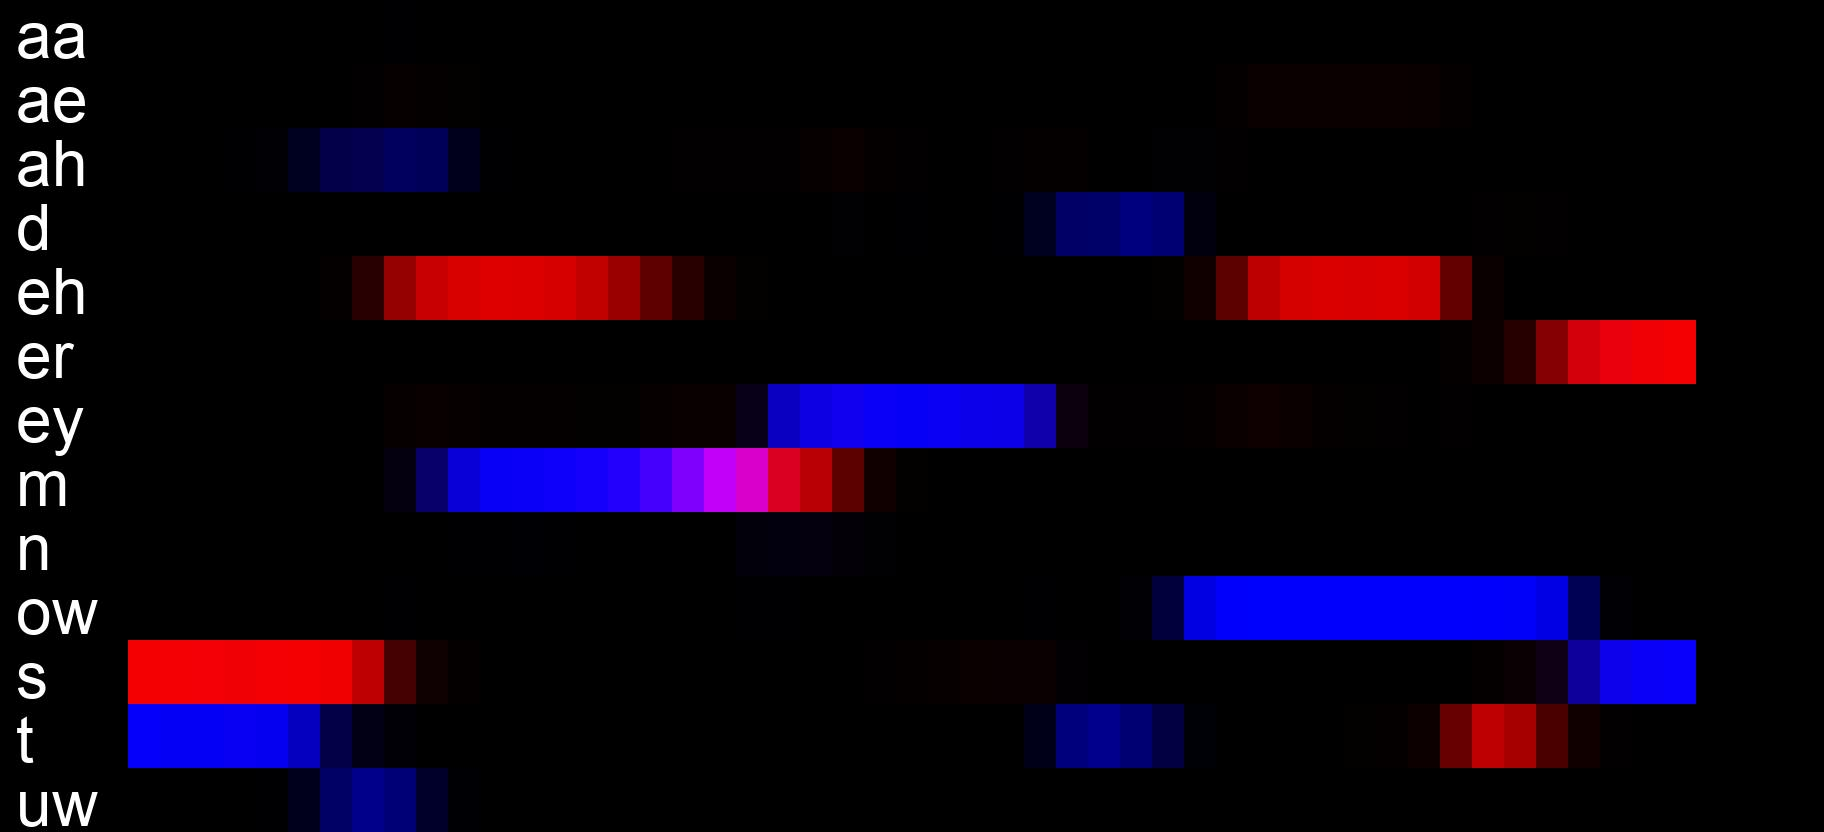

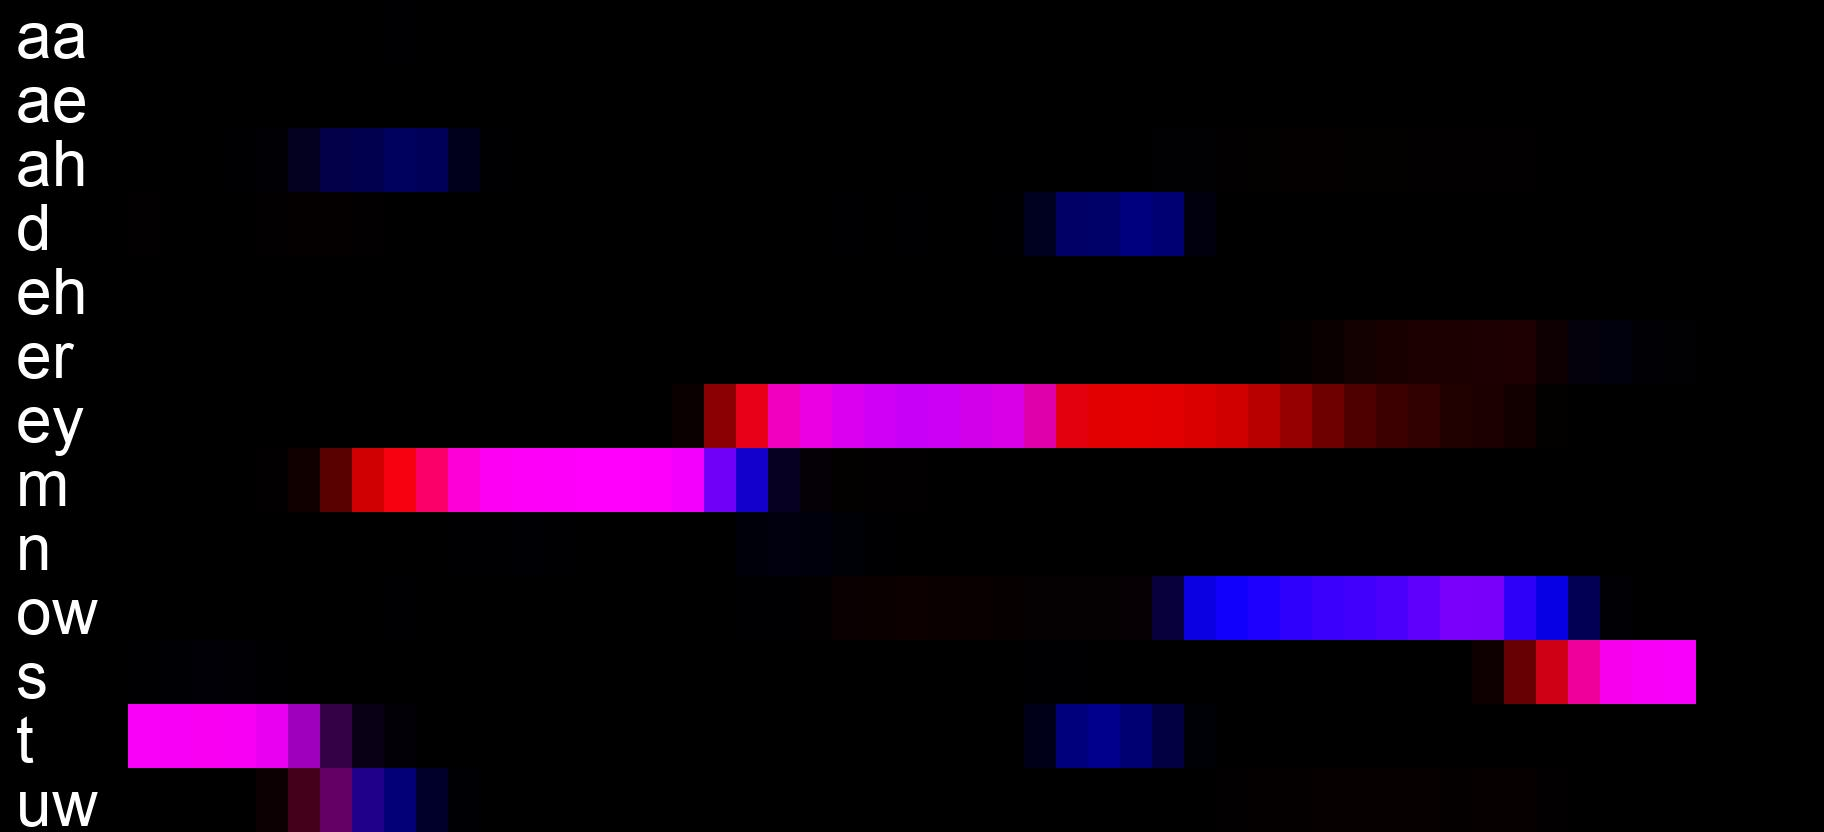

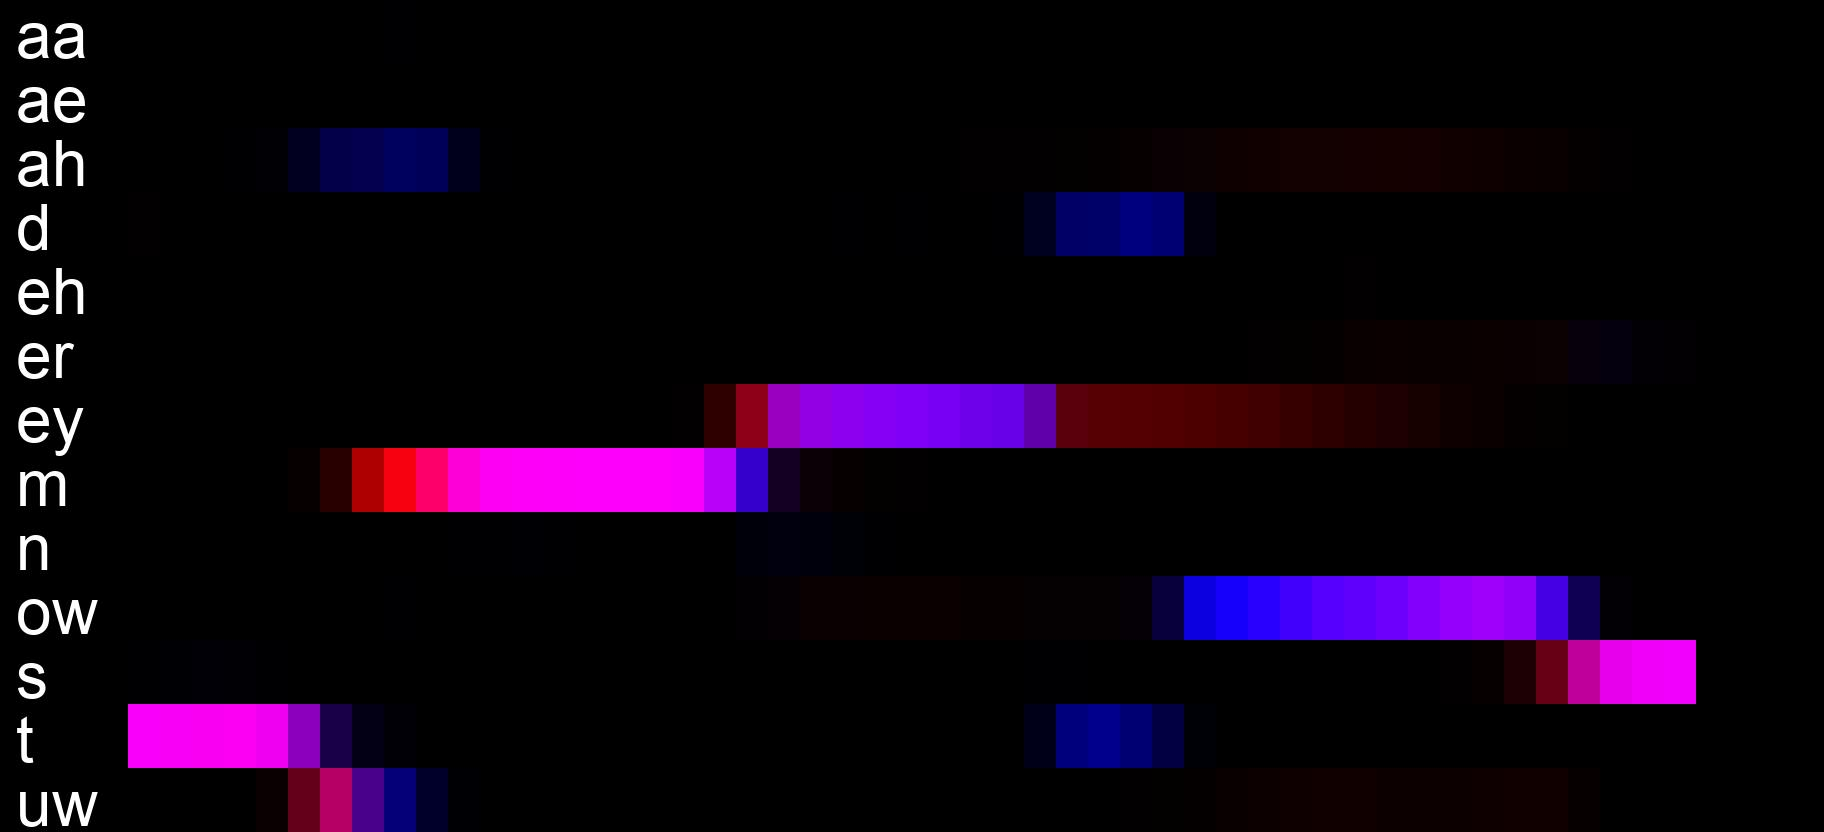

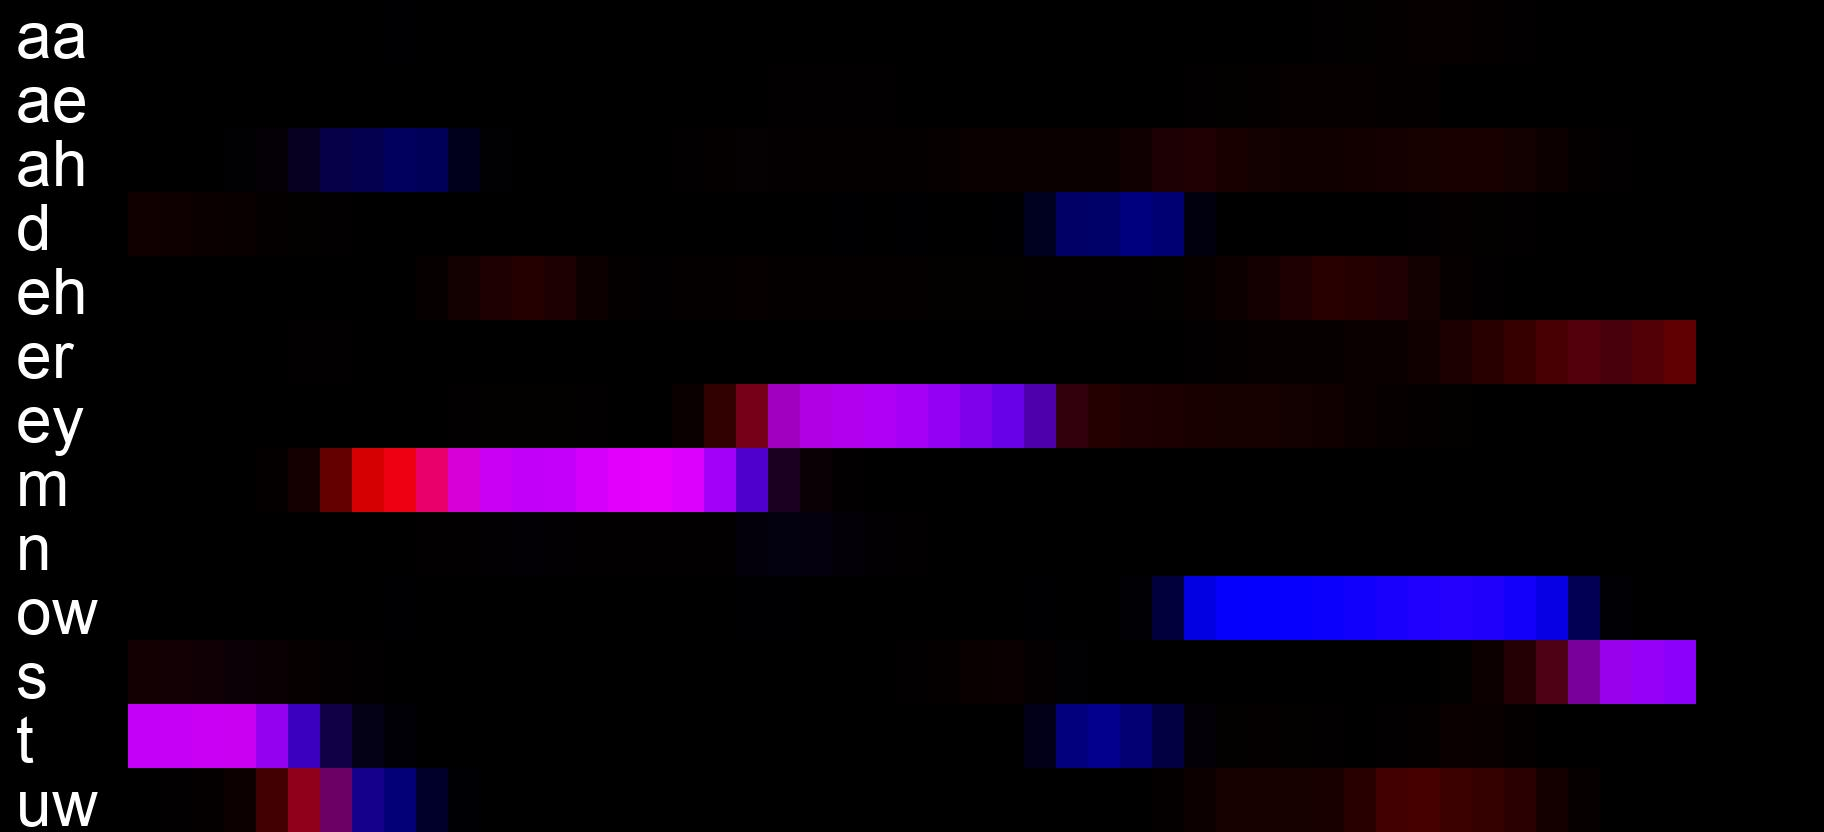

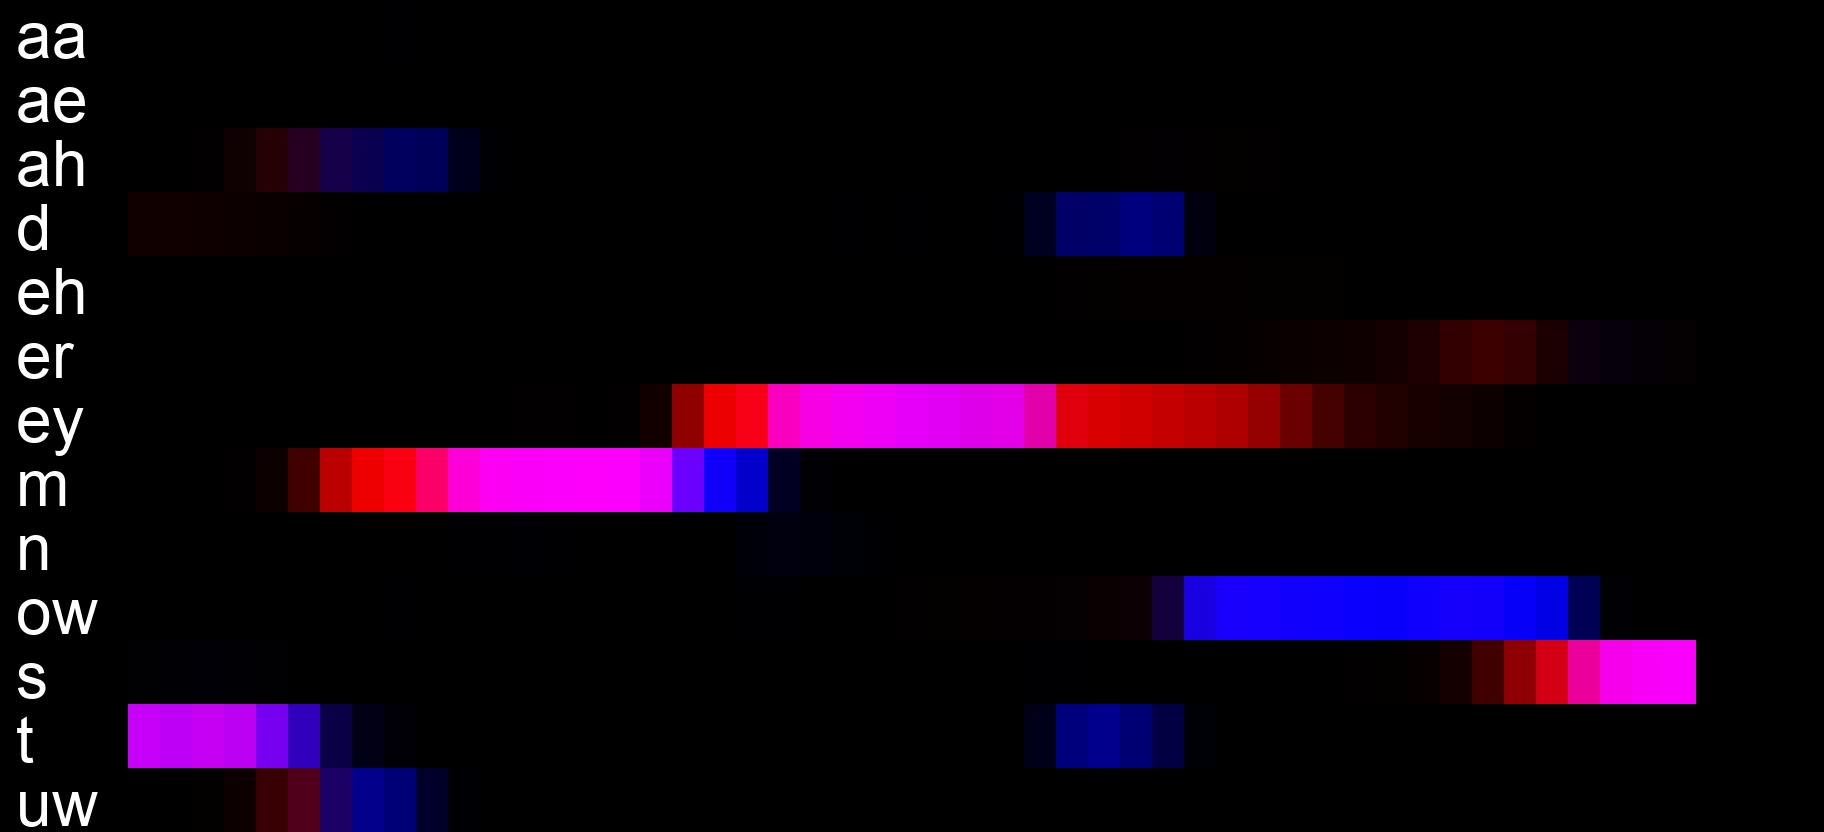

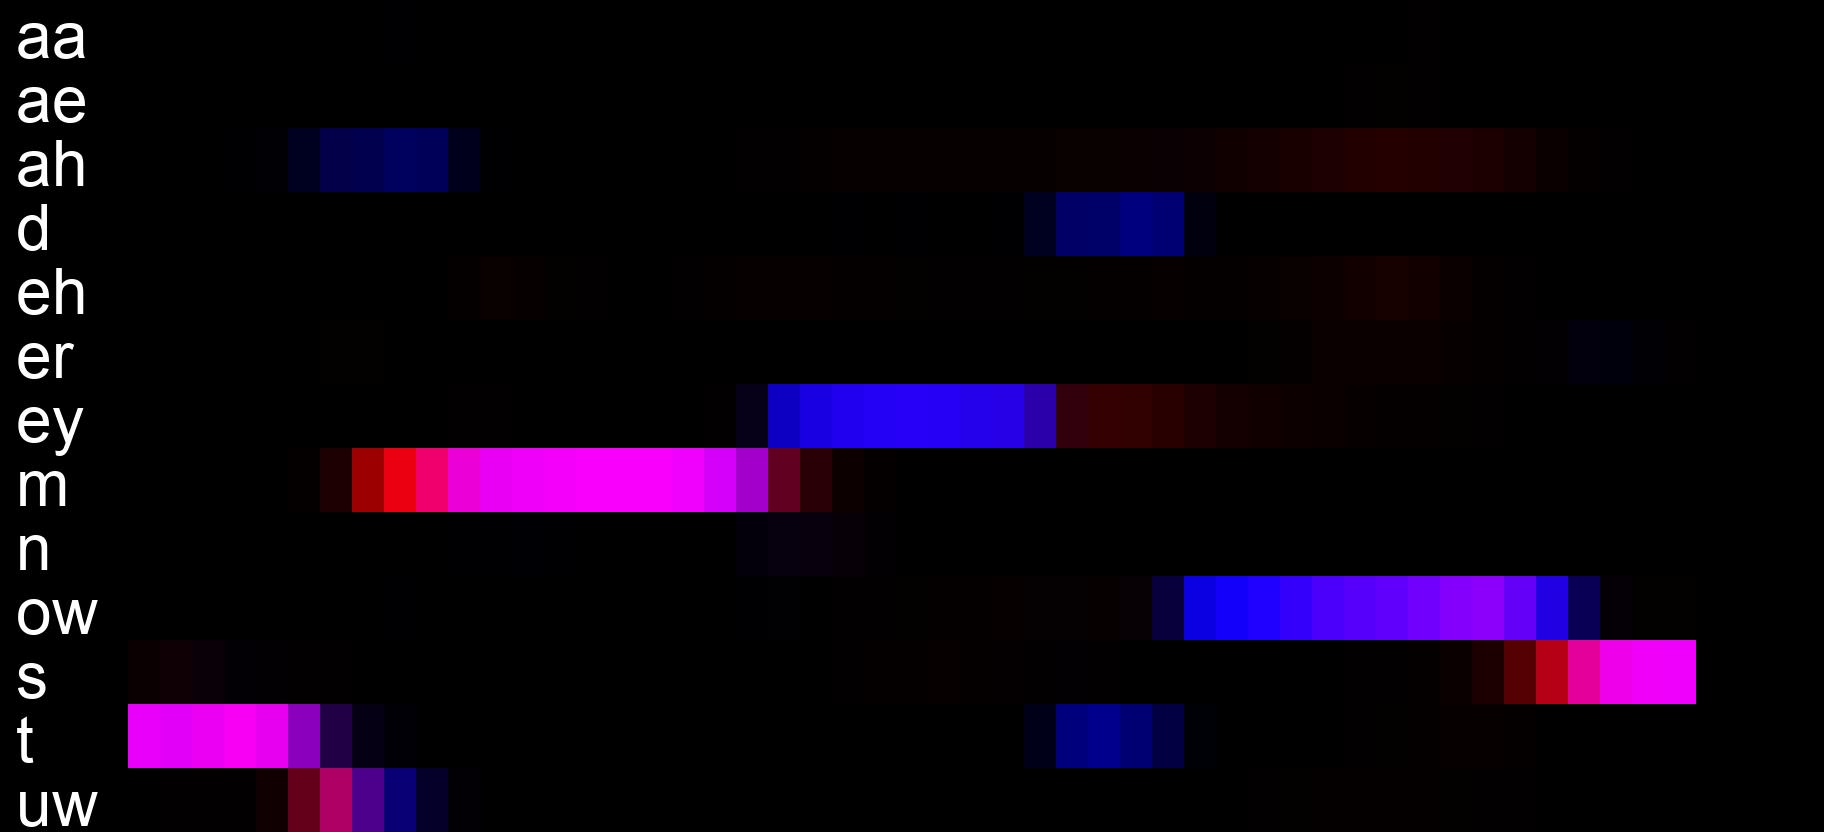

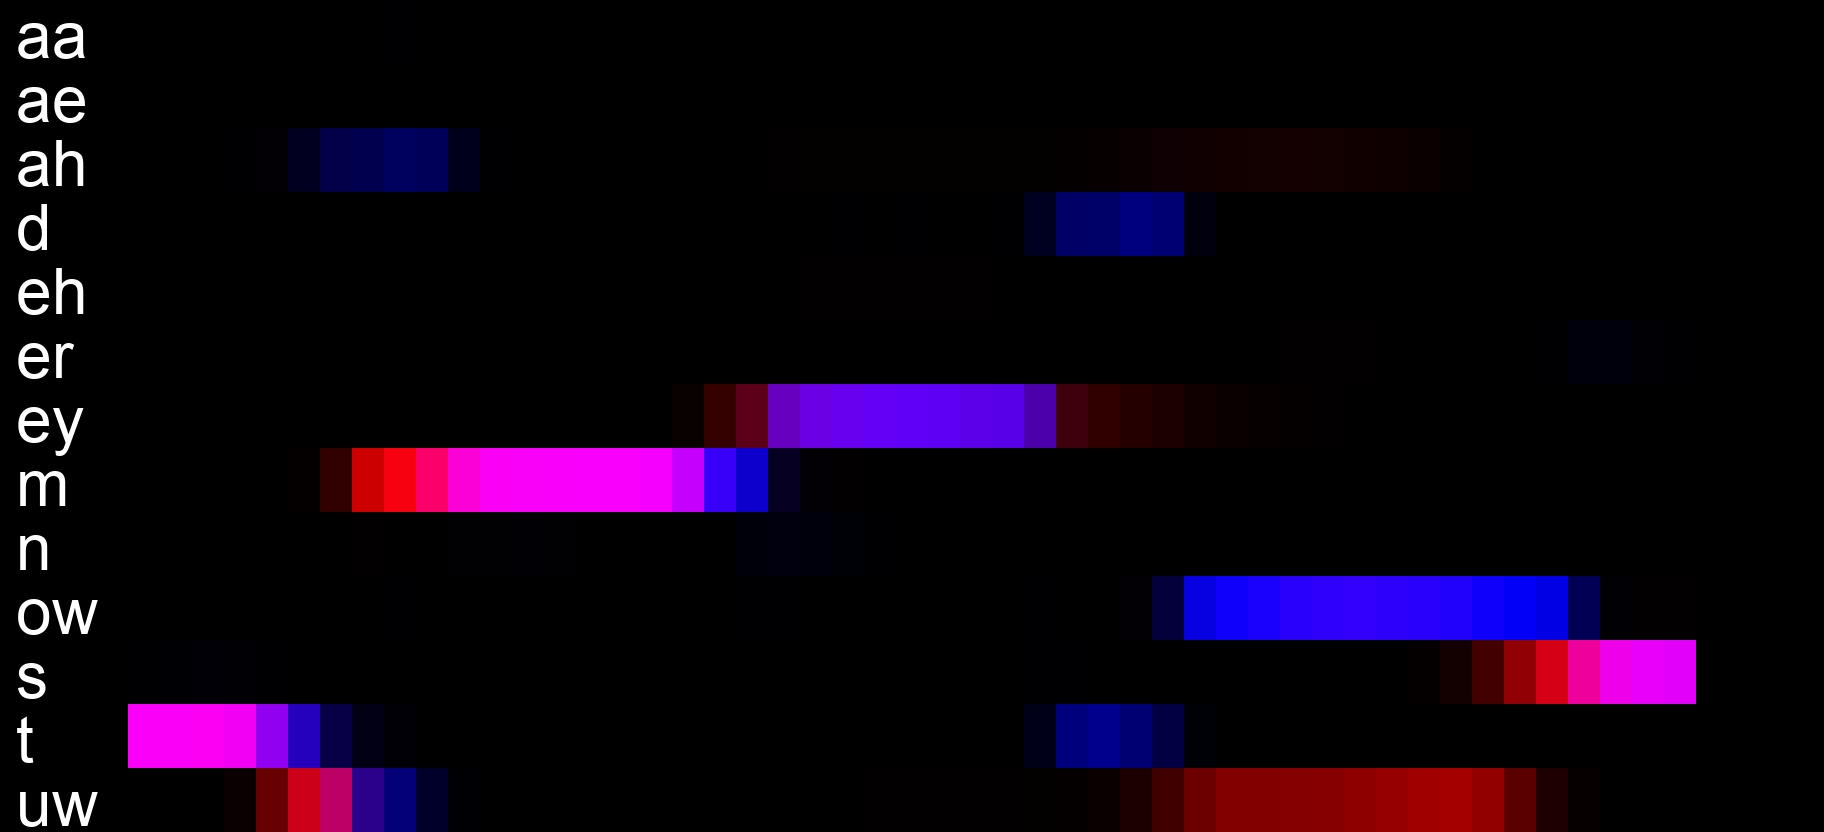

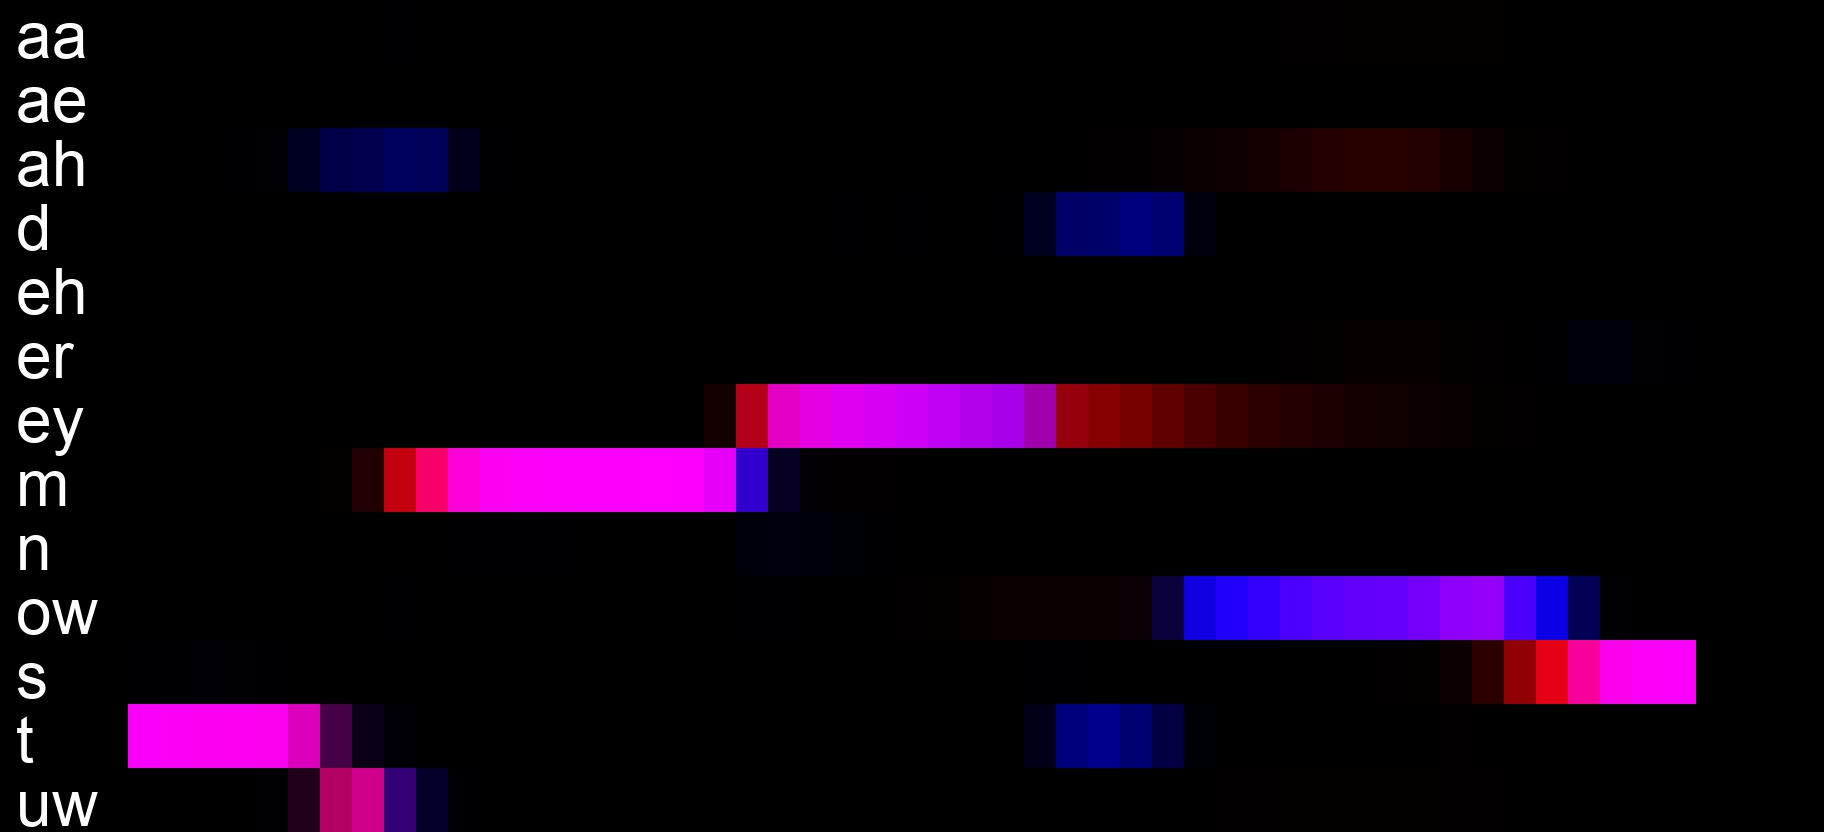

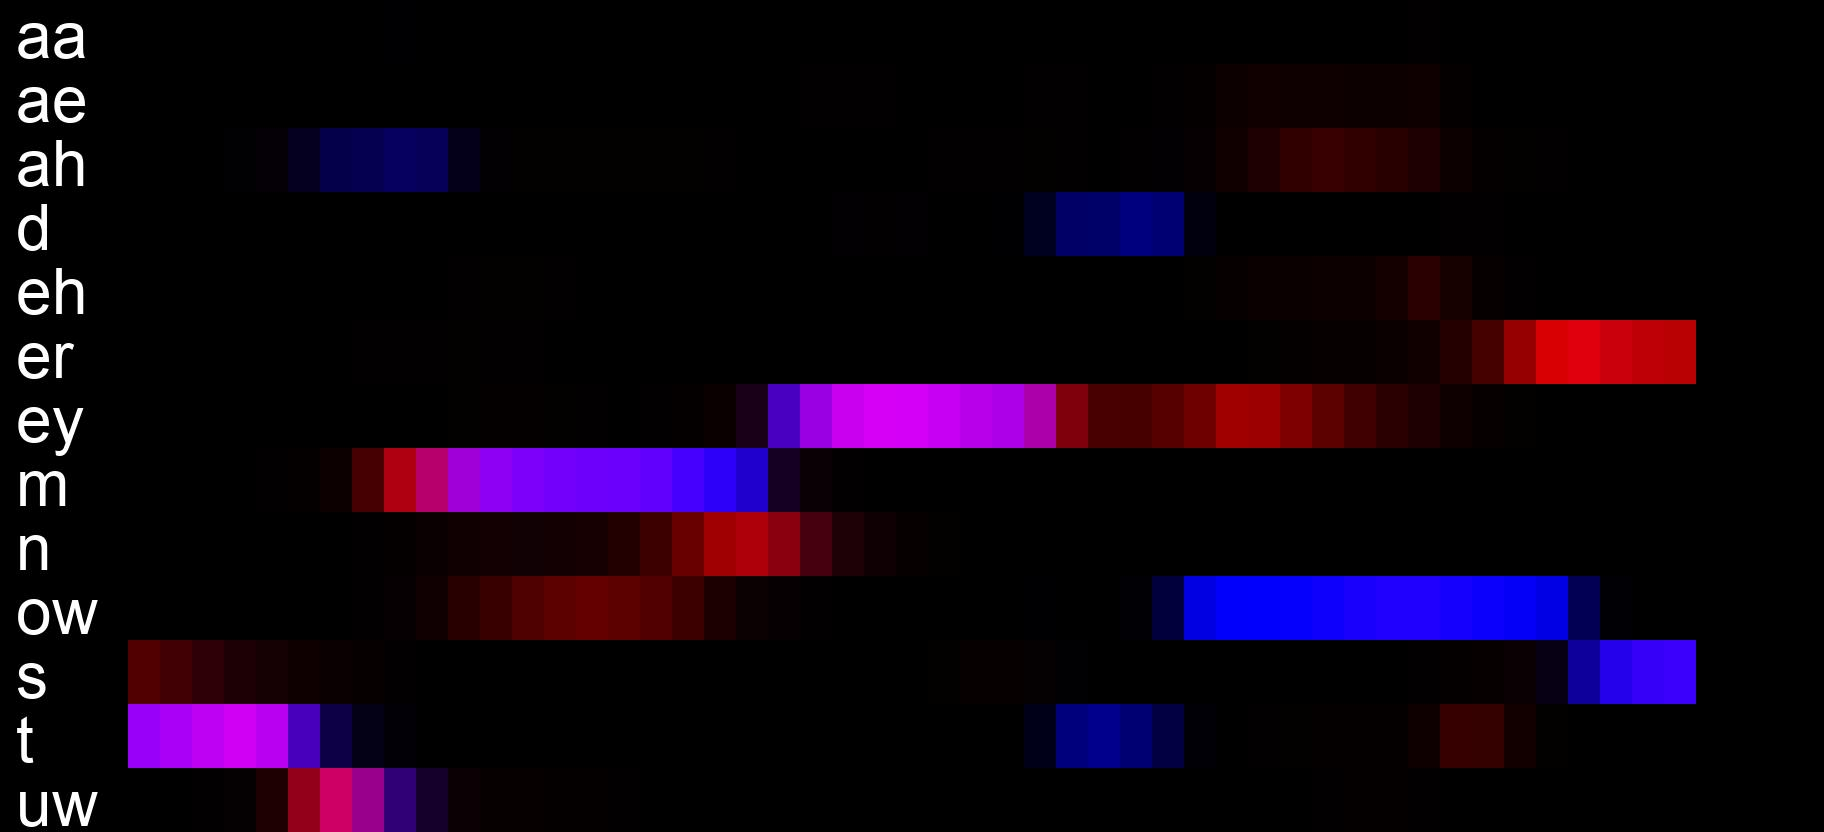

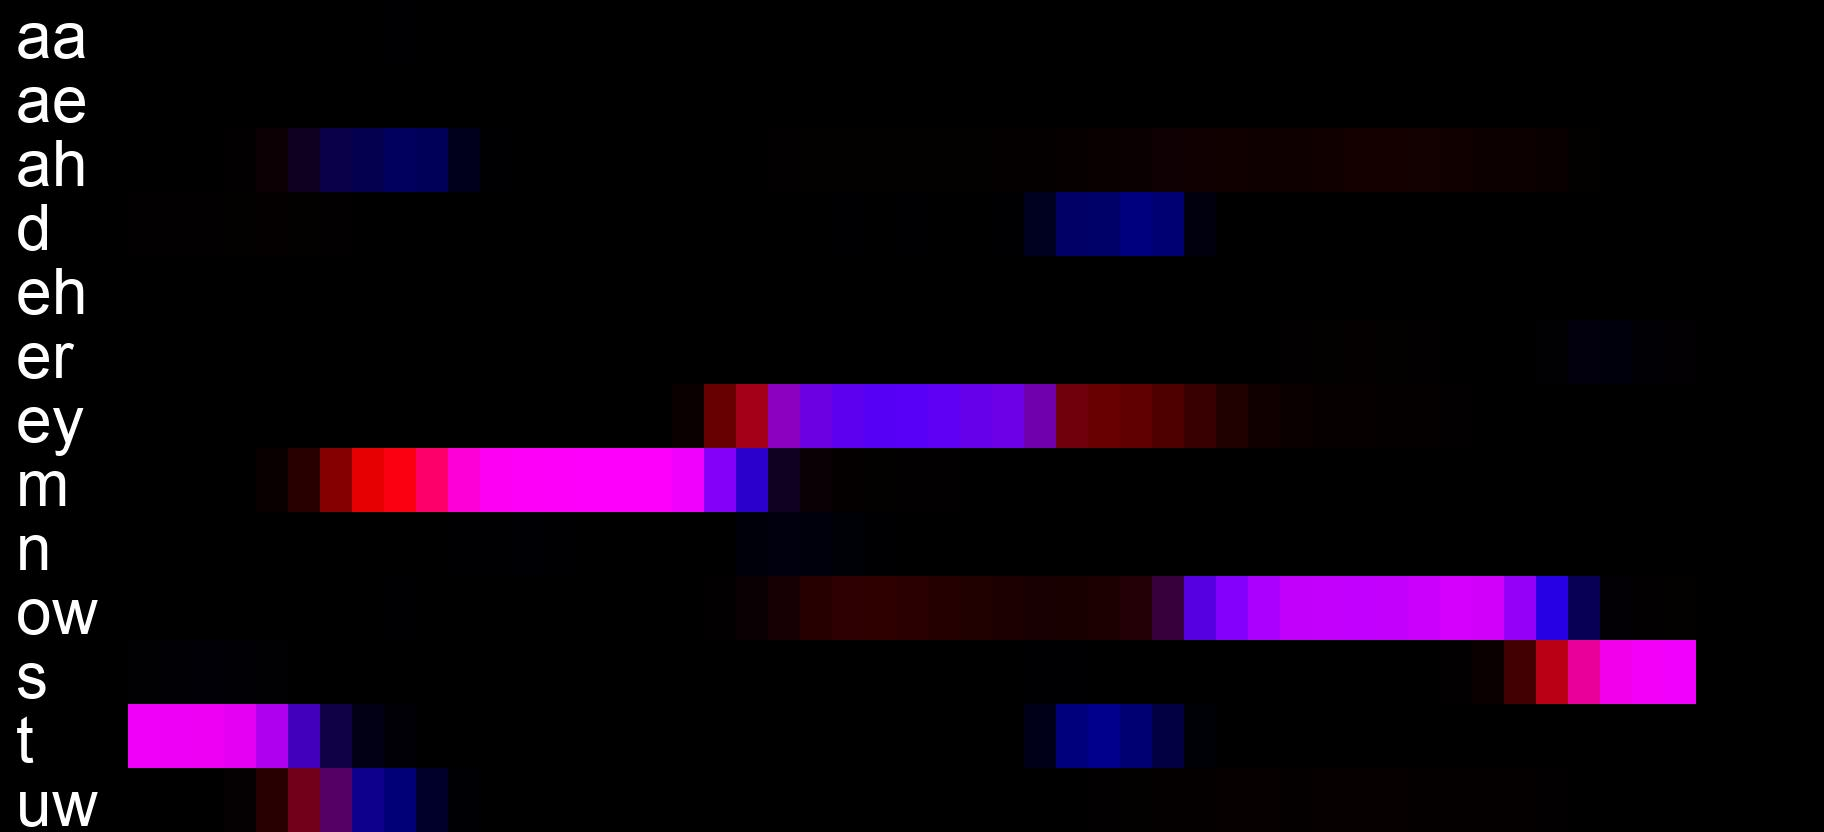

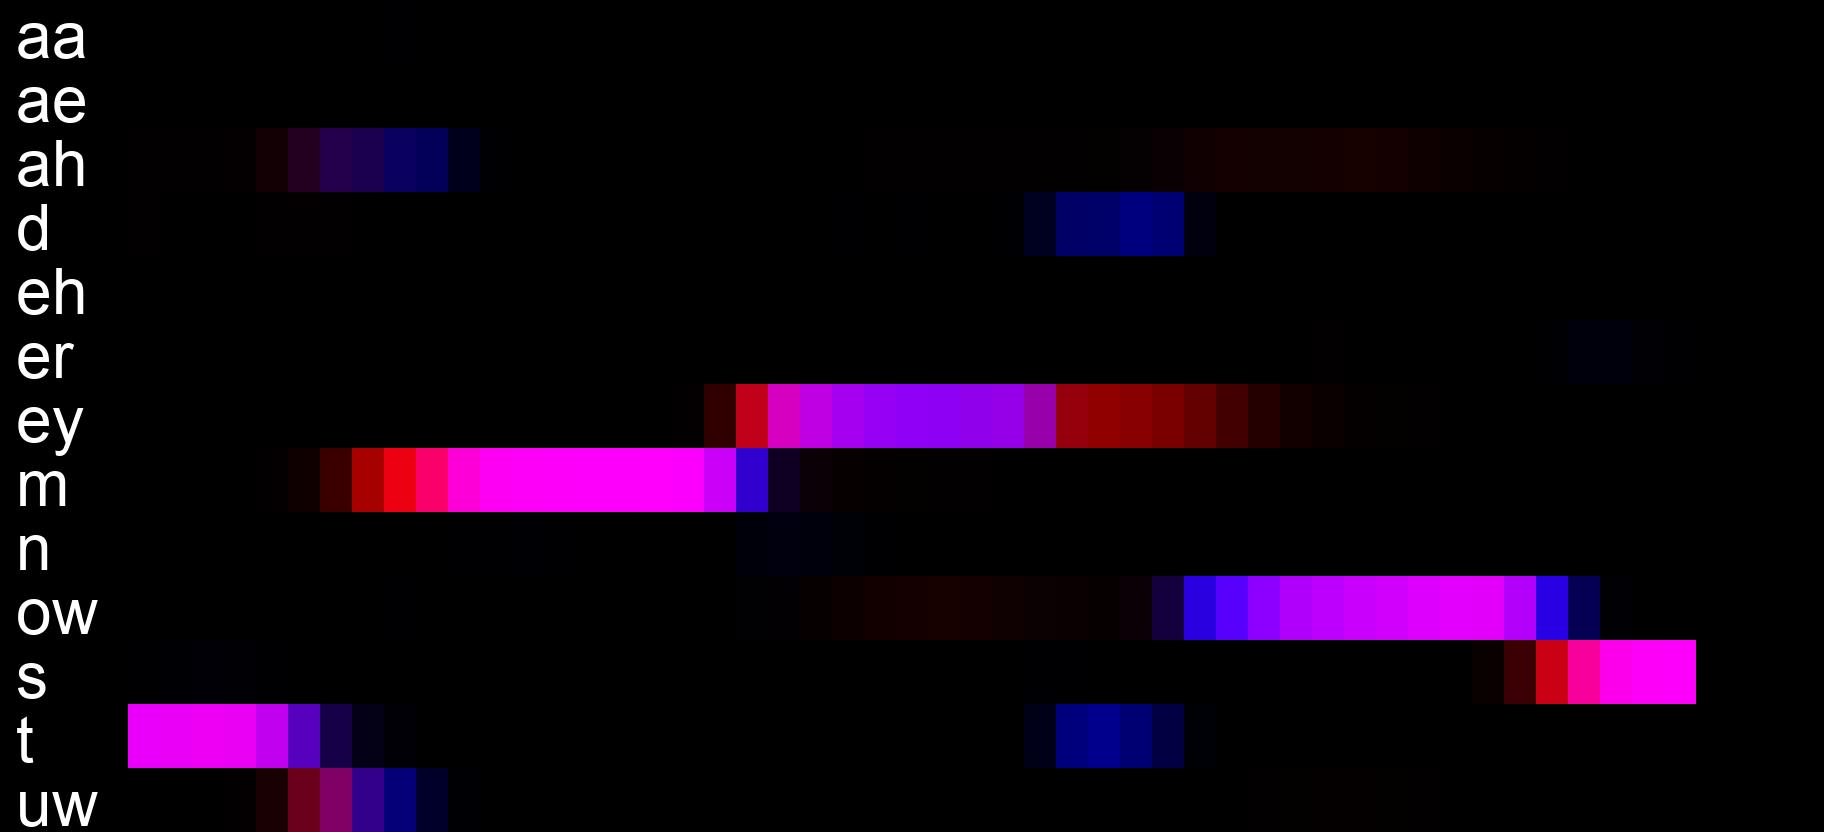

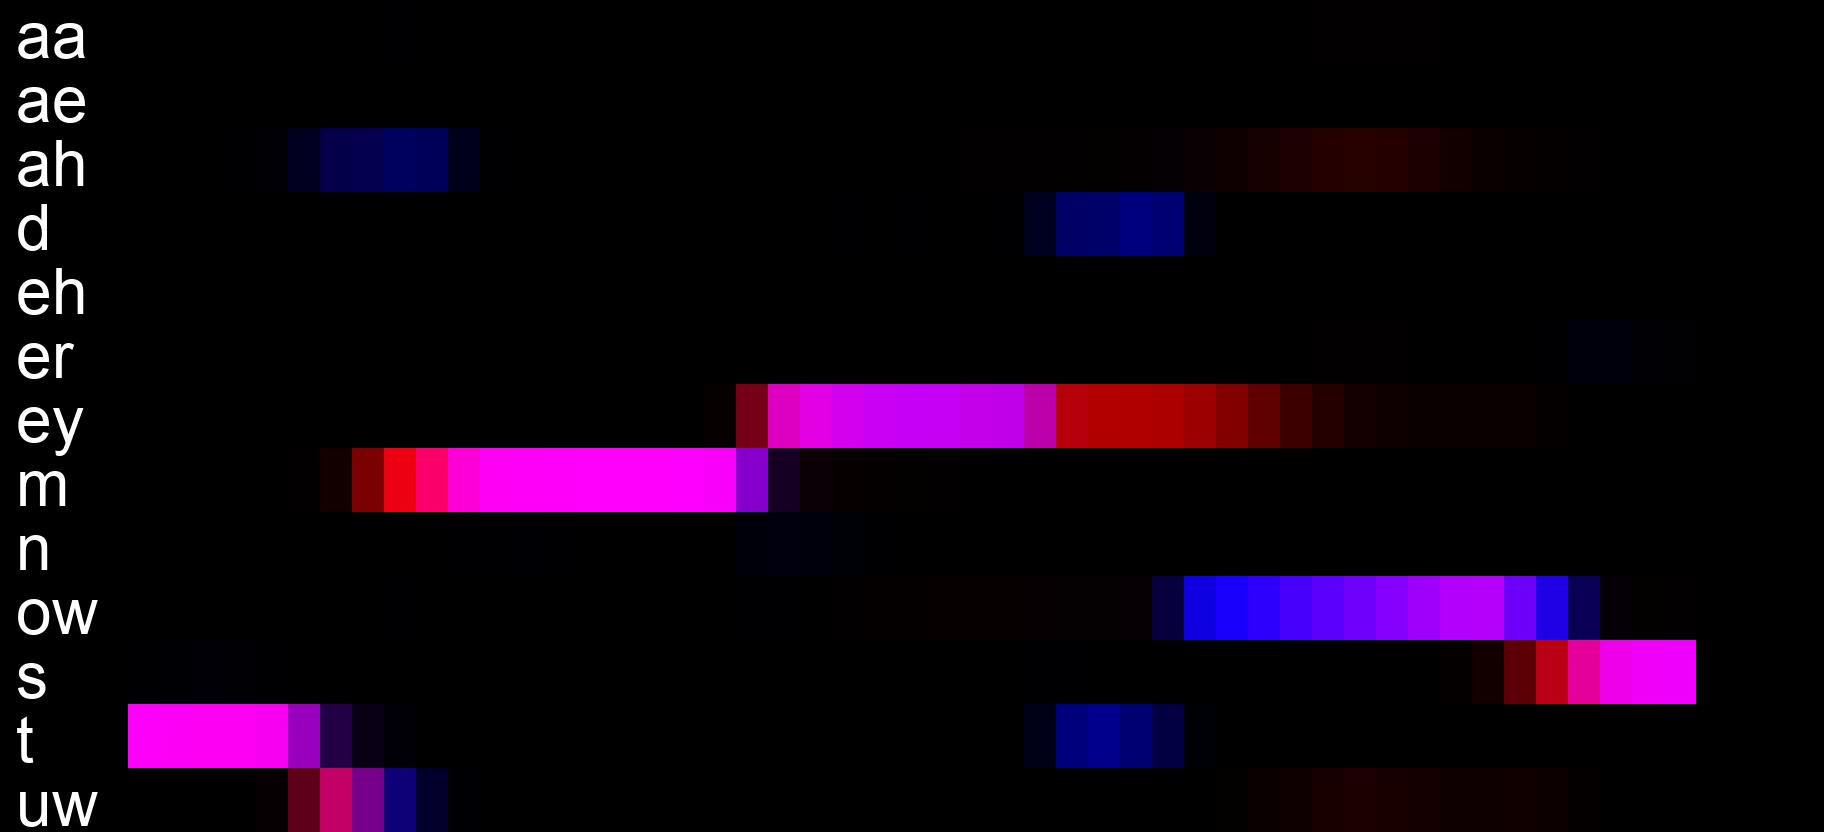

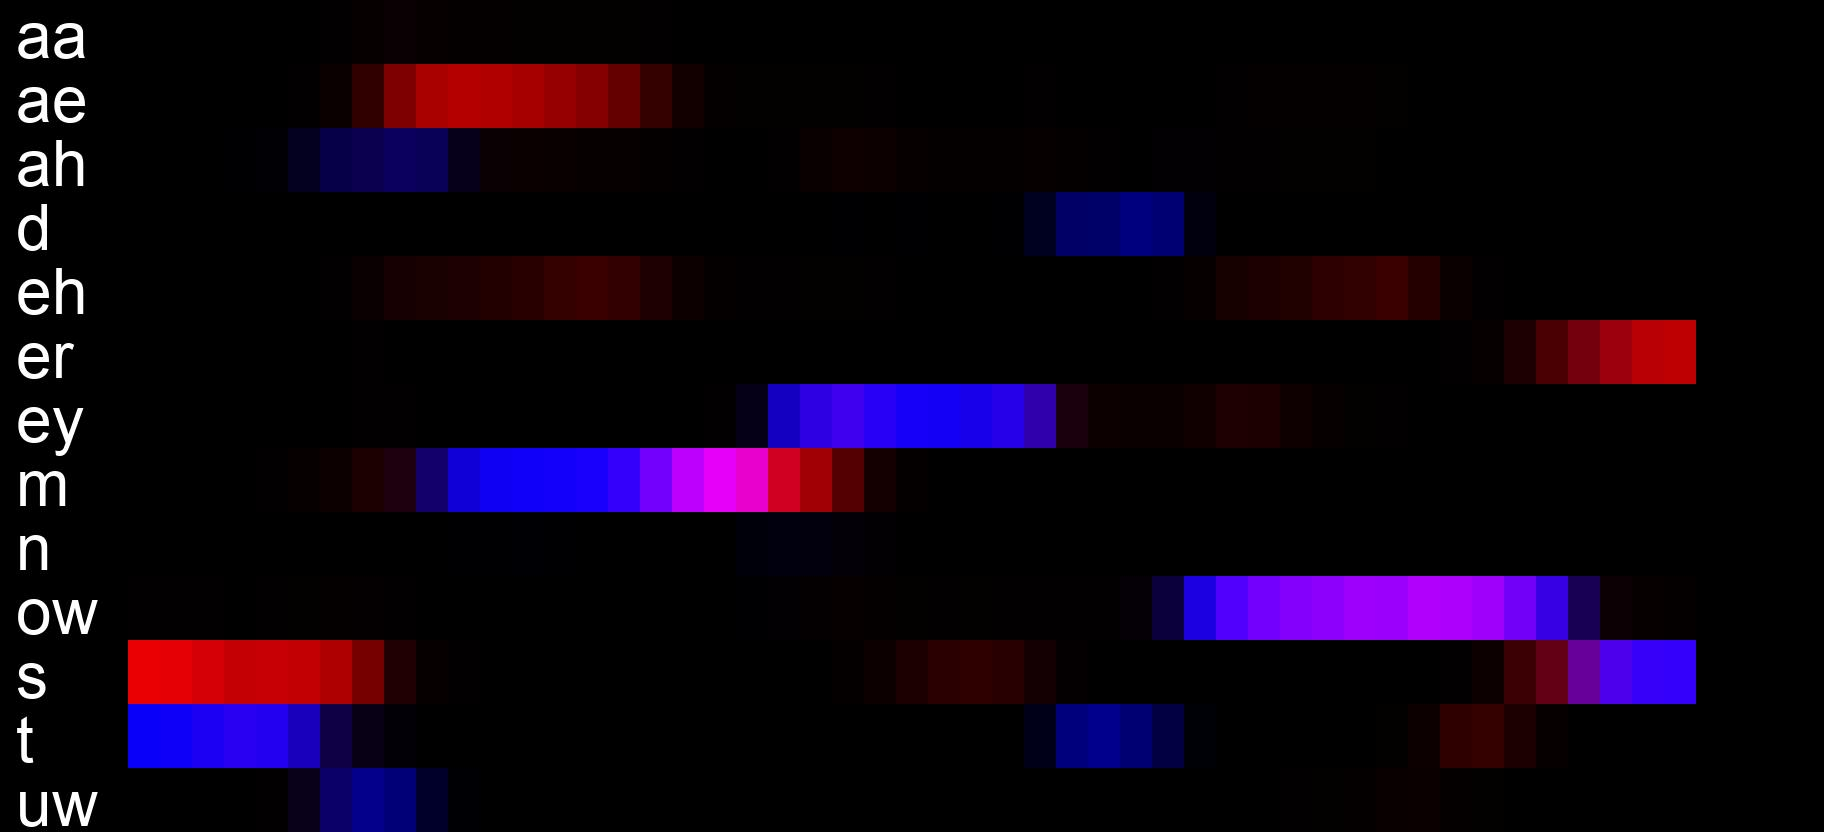

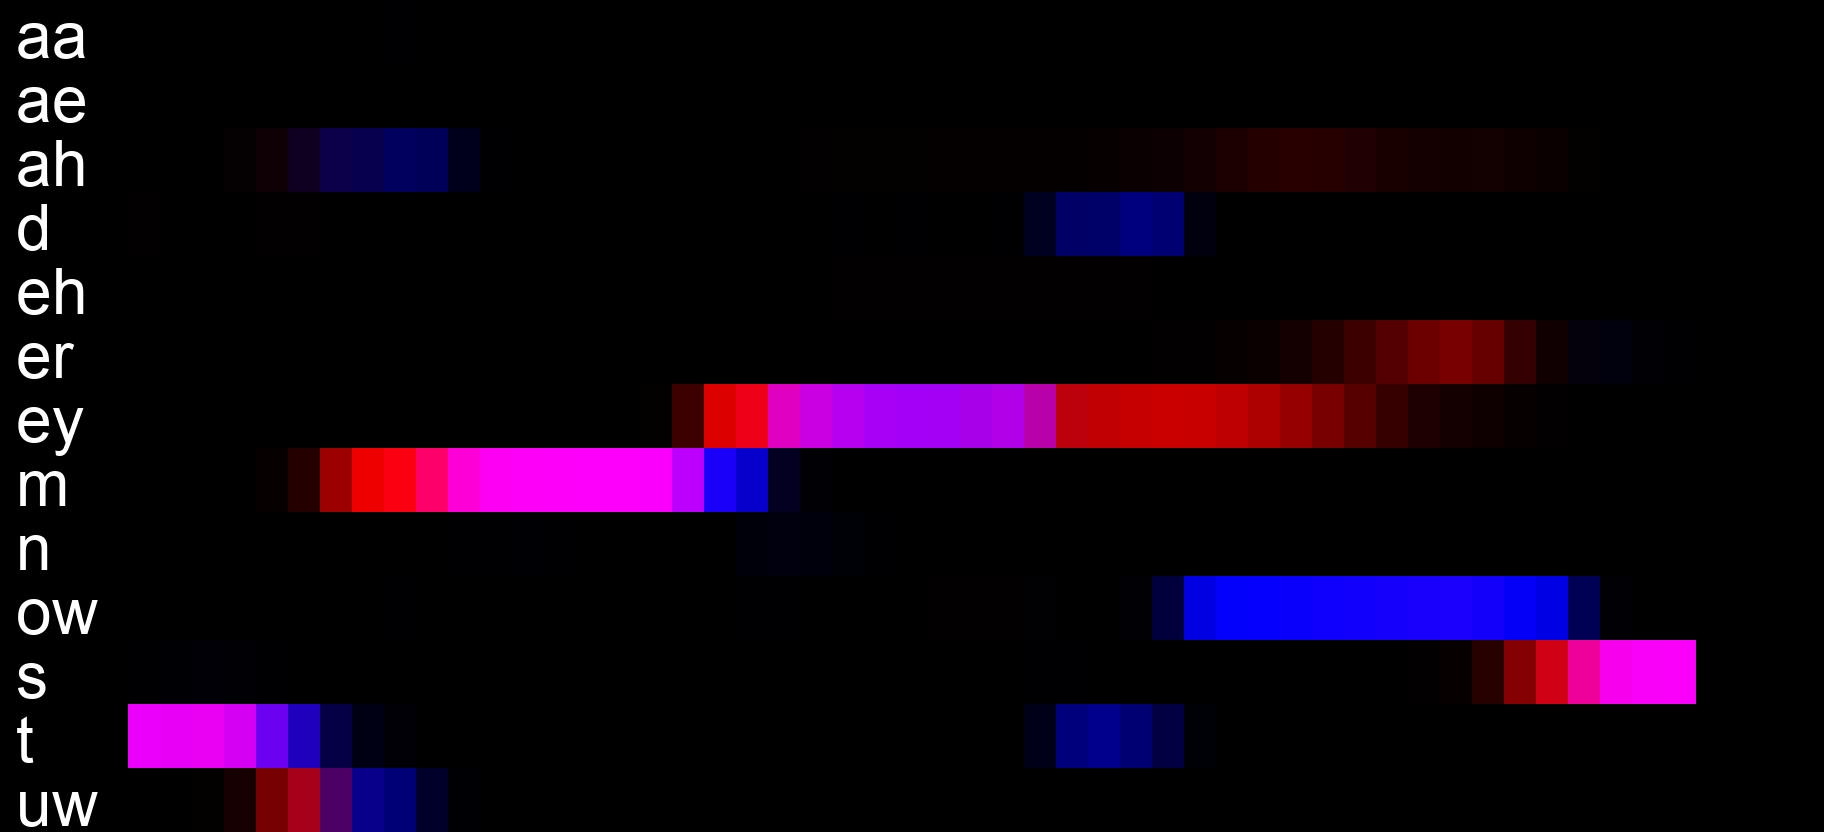

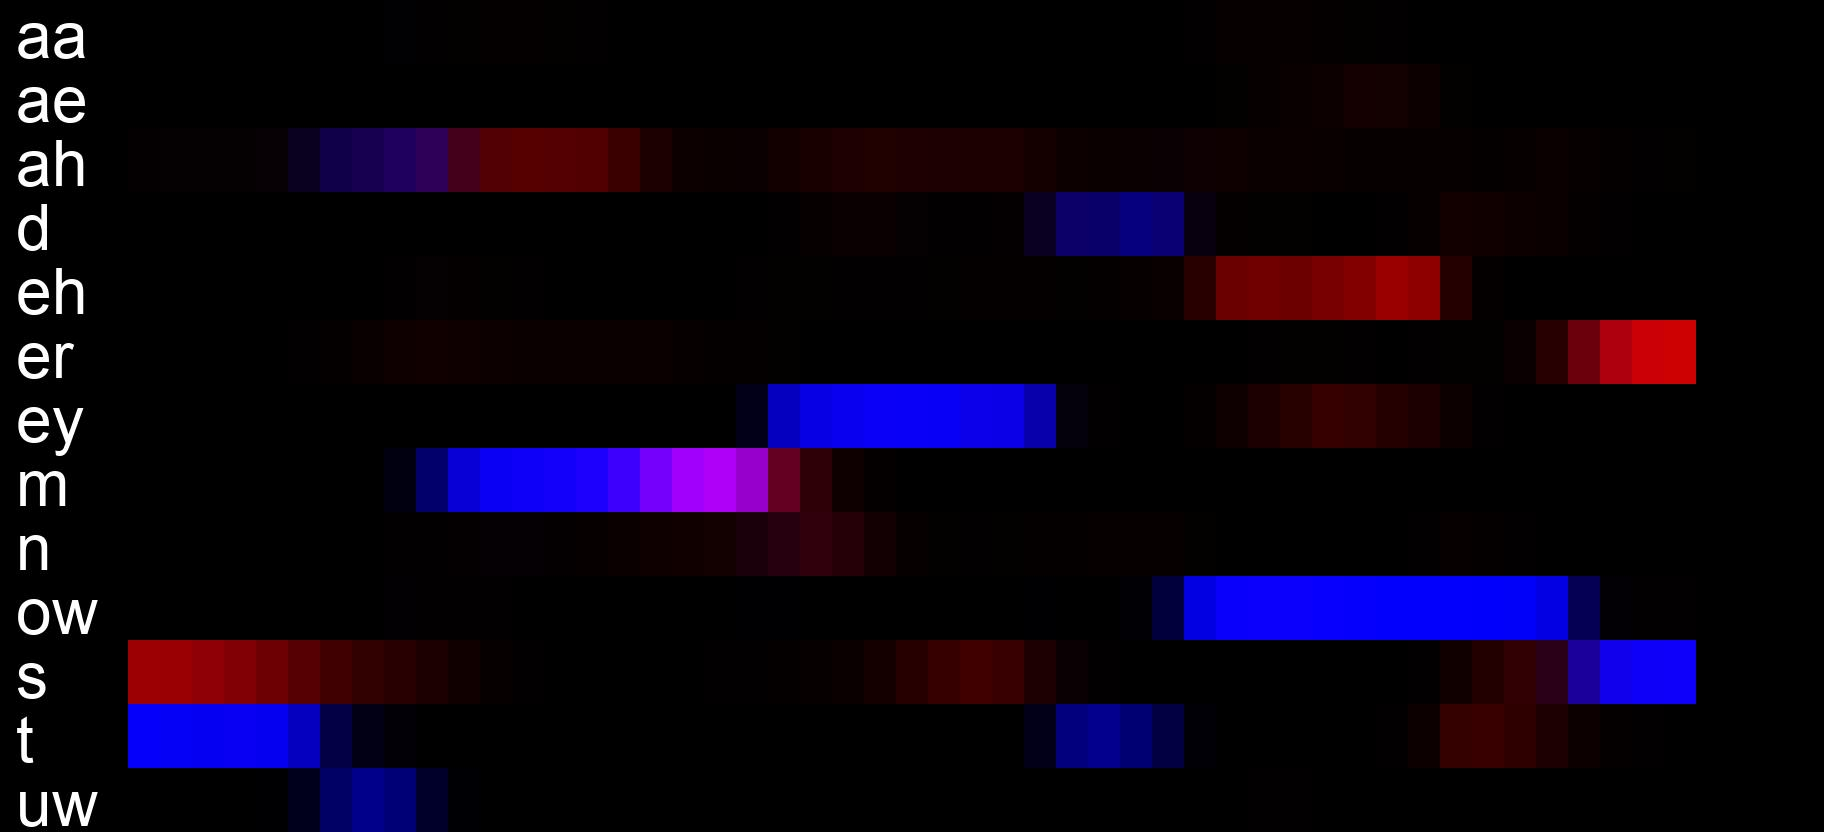

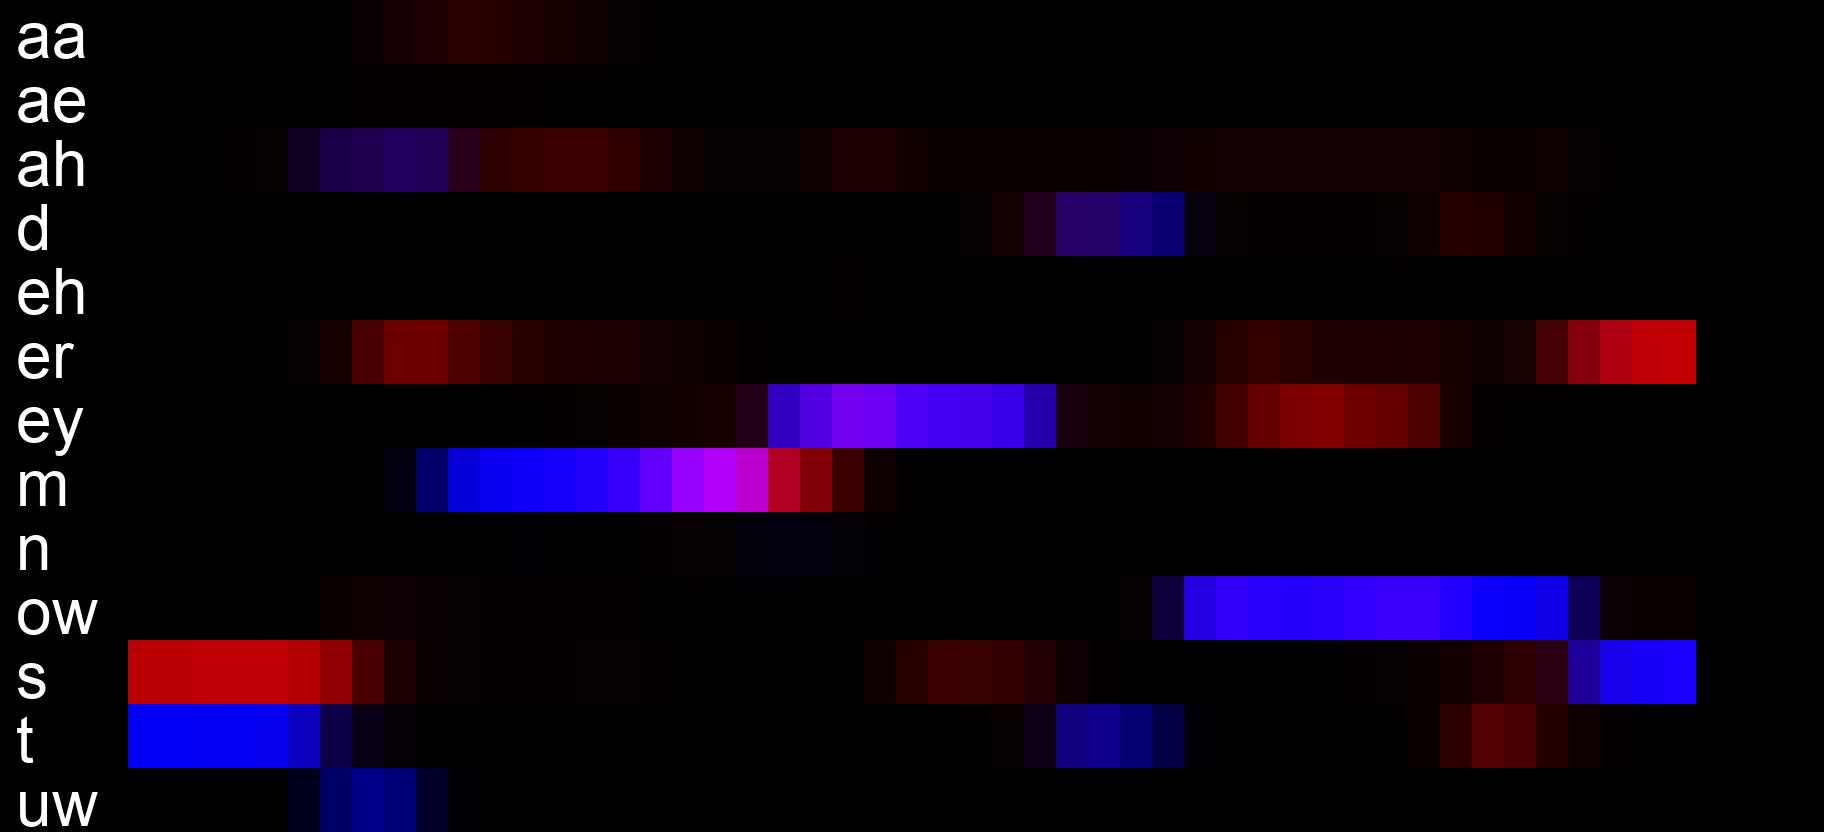

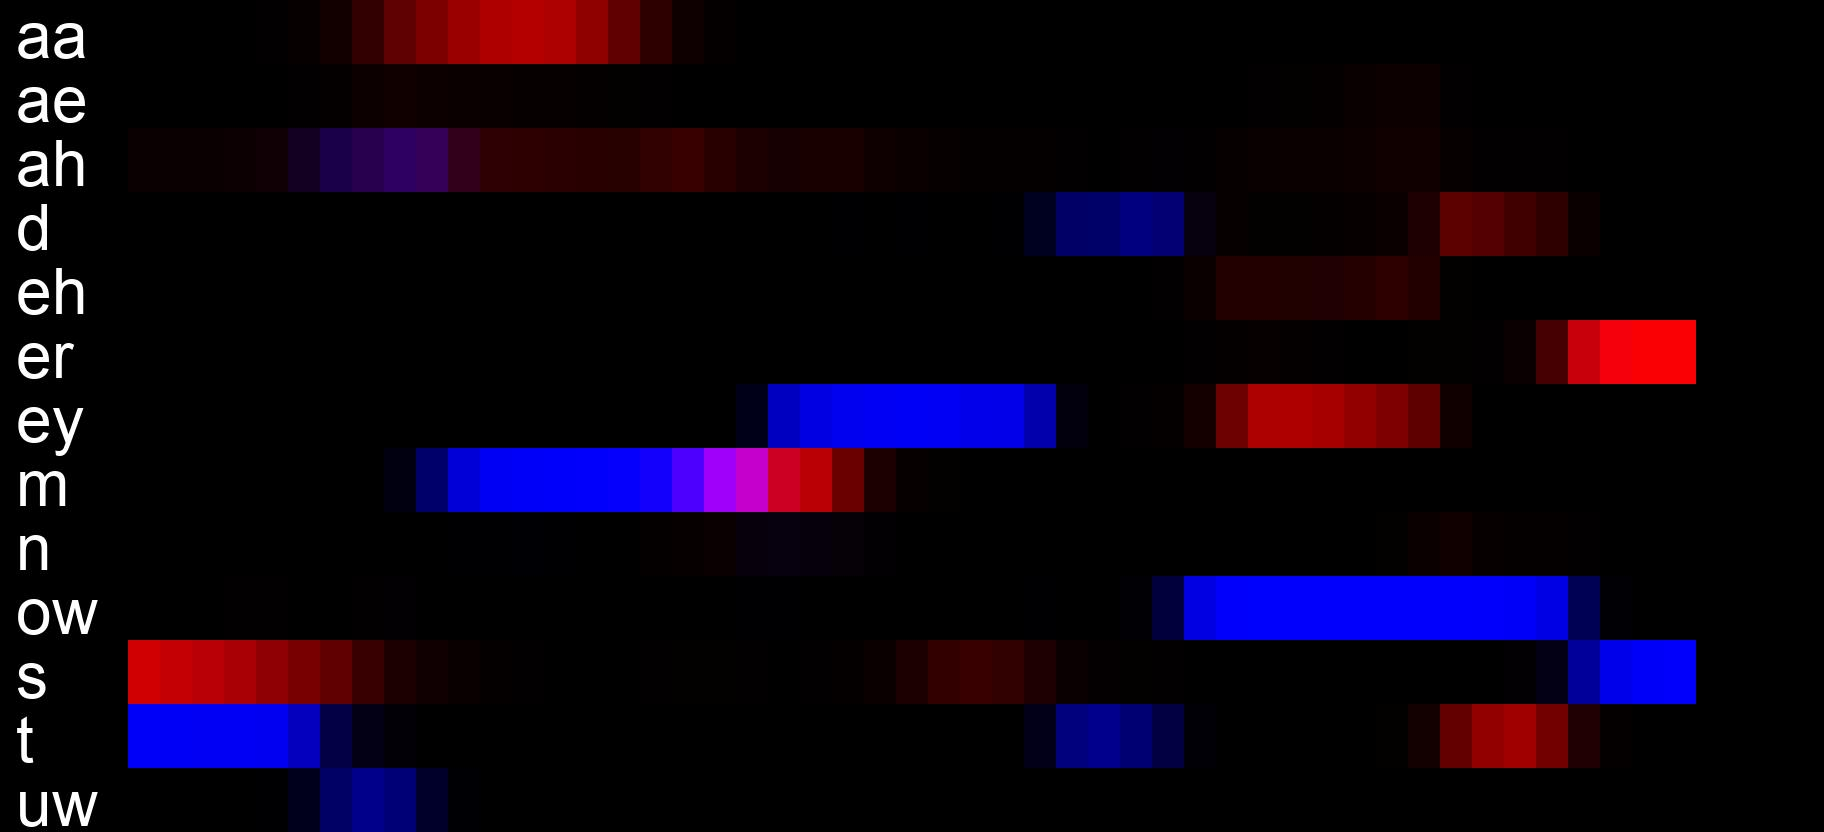

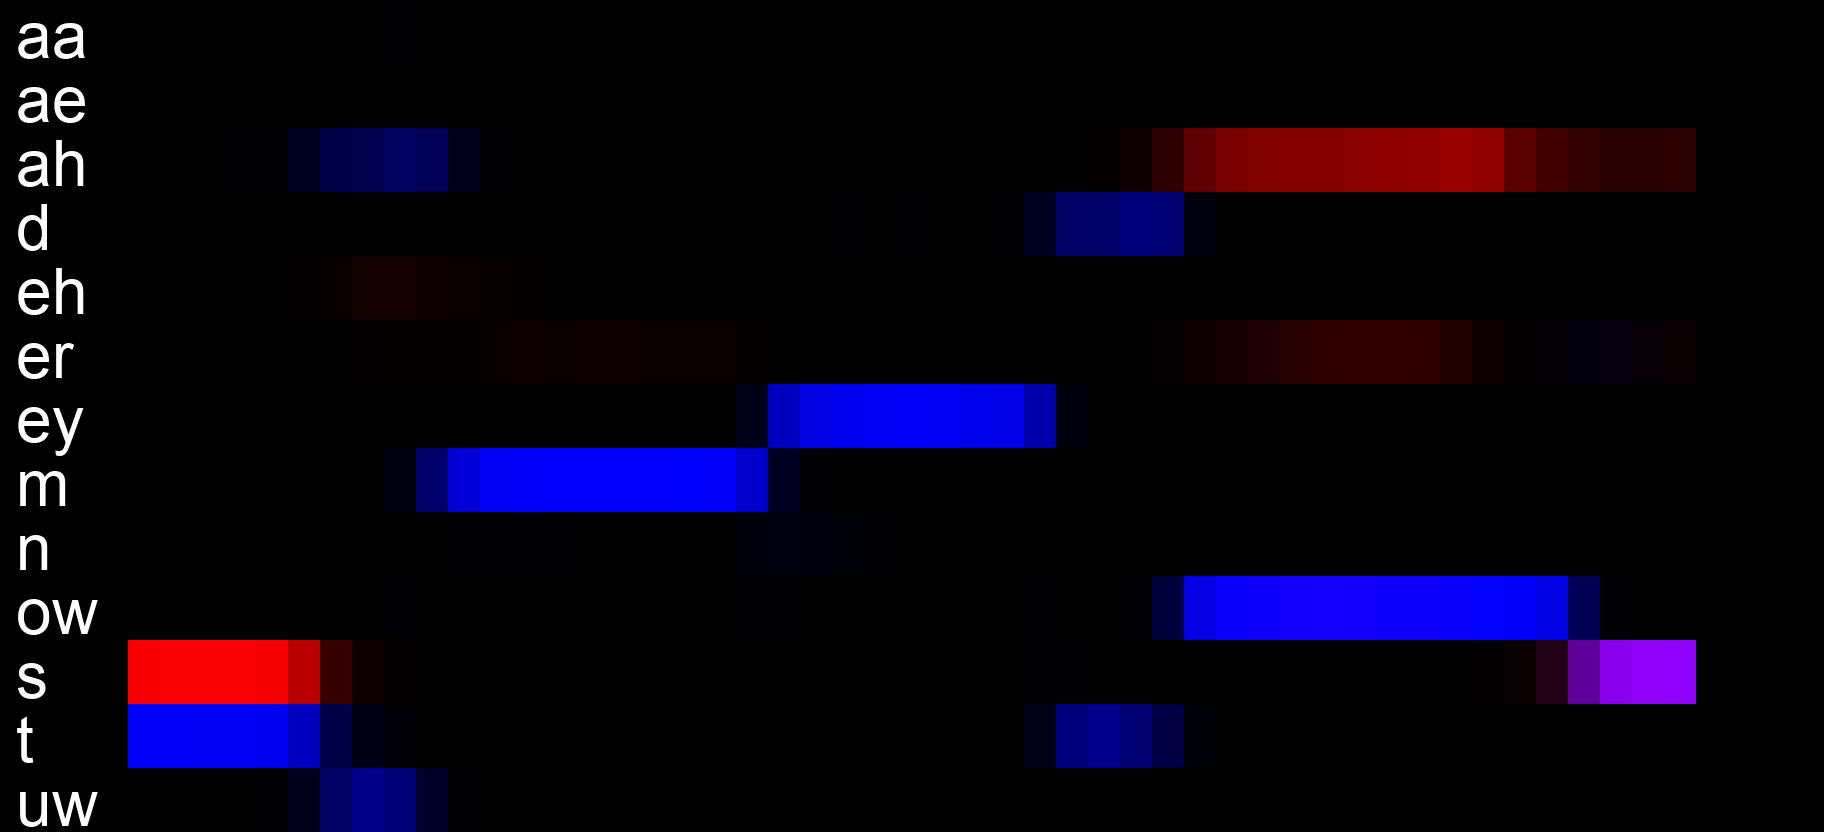

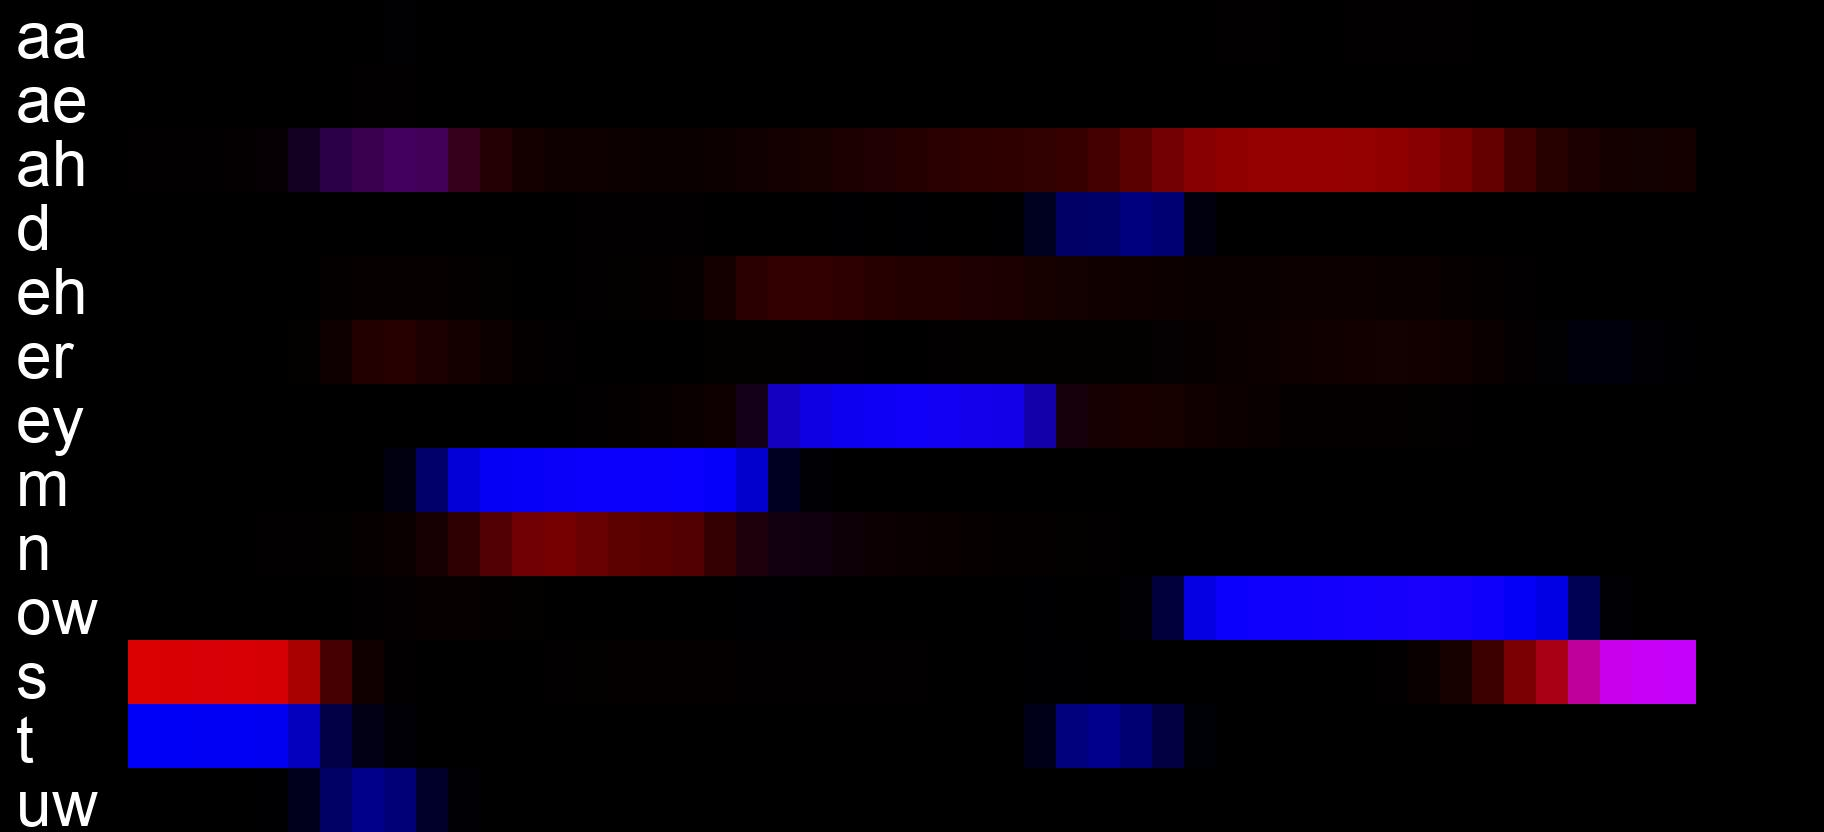

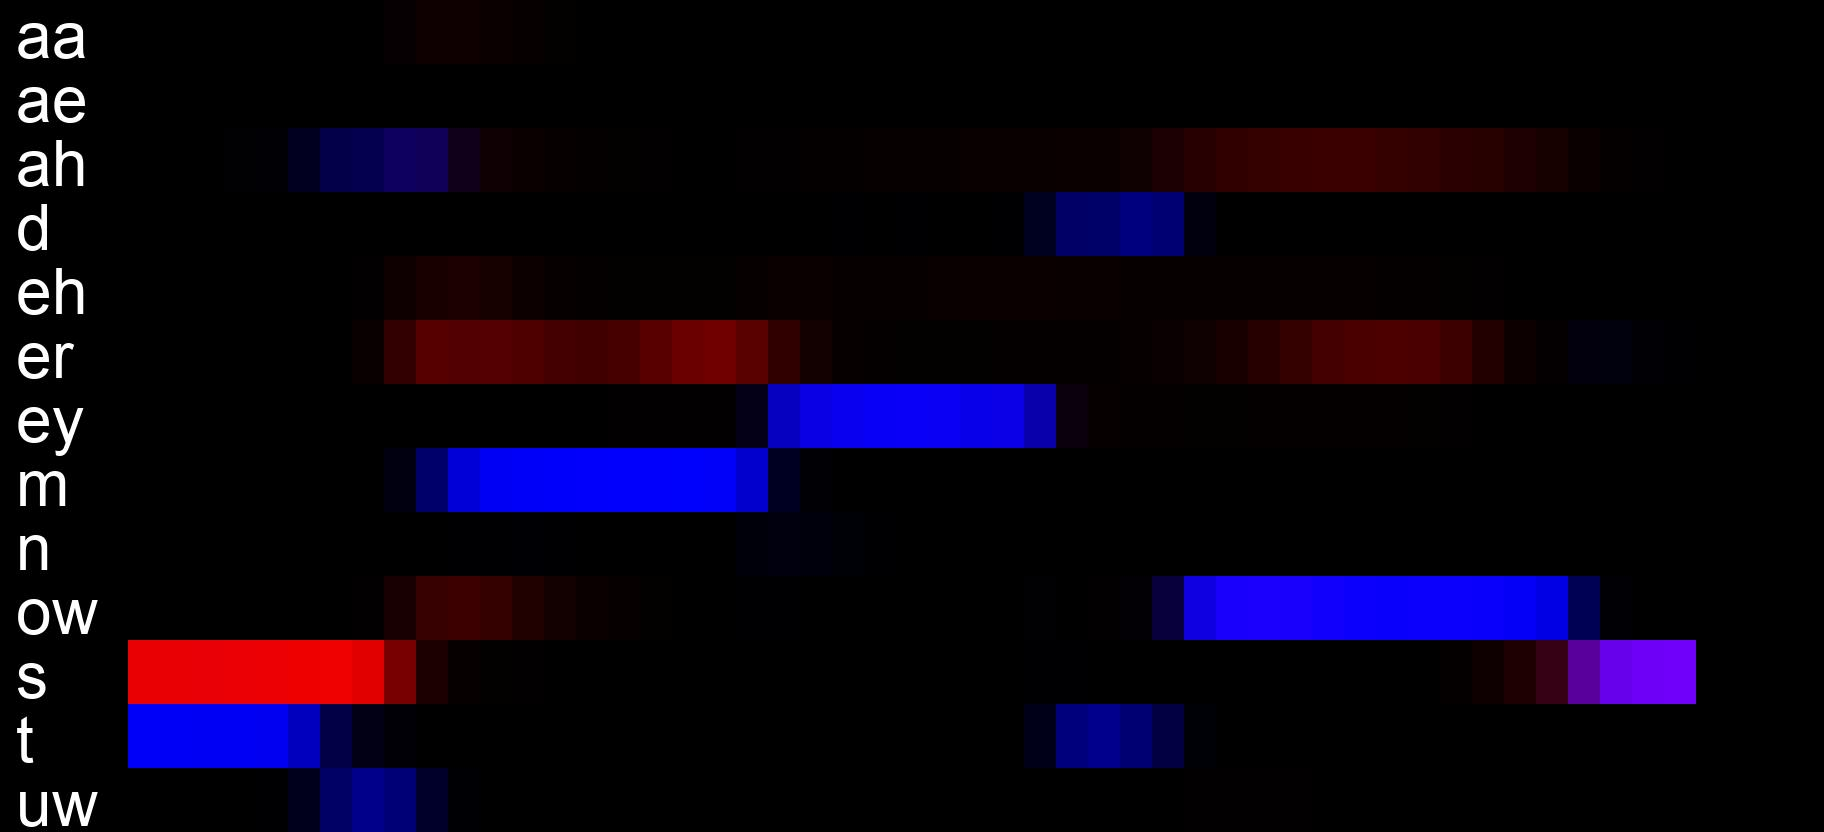

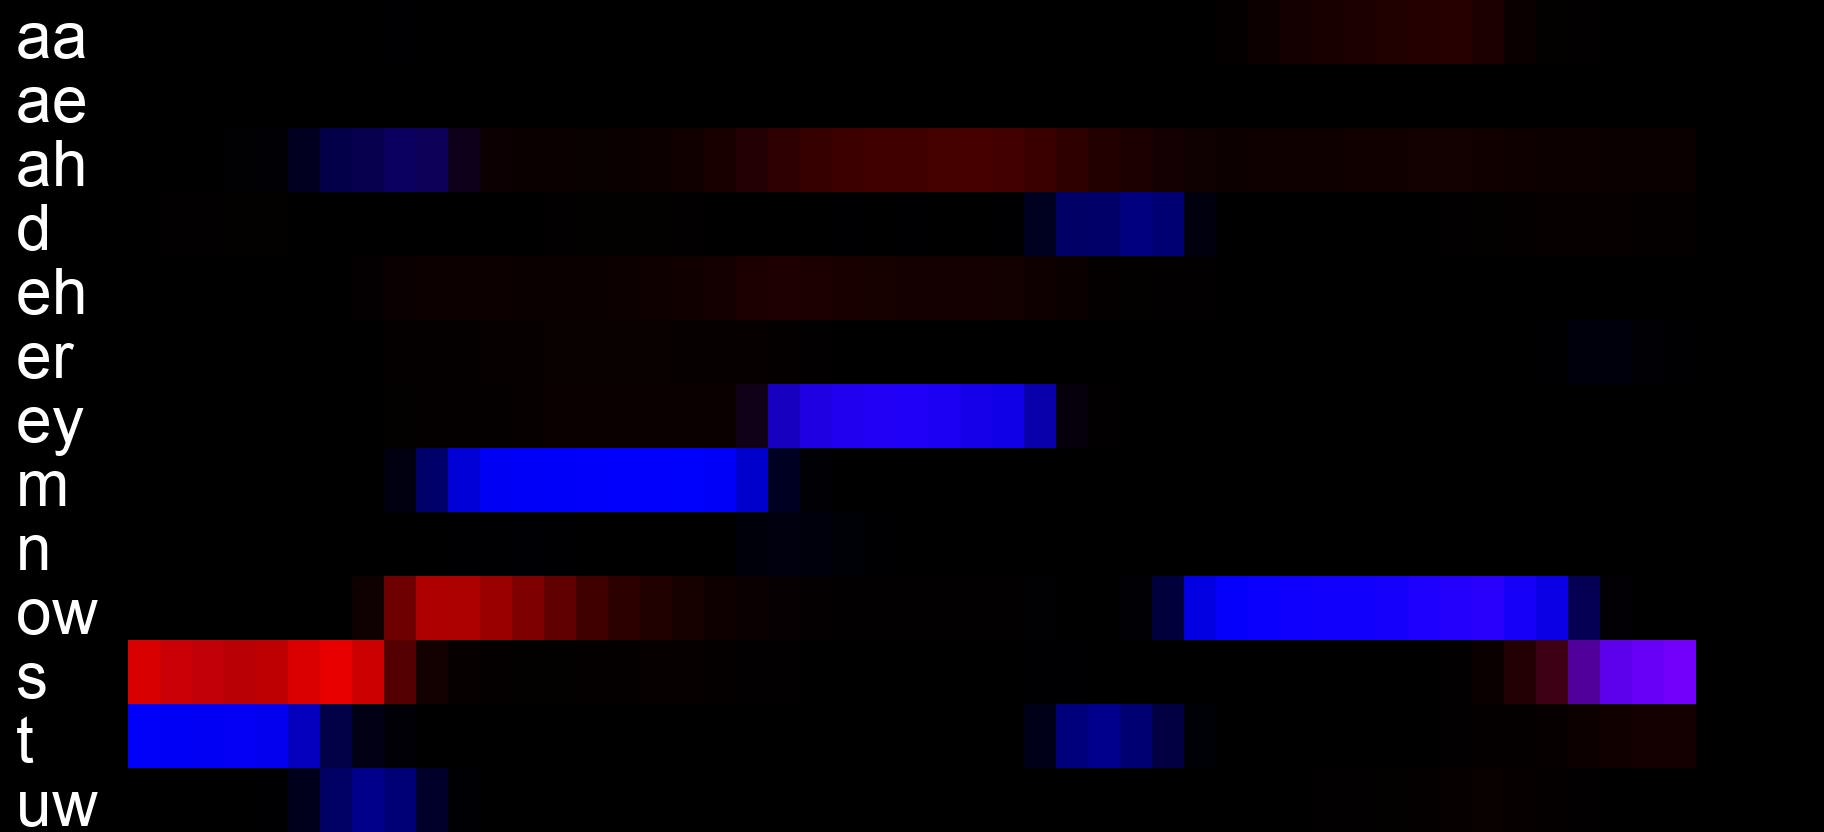

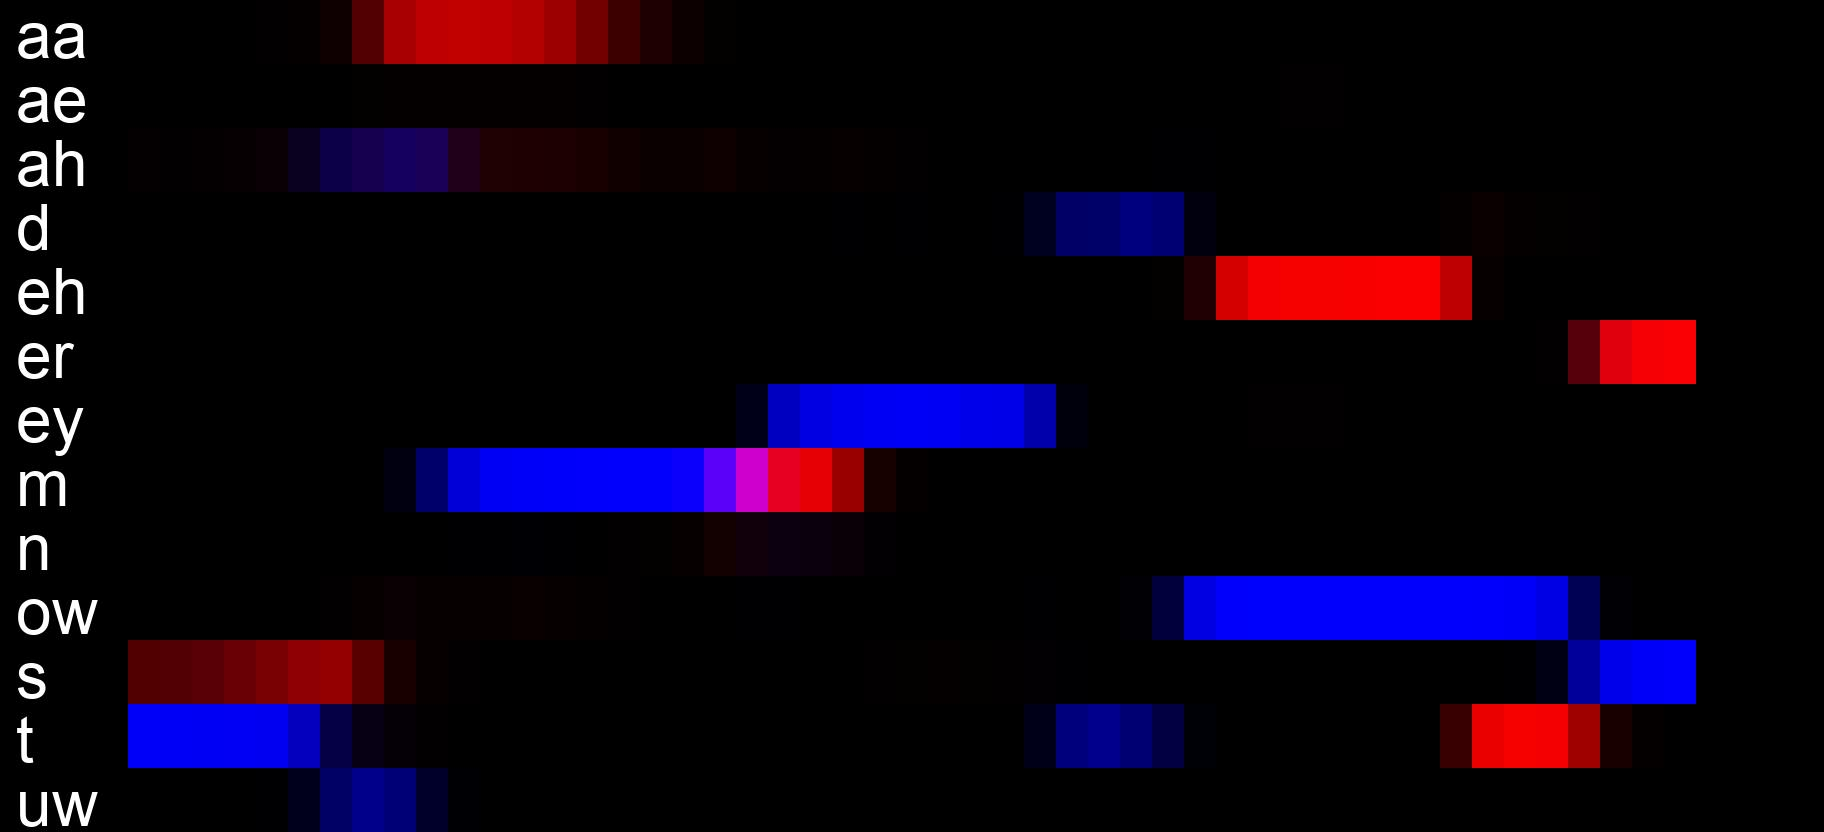

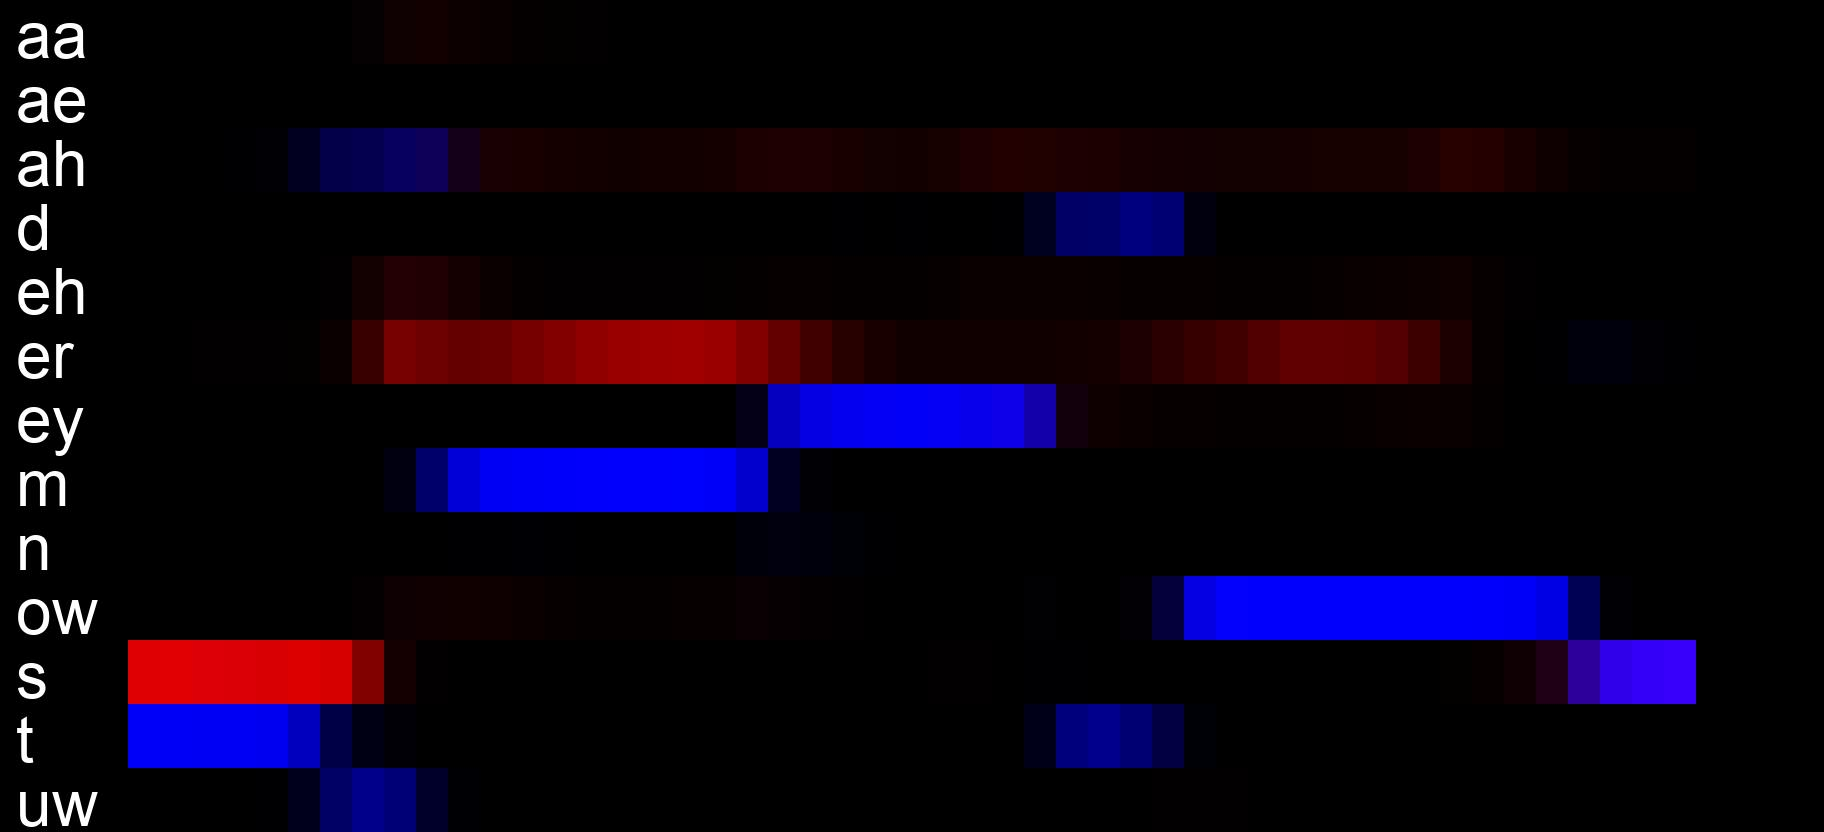

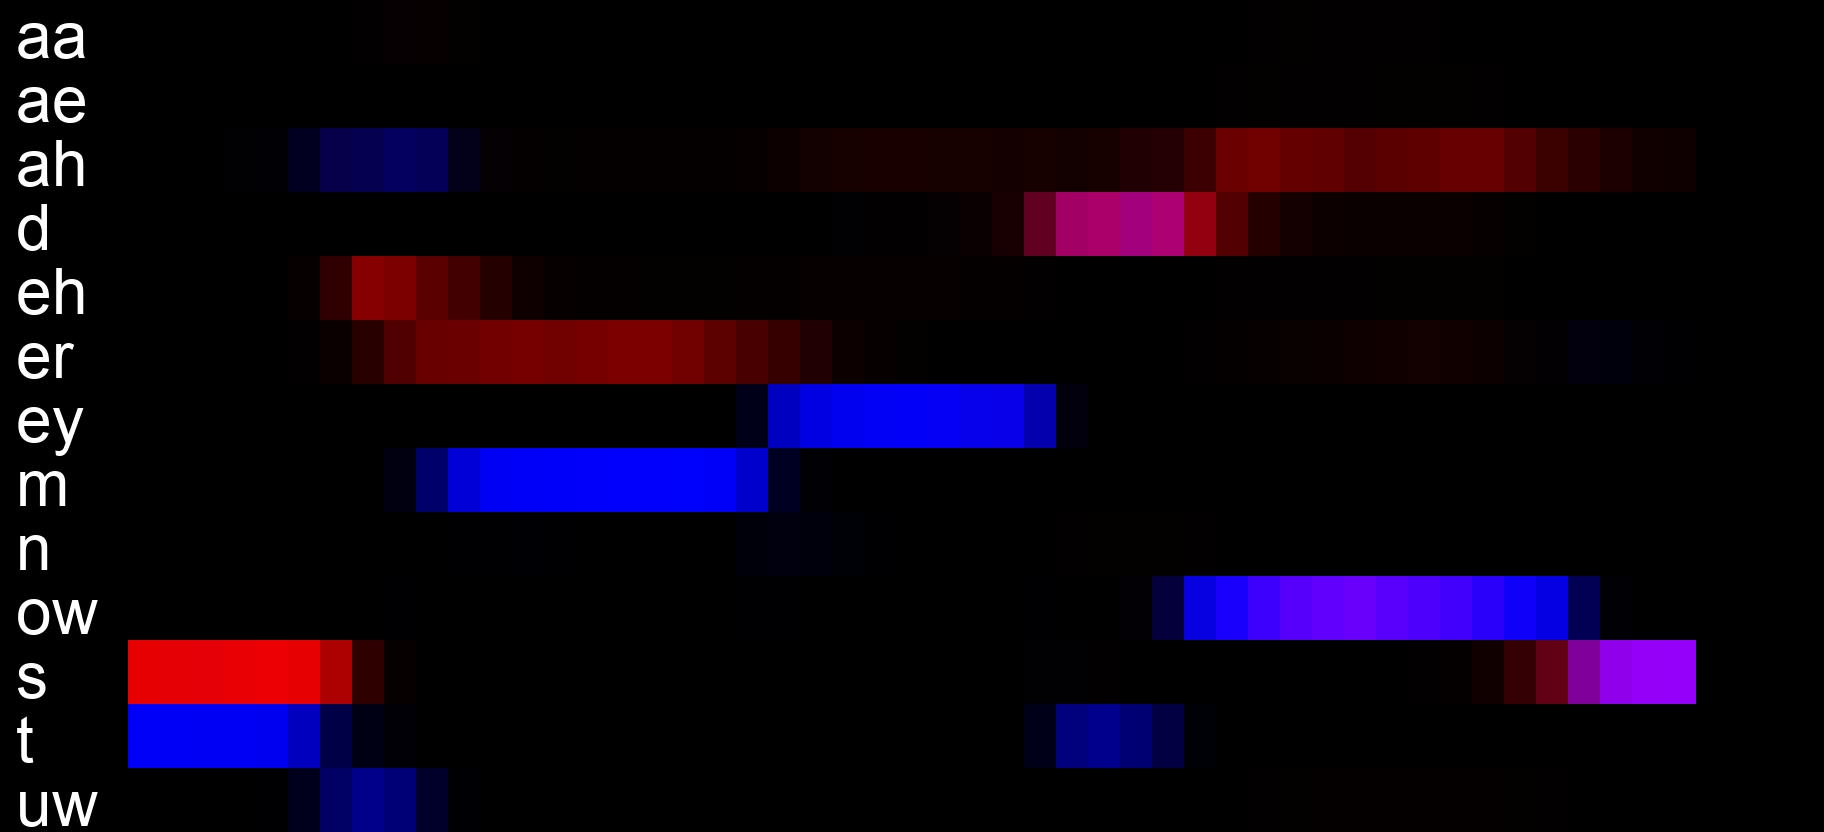

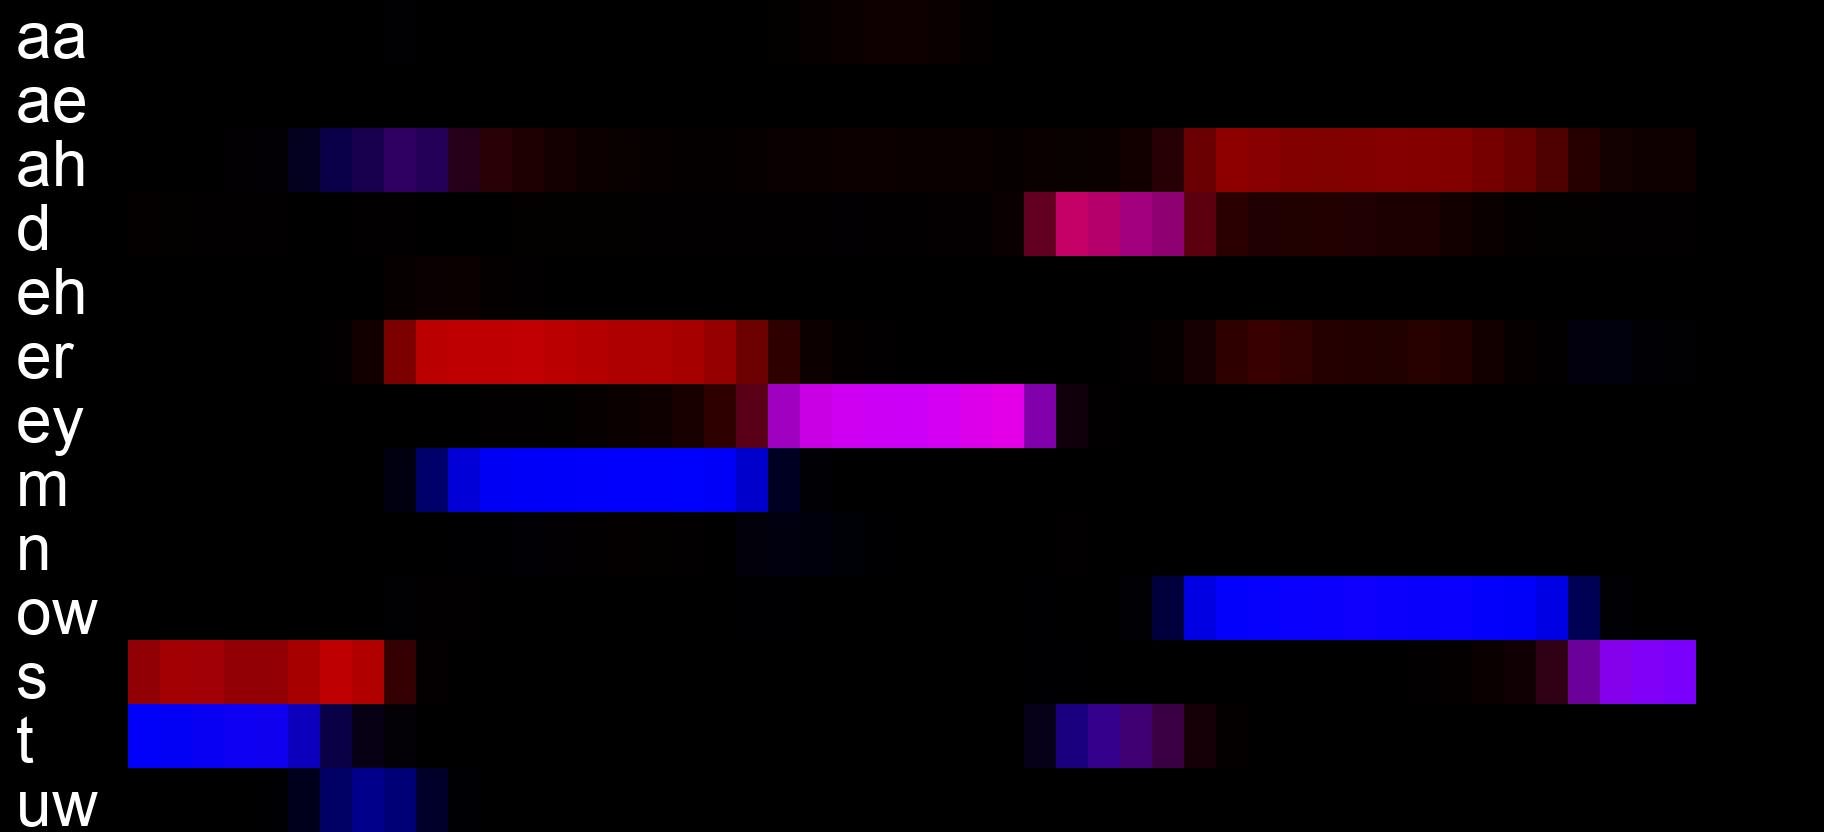

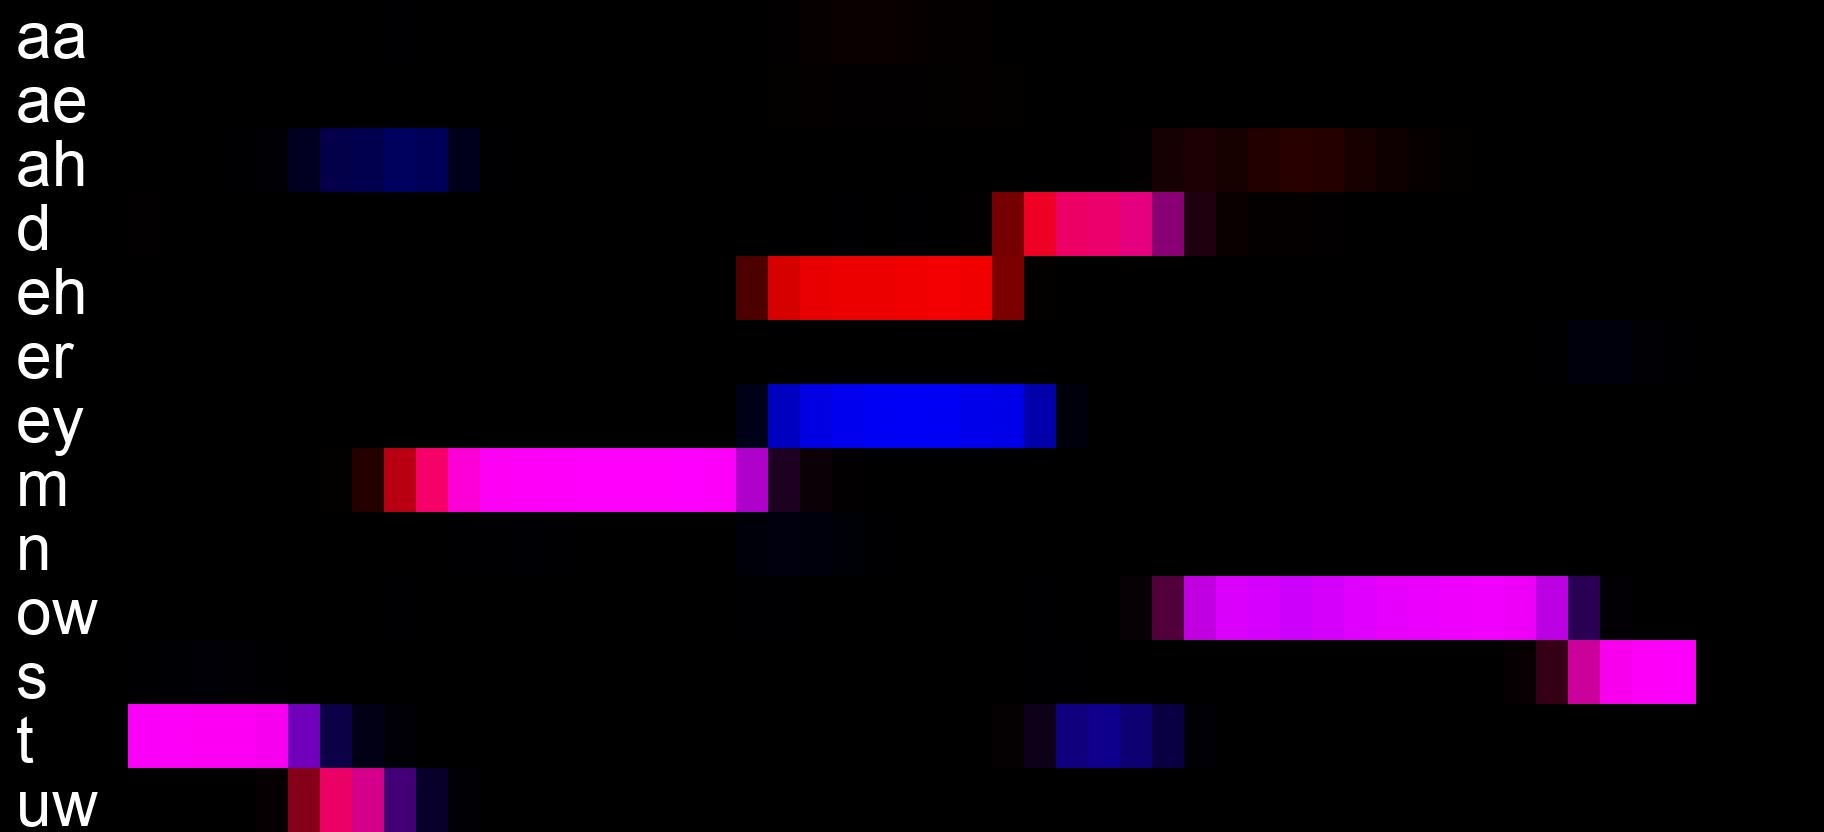

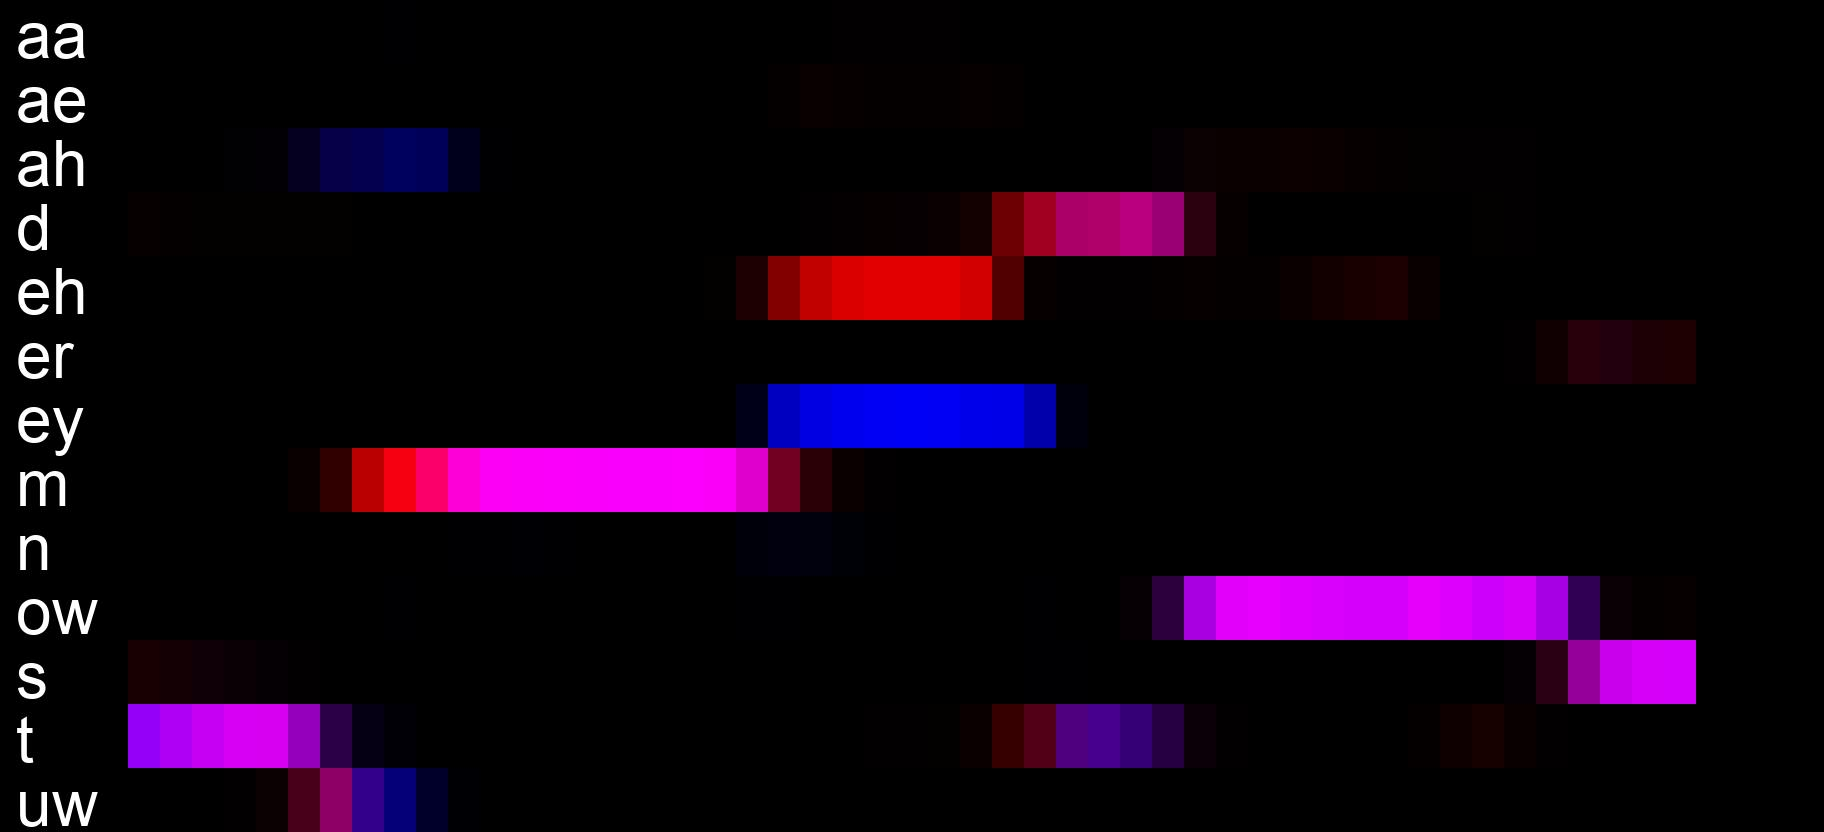

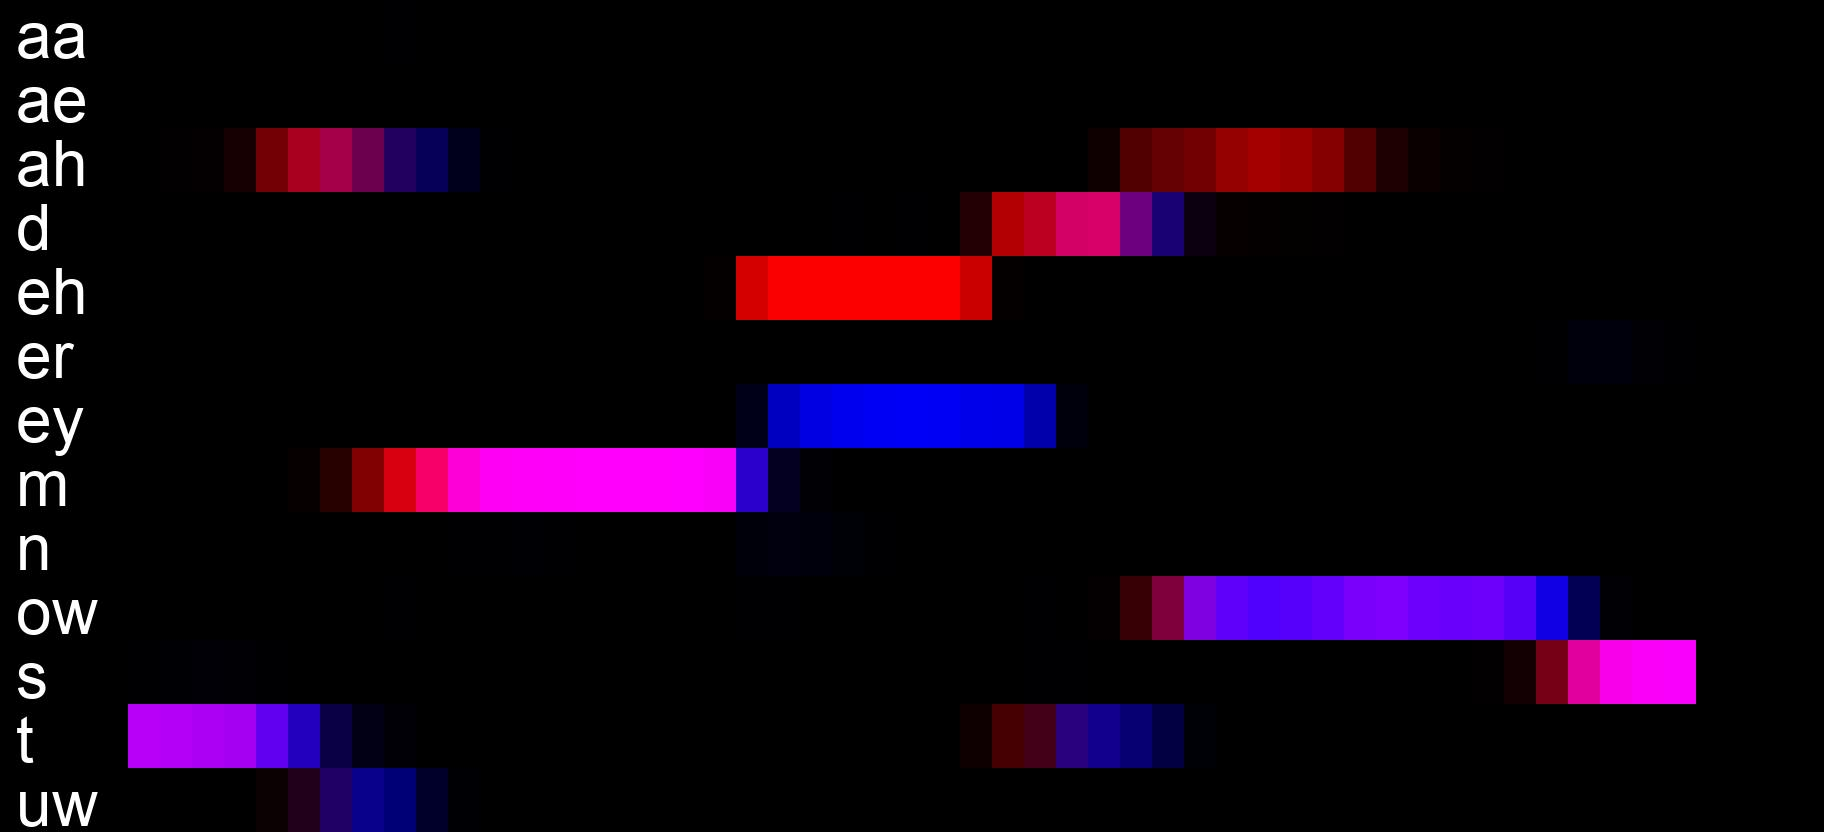

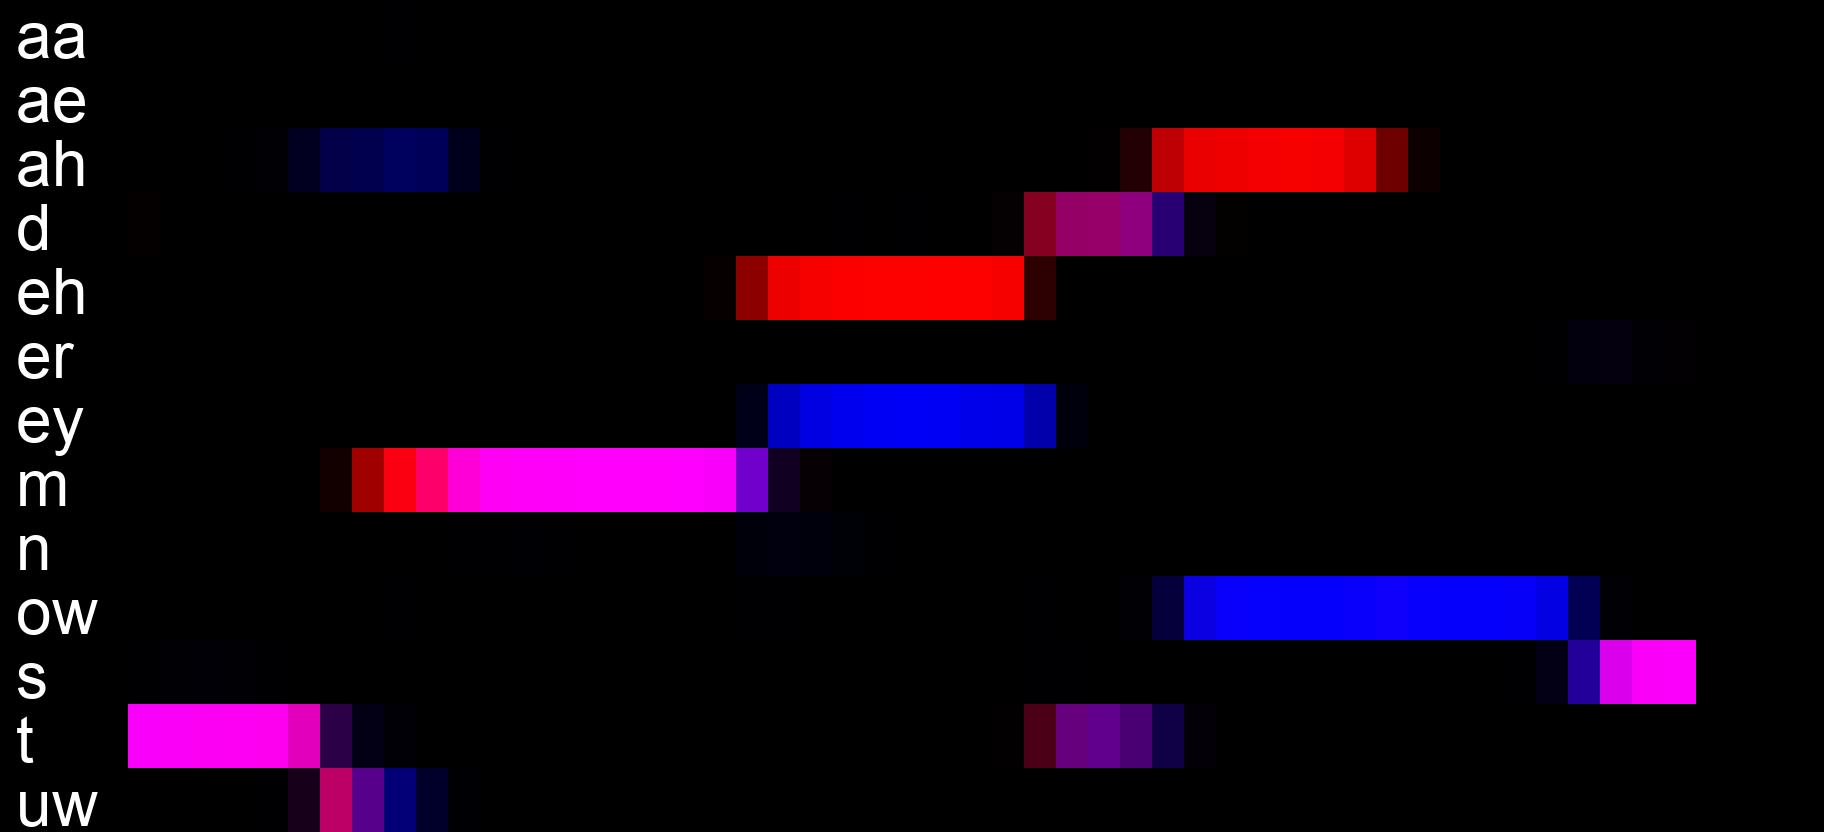

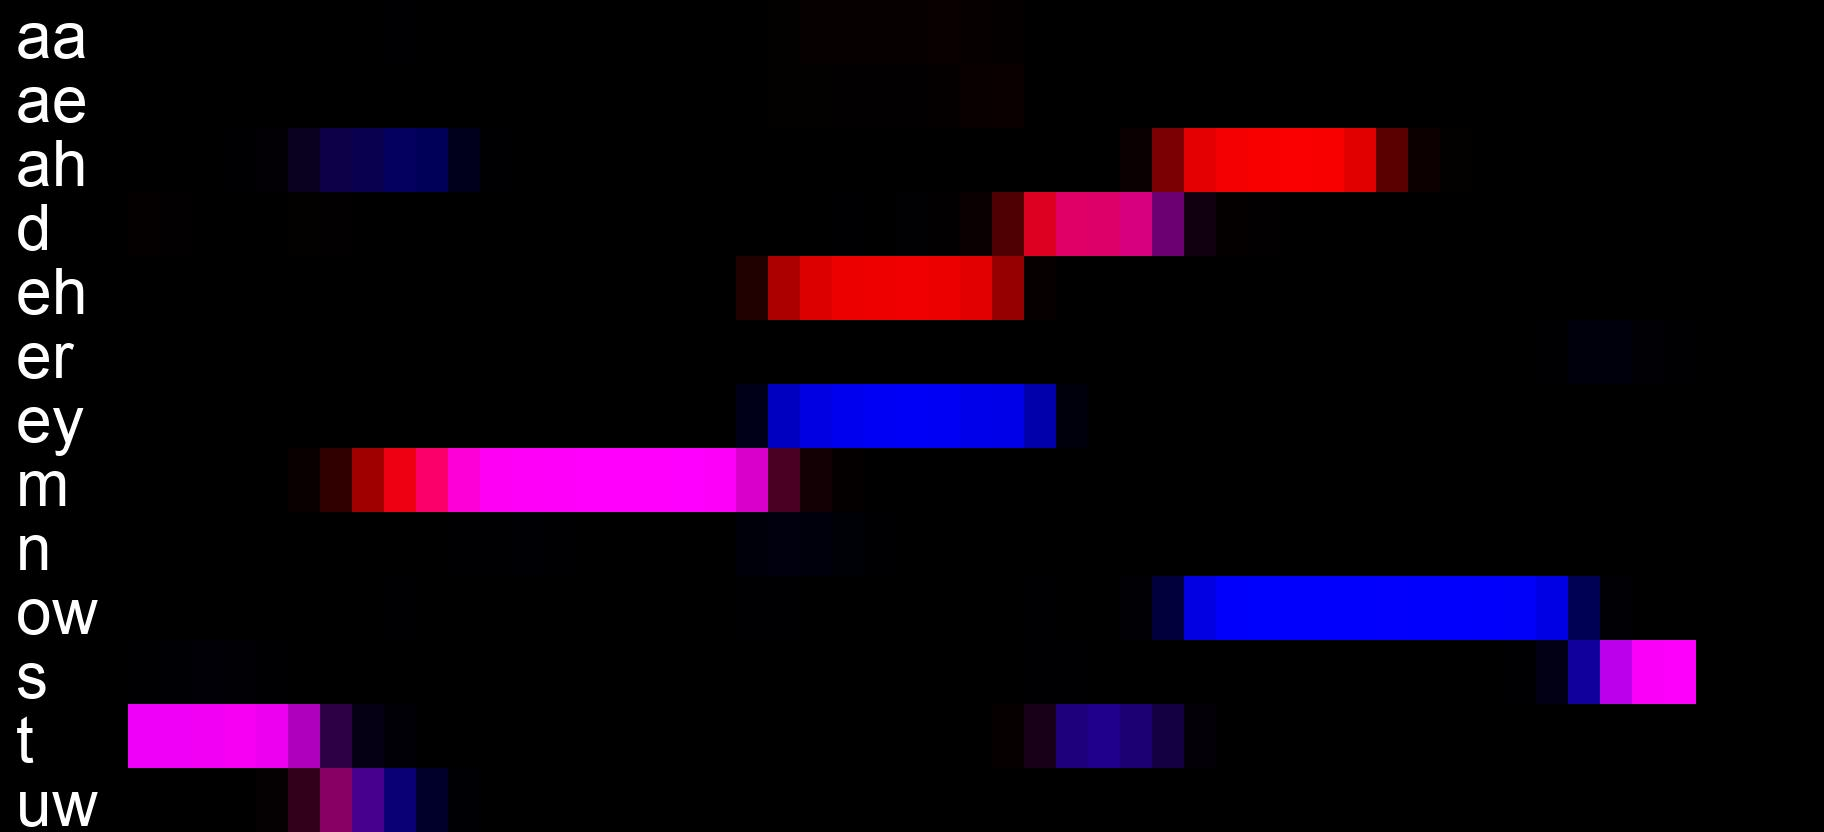

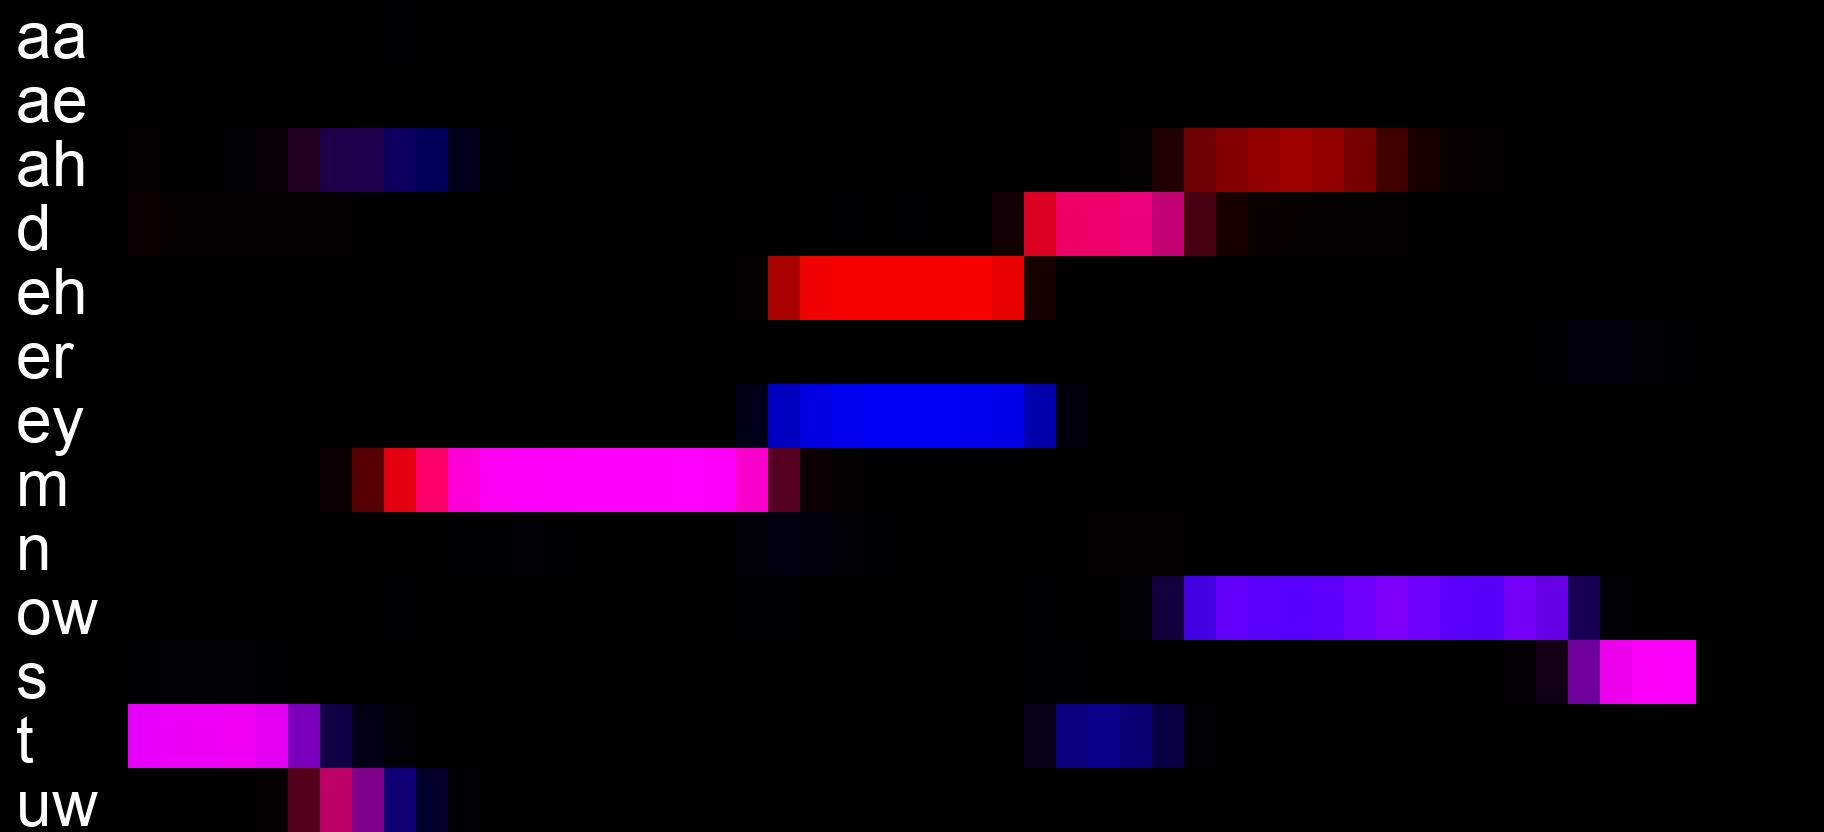

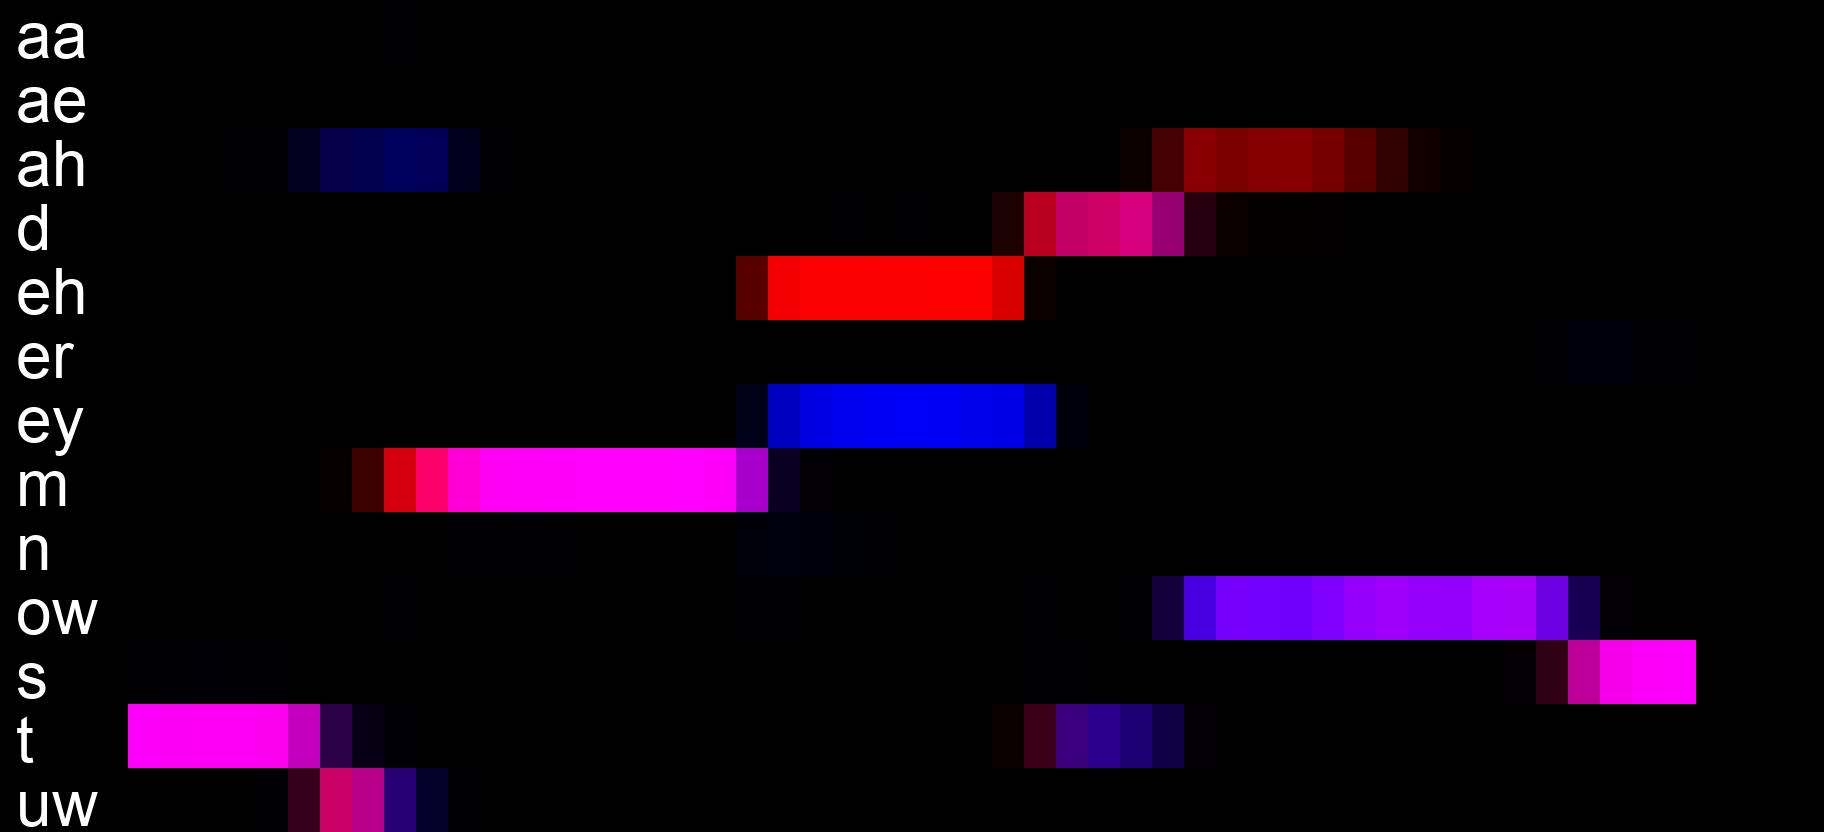

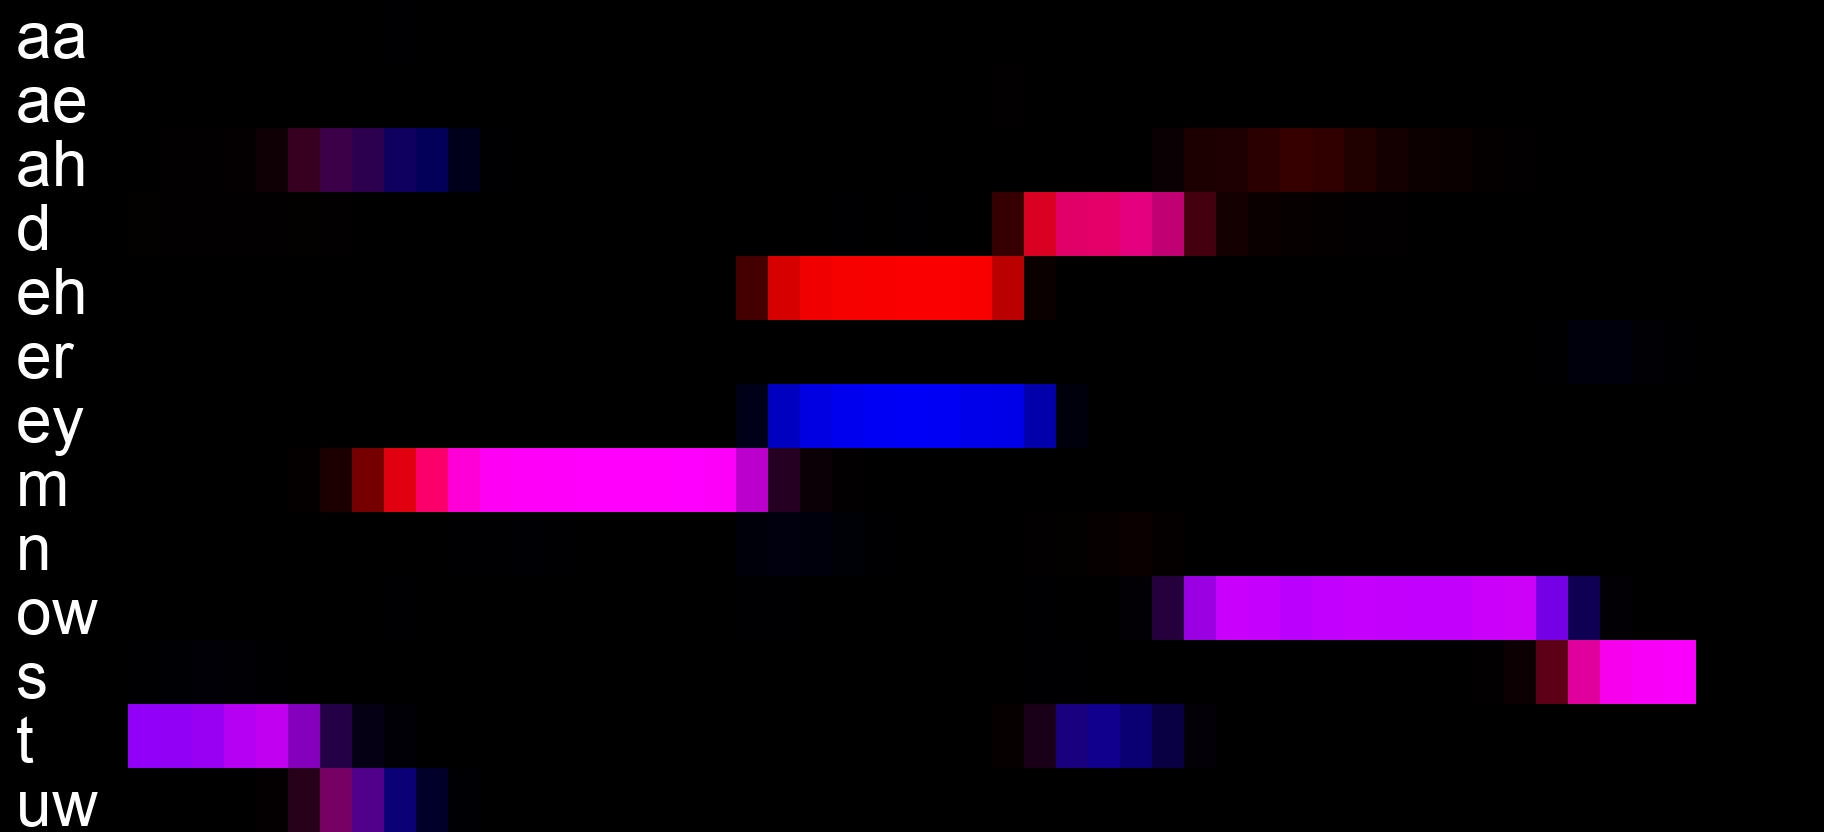

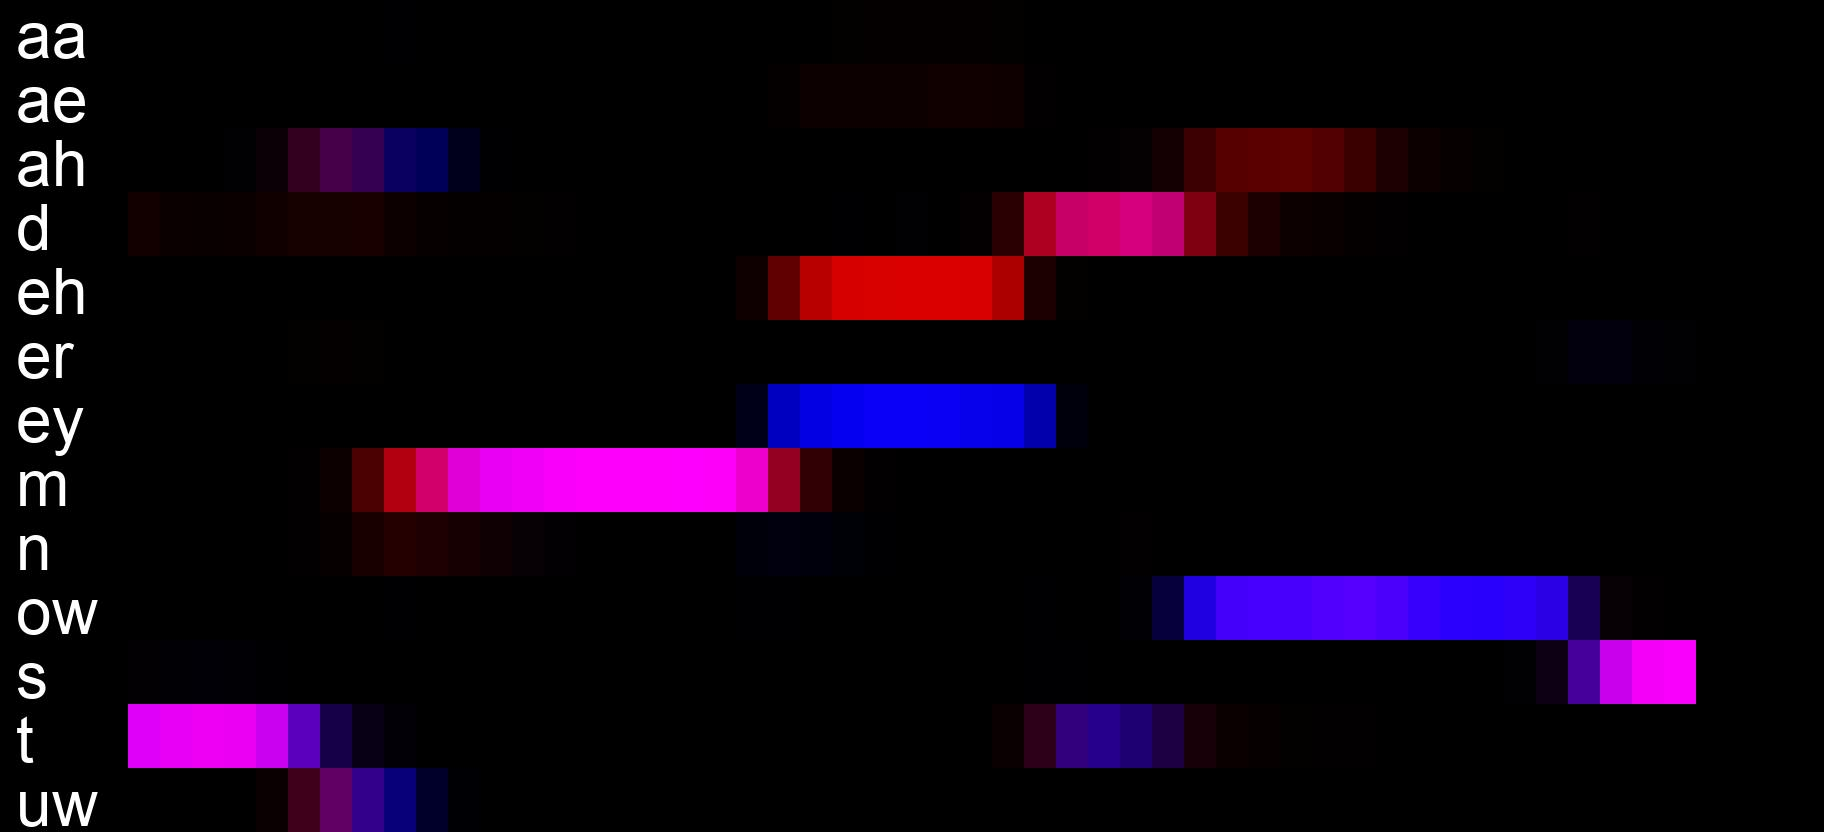

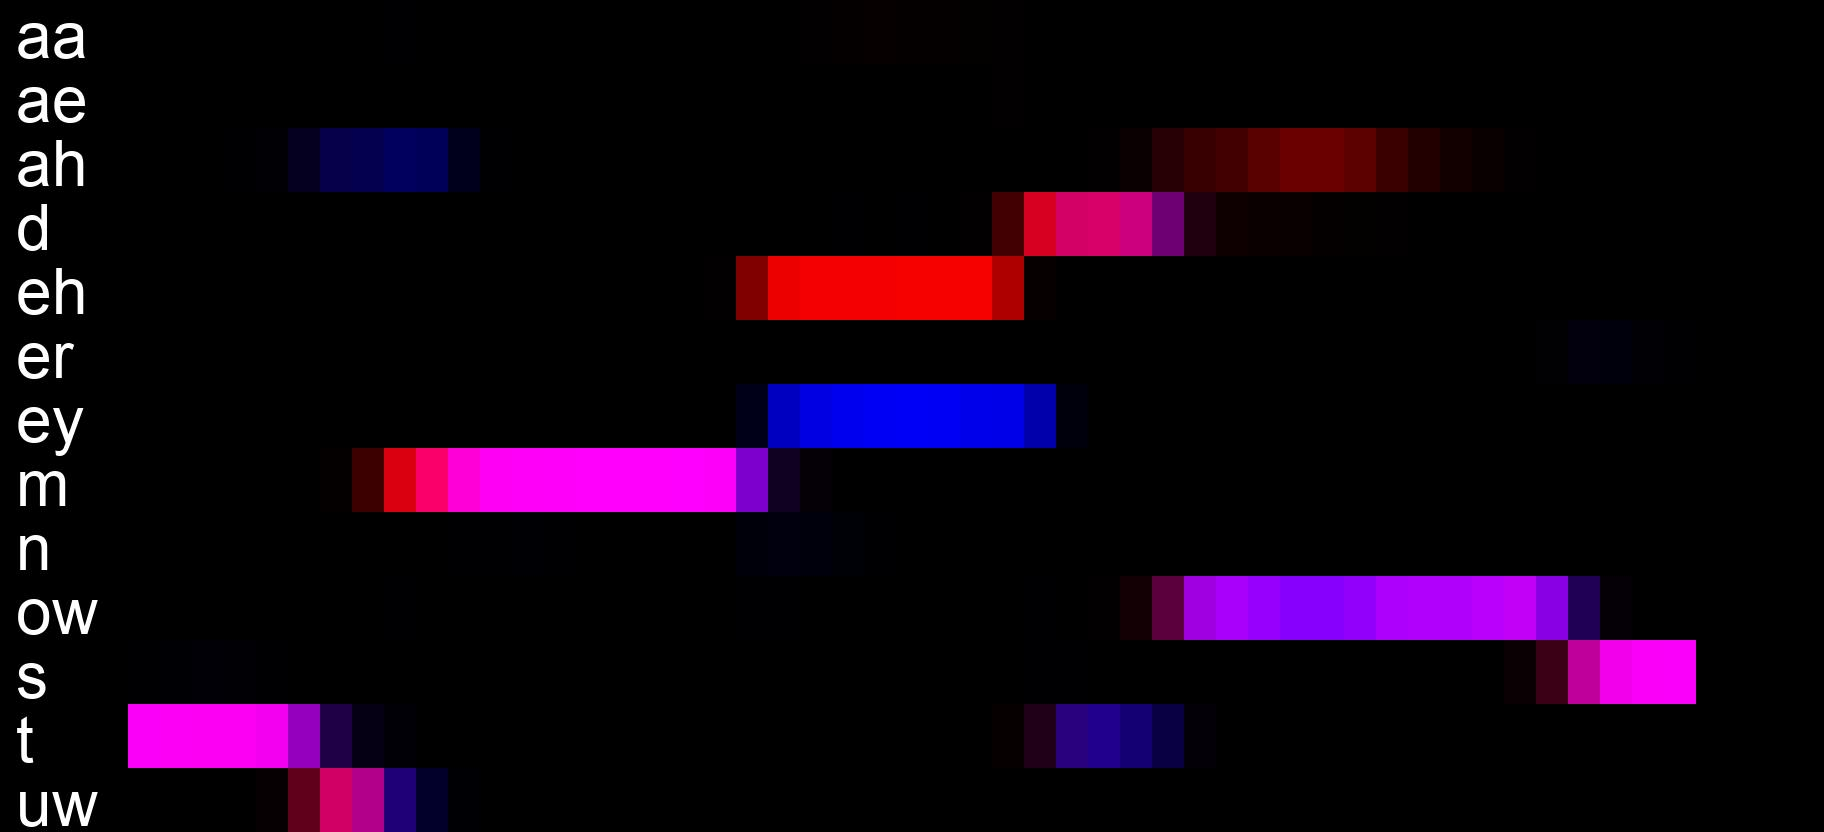

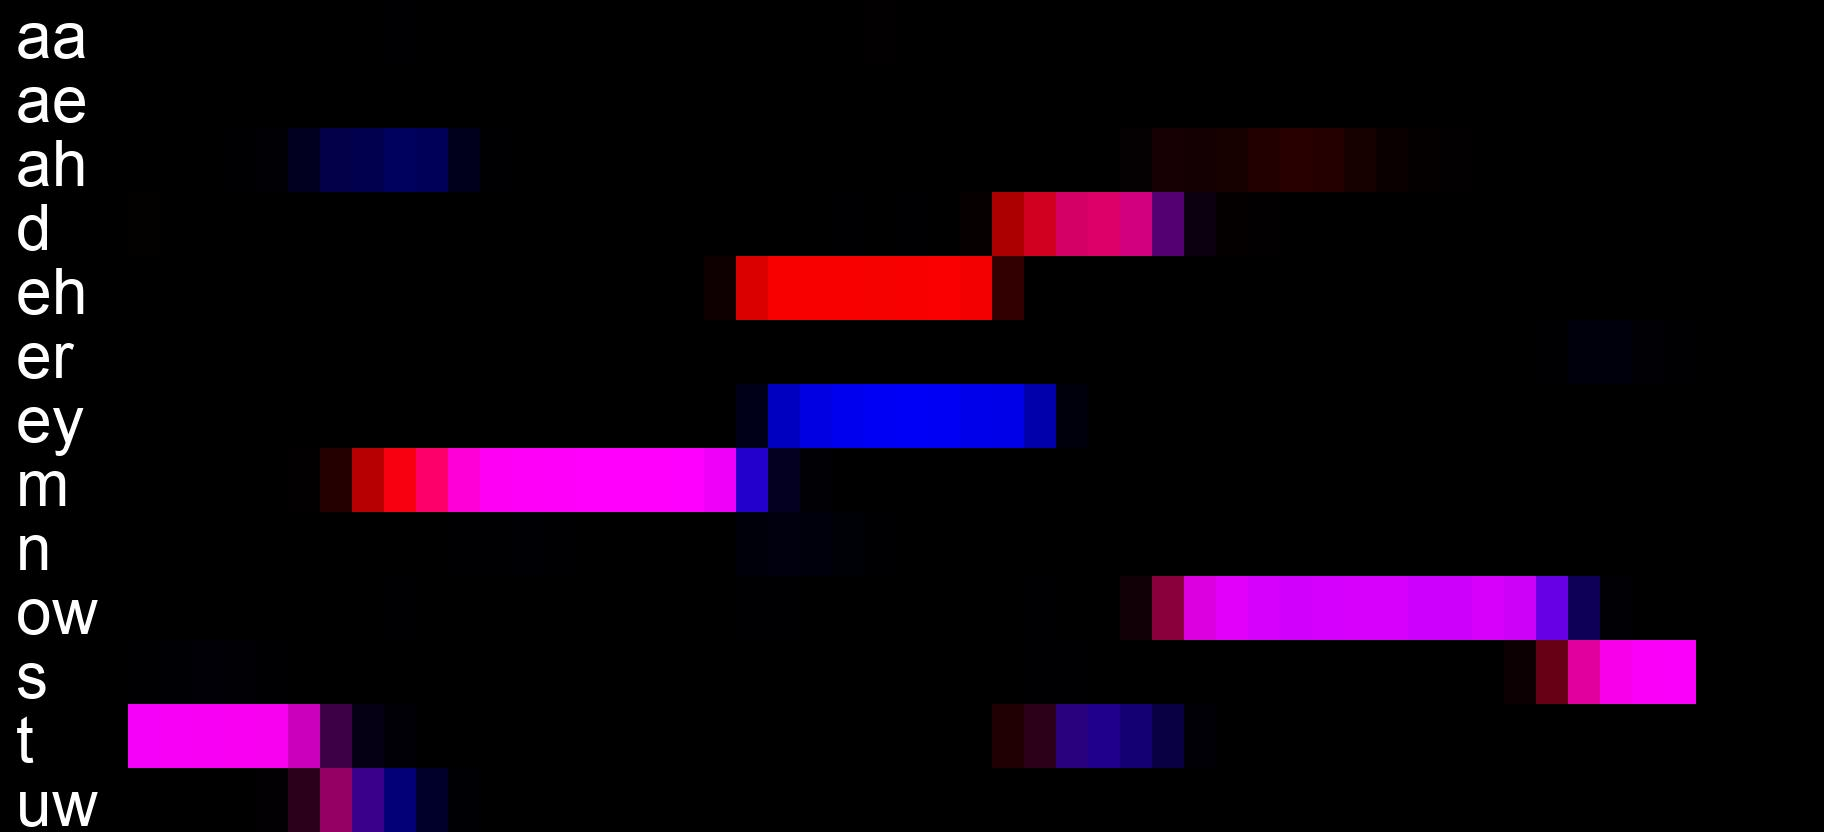

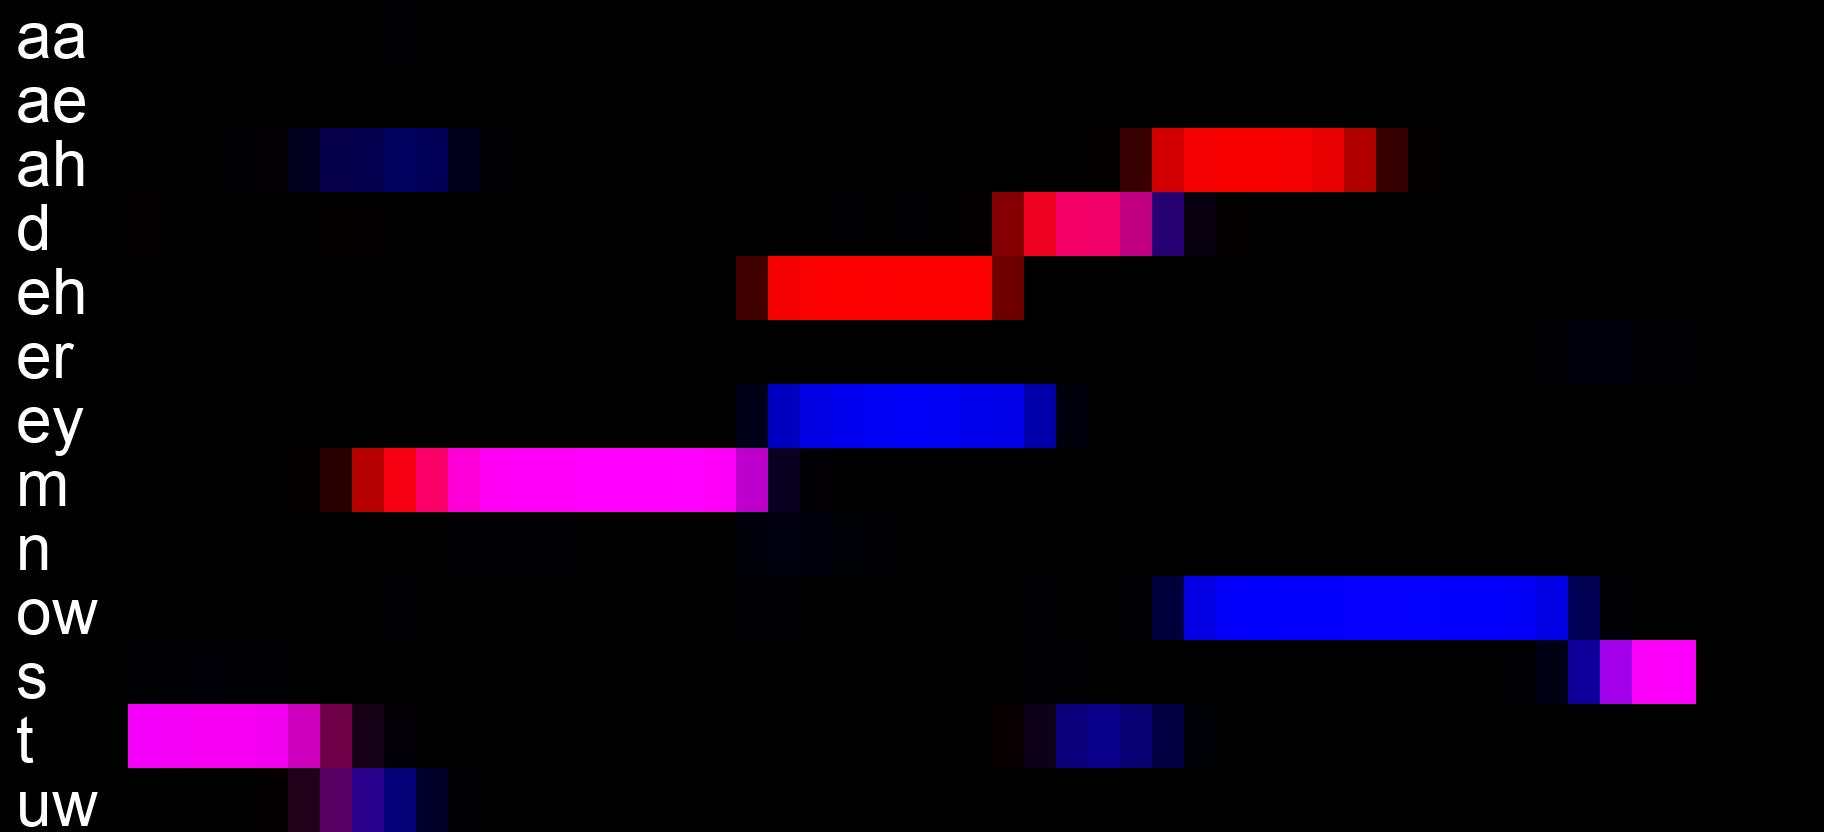

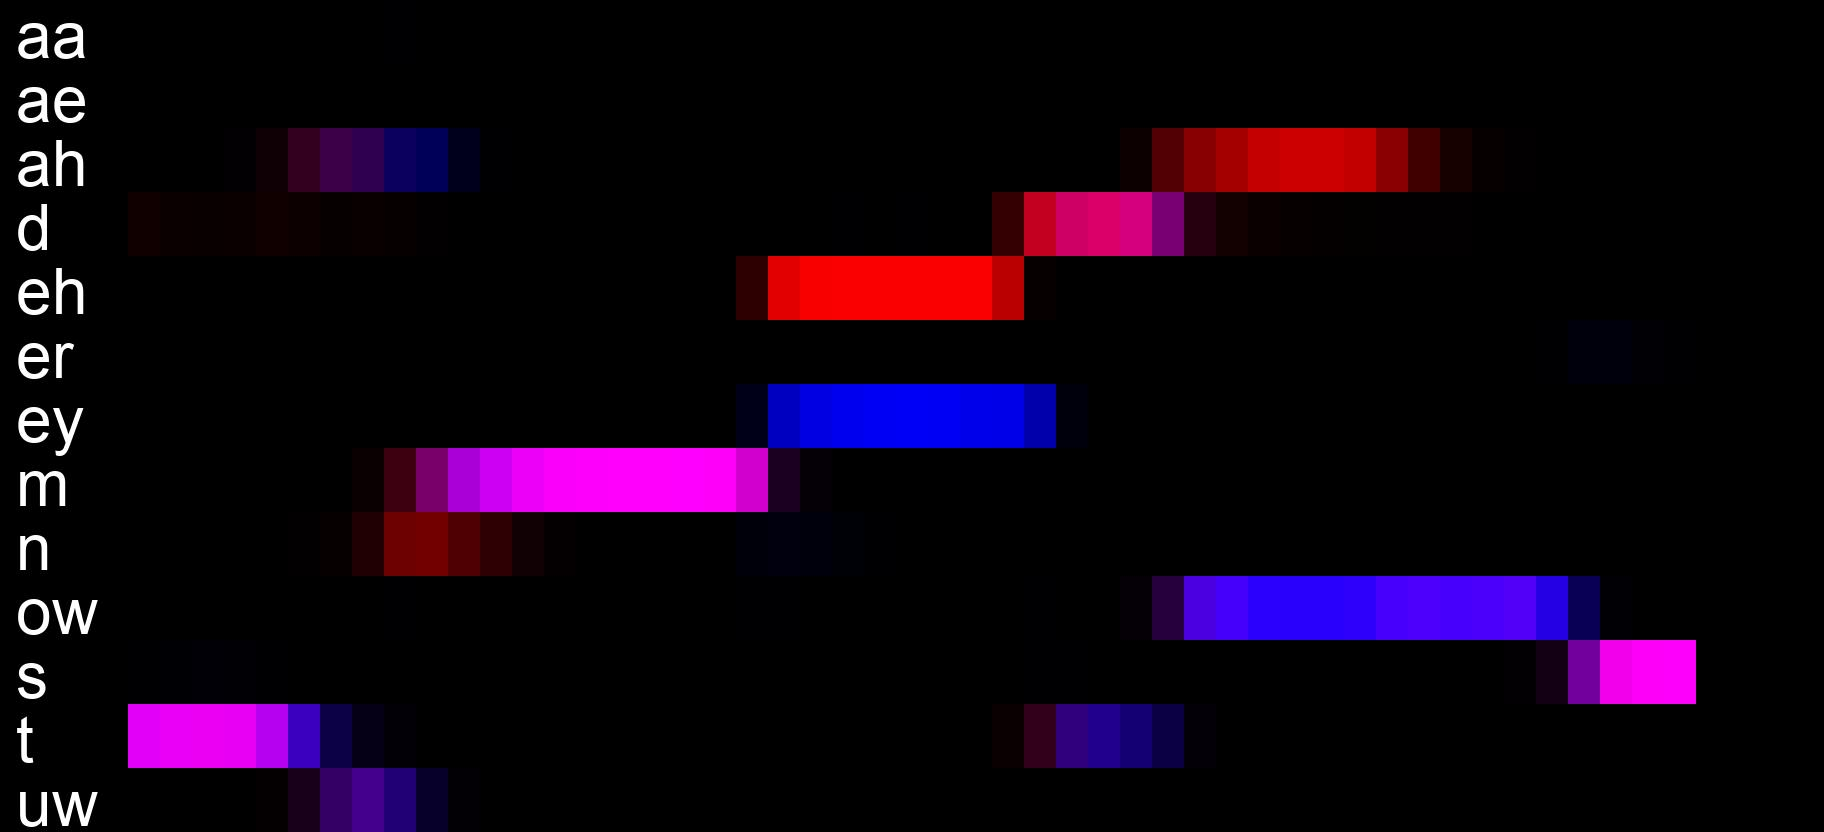

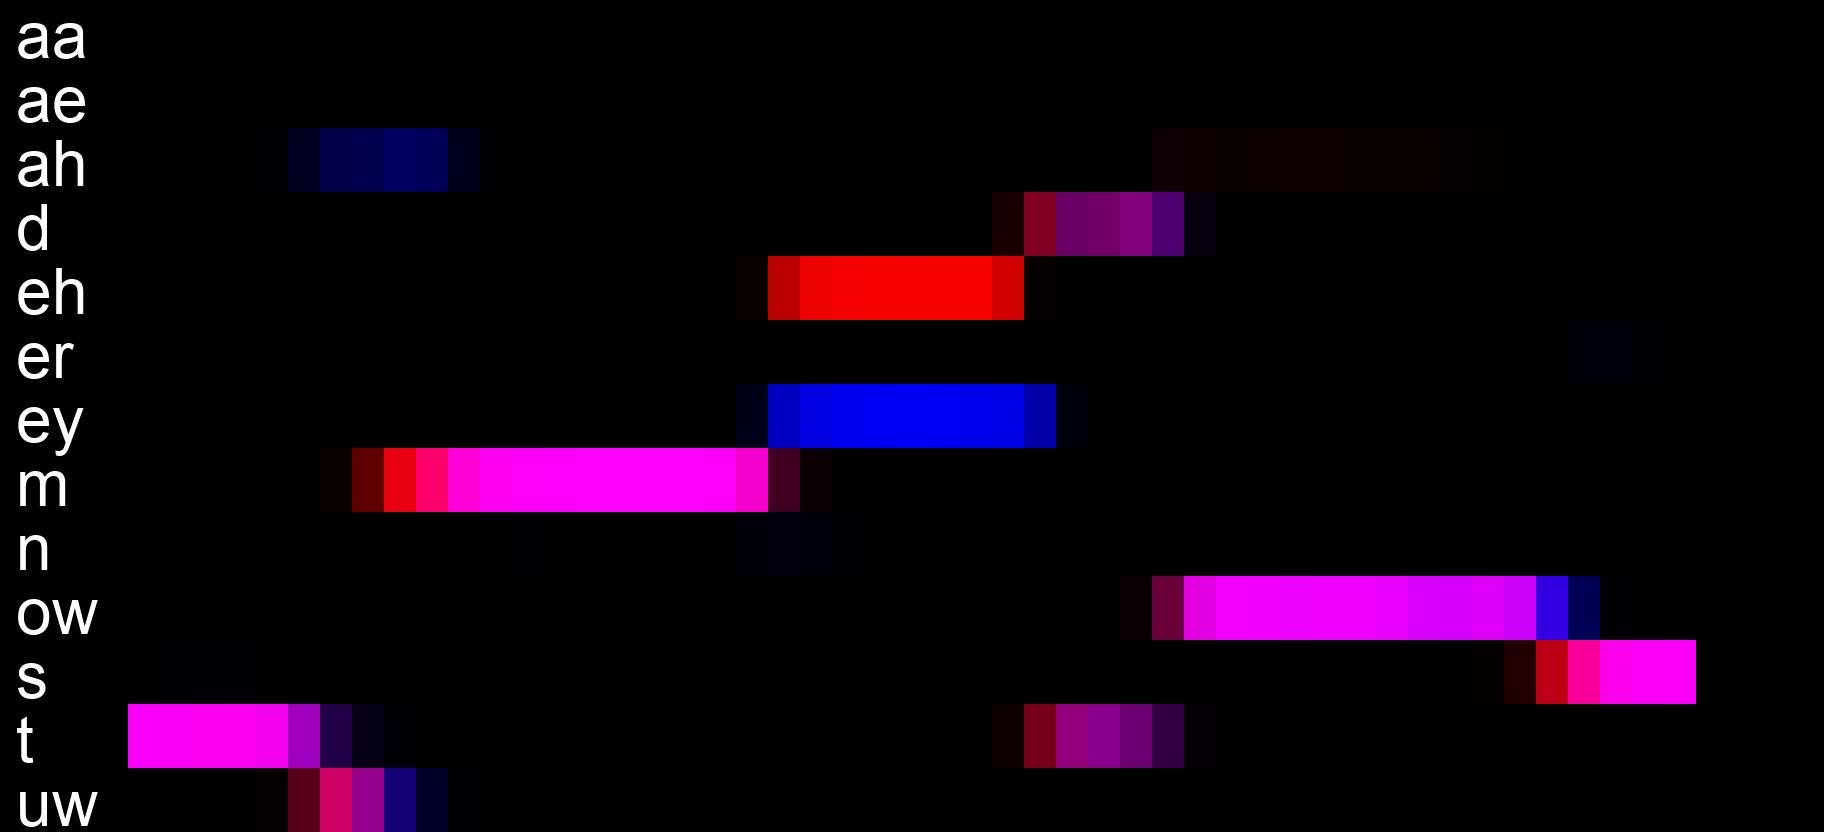

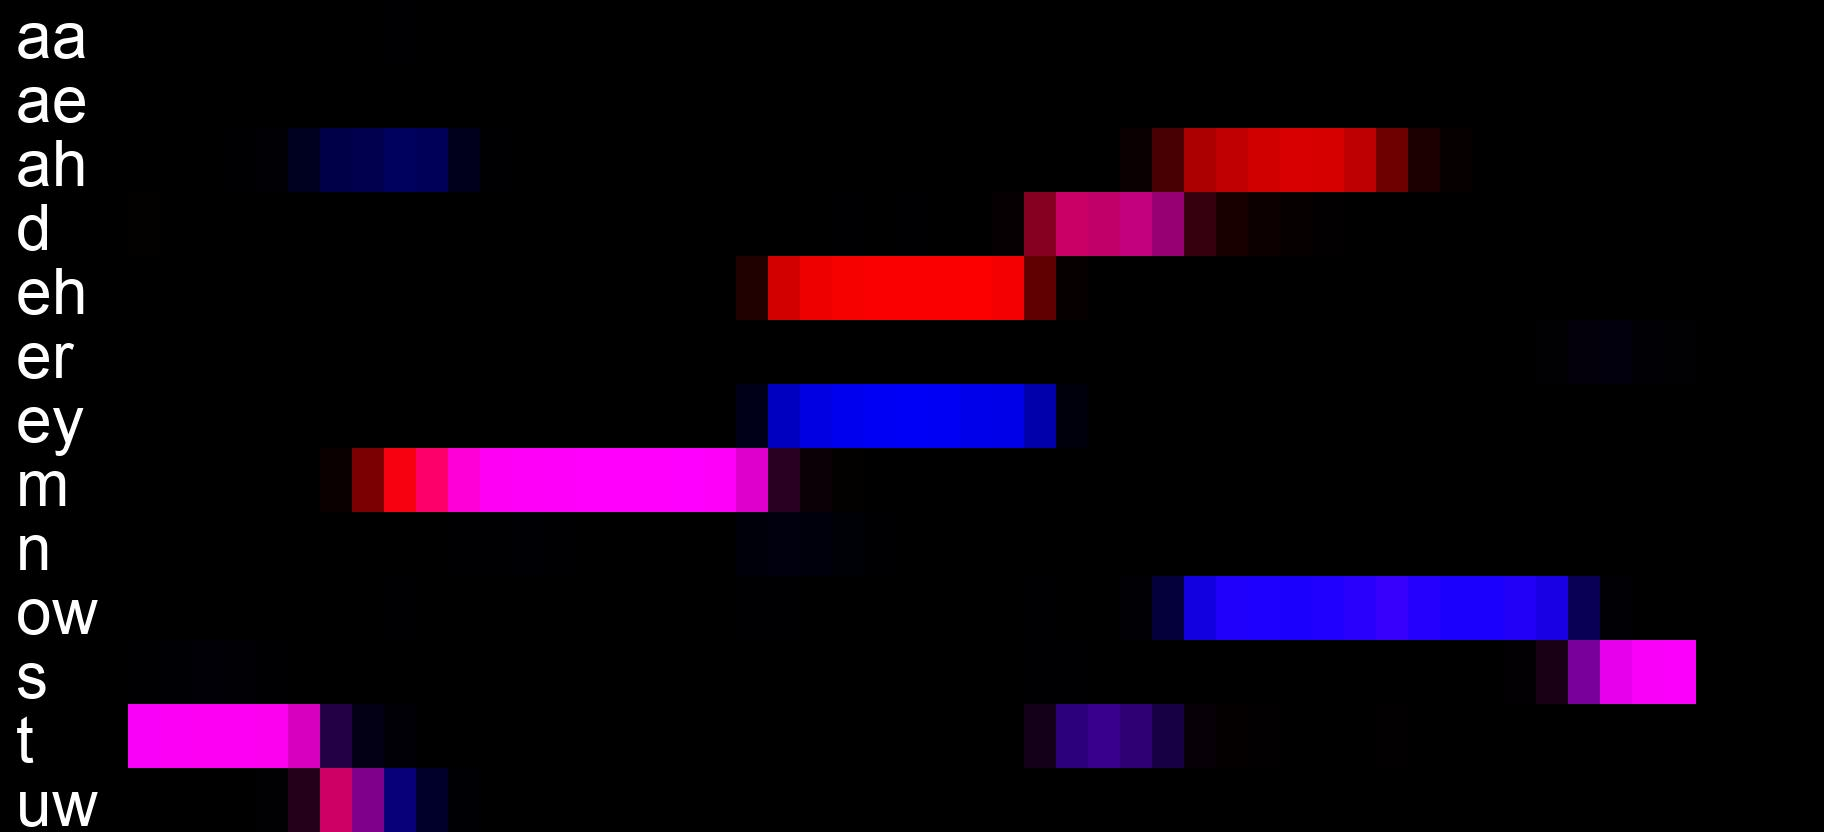

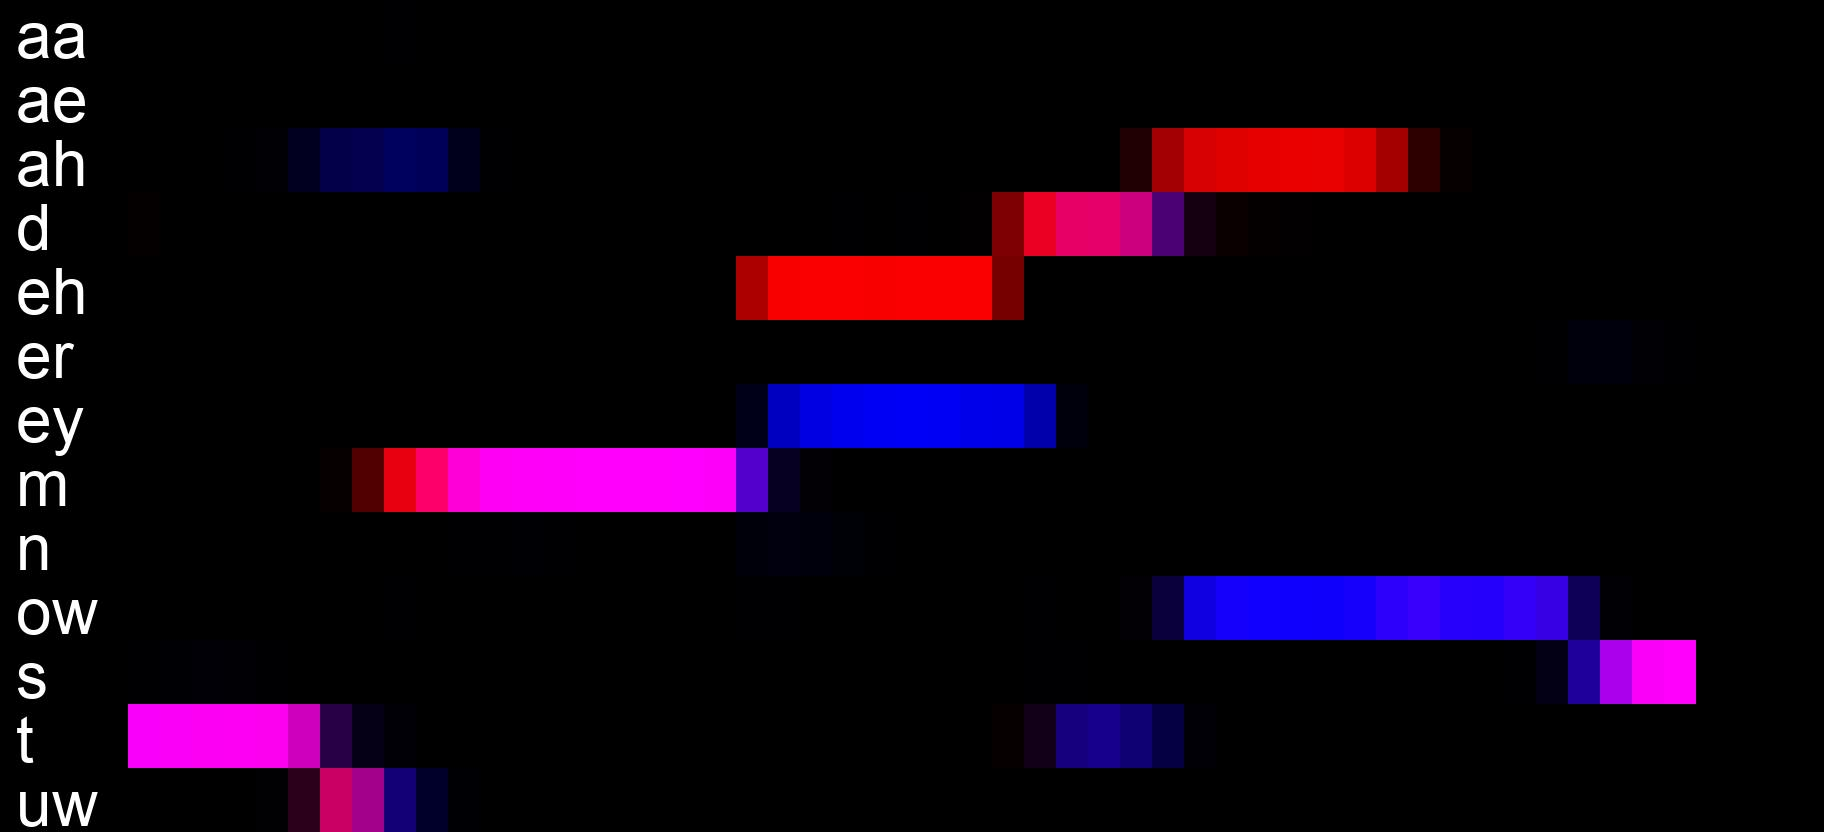

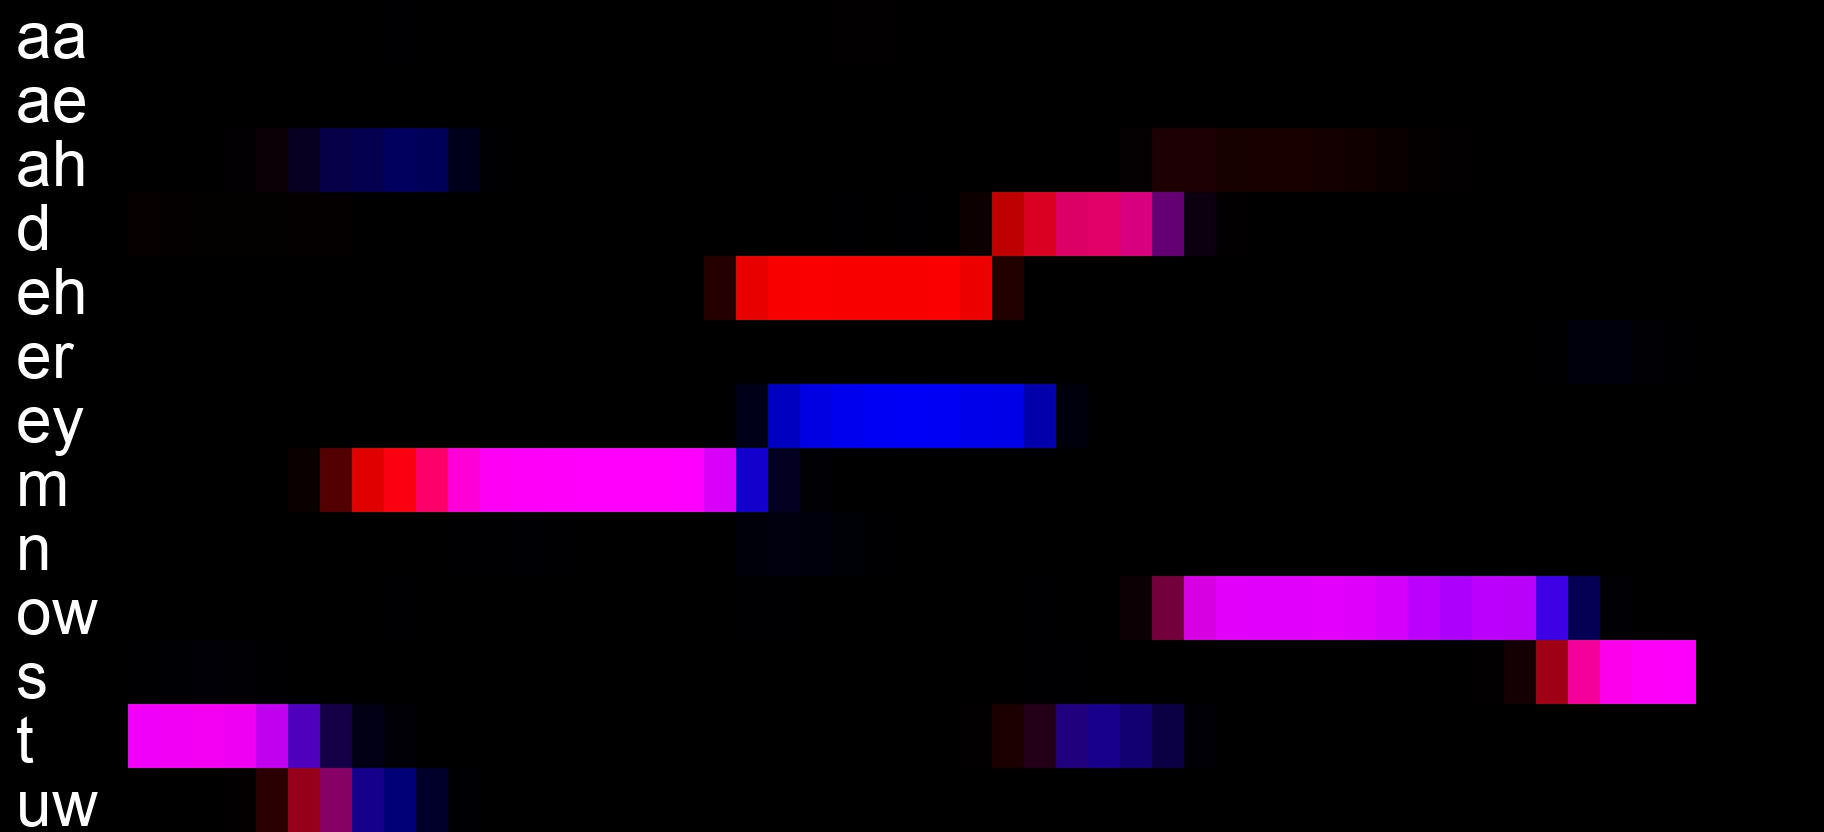

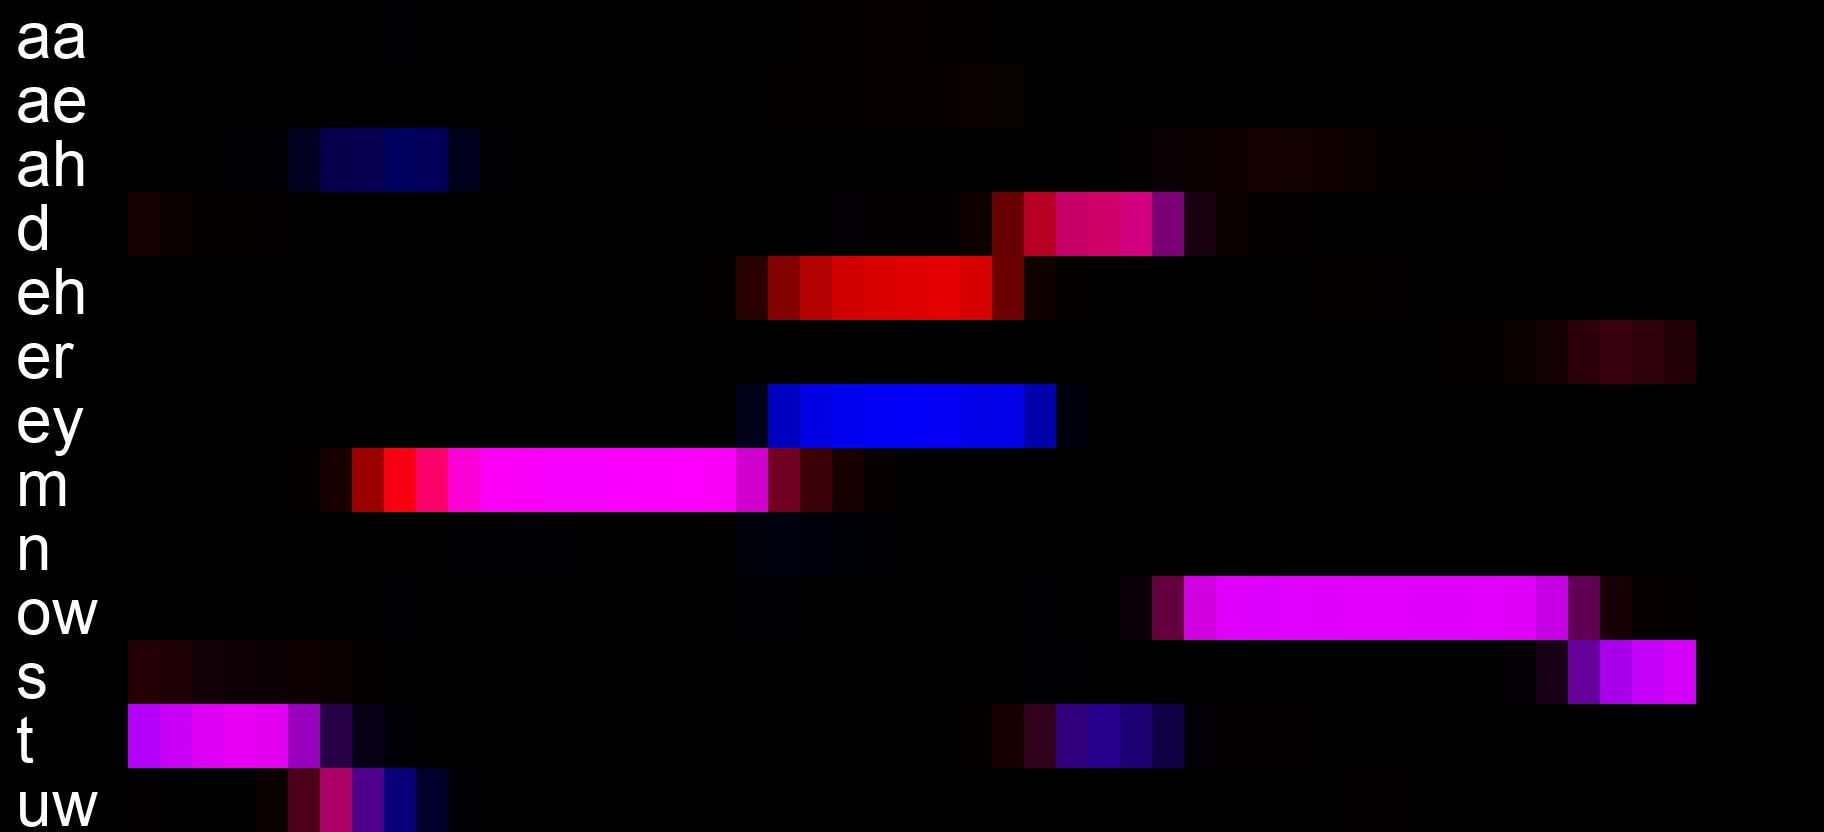

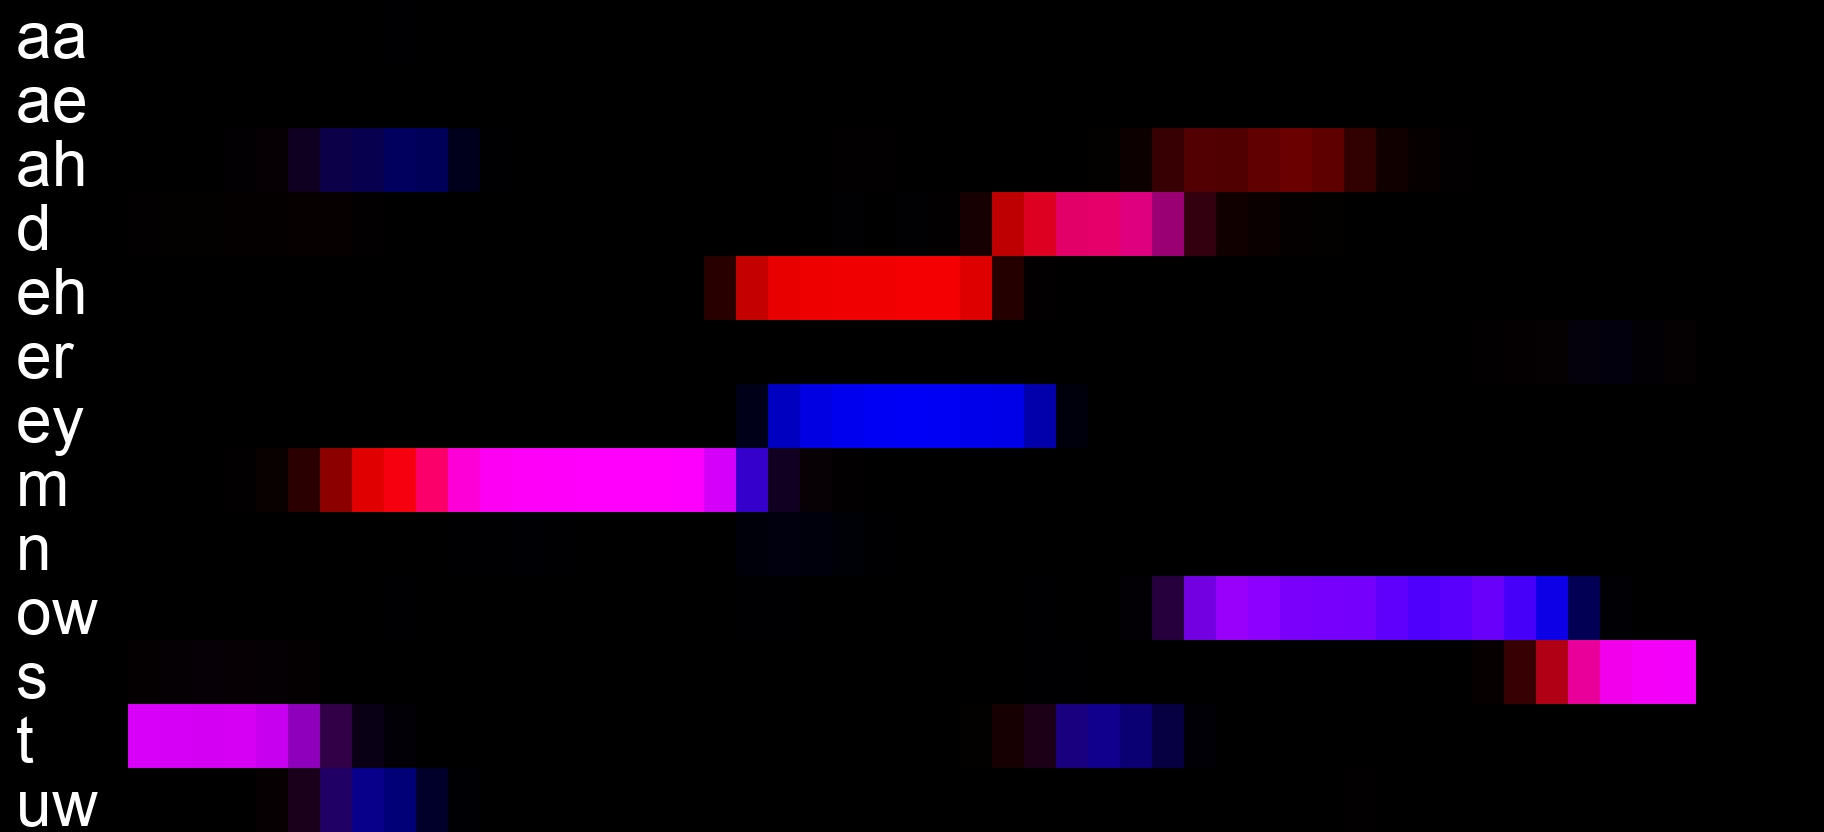

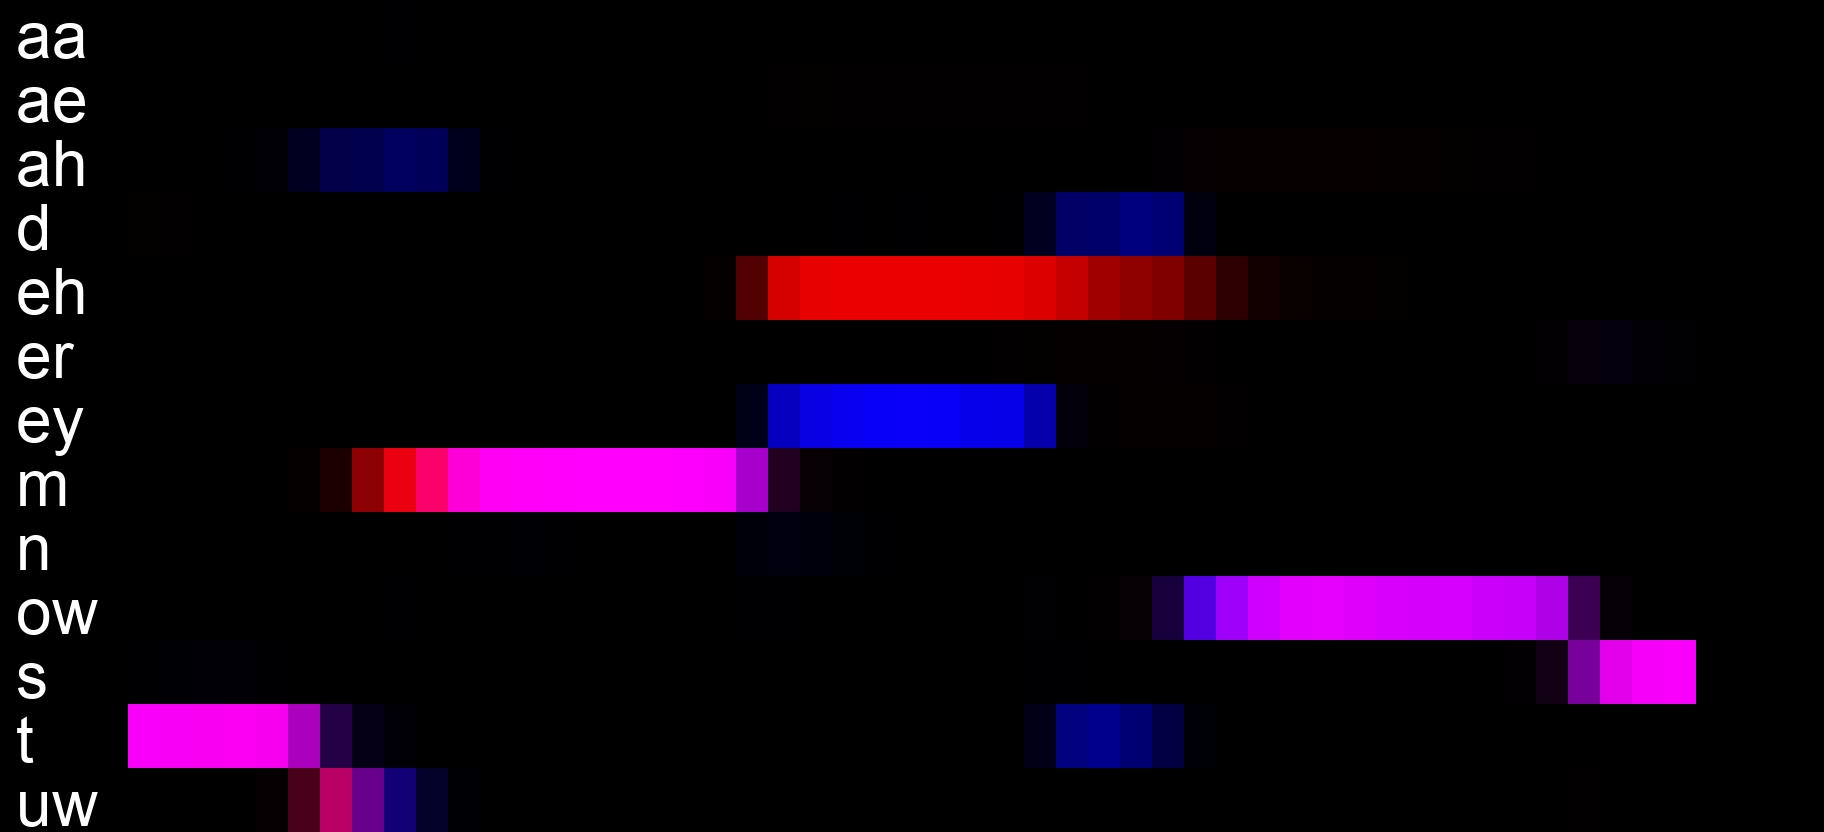

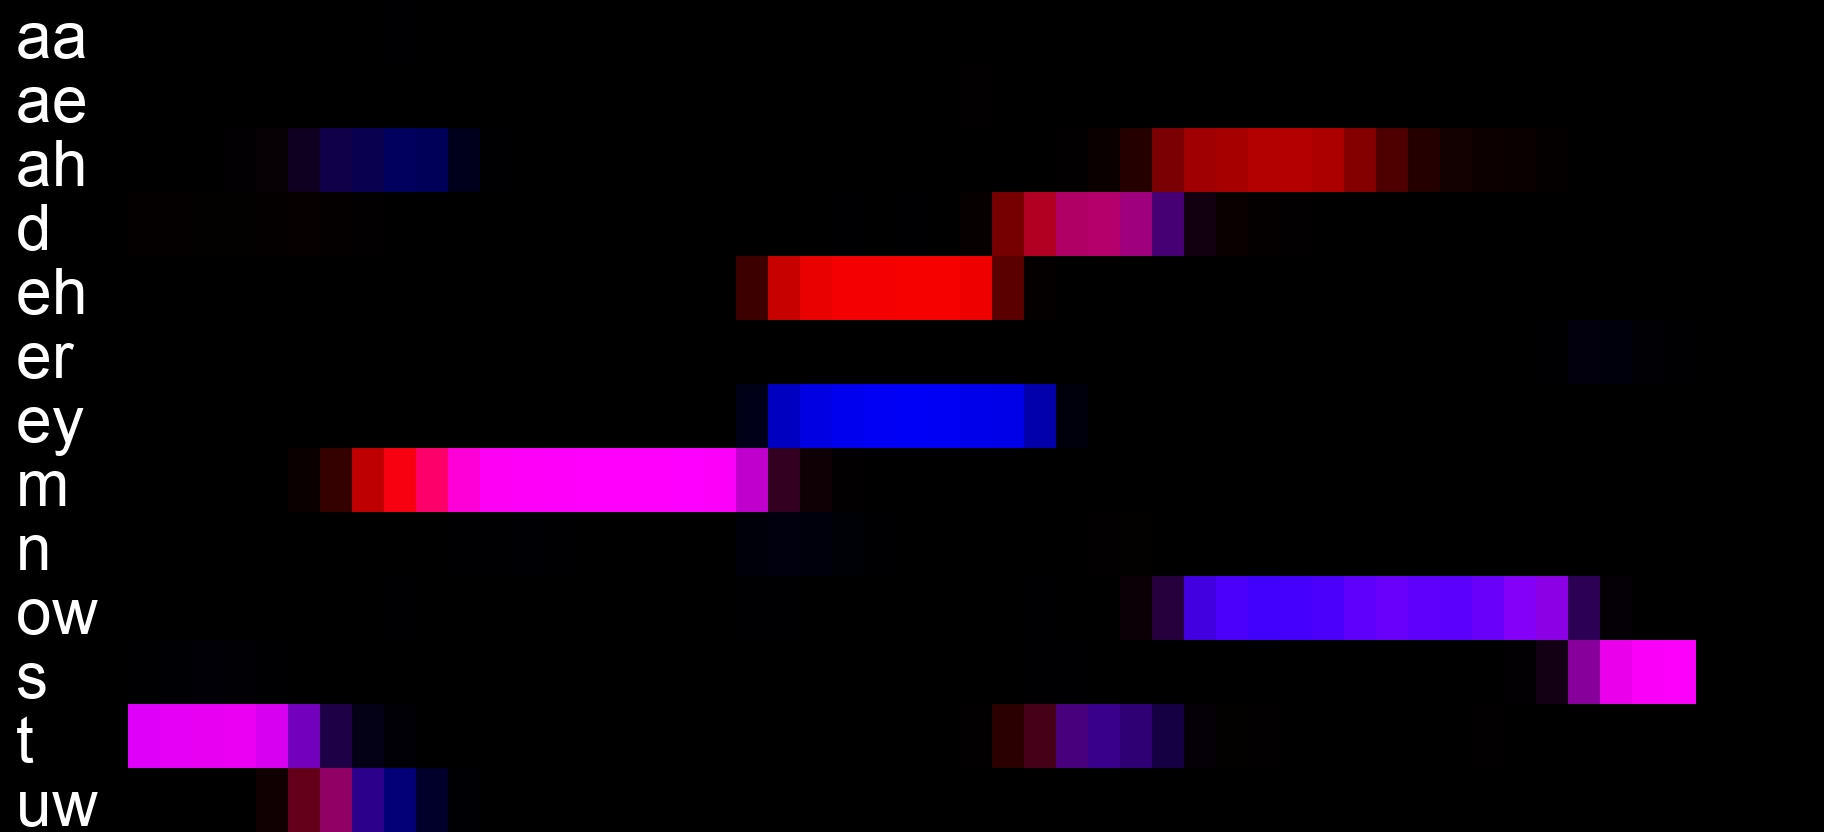

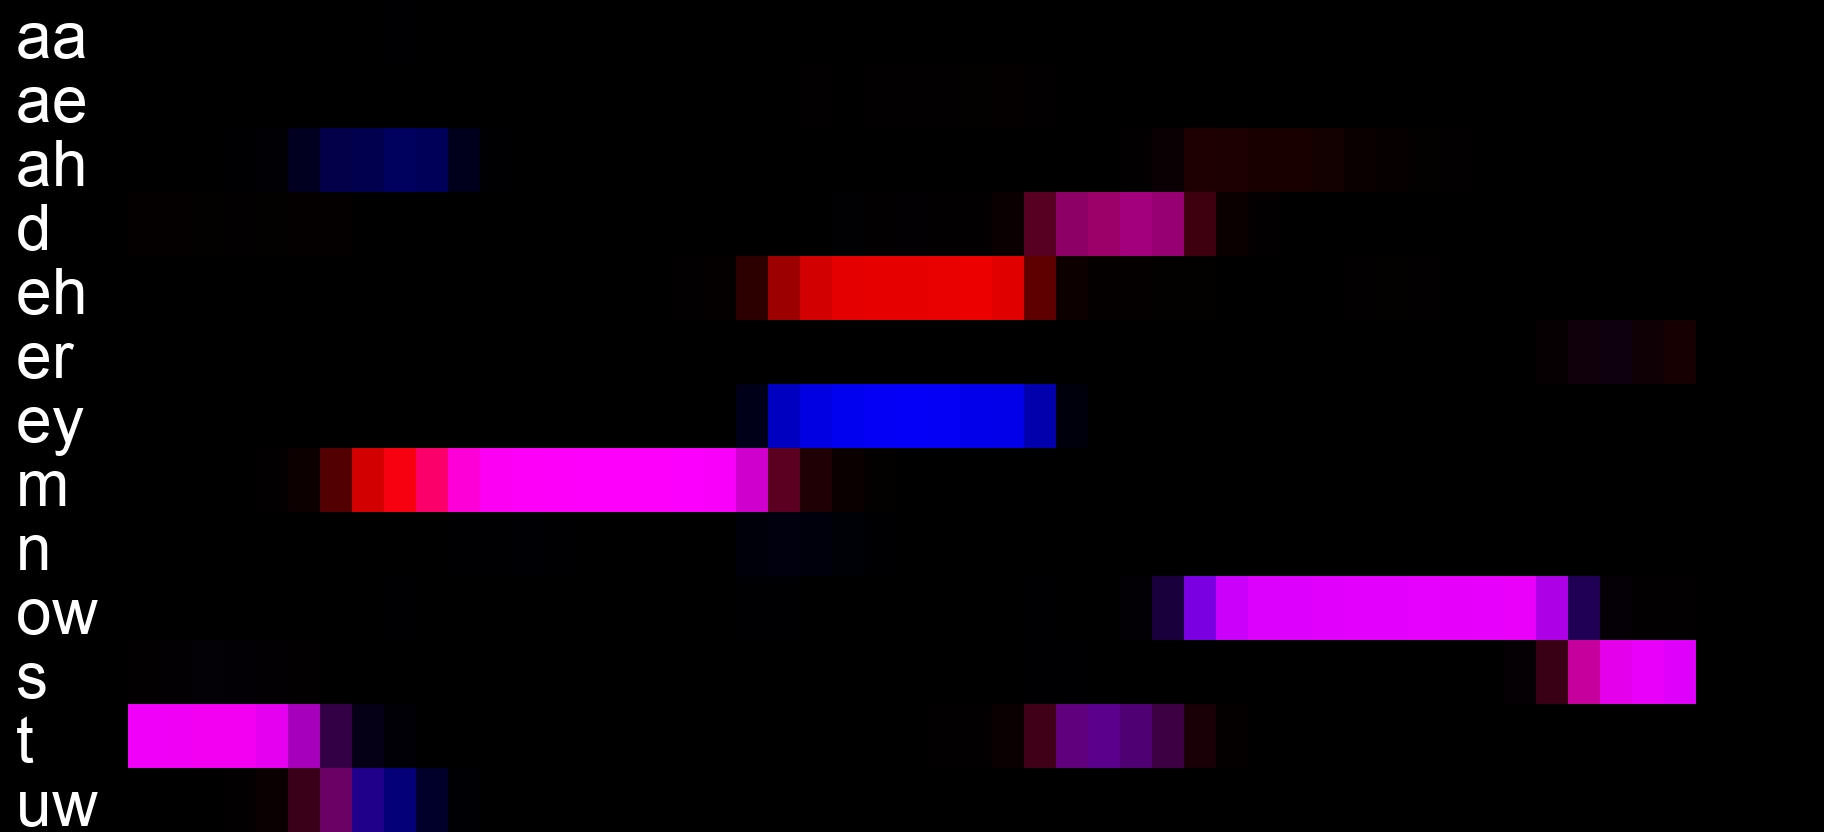

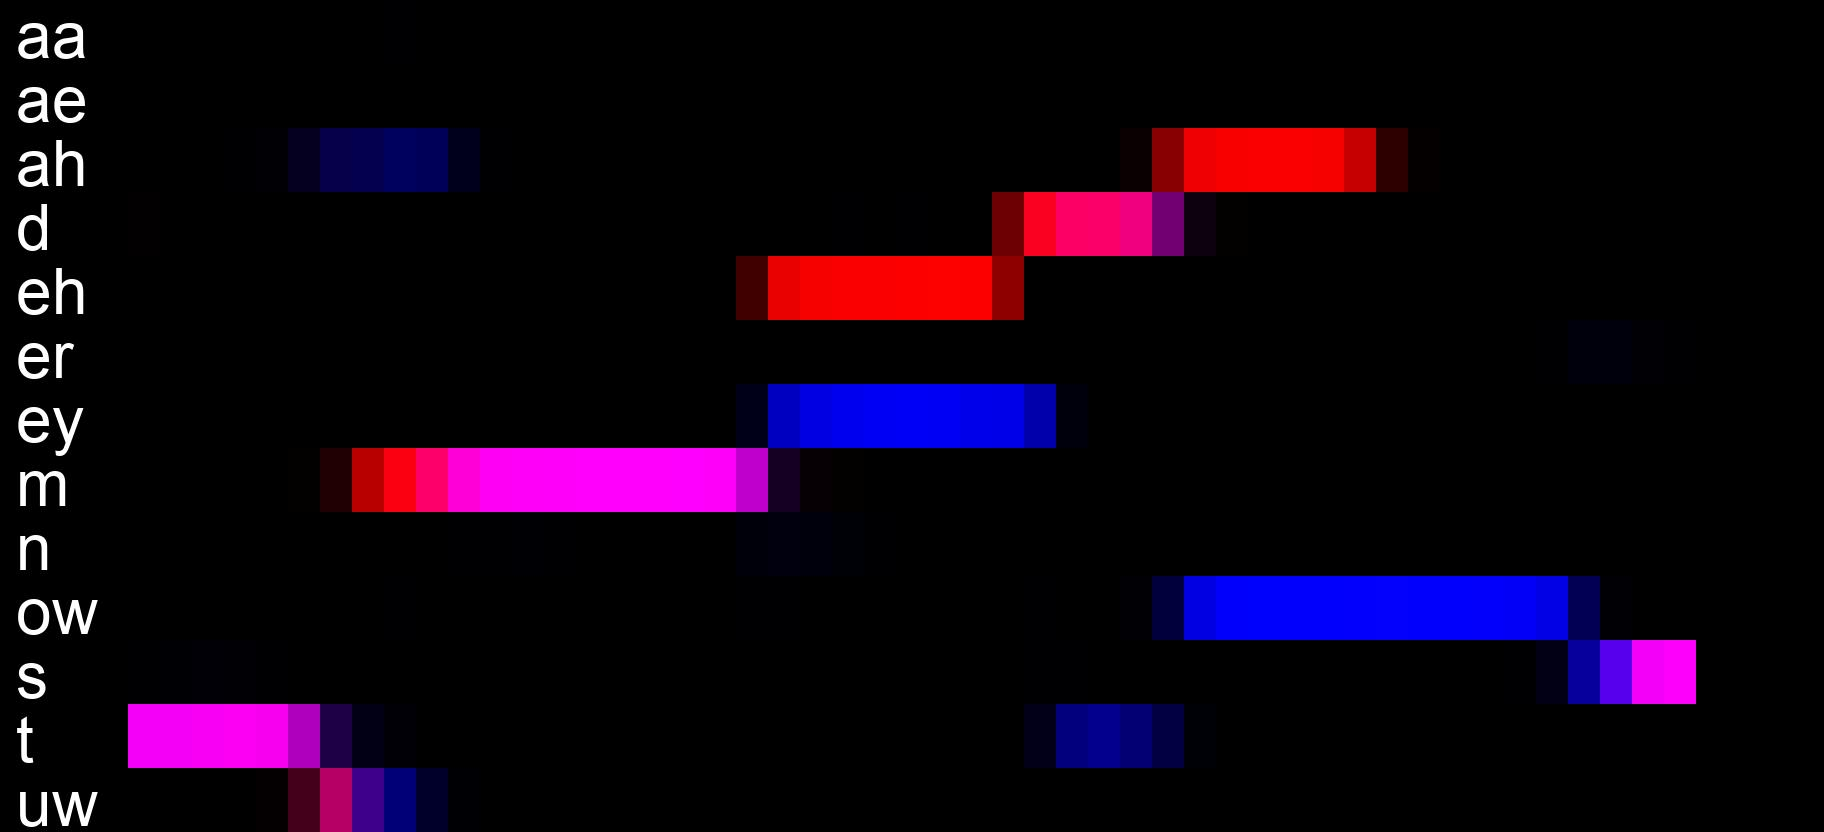

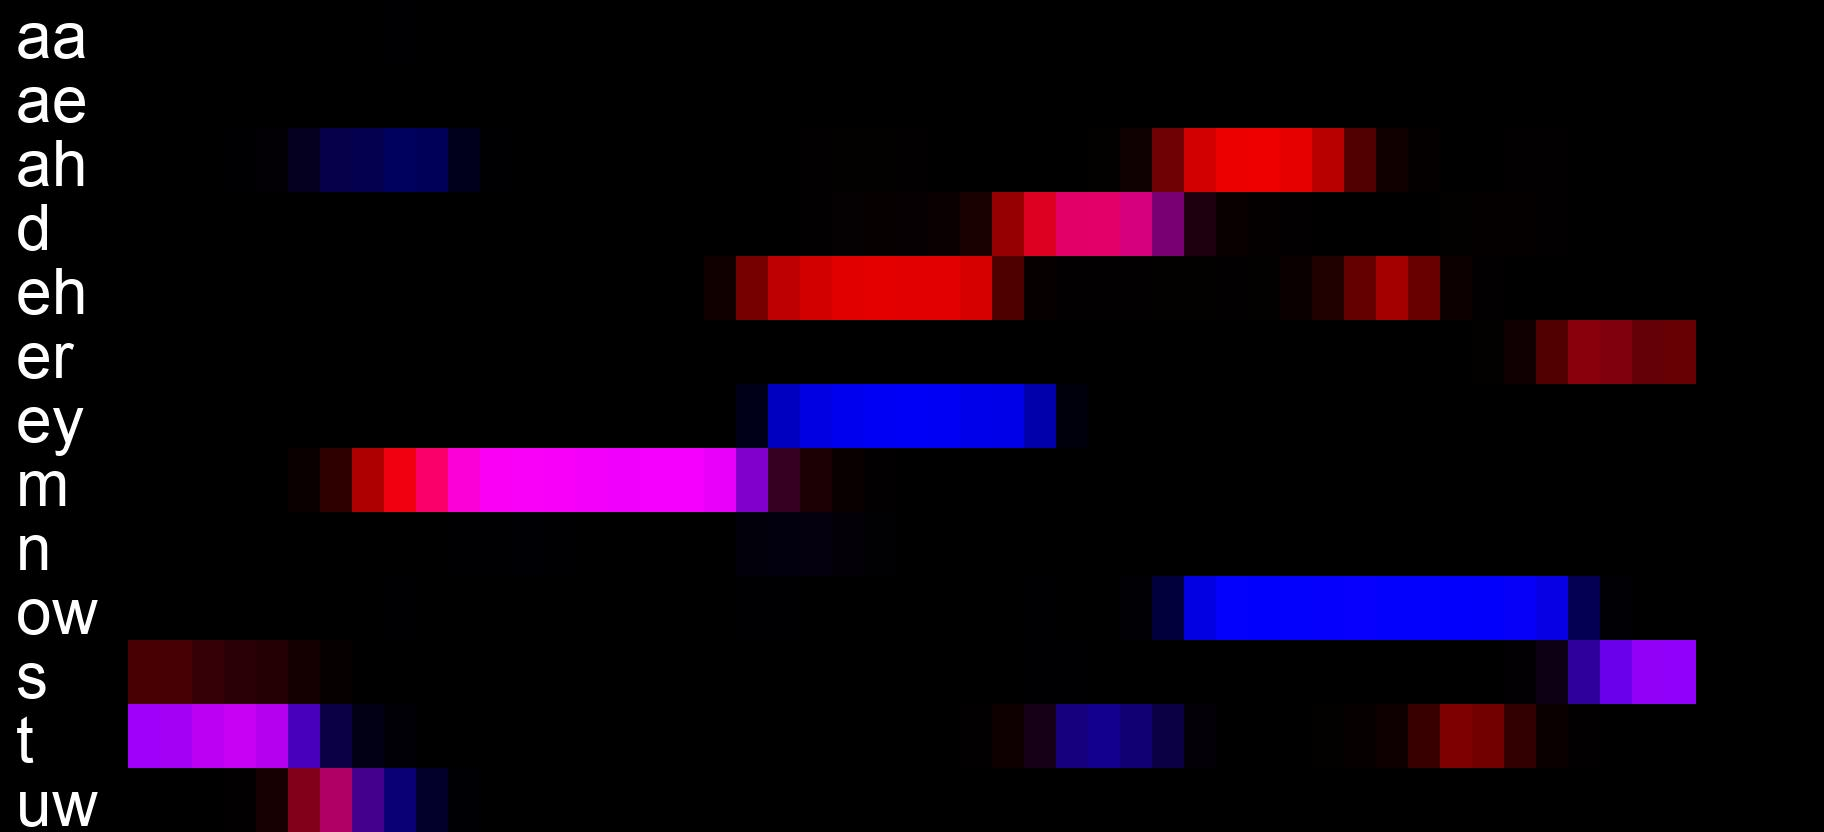

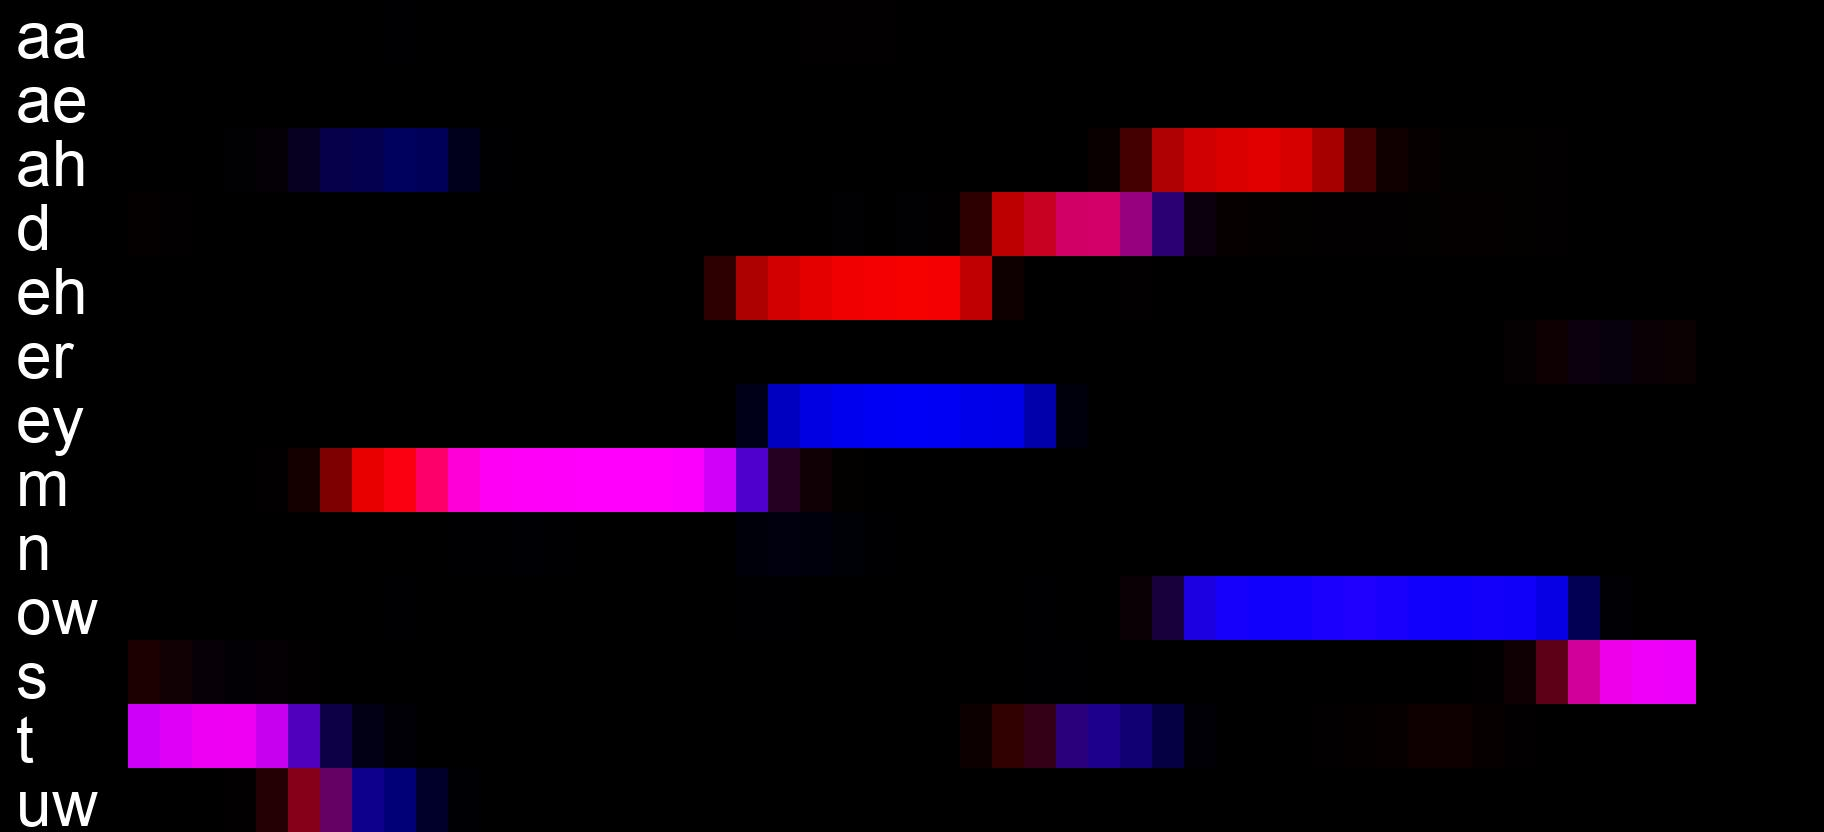

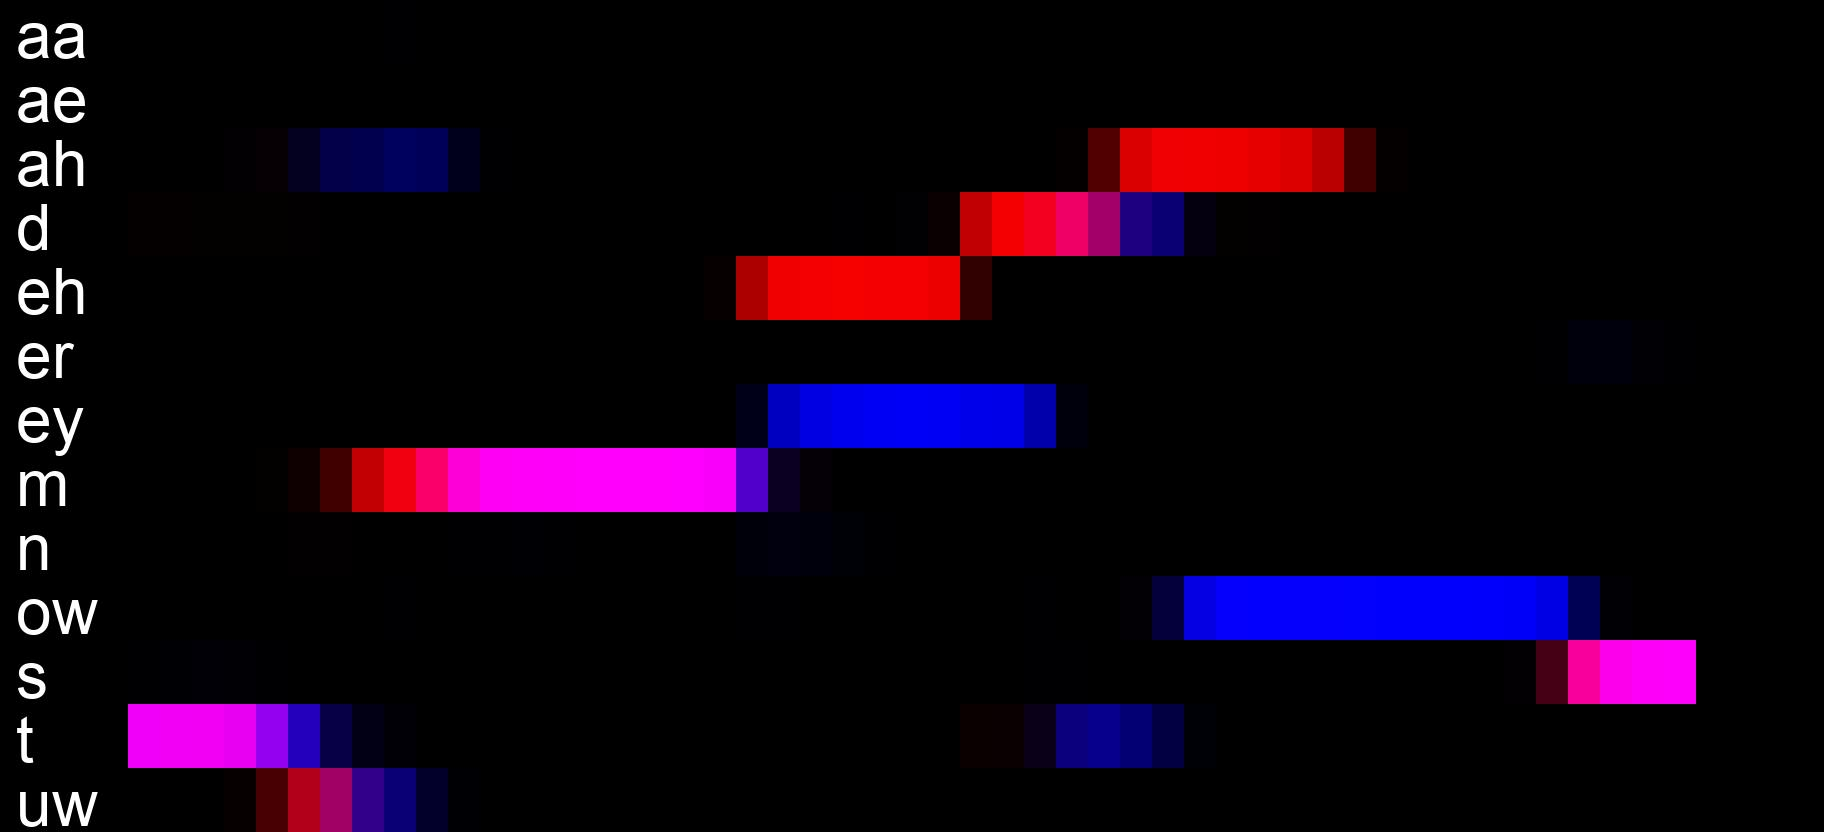

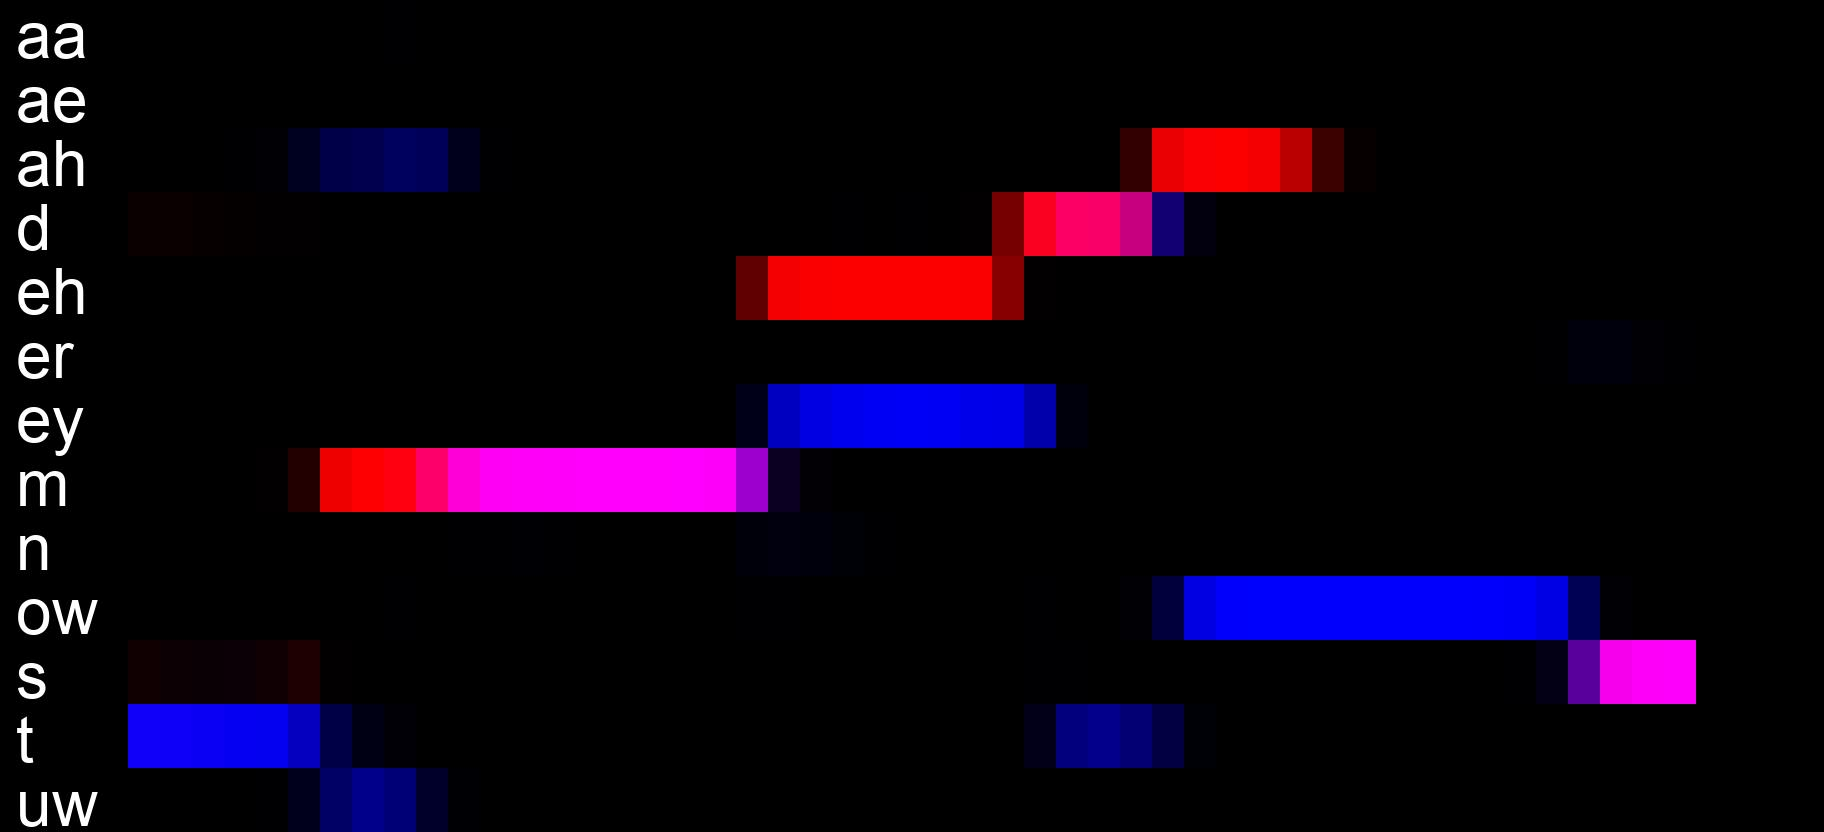

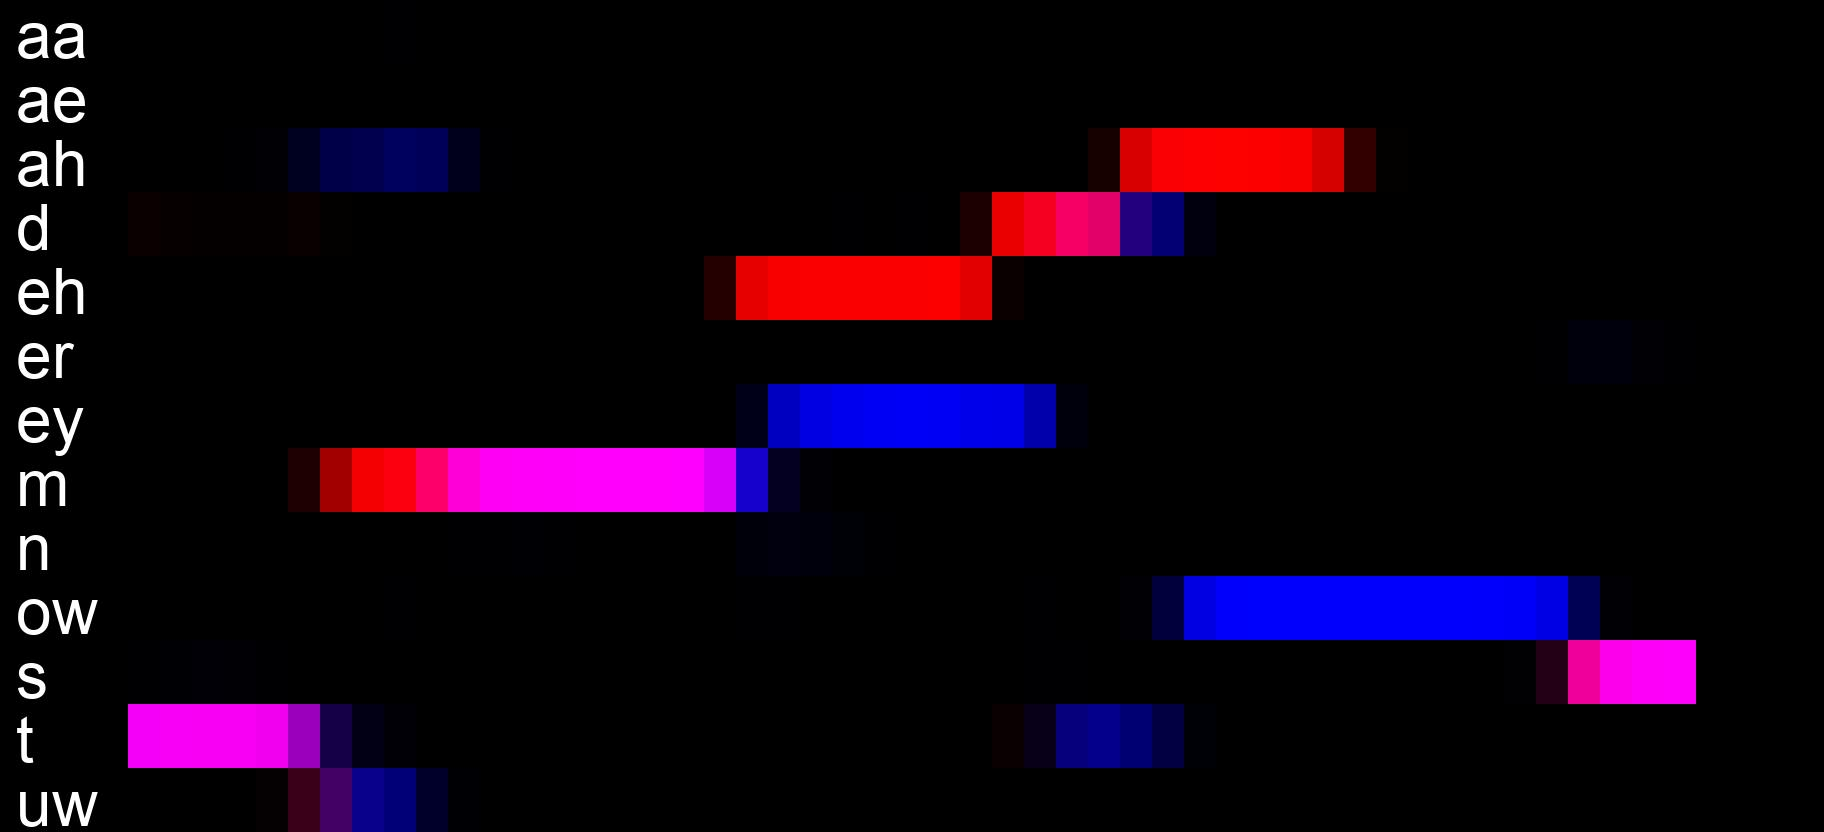

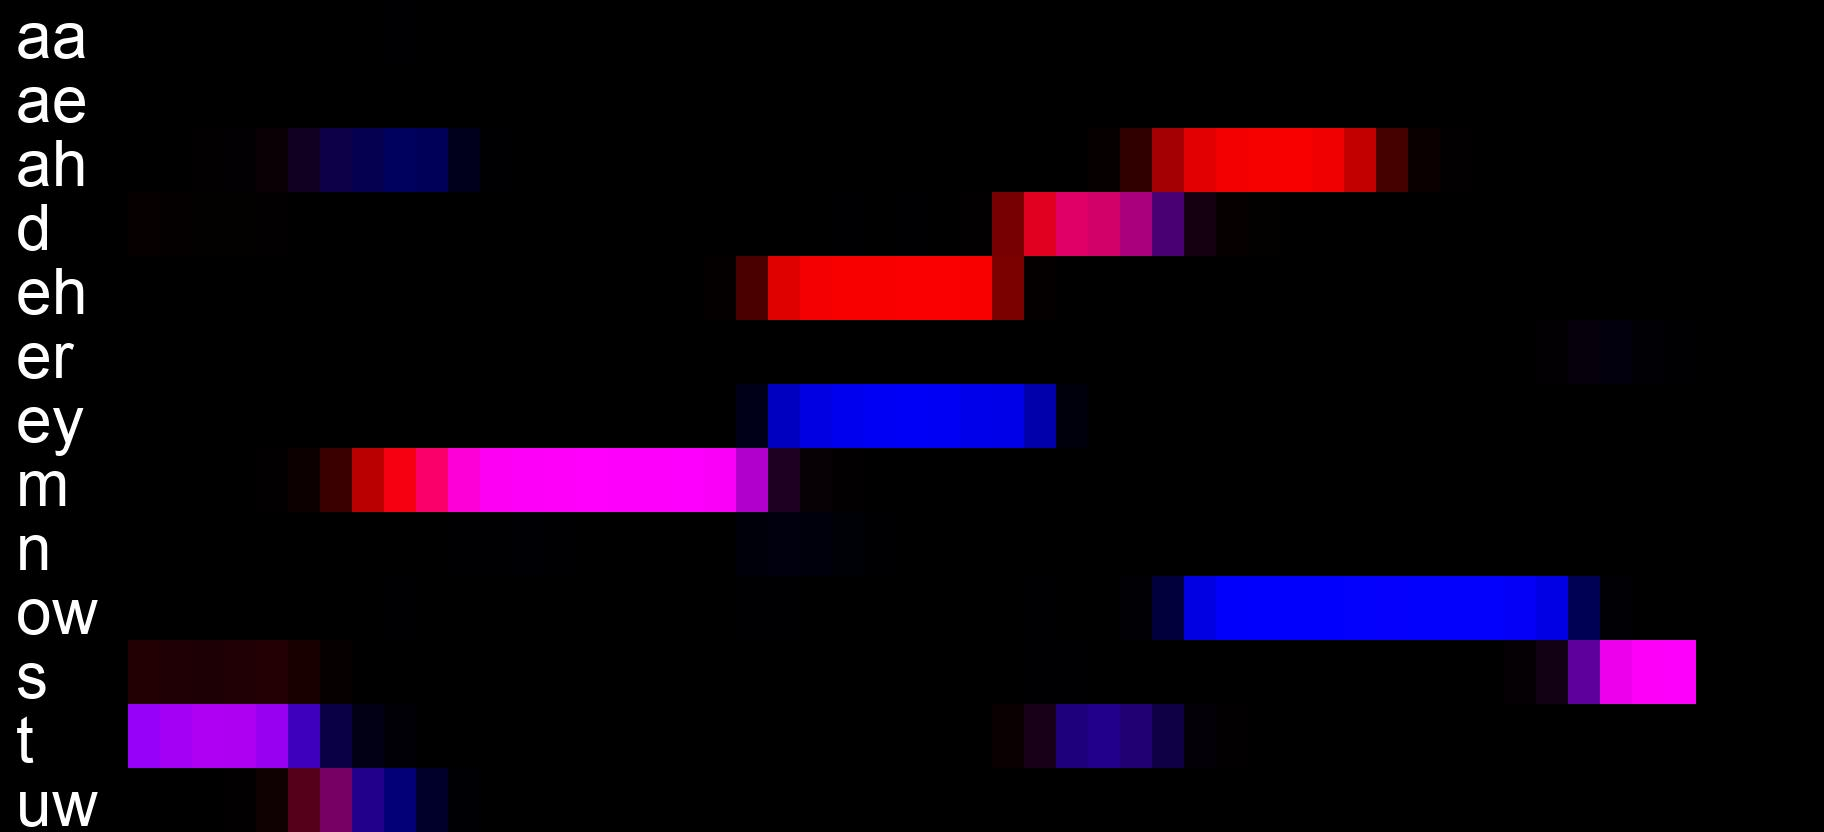

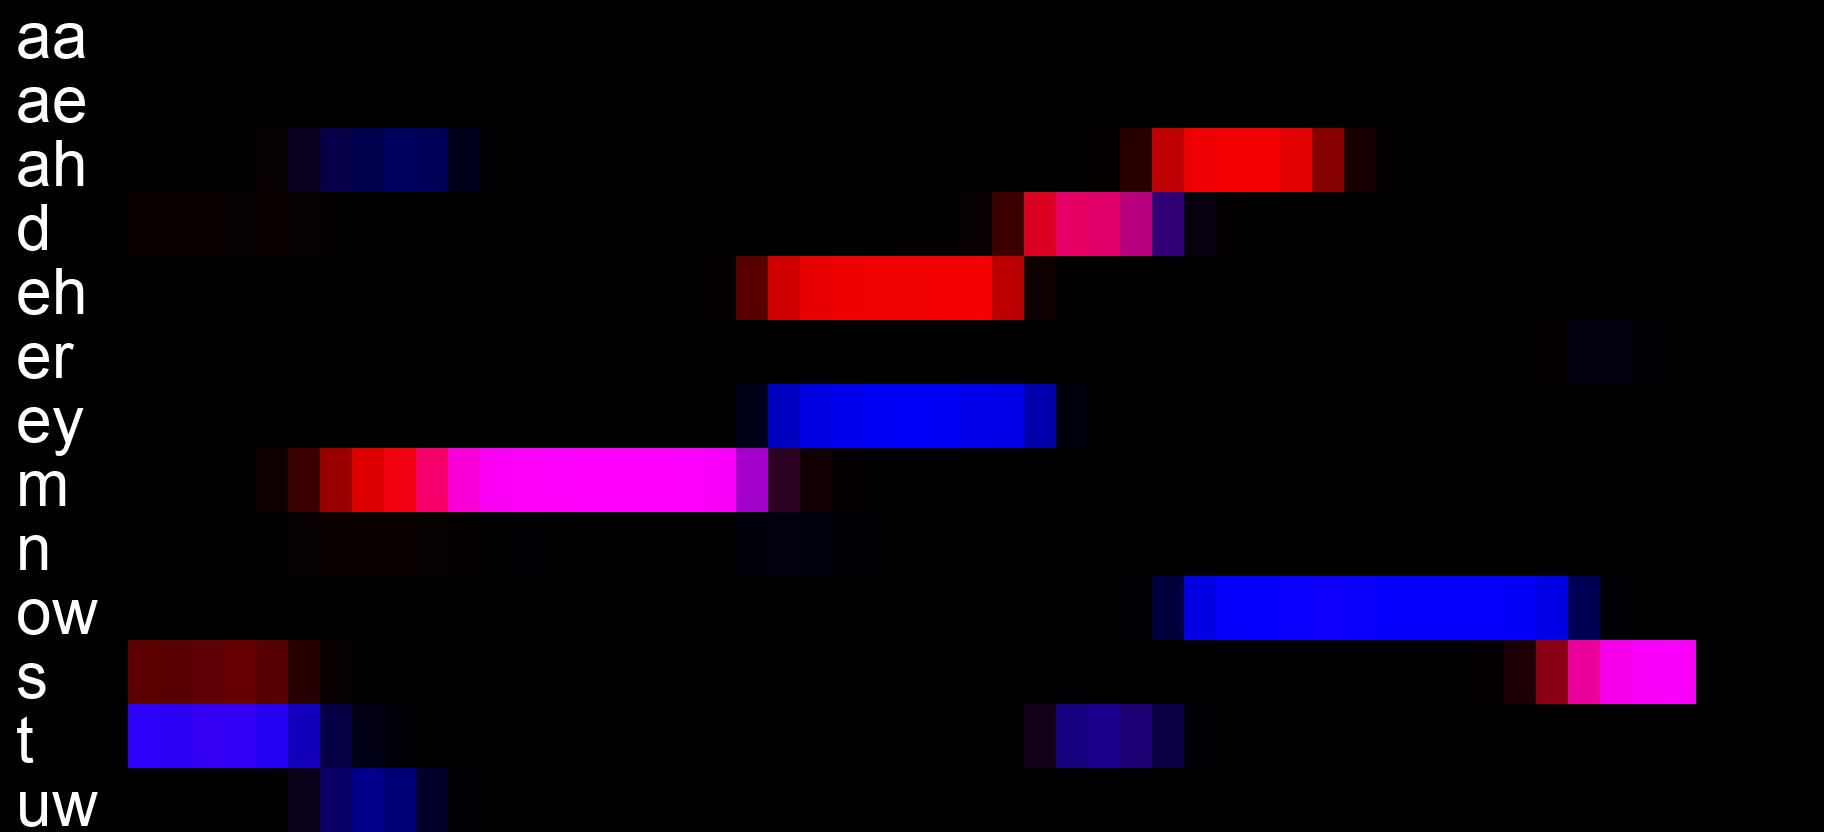

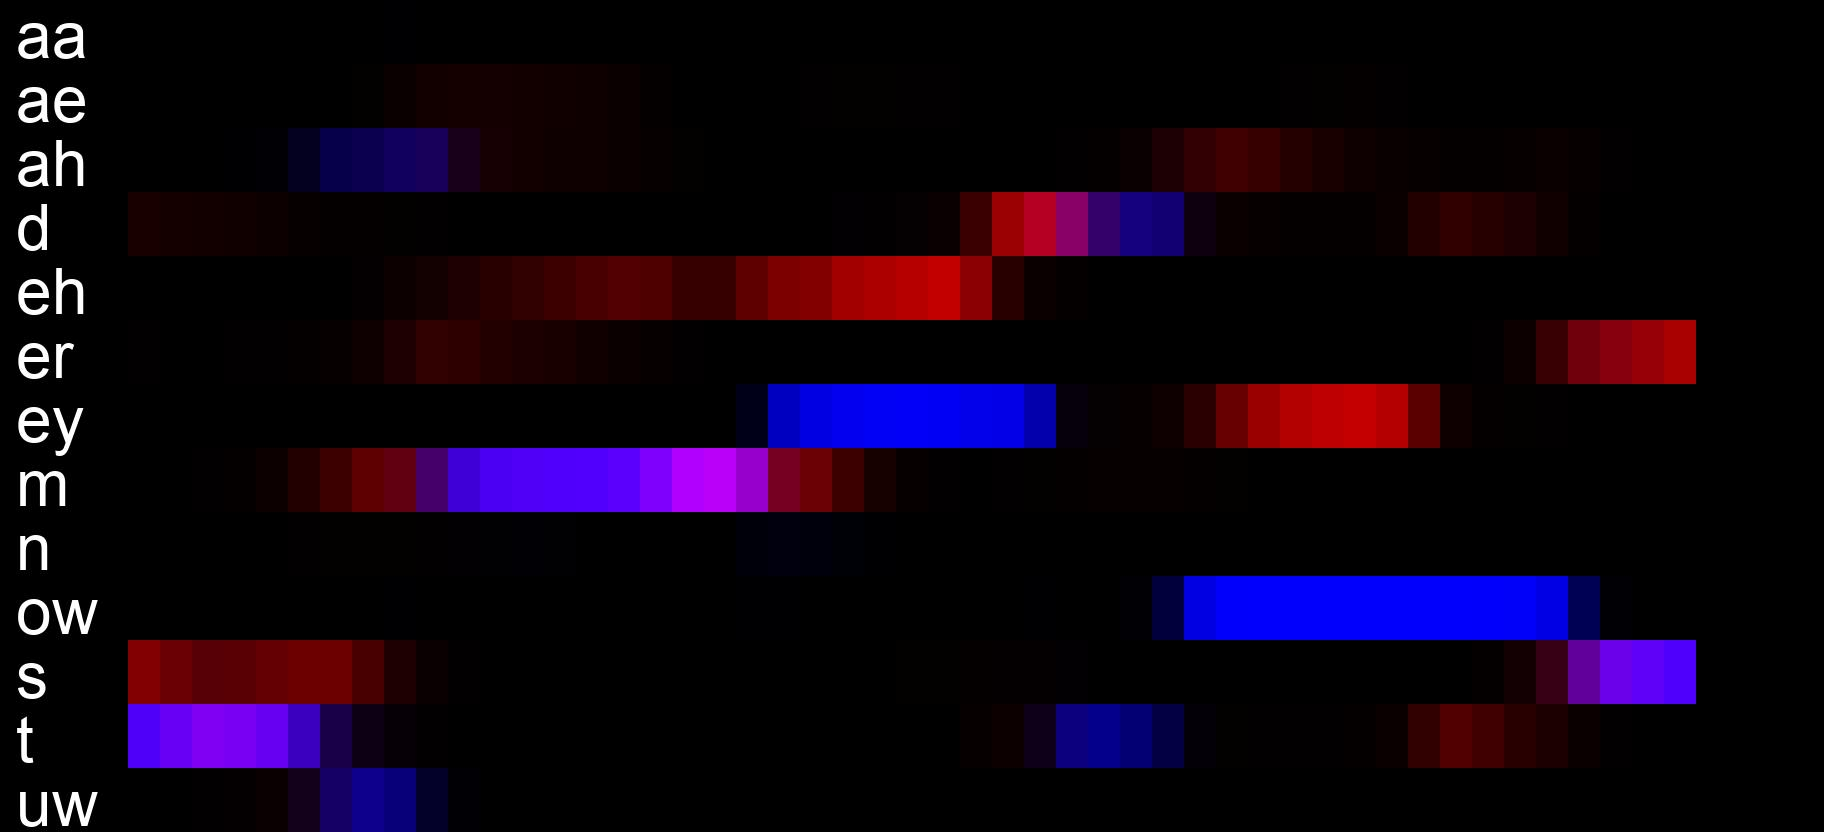

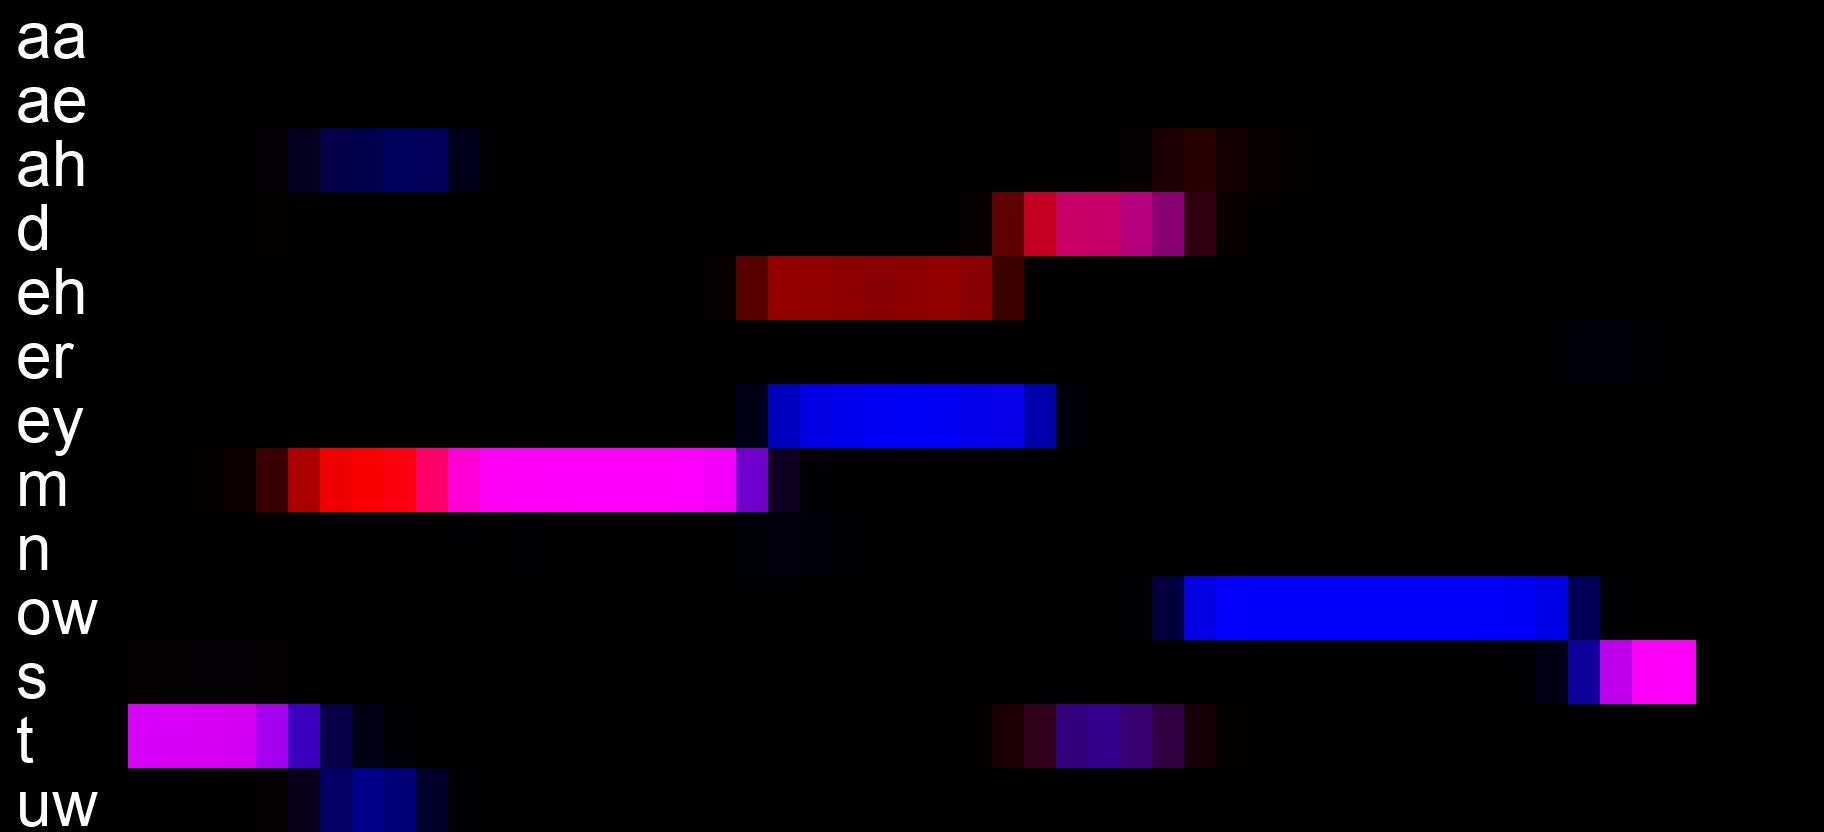

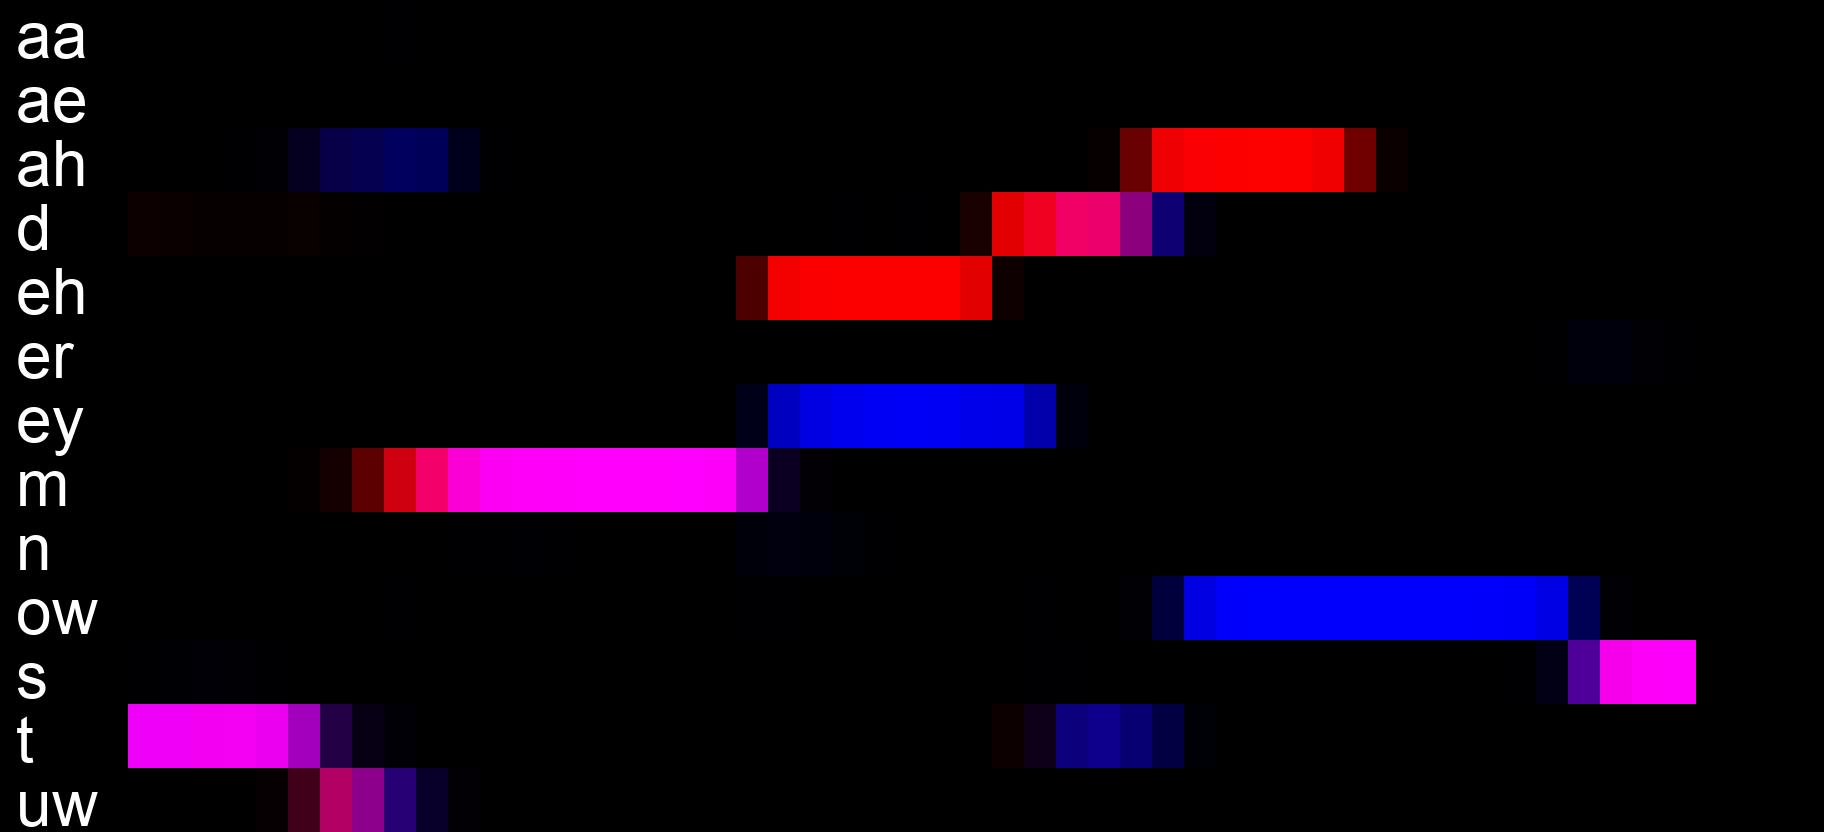

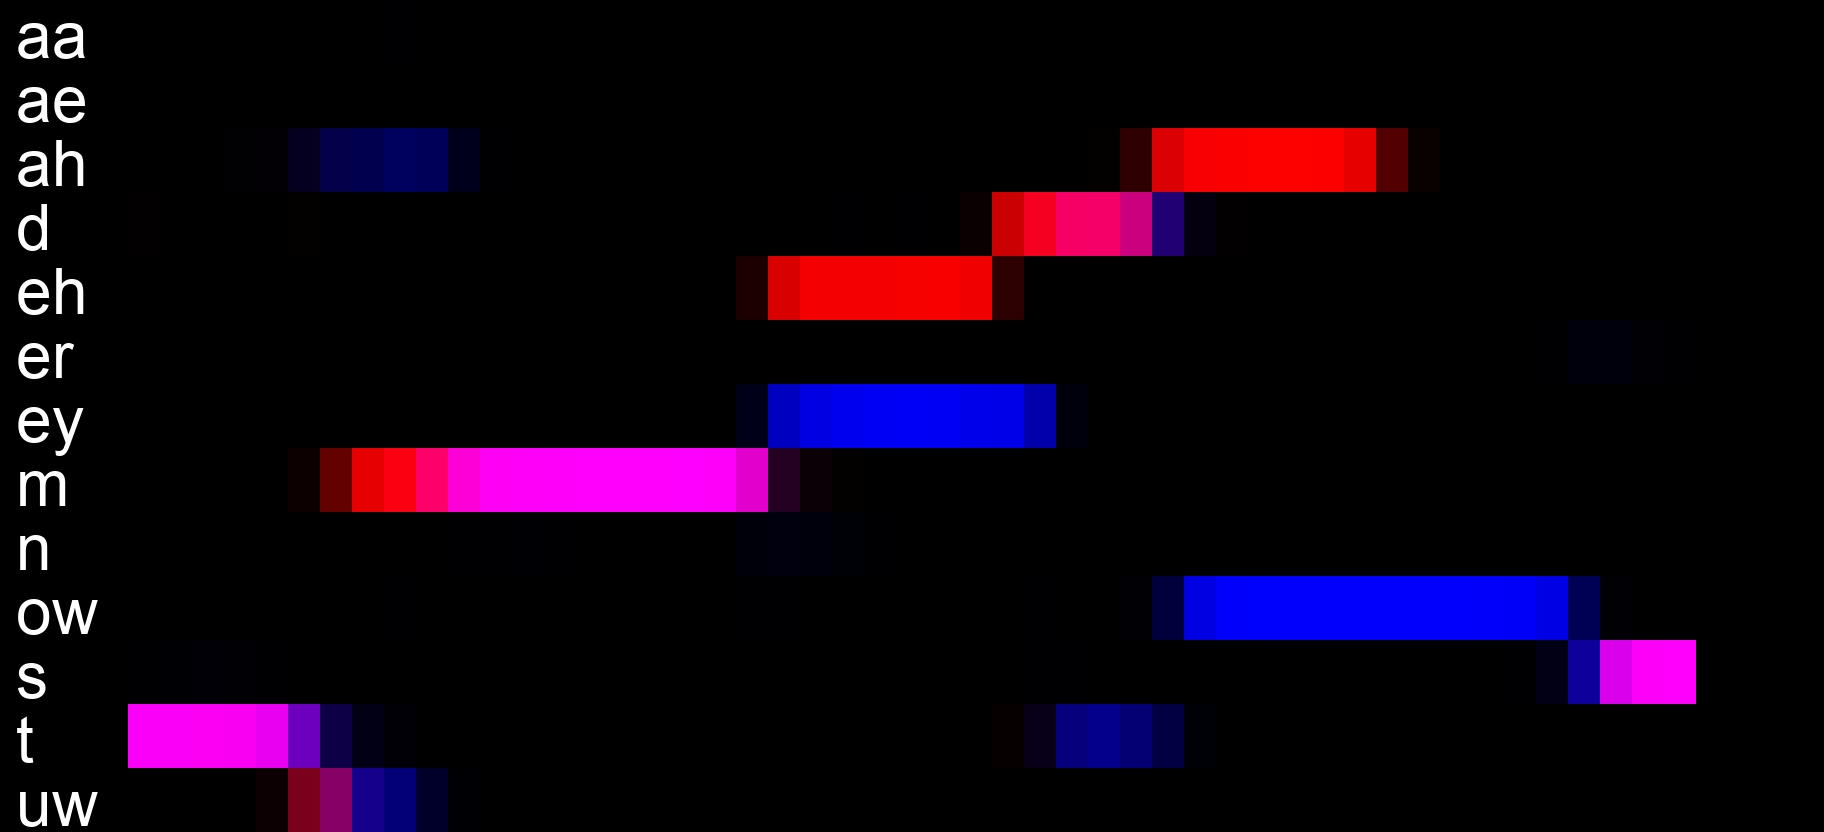

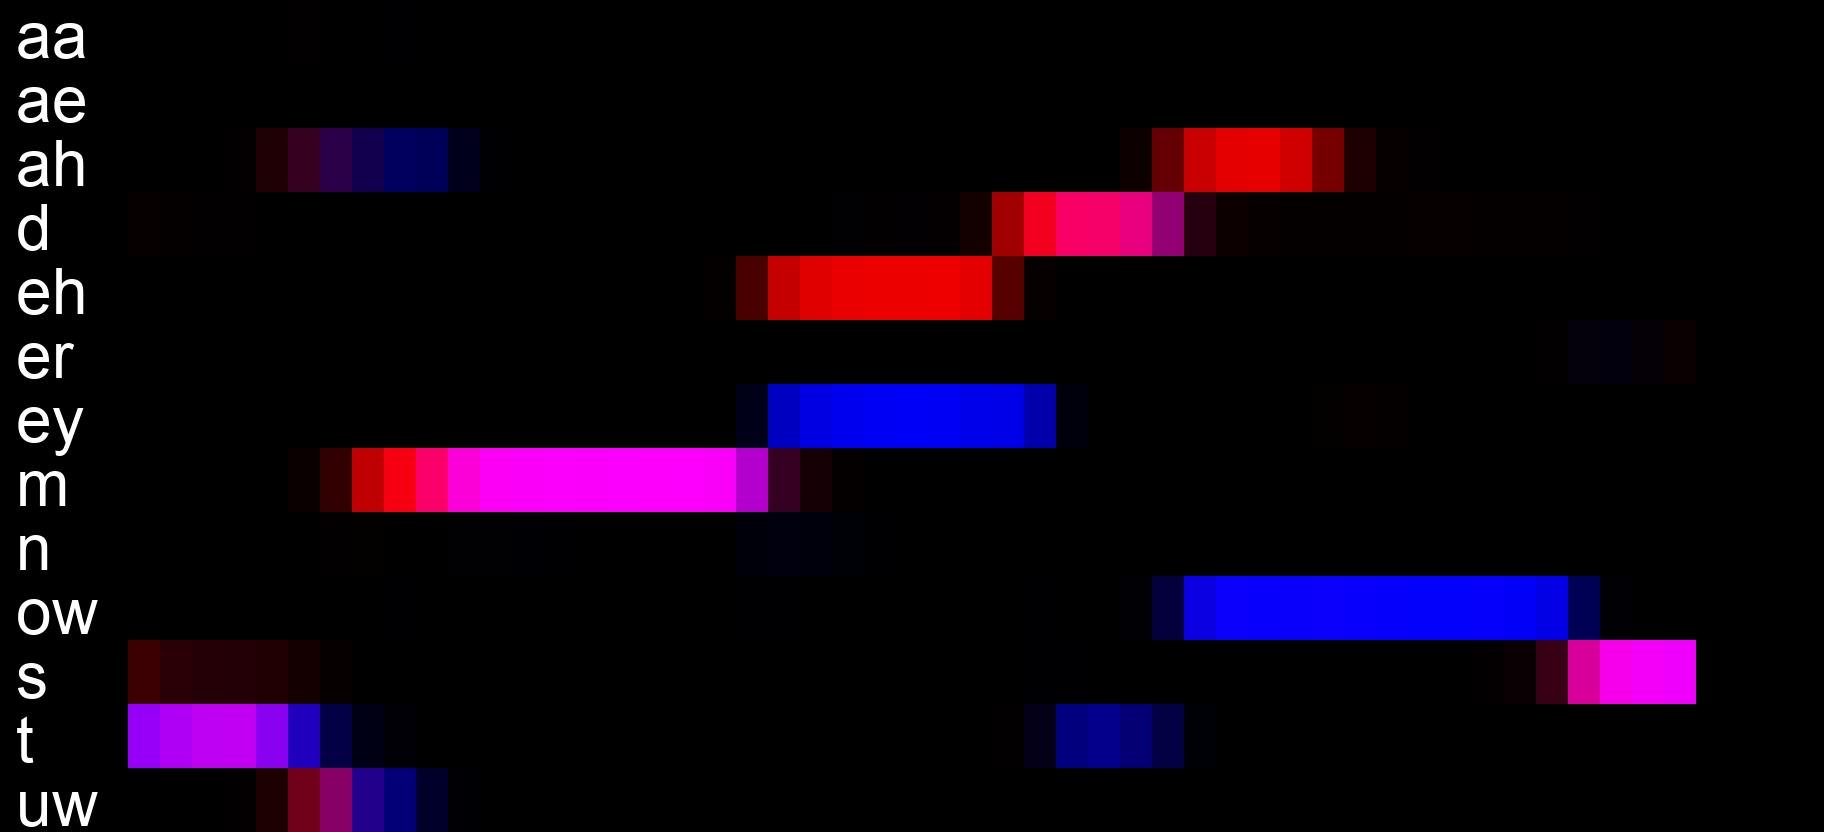

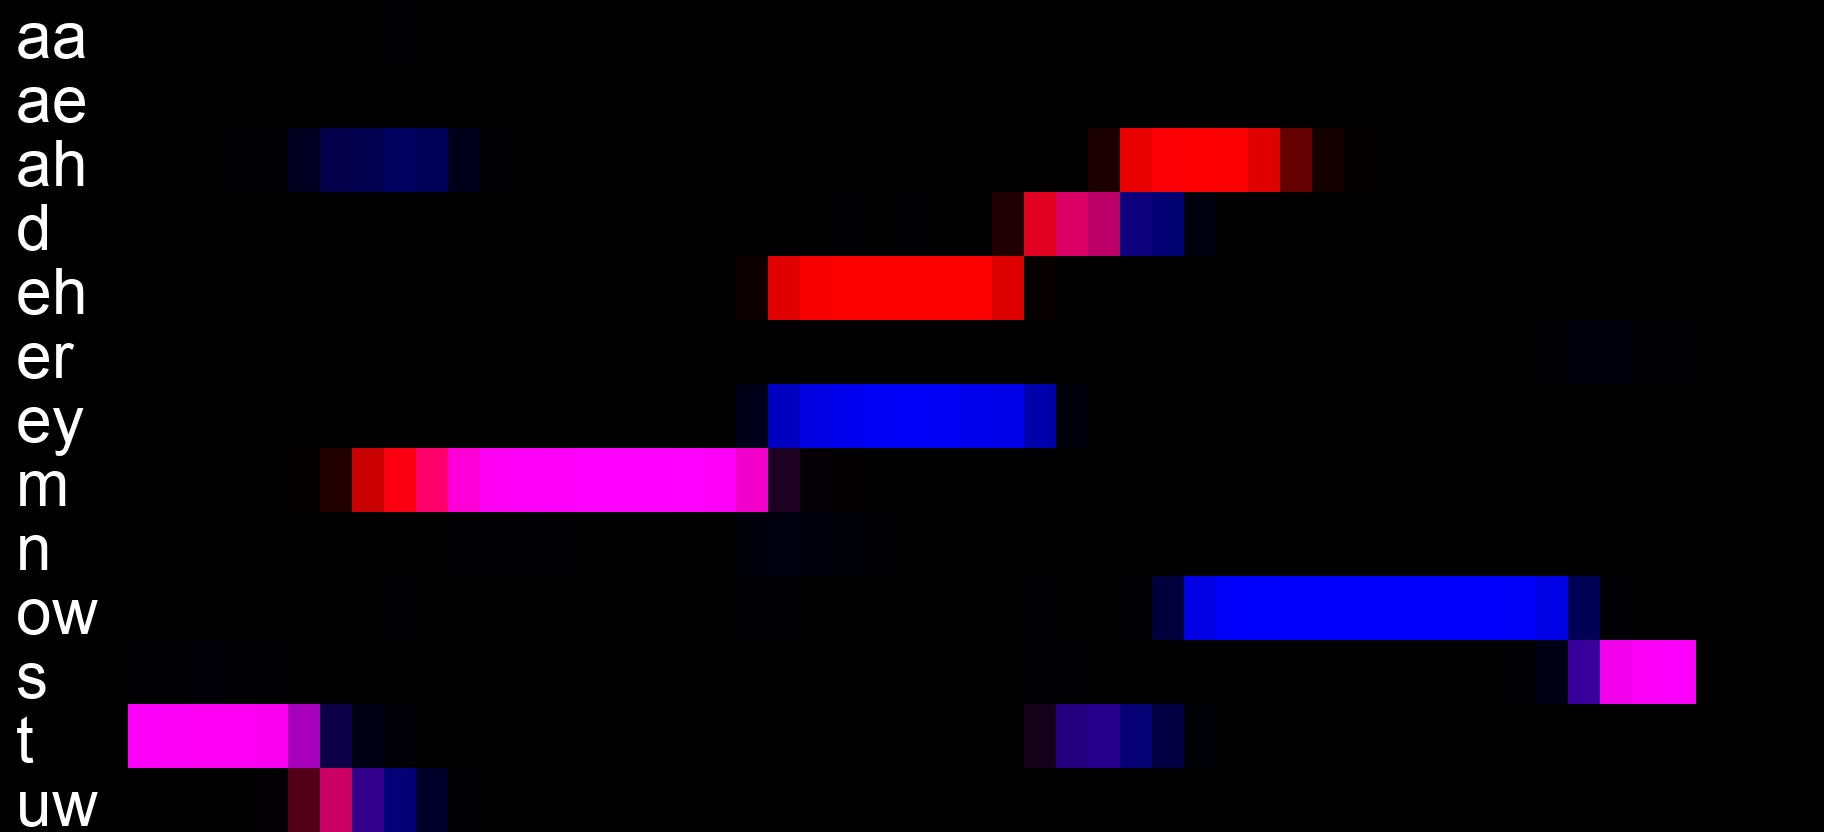

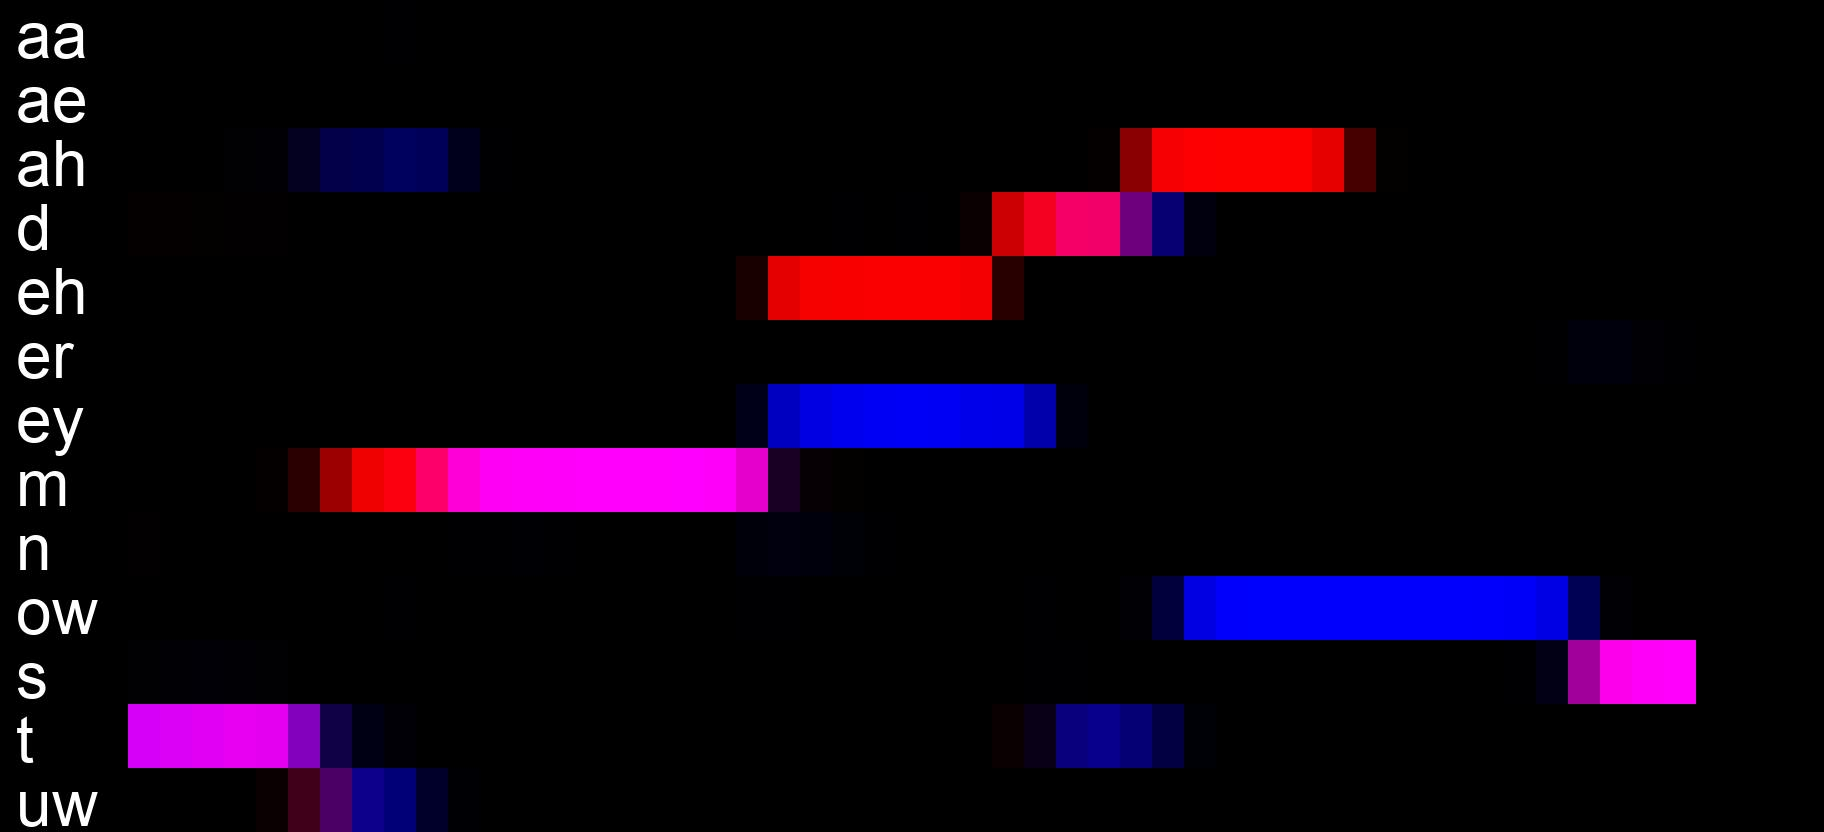

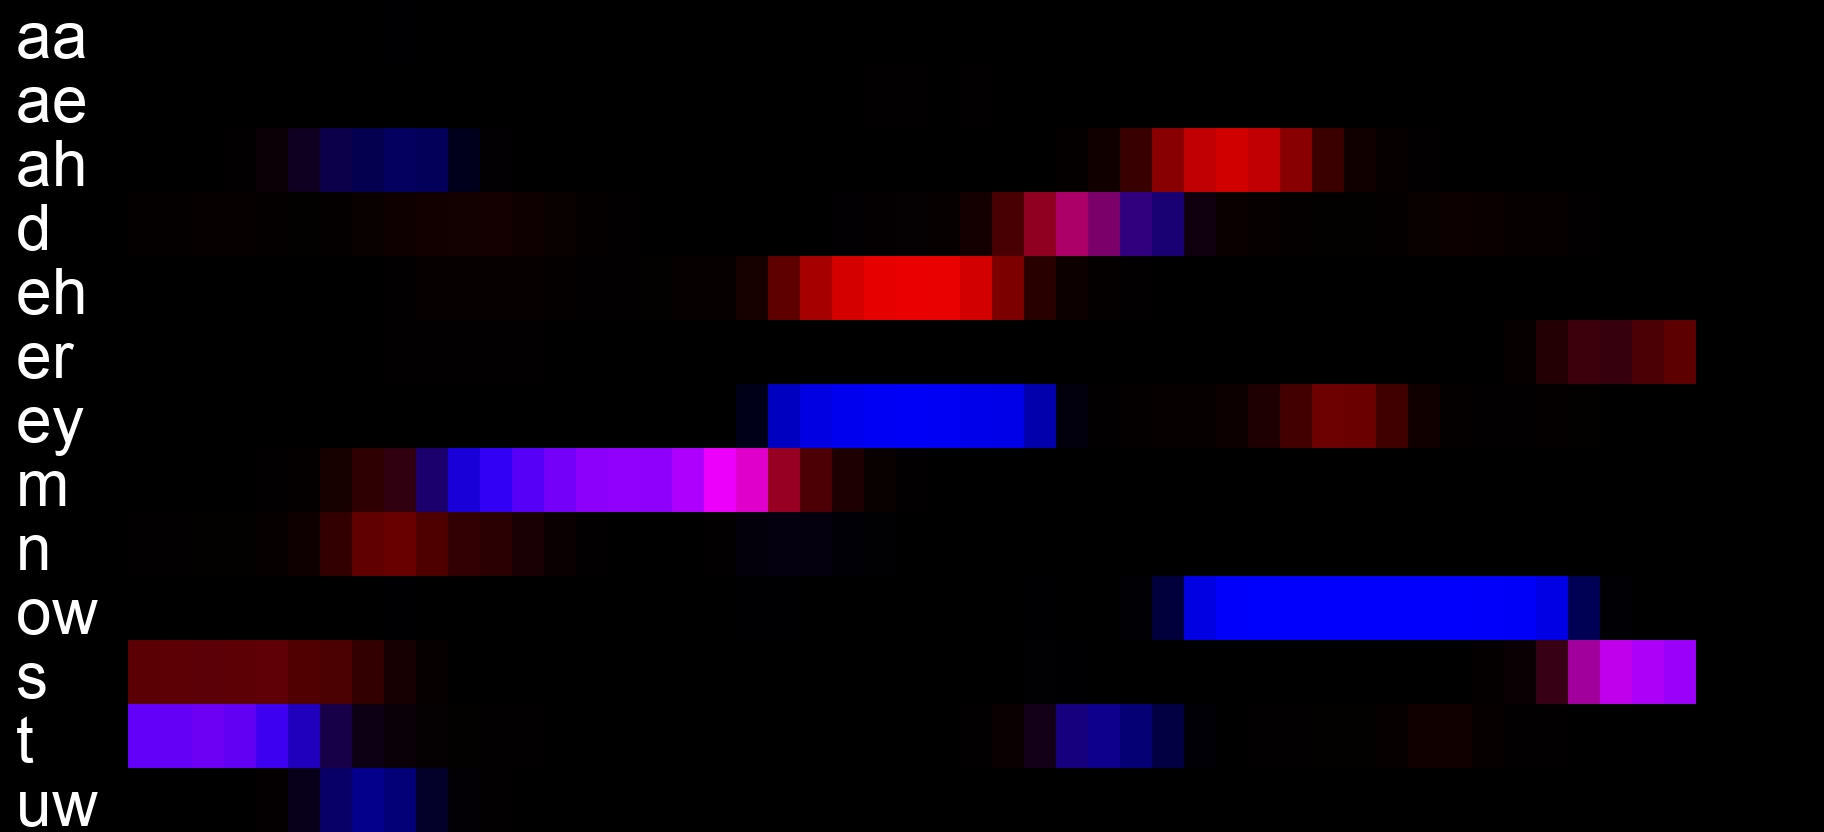

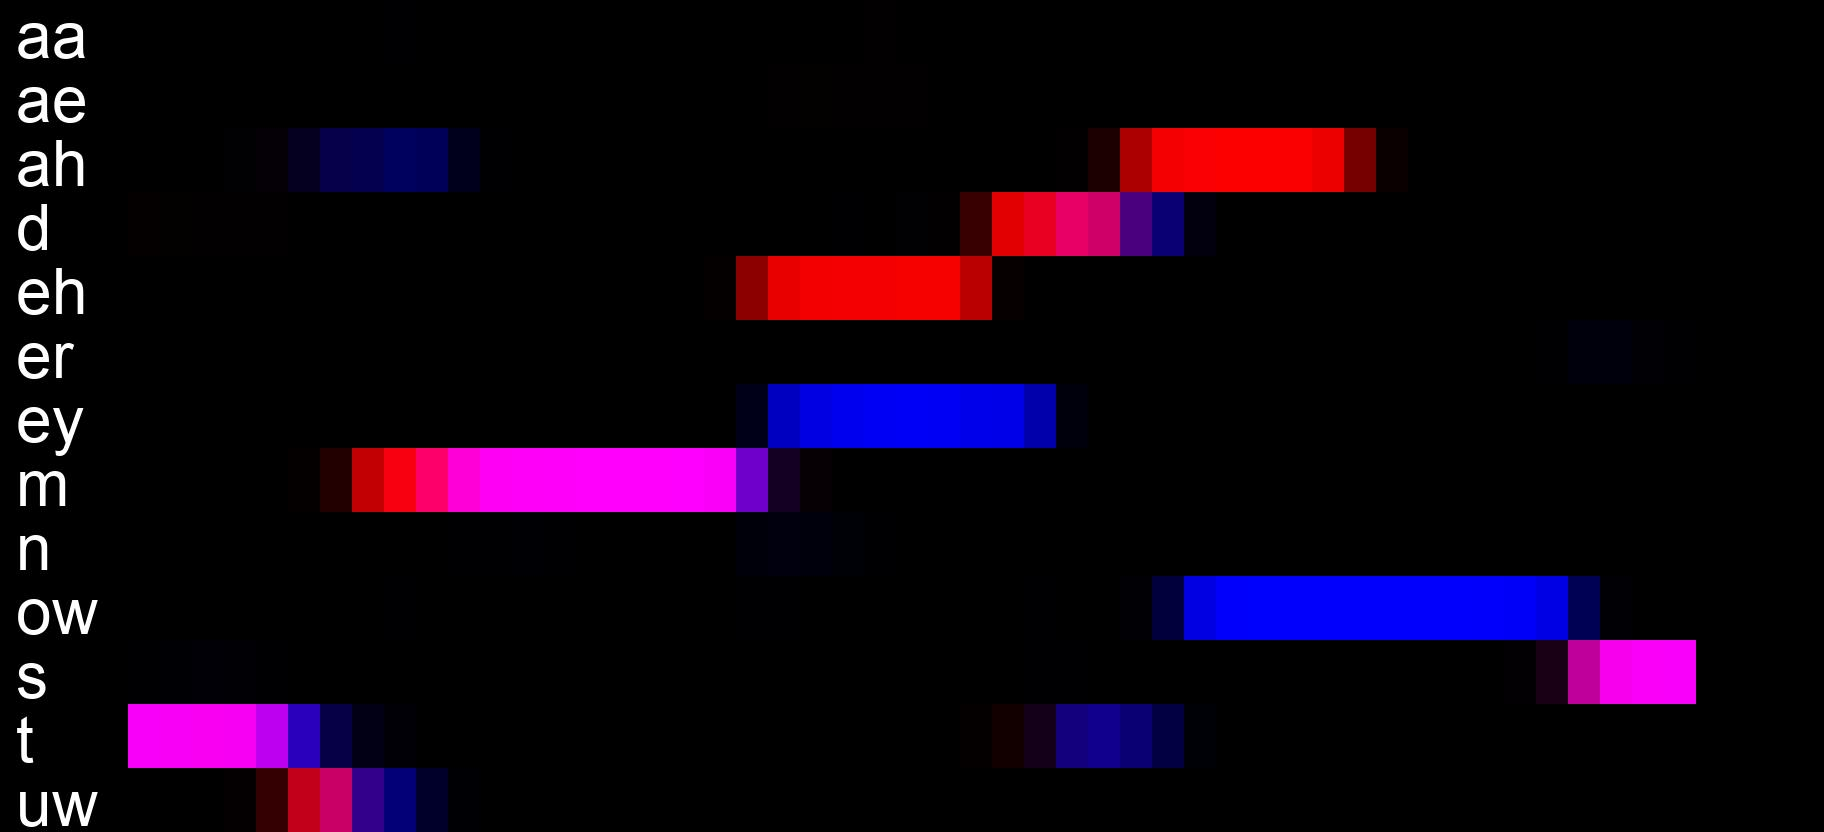

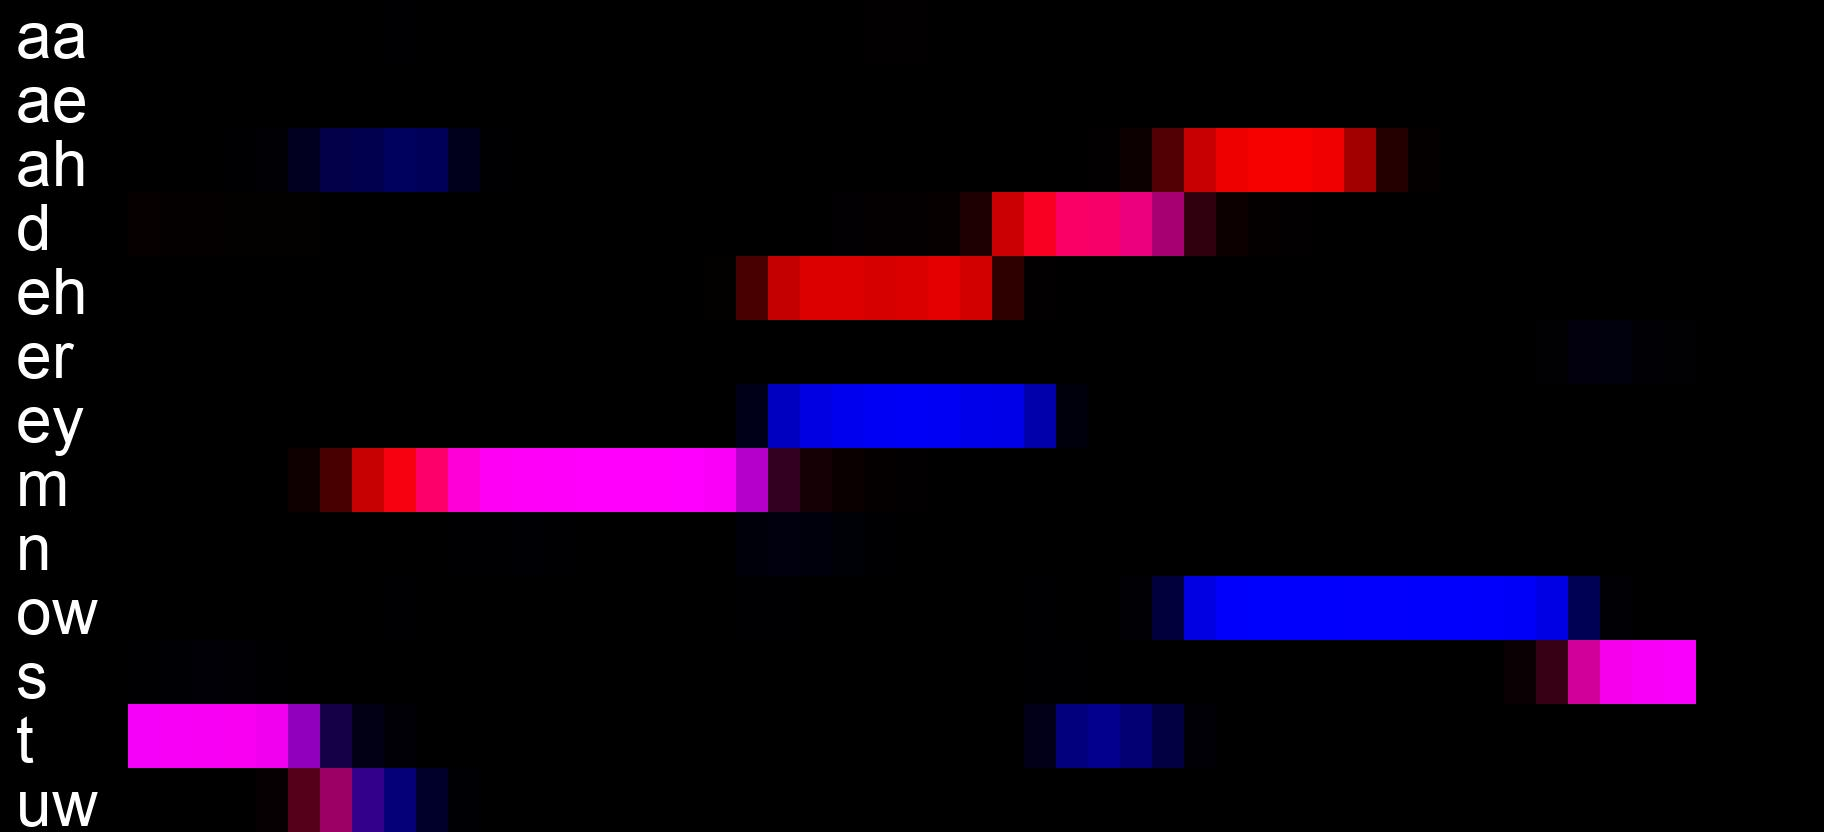

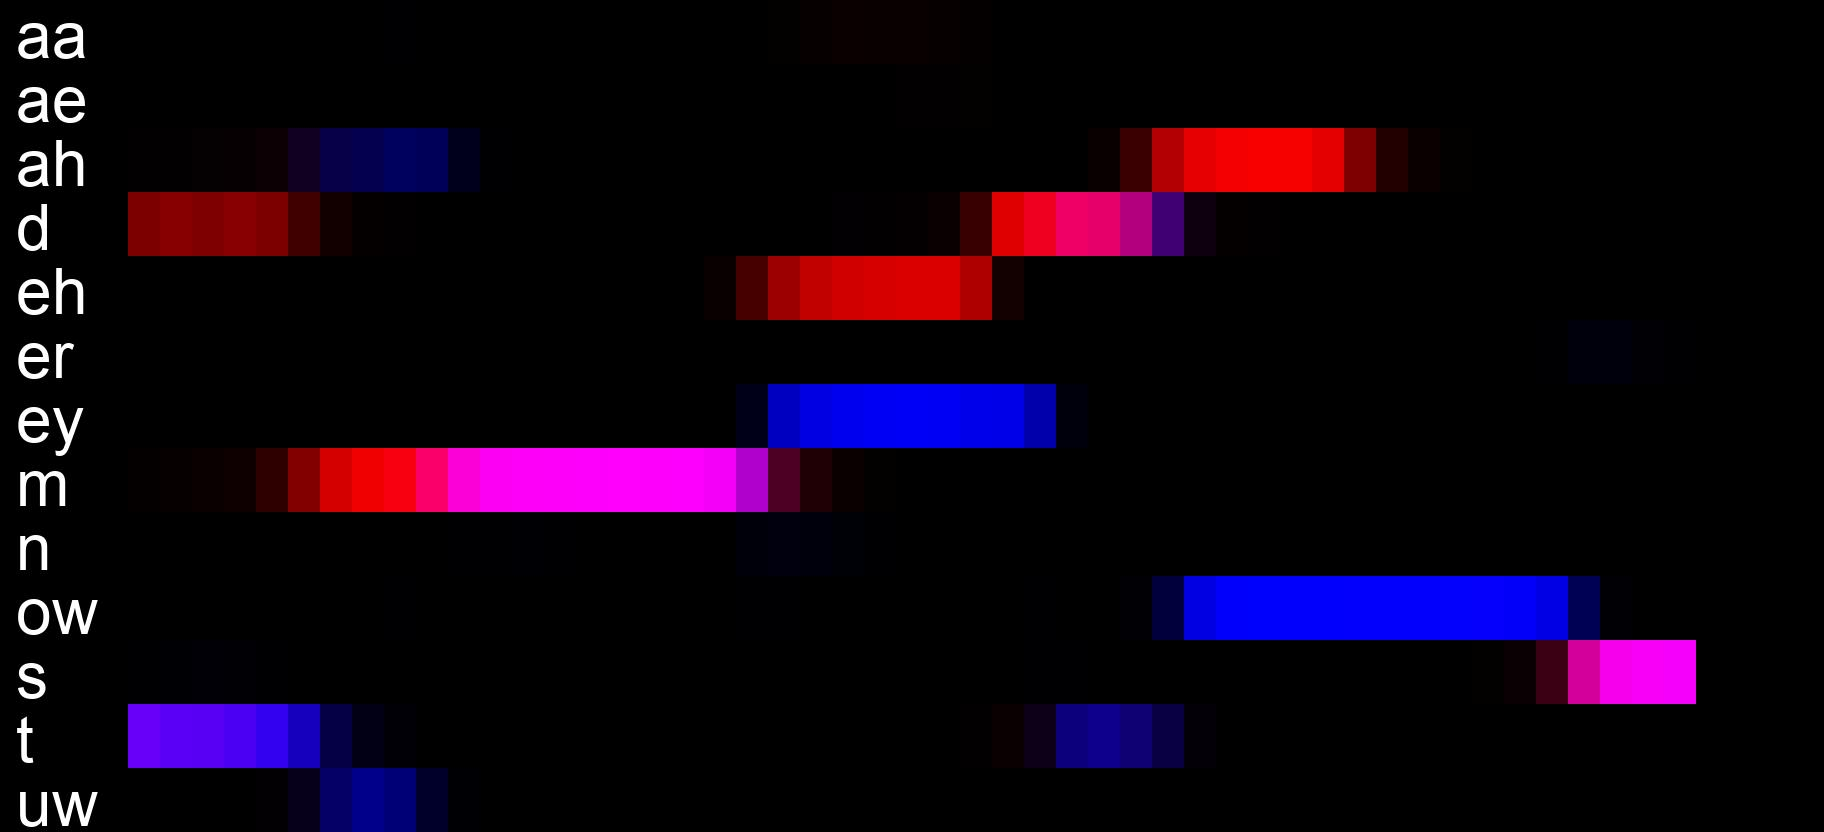

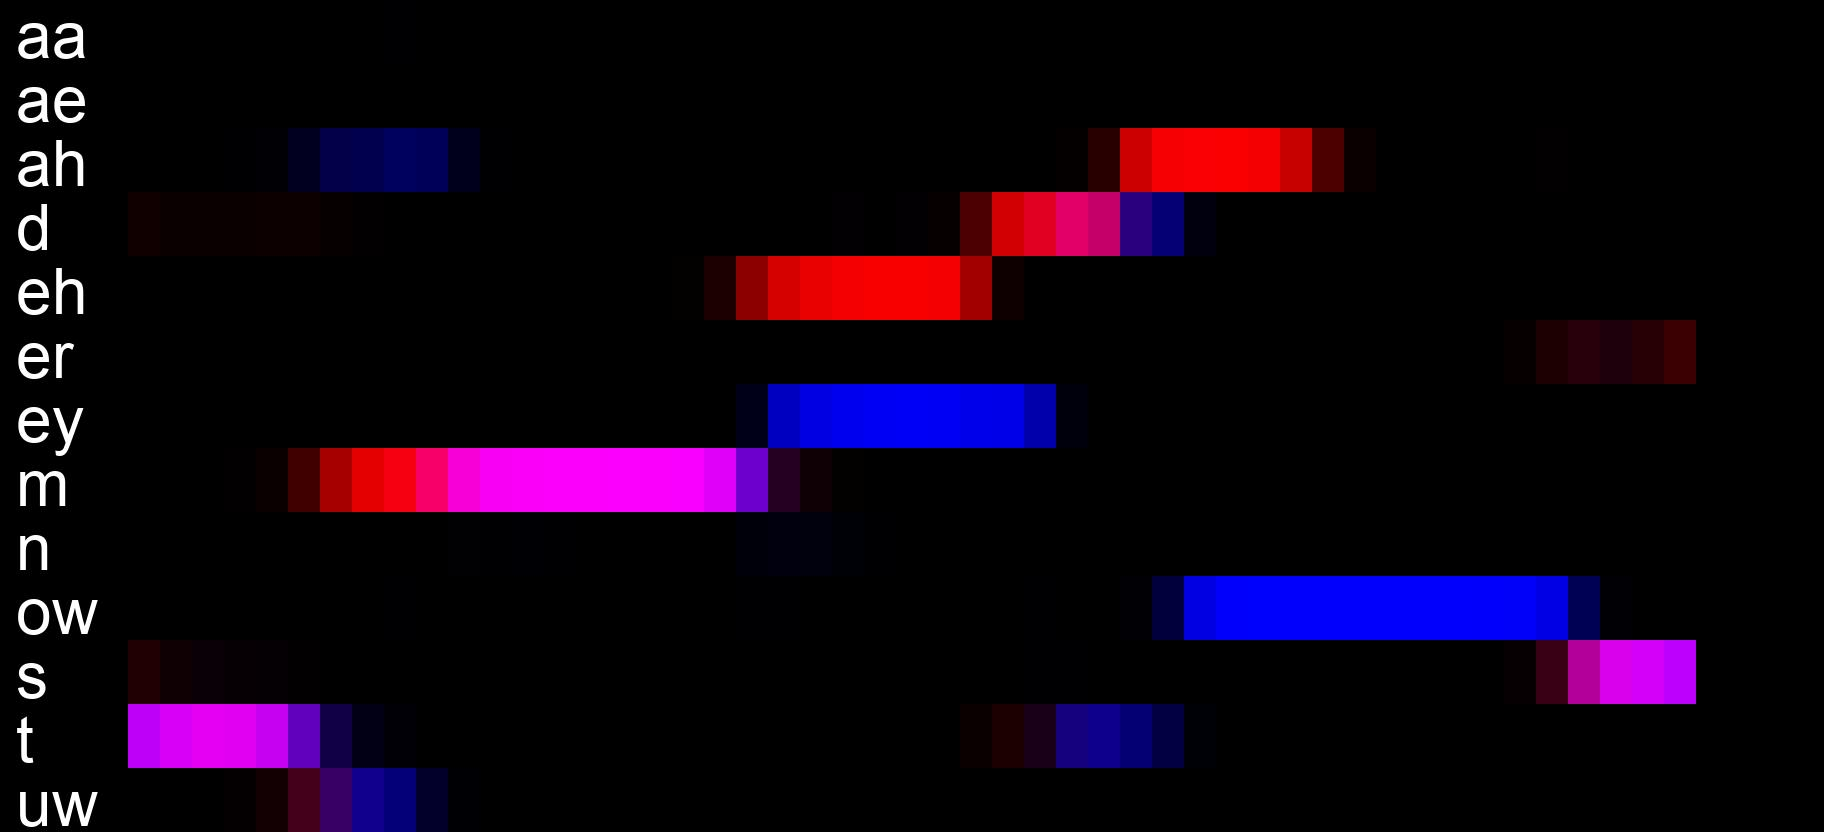

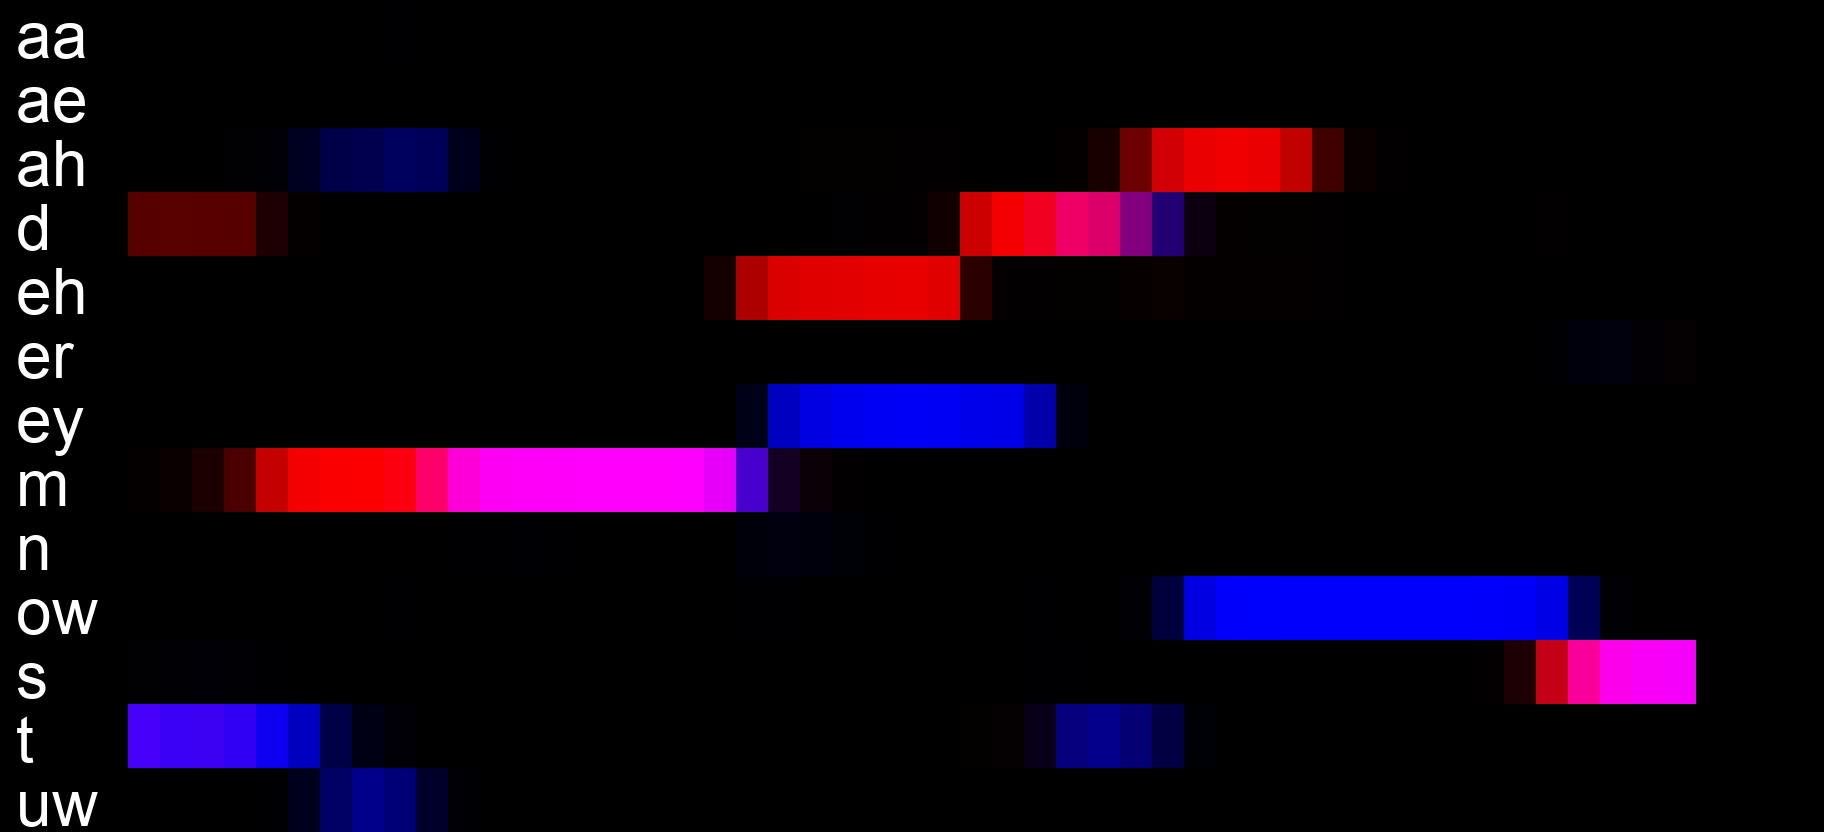

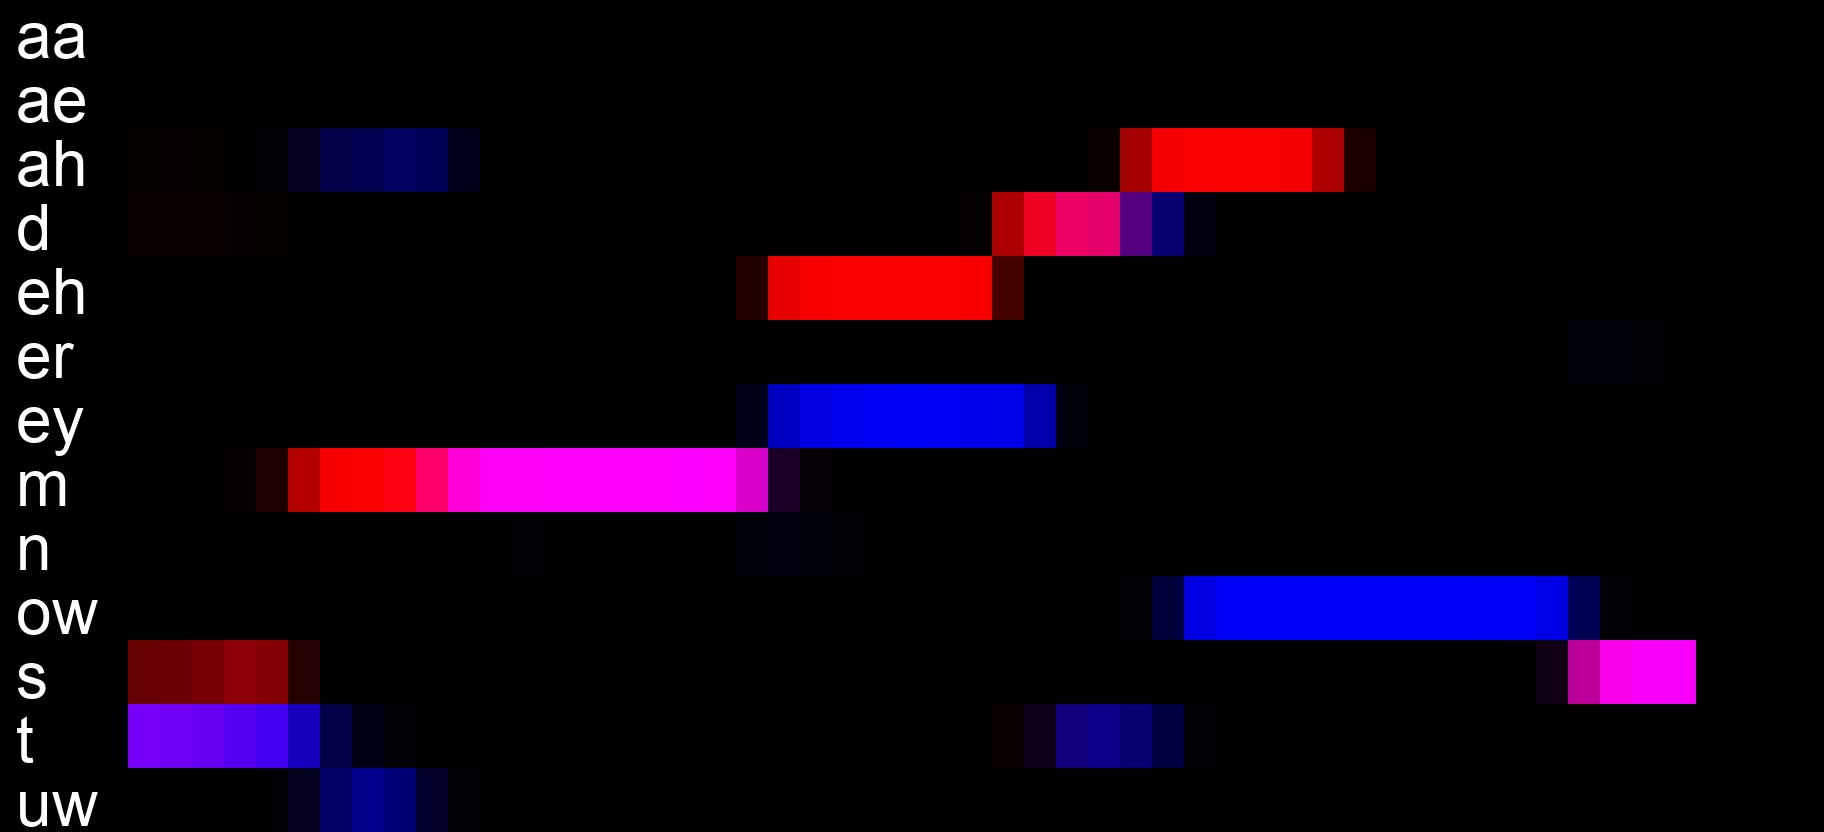

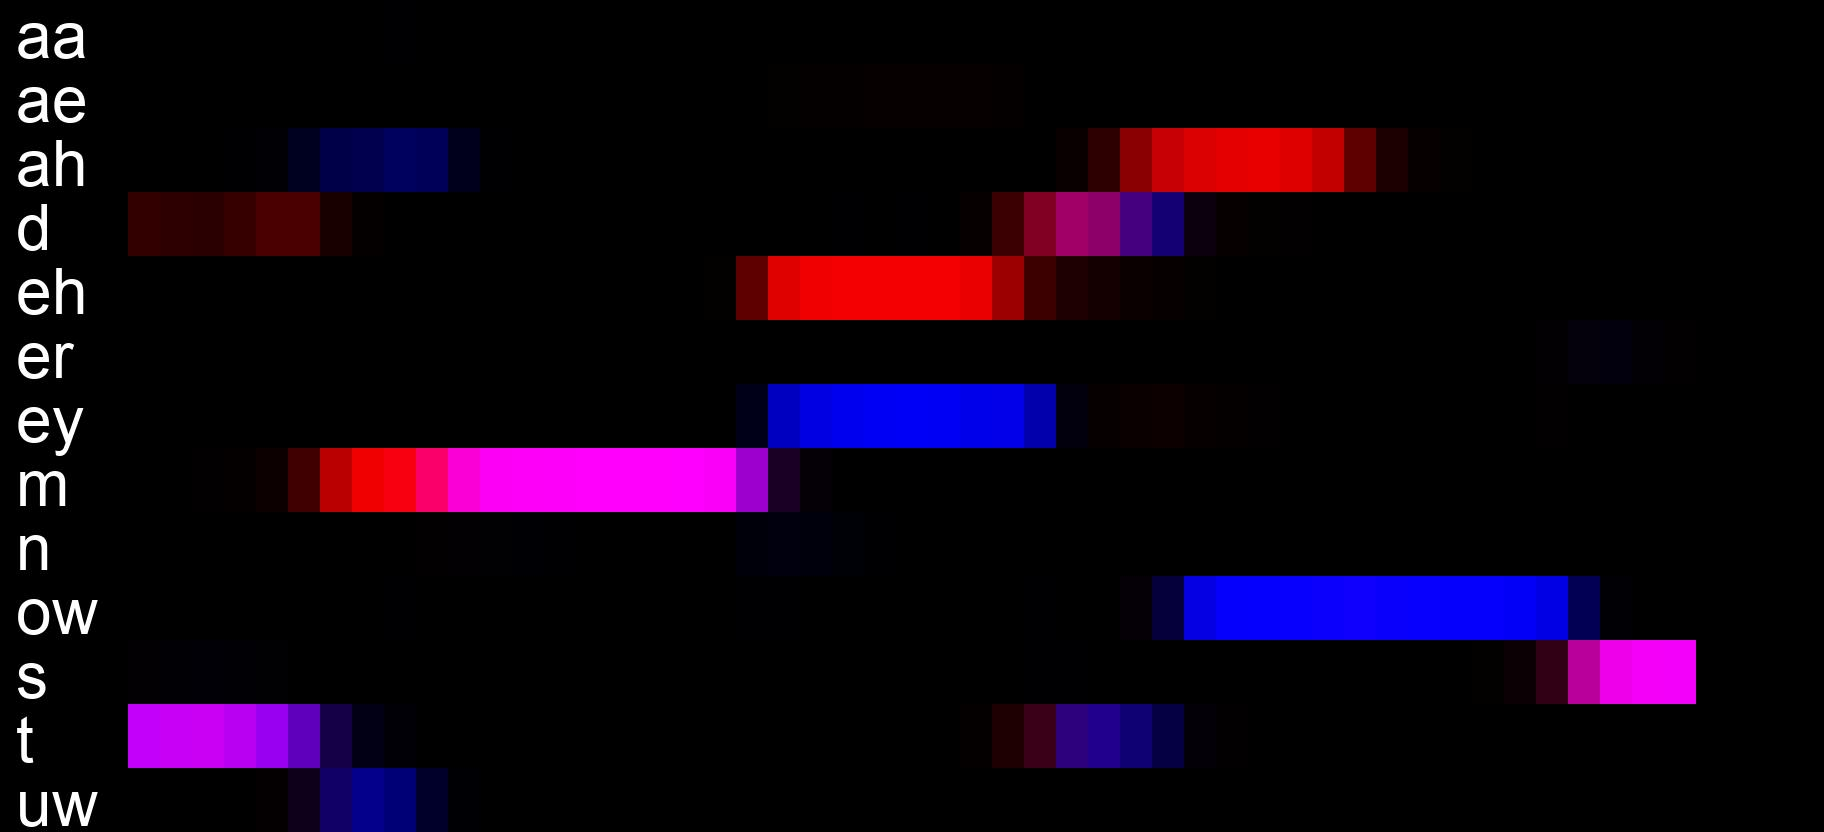

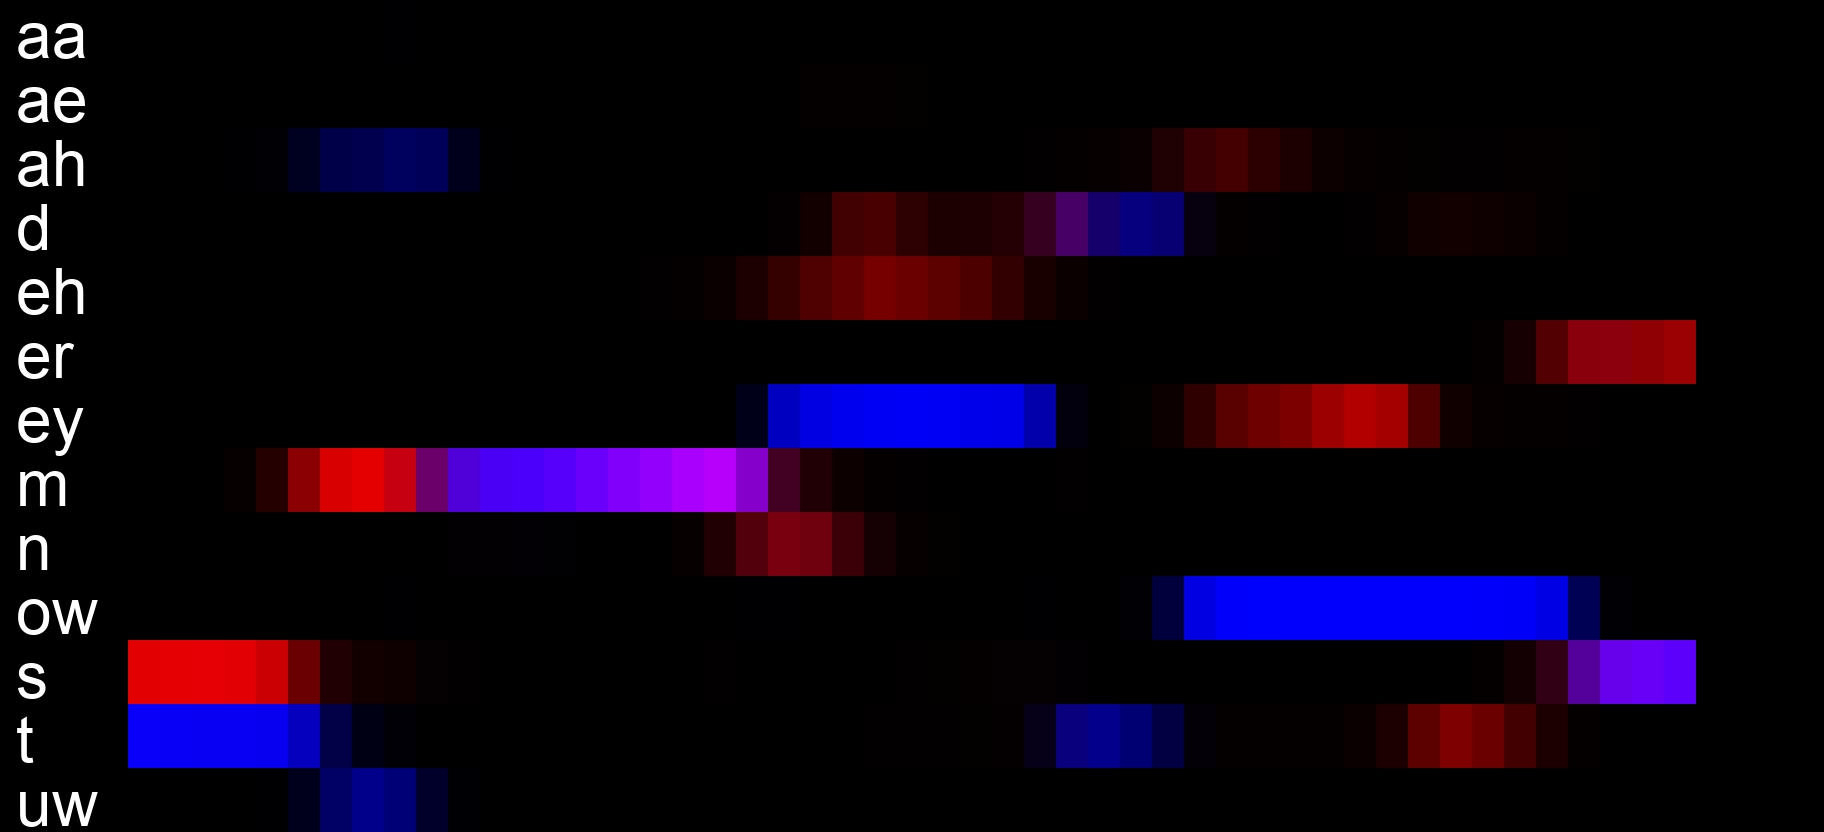

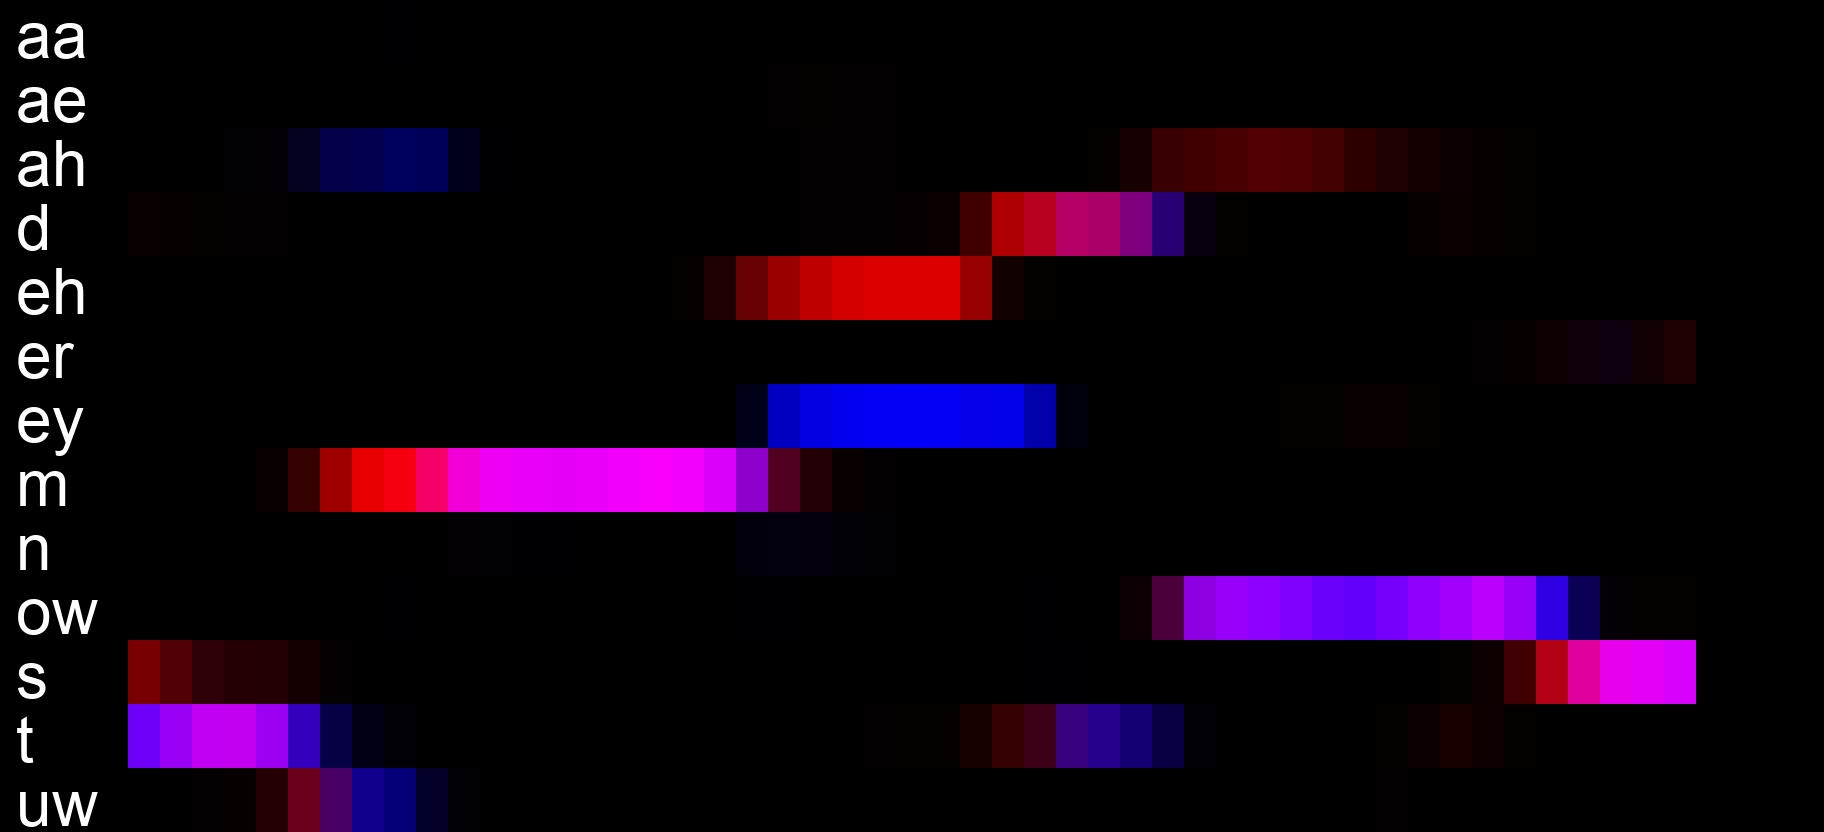

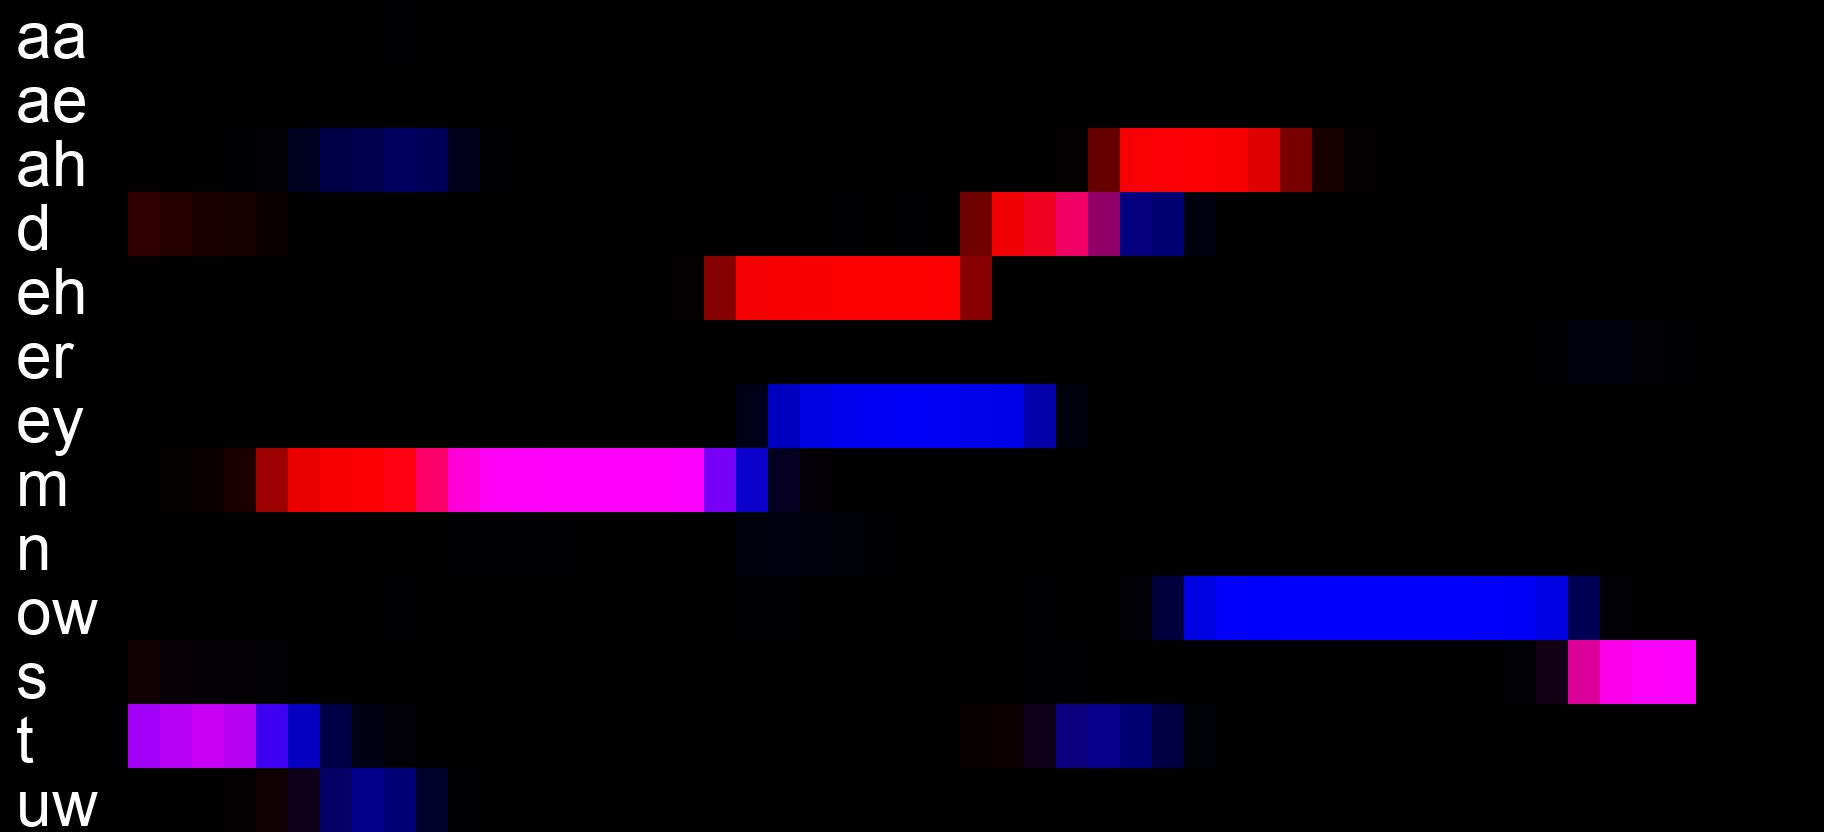

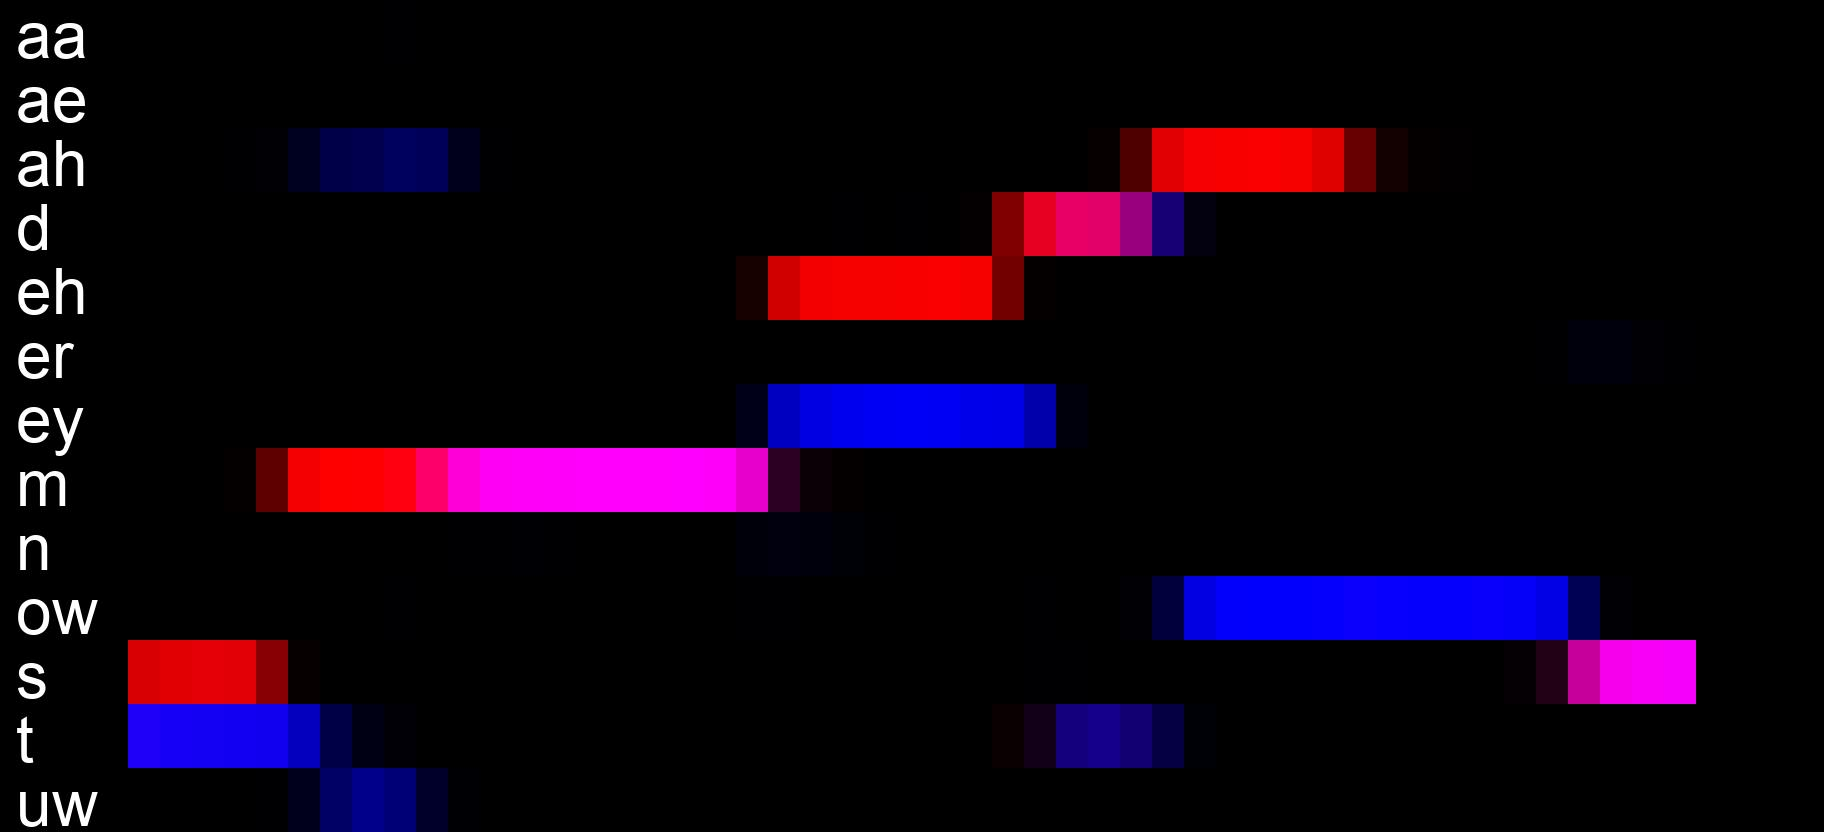

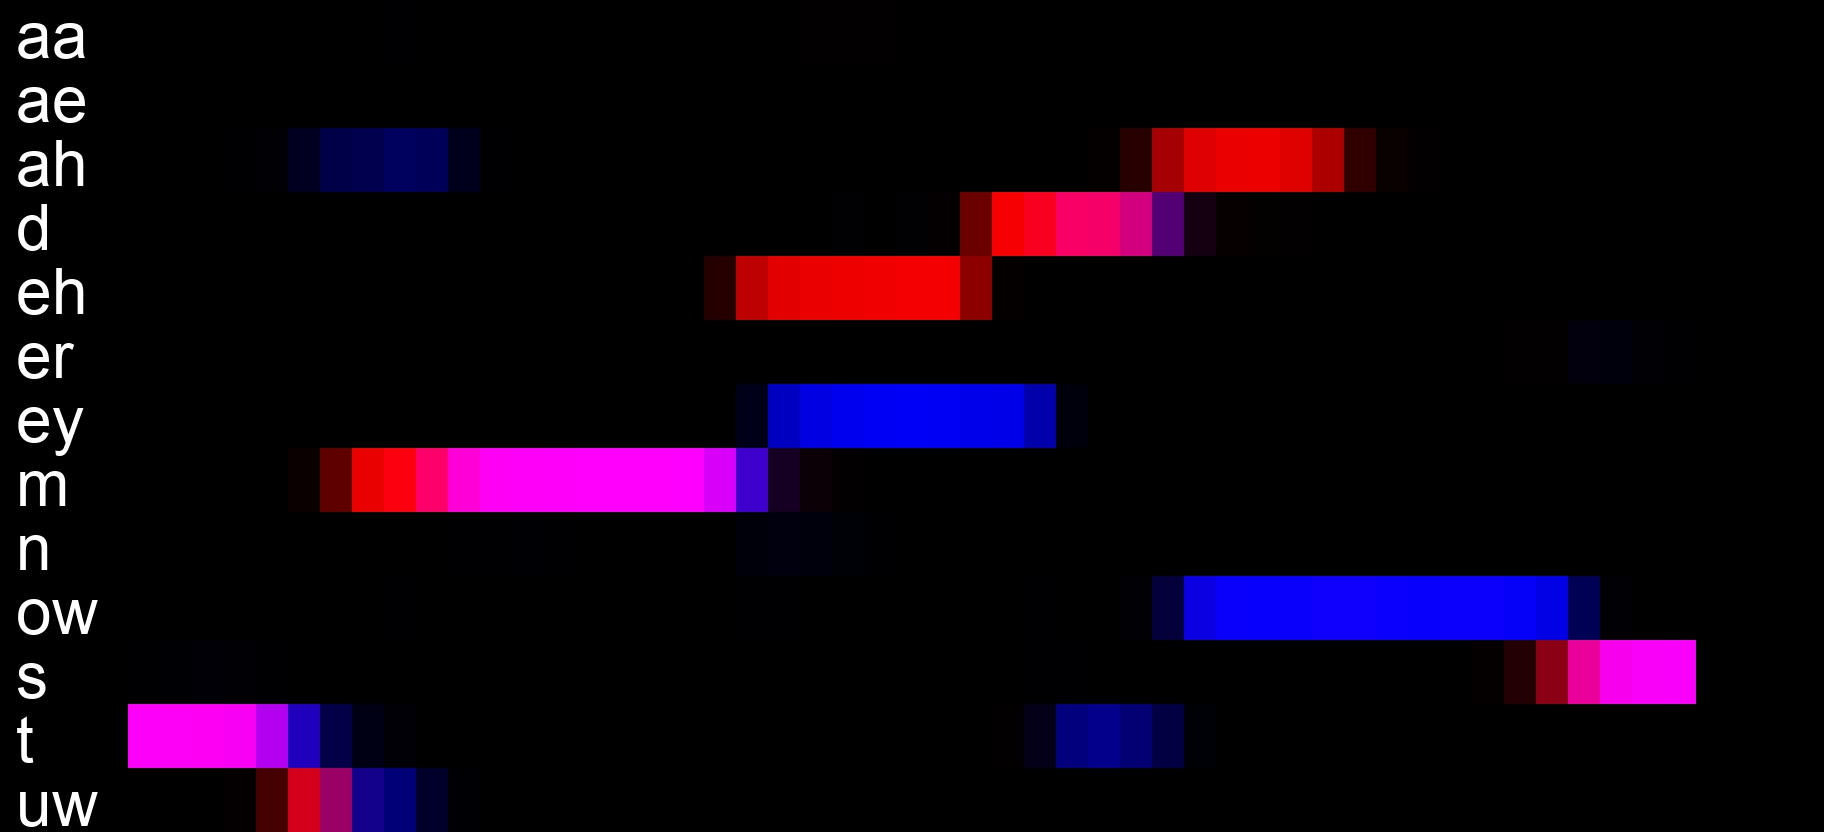

In [74]:
vis_dir = Path('visualizations')
for i in range(0, len(ppg_files)):
    ppgs.evaluate.visualize.from_ppg_to_image_file(
        torch.load(ppg_files[i])[kept_row_indices,
        start_time-window_extend_radius:stop_time+window_extend_radius].T,
        audio_file,
        vis_dir / f'fig{i:03d}.jpg',
        second_ppg=ppg[kept_row_indices, start_time-window_extend_radius:stop_time+window_extend_radius].T,
        font_filename='arial.ttf',
        labels=kept_phonemes,
        scalefactor=scalefactor,
        padding=padding
    )
    # ppgs.evaluate.visualize.from_ppg_to_image_file(reconstruction_inferred_ppg.T, audio_file, 'fig00.jpg', second_ppg=ppg[:, :-1].T, font_filename='arial.ttf')
    ipd.display(ipd.Image(vis_dir / f'fig{i:03d}.jpg'))

In [56]:
# reconstruction_inferred_ppg = torch.load(ppg_files[3])

In [41]:
# ppg editing
[(time, ppgs.PHONEME_LIST[idx]) for time, idx in enumerate(ppg.argmax(dim=0))]
start_time = 146
stop_time = 155

original_phone = 'ey'
original_phone_index = ppgs.PHONEME_LIST.index(original_phone)

target_phone = 'aa'
target_phone_index = ppgs.PHONEME_LIST.index(target_phone)

edited_ppg = ppg.clone()
edited_ppg[original_phone_index, start_time:stop_time] = ppg.clone()[target_phone_index, start_time:stop_time]
edited_ppg[target_phone_index, start_time:stop_time] = ppg.clone()[original_phone_index, start_time:stop_time]

edited_ppg_file = ppg_file.stem + '-edited.pt'
torch.save(edited_ppg, edited_ppg_file)

In [42]:
output_dir = Path('edited')

for i in range(0, 25):
    edited_output_file = output_dir / f'{audio_file.stem}-edited-{i:03d}.wav'
    command = 'python -m promonet '
    command += '--audio_files ' + str(audio_file) + ' '
    command += '--output_files ' + str(edited_output_file) + ' '
    # command += '--pitch_files ' + str(pitch_file) + ' '
    command += f'--target_ppg_files {edited_ppg_file} '
    command += f'--speaker_ids {16} '
    # command += f'--speaker_ids {0} '
    command += f'--config {ppgs_config_dir / (model + ".py")} {promonet_config_dir / (model + ".py")} '
    command += f'--checkpoint /repos/promonet/runs/{model}/generator-00250000.pt '
    command += f'--gpu 0'
    print(command)
    os.system(command)

    input_file = edited_output_file
    output_file = output_dir / (Path(input_file).stem + '-ppg.pt')
    command = 'python -m ppgs '
    command += f'--sources {input_file} '
    command += f'--sinks {output_file} '
    command += f'--config {ppgs_config_dir / (model + ".py")} '
    command += f'--gpu 0'
    print(command)
    os.system(command)
IPython.display.Audio(edited_output_file)

ppg_files = list(output_dir.glob('*.pt'))

distances = torch.full((100,), torch.inf)

for i, ppg_file in enumerate(sorted(ppg_files)):
    inferred_ppg = torch.load(ppg_file)
    distances[i] = jsd(norm(inferred_ppg), norm(ppg[..., :inferred_ppg.shape[-1]]))
print(distances)
print(distances.argmin(), distances.min())



edited_inferred_ppg = torch.load(ppg_files[distances.argmin()])

python -m promonet --audio_files tomato_clean.wav --output_files edited/tomato_clean-edited-000.wav --target_ppg_files tomato_clean-reconstruction-024-ppg-edited.pt --speaker_ids 16 --config /repos/promonet/config/ppgs-experiments/ppgs/w2v2fb-ppg.py /repos/promonet/config/ppgs-experiments/promonet/w2v2fb-ppg.py --checkpoint /repos/promonet/runs/w2v2fb-ppg/generator-00250000.pt --gpu 0
python -m ppgs --sources edited/tomato_clean-edited-000.wav --sinks edited/tomato_clean-edited-000-ppg.pt --config /repos/promonet/config/ppgs-experiments/ppgs/w2v2fb-ppg.py --gpu 0
preparing dataset metadata (operation may be slow)


processing w2v2fb for dataset <list of files>: 100%|██████████| 1/1 [00:02<00:00,  2.37s/it]


using transformer model
python -m promonet --audio_files tomato_clean.wav --output_files edited/tomato_clean-edited-001.wav --target_ppg_files tomato_clean-reconstruction-024-ppg-edited.pt --speaker_ids 16 --config /repos/promonet/config/ppgs-experiments/ppgs/w2v2fb-ppg.py /repos/promonet/config/ppgs-experiments/promonet/w2v2fb-ppg.py --checkpoint /repos/promonet/runs/w2v2fb-ppg/generator-00250000.pt --gpu 0
python -m ppgs --sources edited/tomato_clean-edited-001.wav --sinks edited/tomato_clean-edited-001-ppg.pt --config /repos/promonet/config/ppgs-experiments/ppgs/w2v2fb-ppg.py --gpu 0
preparing dataset metadata (operation may be slow)


processing w2v2fb for dataset <list of files>: 100%|██████████| 1/1 [00:02<00:00,  2.35s/it]


using transformer model
python -m promonet --audio_files tomato_clean.wav --output_files edited/tomato_clean-edited-002.wav --target_ppg_files tomato_clean-reconstruction-024-ppg-edited.pt --speaker_ids 16 --config /repos/promonet/config/ppgs-experiments/ppgs/w2v2fb-ppg.py /repos/promonet/config/ppgs-experiments/promonet/w2v2fb-ppg.py --checkpoint /repos/promonet/runs/w2v2fb-ppg/generator-00250000.pt --gpu 0
python -m ppgs --sources edited/tomato_clean-edited-002.wav --sinks edited/tomato_clean-edited-002-ppg.pt --config /repos/promonet/config/ppgs-experiments/ppgs/w2v2fb-ppg.py --gpu 0
preparing dataset metadata (operation may be slow)


processing w2v2fb for dataset <list of files>: 100%|██████████| 1/1 [00:02<00:00,  2.37s/it]


using transformer model
python -m promonet --audio_files tomato_clean.wav --output_files edited/tomato_clean-edited-003.wav --target_ppg_files tomato_clean-reconstruction-024-ppg-edited.pt --speaker_ids 16 --config /repos/promonet/config/ppgs-experiments/ppgs/w2v2fb-ppg.py /repos/promonet/config/ppgs-experiments/promonet/w2v2fb-ppg.py --checkpoint /repos/promonet/runs/w2v2fb-ppg/generator-00250000.pt --gpu 0
python -m ppgs --sources edited/tomato_clean-edited-003.wav --sinks edited/tomato_clean-edited-003-ppg.pt --config /repos/promonet/config/ppgs-experiments/ppgs/w2v2fb-ppg.py --gpu 0
preparing dataset metadata (operation may be slow)


processing w2v2fb for dataset <list of files>: 100%|██████████| 1/1 [00:02<00:00,  2.40s/it]


using transformer model
python -m promonet --audio_files tomato_clean.wav --output_files edited/tomato_clean-edited-004.wav --target_ppg_files tomato_clean-reconstruction-024-ppg-edited.pt --speaker_ids 16 --config /repos/promonet/config/ppgs-experiments/ppgs/w2v2fb-ppg.py /repos/promonet/config/ppgs-experiments/promonet/w2v2fb-ppg.py --checkpoint /repos/promonet/runs/w2v2fb-ppg/generator-00250000.pt --gpu 0
python -m ppgs --sources edited/tomato_clean-edited-004.wav --sinks edited/tomato_clean-edited-004-ppg.pt --config /repos/promonet/config/ppgs-experiments/ppgs/w2v2fb-ppg.py --gpu 0
preparing dataset metadata (operation may be slow)


processing w2v2fb for dataset <list of files>: 100%|██████████| 1/1 [00:02<00:00,  2.42s/it]


using transformer model
python -m promonet --audio_files tomato_clean.wav --output_files edited/tomato_clean-edited-005.wav --target_ppg_files tomato_clean-reconstruction-024-ppg-edited.pt --speaker_ids 16 --config /repos/promonet/config/ppgs-experiments/ppgs/w2v2fb-ppg.py /repos/promonet/config/ppgs-experiments/promonet/w2v2fb-ppg.py --checkpoint /repos/promonet/runs/w2v2fb-ppg/generator-00250000.pt --gpu 0
python -m ppgs --sources edited/tomato_clean-edited-005.wav --sinks edited/tomato_clean-edited-005-ppg.pt --config /repos/promonet/config/ppgs-experiments/ppgs/w2v2fb-ppg.py --gpu 0
preparing dataset metadata (operation may be slow)


processing w2v2fb for dataset <list of files>: 100%|██████████| 1/1 [00:02<00:00,  2.41s/it]


using transformer model
python -m promonet --audio_files tomato_clean.wav --output_files edited/tomato_clean-edited-006.wav --target_ppg_files tomato_clean-reconstruction-024-ppg-edited.pt --speaker_ids 16 --config /repos/promonet/config/ppgs-experiments/ppgs/w2v2fb-ppg.py /repos/promonet/config/ppgs-experiments/promonet/w2v2fb-ppg.py --checkpoint /repos/promonet/runs/w2v2fb-ppg/generator-00250000.pt --gpu 0
python -m ppgs --sources edited/tomato_clean-edited-006.wav --sinks edited/tomato_clean-edited-006-ppg.pt --config /repos/promonet/config/ppgs-experiments/ppgs/w2v2fb-ppg.py --gpu 0
preparing dataset metadata (operation may be slow)


processing w2v2fb for dataset <list of files>: 100%|██████████| 1/1 [00:02<00:00,  2.50s/it]


using transformer model
python -m promonet --audio_files tomato_clean.wav --output_files edited/tomato_clean-edited-007.wav --target_ppg_files tomato_clean-reconstruction-024-ppg-edited.pt --speaker_ids 16 --config /repos/promonet/config/ppgs-experiments/ppgs/w2v2fb-ppg.py /repos/promonet/config/ppgs-experiments/promonet/w2v2fb-ppg.py --checkpoint /repos/promonet/runs/w2v2fb-ppg/generator-00250000.pt --gpu 0
python -m ppgs --sources edited/tomato_clean-edited-007.wav --sinks edited/tomato_clean-edited-007-ppg.pt --config /repos/promonet/config/ppgs-experiments/ppgs/w2v2fb-ppg.py --gpu 0
preparing dataset metadata (operation may be slow)


processing w2v2fb for dataset <list of files>: 100%|██████████| 1/1 [00:02<00:00,  2.37s/it]


using transformer model
python -m promonet --audio_files tomato_clean.wav --output_files edited/tomato_clean-edited-008.wav --target_ppg_files tomato_clean-reconstruction-024-ppg-edited.pt --speaker_ids 16 --config /repos/promonet/config/ppgs-experiments/ppgs/w2v2fb-ppg.py /repos/promonet/config/ppgs-experiments/promonet/w2v2fb-ppg.py --checkpoint /repos/promonet/runs/w2v2fb-ppg/generator-00250000.pt --gpu 0
python -m ppgs --sources edited/tomato_clean-edited-008.wav --sinks edited/tomato_clean-edited-008-ppg.pt --config /repos/promonet/config/ppgs-experiments/ppgs/w2v2fb-ppg.py --gpu 0
preparing dataset metadata (operation may be slow)


processing w2v2fb for dataset <list of files>: 100%|██████████| 1/1 [00:02<00:00,  2.44s/it]


using transformer model
python -m promonet --audio_files tomato_clean.wav --output_files edited/tomato_clean-edited-009.wav --target_ppg_files tomato_clean-reconstruction-024-ppg-edited.pt --speaker_ids 16 --config /repos/promonet/config/ppgs-experiments/ppgs/w2v2fb-ppg.py /repos/promonet/config/ppgs-experiments/promonet/w2v2fb-ppg.py --checkpoint /repos/promonet/runs/w2v2fb-ppg/generator-00250000.pt --gpu 0
python -m ppgs --sources edited/tomato_clean-edited-009.wav --sinks edited/tomato_clean-edited-009-ppg.pt --config /repos/promonet/config/ppgs-experiments/ppgs/w2v2fb-ppg.py --gpu 0
preparing dataset metadata (operation may be slow)


processing w2v2fb for dataset <list of files>: 100%|██████████| 1/1 [00:02<00:00,  2.36s/it]


using transformer model
python -m promonet --audio_files tomato_clean.wav --output_files edited/tomato_clean-edited-010.wav --target_ppg_files tomato_clean-reconstruction-024-ppg-edited.pt --speaker_ids 16 --config /repos/promonet/config/ppgs-experiments/ppgs/w2v2fb-ppg.py /repos/promonet/config/ppgs-experiments/promonet/w2v2fb-ppg.py --checkpoint /repos/promonet/runs/w2v2fb-ppg/generator-00250000.pt --gpu 0
python -m ppgs --sources edited/tomato_clean-edited-010.wav --sinks edited/tomato_clean-edited-010-ppg.pt --config /repos/promonet/config/ppgs-experiments/ppgs/w2v2fb-ppg.py --gpu 0
preparing dataset metadata (operation may be slow)


processing w2v2fb for dataset <list of files>: 100%|██████████| 1/1 [00:02<00:00,  2.40s/it]


using transformer model
python -m promonet --audio_files tomato_clean.wav --output_files edited/tomato_clean-edited-011.wav --target_ppg_files tomato_clean-reconstruction-024-ppg-edited.pt --speaker_ids 16 --config /repos/promonet/config/ppgs-experiments/ppgs/w2v2fb-ppg.py /repos/promonet/config/ppgs-experiments/promonet/w2v2fb-ppg.py --checkpoint /repos/promonet/runs/w2v2fb-ppg/generator-00250000.pt --gpu 0
python -m ppgs --sources edited/tomato_clean-edited-011.wav --sinks edited/tomato_clean-edited-011-ppg.pt --config /repos/promonet/config/ppgs-experiments/ppgs/w2v2fb-ppg.py --gpu 0
preparing dataset metadata (operation may be slow)


processing w2v2fb for dataset <list of files>: 100%|██████████| 1/1 [00:02<00:00,  2.38s/it]


using transformer model
python -m promonet --audio_files tomato_clean.wav --output_files edited/tomato_clean-edited-012.wav --target_ppg_files tomato_clean-reconstruction-024-ppg-edited.pt --speaker_ids 16 --config /repos/promonet/config/ppgs-experiments/ppgs/w2v2fb-ppg.py /repos/promonet/config/ppgs-experiments/promonet/w2v2fb-ppg.py --checkpoint /repos/promonet/runs/w2v2fb-ppg/generator-00250000.pt --gpu 0
python -m ppgs --sources edited/tomato_clean-edited-012.wav --sinks edited/tomato_clean-edited-012-ppg.pt --config /repos/promonet/config/ppgs-experiments/ppgs/w2v2fb-ppg.py --gpu 0
preparing dataset metadata (operation may be slow)


processing w2v2fb for dataset <list of files>: 100%|██████████| 1/1 [00:02<00:00,  2.35s/it]


using transformer model
python -m promonet --audio_files tomato_clean.wav --output_files edited/tomato_clean-edited-013.wav --target_ppg_files tomato_clean-reconstruction-024-ppg-edited.pt --speaker_ids 16 --config /repos/promonet/config/ppgs-experiments/ppgs/w2v2fb-ppg.py /repos/promonet/config/ppgs-experiments/promonet/w2v2fb-ppg.py --checkpoint /repos/promonet/runs/w2v2fb-ppg/generator-00250000.pt --gpu 0
python -m ppgs --sources edited/tomato_clean-edited-013.wav --sinks edited/tomato_clean-edited-013-ppg.pt --config /repos/promonet/config/ppgs-experiments/ppgs/w2v2fb-ppg.py --gpu 0
preparing dataset metadata (operation may be slow)


processing w2v2fb for dataset <list of files>: 100%|██████████| 1/1 [00:02<00:00,  2.49s/it]


using transformer model
python -m promonet --audio_files tomato_clean.wav --output_files edited/tomato_clean-edited-014.wav --target_ppg_files tomato_clean-reconstruction-024-ppg-edited.pt --speaker_ids 16 --config /repos/promonet/config/ppgs-experiments/ppgs/w2v2fb-ppg.py /repos/promonet/config/ppgs-experiments/promonet/w2v2fb-ppg.py --checkpoint /repos/promonet/runs/w2v2fb-ppg/generator-00250000.pt --gpu 0
python -m ppgs --sources edited/tomato_clean-edited-014.wav --sinks edited/tomato_clean-edited-014-ppg.pt --config /repos/promonet/config/ppgs-experiments/ppgs/w2v2fb-ppg.py --gpu 0
preparing dataset metadata (operation may be slow)


processing w2v2fb for dataset <list of files>: 100%|██████████| 1/1 [00:02<00:00,  2.40s/it]


using transformer model
python -m promonet --audio_files tomato_clean.wav --output_files edited/tomato_clean-edited-015.wav --target_ppg_files tomato_clean-reconstruction-024-ppg-edited.pt --speaker_ids 16 --config /repos/promonet/config/ppgs-experiments/ppgs/w2v2fb-ppg.py /repos/promonet/config/ppgs-experiments/promonet/w2v2fb-ppg.py --checkpoint /repos/promonet/runs/w2v2fb-ppg/generator-00250000.pt --gpu 0
python -m ppgs --sources edited/tomato_clean-edited-015.wav --sinks edited/tomato_clean-edited-015-ppg.pt --config /repos/promonet/config/ppgs-experiments/ppgs/w2v2fb-ppg.py --gpu 0
preparing dataset metadata (operation may be slow)


processing w2v2fb for dataset <list of files>: 100%|██████████| 1/1 [00:02<00:00,  2.38s/it]


using transformer model
python -m promonet --audio_files tomato_clean.wav --output_files edited/tomato_clean-edited-016.wav --target_ppg_files tomato_clean-reconstruction-024-ppg-edited.pt --speaker_ids 16 --config /repos/promonet/config/ppgs-experiments/ppgs/w2v2fb-ppg.py /repos/promonet/config/ppgs-experiments/promonet/w2v2fb-ppg.py --checkpoint /repos/promonet/runs/w2v2fb-ppg/generator-00250000.pt --gpu 0
python -m ppgs --sources edited/tomato_clean-edited-016.wav --sinks edited/tomato_clean-edited-016-ppg.pt --config /repos/promonet/config/ppgs-experiments/ppgs/w2v2fb-ppg.py --gpu 0
preparing dataset metadata (operation may be slow)


processing w2v2fb for dataset <list of files>: 100%|██████████| 1/1 [00:02<00:00,  2.48s/it]


using transformer model
python -m promonet --audio_files tomato_clean.wav --output_files edited/tomato_clean-edited-017.wav --target_ppg_files tomato_clean-reconstruction-024-ppg-edited.pt --speaker_ids 16 --config /repos/promonet/config/ppgs-experiments/ppgs/w2v2fb-ppg.py /repos/promonet/config/ppgs-experiments/promonet/w2v2fb-ppg.py --checkpoint /repos/promonet/runs/w2v2fb-ppg/generator-00250000.pt --gpu 0
python -m ppgs --sources edited/tomato_clean-edited-017.wav --sinks edited/tomato_clean-edited-017-ppg.pt --config /repos/promonet/config/ppgs-experiments/ppgs/w2v2fb-ppg.py --gpu 0
preparing dataset metadata (operation may be slow)


processing w2v2fb for dataset <list of files>: 100%|██████████| 1/1 [00:02<00:00,  2.41s/it]


using transformer model
python -m promonet --audio_files tomato_clean.wav --output_files edited/tomato_clean-edited-018.wav --target_ppg_files tomato_clean-reconstruction-024-ppg-edited.pt --speaker_ids 16 --config /repos/promonet/config/ppgs-experiments/ppgs/w2v2fb-ppg.py /repos/promonet/config/ppgs-experiments/promonet/w2v2fb-ppg.py --checkpoint /repos/promonet/runs/w2v2fb-ppg/generator-00250000.pt --gpu 0
python -m ppgs --sources edited/tomato_clean-edited-018.wav --sinks edited/tomato_clean-edited-018-ppg.pt --config /repos/promonet/config/ppgs-experiments/ppgs/w2v2fb-ppg.py --gpu 0
preparing dataset metadata (operation may be slow)


processing w2v2fb for dataset <list of files>: 100%|██████████| 1/1 [00:02<00:00,  2.48s/it]


using transformer model
python -m promonet --audio_files tomato_clean.wav --output_files edited/tomato_clean-edited-019.wav --target_ppg_files tomato_clean-reconstruction-024-ppg-edited.pt --speaker_ids 16 --config /repos/promonet/config/ppgs-experiments/ppgs/w2v2fb-ppg.py /repos/promonet/config/ppgs-experiments/promonet/w2v2fb-ppg.py --checkpoint /repos/promonet/runs/w2v2fb-ppg/generator-00250000.pt --gpu 0
python -m ppgs --sources edited/tomato_clean-edited-019.wav --sinks edited/tomato_clean-edited-019-ppg.pt --config /repos/promonet/config/ppgs-experiments/ppgs/w2v2fb-ppg.py --gpu 0
preparing dataset metadata (operation may be slow)


processing w2v2fb for dataset <list of files>: 100%|██████████| 1/1 [00:02<00:00,  2.40s/it]


using transformer model
python -m promonet --audio_files tomato_clean.wav --output_files edited/tomato_clean-edited-020.wav --target_ppg_files tomato_clean-reconstruction-024-ppg-edited.pt --speaker_ids 16 --config /repos/promonet/config/ppgs-experiments/ppgs/w2v2fb-ppg.py /repos/promonet/config/ppgs-experiments/promonet/w2v2fb-ppg.py --checkpoint /repos/promonet/runs/w2v2fb-ppg/generator-00250000.pt --gpu 0
python -m ppgs --sources edited/tomato_clean-edited-020.wav --sinks edited/tomato_clean-edited-020-ppg.pt --config /repos/promonet/config/ppgs-experiments/ppgs/w2v2fb-ppg.py --gpu 0
preparing dataset metadata (operation may be slow)


processing w2v2fb for dataset <list of files>: 100%|██████████| 1/1 [00:02<00:00,  2.38s/it]


using transformer model
python -m promonet --audio_files tomato_clean.wav --output_files edited/tomato_clean-edited-021.wav --target_ppg_files tomato_clean-reconstruction-024-ppg-edited.pt --speaker_ids 16 --config /repos/promonet/config/ppgs-experiments/ppgs/w2v2fb-ppg.py /repos/promonet/config/ppgs-experiments/promonet/w2v2fb-ppg.py --checkpoint /repos/promonet/runs/w2v2fb-ppg/generator-00250000.pt --gpu 0
python -m ppgs --sources edited/tomato_clean-edited-021.wav --sinks edited/tomato_clean-edited-021-ppg.pt --config /repos/promonet/config/ppgs-experiments/ppgs/w2v2fb-ppg.py --gpu 0
preparing dataset metadata (operation may be slow)


processing w2v2fb for dataset <list of files>: 100%|██████████| 1/1 [00:02<00:00,  2.39s/it]


using transformer model
python -m promonet --audio_files tomato_clean.wav --output_files edited/tomato_clean-edited-022.wav --target_ppg_files tomato_clean-reconstruction-024-ppg-edited.pt --speaker_ids 16 --config /repos/promonet/config/ppgs-experiments/ppgs/w2v2fb-ppg.py /repos/promonet/config/ppgs-experiments/promonet/w2v2fb-ppg.py --checkpoint /repos/promonet/runs/w2v2fb-ppg/generator-00250000.pt --gpu 0
python -m ppgs --sources edited/tomato_clean-edited-022.wav --sinks edited/tomato_clean-edited-022-ppg.pt --config /repos/promonet/config/ppgs-experiments/ppgs/w2v2fb-ppg.py --gpu 0
preparing dataset metadata (operation may be slow)


processing w2v2fb for dataset <list of files>: 100%|██████████| 1/1 [00:02<00:00,  2.52s/it]


using transformer model
python -m promonet --audio_files tomato_clean.wav --output_files edited/tomato_clean-edited-023.wav --target_ppg_files tomato_clean-reconstruction-024-ppg-edited.pt --speaker_ids 16 --config /repos/promonet/config/ppgs-experiments/ppgs/w2v2fb-ppg.py /repos/promonet/config/ppgs-experiments/promonet/w2v2fb-ppg.py --checkpoint /repos/promonet/runs/w2v2fb-ppg/generator-00250000.pt --gpu 0
python -m ppgs --sources edited/tomato_clean-edited-023.wav --sinks edited/tomato_clean-edited-023-ppg.pt --config /repos/promonet/config/ppgs-experiments/ppgs/w2v2fb-ppg.py --gpu 0
preparing dataset metadata (operation may be slow)


processing w2v2fb for dataset <list of files>: 100%|██████████| 1/1 [00:02<00:00,  2.37s/it]


using transformer model
python -m promonet --audio_files tomato_clean.wav --output_files edited/tomato_clean-edited-024.wav --target_ppg_files tomato_clean-reconstruction-024-ppg-edited.pt --speaker_ids 16 --config /repos/promonet/config/ppgs-experiments/ppgs/w2v2fb-ppg.py /repos/promonet/config/ppgs-experiments/promonet/w2v2fb-ppg.py --checkpoint /repos/promonet/runs/w2v2fb-ppg/generator-00250000.pt --gpu 0
python -m ppgs --sources edited/tomato_clean-edited-024.wav --sinks edited/tomato_clean-edited-024-ppg.pt --config /repos/promonet/config/ppgs-experiments/ppgs/w2v2fb-ppg.py --gpu 0
preparing dataset metadata (operation may be slow)


processing w2v2fb for dataset <list of files>: 100%|██████████| 1/1 [00:02<00:00,  2.43s/it]


using transformer model
tensor([19.1366, 17.3275, 19.7029, 20.0181, 16.5196, 22.6806, 17.5550, 16.0536,
        17.9642, 17.2869, 18.4220, 17.7603, 24.1134, 16.8331, 14.7839, 14.4680,
        20.3085, 20.5993, 19.5004, 18.8452, 16.1941, 19.9737, 16.7467, 20.7763,
        20.1765,     inf,     inf,     inf,     inf,     inf,     inf,     inf,
            inf,     inf,     inf,     inf,     inf,     inf,     inf,     inf,
            inf,     inf,     inf,     inf,     inf,     inf,     inf,     inf,
            inf,     inf,     inf,     inf,     inf,     inf,     inf,     inf,
            inf,     inf,     inf,     inf,     inf,     inf,     inf,     inf,
            inf,     inf,     inf,     inf,     inf,     inf,     inf,     inf,
            inf,     inf,     inf,     inf,     inf,     inf,     inf,     inf,
            inf,     inf,     inf,     inf,     inf,     inf,     inf,     inf,
            inf,     inf,     inf,     inf,     inf,     inf,     inf,     inf,
            inf,

In [43]:
def slerp(val, low, high):
    omega = torch.acos((low*high).sum(1))
    so = torch.sin(omega)
    res = (torch.sin((1.0-val)*omega)/so).unsqueeze(1)*low + (torch.sin(val*omega)/so).unsqueeze(1) * high
    return res

interp_ratio = 0.5
interpolated_ppg = slerp(interp_ratio, edited_ppg.T, ppg.T).T
interpolated_ppg_file = ppg_file.stem + '-interp.pt'
torch.save(interpolated_ppg, interpolated_ppg_file)

In [44]:
output_dir = Path('interp')

for i in range(0, 25):
    interp_output_file = output_dir / f'{audio_file.stem}-interpolated-{i:03d}.wav'
    command = 'python -m promonet '
    command += '--audio_files ' + str(audio_file) + ' '
    command += '--output_files ' + str(interp_output_file) + ' '
    # command += '--pitch_files ' + str(pitch_file) + ' '
    command += f'--target_ppg_files {interpolated_ppg_file} '
    command += f'--speaker_ids {16} '
    # command += f'--speaker_ids {0} '
    command += f'--config {ppgs_config_dir / (model + ".py")} {promonet_config_dir / (model + ".py")} '
    command += f'--checkpoint /repos/promonet/runs/{model}/generator-00250000.pt '
    command += f'--gpu 0'
    print(command)
    os.system(command)

    input_file = interp_output_file
    output_file = output_dir / (Path(input_file).stem + '-ppg.pt')
    command = 'python -m ppgs '
    command += f'--sources {input_file} '
    command += f'--sinks {output_file} '
    command += f'--config {ppgs_config_dir / (model + ".py")} '
    command += f'--gpu 0'
    print(command)
    os.system(command)
IPython.display.Audio(interp_output_file)

ppg_files = list(output_dir.glob('*.pt'))

distances = torch.full((100,), torch.inf)

for i, ppg_file in enumerate(sorted(ppg_files)):
    inferred_ppg = torch.load(ppg_file)
    distances[i] = jsd(norm(inferred_ppg), norm(ppg[..., :inferred_ppg.shape[-1]]))
print(distances)
print(distances.argmin(), distances.min())

interp_inferred_ppg = torch.load(ppg_files[distances.argmin()])

python -m promonet --audio_files tomato_clean.wav --output_files interp/tomato_clean-interpolated-000.wav --target_ppg_files tomato_clean-edited-024-ppg-interp.pt --speaker_ids 16 --config /repos/promonet/config/ppgs-experiments/ppgs/w2v2fb-ppg.py /repos/promonet/config/ppgs-experiments/promonet/w2v2fb-ppg.py --checkpoint /repos/promonet/runs/w2v2fb-ppg/generator-00250000.pt --gpu 0
python -m ppgs --sources interp/tomato_clean-interpolated-000.wav --sinks interp/tomato_clean-interpolated-000-ppg.pt --config /repos/promonet/config/ppgs-experiments/ppgs/w2v2fb-ppg.py --gpu 0
preparing dataset metadata (operation may be slow)


processing w2v2fb for dataset <list of files>: 100%|██████████| 1/1 [00:03<00:00,  3.13s/it]


using transformer model
python -m promonet --audio_files tomato_clean.wav --output_files interp/tomato_clean-interpolated-001.wav --target_ppg_files tomato_clean-edited-024-ppg-interp.pt --speaker_ids 16 --config /repos/promonet/config/ppgs-experiments/ppgs/w2v2fb-ppg.py /repos/promonet/config/ppgs-experiments/promonet/w2v2fb-ppg.py --checkpoint /repos/promonet/runs/w2v2fb-ppg/generator-00250000.pt --gpu 0
python -m ppgs --sources interp/tomato_clean-interpolated-001.wav --sinks interp/tomato_clean-interpolated-001-ppg.pt --config /repos/promonet/config/ppgs-experiments/ppgs/w2v2fb-ppg.py --gpu 0
preparing dataset metadata (operation may be slow)


processing w2v2fb for dataset <list of files>: 100%|██████████| 1/1 [00:03<00:00,  3.52s/it]


using transformer model
python -m promonet --audio_files tomato_clean.wav --output_files interp/tomato_clean-interpolated-002.wav --target_ppg_files tomato_clean-edited-024-ppg-interp.pt --speaker_ids 16 --config /repos/promonet/config/ppgs-experiments/ppgs/w2v2fb-ppg.py /repos/promonet/config/ppgs-experiments/promonet/w2v2fb-ppg.py --checkpoint /repos/promonet/runs/w2v2fb-ppg/generator-00250000.pt --gpu 0
python -m ppgs --sources interp/tomato_clean-interpolated-002.wav --sinks interp/tomato_clean-interpolated-002-ppg.pt --config /repos/promonet/config/ppgs-experiments/ppgs/w2v2fb-ppg.py --gpu 0
preparing dataset metadata (operation may be slow)


processing w2v2fb for dataset <list of files>: 100%|██████████| 1/1 [00:03<00:00,  3.16s/it]


using transformer model
python -m promonet --audio_files tomato_clean.wav --output_files interp/tomato_clean-interpolated-003.wav --target_ppg_files tomato_clean-edited-024-ppg-interp.pt --speaker_ids 16 --config /repos/promonet/config/ppgs-experiments/ppgs/w2v2fb-ppg.py /repos/promonet/config/ppgs-experiments/promonet/w2v2fb-ppg.py --checkpoint /repos/promonet/runs/w2v2fb-ppg/generator-00250000.pt --gpu 0
python -m ppgs --sources interp/tomato_clean-interpolated-003.wav --sinks interp/tomato_clean-interpolated-003-ppg.pt --config /repos/promonet/config/ppgs-experiments/ppgs/w2v2fb-ppg.py --gpu 0
preparing dataset metadata (operation may be slow)


processing w2v2fb for dataset <list of files>: 100%|██████████| 1/1 [00:02<00:00,  2.99s/it]


using transformer model
python -m promonet --audio_files tomato_clean.wav --output_files interp/tomato_clean-interpolated-004.wav --target_ppg_files tomato_clean-edited-024-ppg-interp.pt --speaker_ids 16 --config /repos/promonet/config/ppgs-experiments/ppgs/w2v2fb-ppg.py /repos/promonet/config/ppgs-experiments/promonet/w2v2fb-ppg.py --checkpoint /repos/promonet/runs/w2v2fb-ppg/generator-00250000.pt --gpu 0
python -m ppgs --sources interp/tomato_clean-interpolated-004.wav --sinks interp/tomato_clean-interpolated-004-ppg.pt --config /repos/promonet/config/ppgs-experiments/ppgs/w2v2fb-ppg.py --gpu 0
preparing dataset metadata (operation may be slow)


processing w2v2fb for dataset <list of files>: 100%|██████████| 1/1 [00:02<00:00,  2.96s/it]


using transformer model
python -m promonet --audio_files tomato_clean.wav --output_files interp/tomato_clean-interpolated-005.wav --target_ppg_files tomato_clean-edited-024-ppg-interp.pt --speaker_ids 16 --config /repos/promonet/config/ppgs-experiments/ppgs/w2v2fb-ppg.py /repos/promonet/config/ppgs-experiments/promonet/w2v2fb-ppg.py --checkpoint /repos/promonet/runs/w2v2fb-ppg/generator-00250000.pt --gpu 0
python -m ppgs --sources interp/tomato_clean-interpolated-005.wav --sinks interp/tomato_clean-interpolated-005-ppg.pt --config /repos/promonet/config/ppgs-experiments/ppgs/w2v2fb-ppg.py --gpu 0
preparing dataset metadata (operation may be slow)


processing w2v2fb for dataset <list of files>: 100%|██████████| 1/1 [00:02<00:00,  2.88s/it]


using transformer model
python -m promonet --audio_files tomato_clean.wav --output_files interp/tomato_clean-interpolated-006.wav --target_ppg_files tomato_clean-edited-024-ppg-interp.pt --speaker_ids 16 --config /repos/promonet/config/ppgs-experiments/ppgs/w2v2fb-ppg.py /repos/promonet/config/ppgs-experiments/promonet/w2v2fb-ppg.py --checkpoint /repos/promonet/runs/w2v2fb-ppg/generator-00250000.pt --gpu 0
python -m ppgs --sources interp/tomato_clean-interpolated-006.wav --sinks interp/tomato_clean-interpolated-006-ppg.pt --config /repos/promonet/config/ppgs-experiments/ppgs/w2v2fb-ppg.py --gpu 0
preparing dataset metadata (operation may be slow)


processing w2v2fb for dataset <list of files>: 100%|██████████| 1/1 [00:03<00:00,  3.04s/it]


using transformer model
python -m promonet --audio_files tomato_clean.wav --output_files interp/tomato_clean-interpolated-007.wav --target_ppg_files tomato_clean-edited-024-ppg-interp.pt --speaker_ids 16 --config /repos/promonet/config/ppgs-experiments/ppgs/w2v2fb-ppg.py /repos/promonet/config/ppgs-experiments/promonet/w2v2fb-ppg.py --checkpoint /repos/promonet/runs/w2v2fb-ppg/generator-00250000.pt --gpu 0
python -m ppgs --sources interp/tomato_clean-interpolated-007.wav --sinks interp/tomato_clean-interpolated-007-ppg.pt --config /repos/promonet/config/ppgs-experiments/ppgs/w2v2fb-ppg.py --gpu 0
preparing dataset metadata (operation may be slow)


processing w2v2fb for dataset <list of files>: 100%|██████████| 1/1 [00:02<00:00,  2.77s/it]


using transformer model
python -m promonet --audio_files tomato_clean.wav --output_files interp/tomato_clean-interpolated-008.wav --target_ppg_files tomato_clean-edited-024-ppg-interp.pt --speaker_ids 16 --config /repos/promonet/config/ppgs-experiments/ppgs/w2v2fb-ppg.py /repos/promonet/config/ppgs-experiments/promonet/w2v2fb-ppg.py --checkpoint /repos/promonet/runs/w2v2fb-ppg/generator-00250000.pt --gpu 0
python -m ppgs --sources interp/tomato_clean-interpolated-008.wav --sinks interp/tomato_clean-interpolated-008-ppg.pt --config /repos/promonet/config/ppgs-experiments/ppgs/w2v2fb-ppg.py --gpu 0
preparing dataset metadata (operation may be slow)


processing w2v2fb for dataset <list of files>: 100%|██████████| 1/1 [00:02<00:00,  2.83s/it]


using transformer model
python -m promonet --audio_files tomato_clean.wav --output_files interp/tomato_clean-interpolated-009.wav --target_ppg_files tomato_clean-edited-024-ppg-interp.pt --speaker_ids 16 --config /repos/promonet/config/ppgs-experiments/ppgs/w2v2fb-ppg.py /repos/promonet/config/ppgs-experiments/promonet/w2v2fb-ppg.py --checkpoint /repos/promonet/runs/w2v2fb-ppg/generator-00250000.pt --gpu 0
python -m ppgs --sources interp/tomato_clean-interpolated-009.wav --sinks interp/tomato_clean-interpolated-009-ppg.pt --config /repos/promonet/config/ppgs-experiments/ppgs/w2v2fb-ppg.py --gpu 0
preparing dataset metadata (operation may be slow)


processing w2v2fb for dataset <list of files>: 100%|██████████| 1/1 [00:02<00:00,  2.42s/it]


using transformer model
python -m promonet --audio_files tomato_clean.wav --output_files interp/tomato_clean-interpolated-010.wav --target_ppg_files tomato_clean-edited-024-ppg-interp.pt --speaker_ids 16 --config /repos/promonet/config/ppgs-experiments/ppgs/w2v2fb-ppg.py /repos/promonet/config/ppgs-experiments/promonet/w2v2fb-ppg.py --checkpoint /repos/promonet/runs/w2v2fb-ppg/generator-00250000.pt --gpu 0
python -m ppgs --sources interp/tomato_clean-interpolated-010.wav --sinks interp/tomato_clean-interpolated-010-ppg.pt --config /repos/promonet/config/ppgs-experiments/ppgs/w2v2fb-ppg.py --gpu 0
preparing dataset metadata (operation may be slow)


processing w2v2fb for dataset <list of files>: 100%|██████████| 1/1 [00:02<00:00,  2.44s/it]


using transformer model
python -m promonet --audio_files tomato_clean.wav --output_files interp/tomato_clean-interpolated-011.wav --target_ppg_files tomato_clean-edited-024-ppg-interp.pt --speaker_ids 16 --config /repos/promonet/config/ppgs-experiments/ppgs/w2v2fb-ppg.py /repos/promonet/config/ppgs-experiments/promonet/w2v2fb-ppg.py --checkpoint /repos/promonet/runs/w2v2fb-ppg/generator-00250000.pt --gpu 0
python -m ppgs --sources interp/tomato_clean-interpolated-011.wav --sinks interp/tomato_clean-interpolated-011-ppg.pt --config /repos/promonet/config/ppgs-experiments/ppgs/w2v2fb-ppg.py --gpu 0
preparing dataset metadata (operation may be slow)


processing w2v2fb for dataset <list of files>: 100%|██████████| 1/1 [00:02<00:00,  2.41s/it]


using transformer model
python -m promonet --audio_files tomato_clean.wav --output_files interp/tomato_clean-interpolated-012.wav --target_ppg_files tomato_clean-edited-024-ppg-interp.pt --speaker_ids 16 --config /repos/promonet/config/ppgs-experiments/ppgs/w2v2fb-ppg.py /repos/promonet/config/ppgs-experiments/promonet/w2v2fb-ppg.py --checkpoint /repos/promonet/runs/w2v2fb-ppg/generator-00250000.pt --gpu 0
python -m ppgs --sources interp/tomato_clean-interpolated-012.wav --sinks interp/tomato_clean-interpolated-012-ppg.pt --config /repos/promonet/config/ppgs-experiments/ppgs/w2v2fb-ppg.py --gpu 0
preparing dataset metadata (operation may be slow)


processing w2v2fb for dataset <list of files>: 100%|██████████| 1/1 [00:02<00:00,  2.47s/it]


using transformer model
python -m promonet --audio_files tomato_clean.wav --output_files interp/tomato_clean-interpolated-013.wav --target_ppg_files tomato_clean-edited-024-ppg-interp.pt --speaker_ids 16 --config /repos/promonet/config/ppgs-experiments/ppgs/w2v2fb-ppg.py /repos/promonet/config/ppgs-experiments/promonet/w2v2fb-ppg.py --checkpoint /repos/promonet/runs/w2v2fb-ppg/generator-00250000.pt --gpu 0
python -m ppgs --sources interp/tomato_clean-interpolated-013.wav --sinks interp/tomato_clean-interpolated-013-ppg.pt --config /repos/promonet/config/ppgs-experiments/ppgs/w2v2fb-ppg.py --gpu 0
preparing dataset metadata (operation may be slow)


processing w2v2fb for dataset <list of files>: 100%|██████████| 1/1 [00:02<00:00,  2.44s/it]


using transformer model
python -m promonet --audio_files tomato_clean.wav --output_files interp/tomato_clean-interpolated-014.wav --target_ppg_files tomato_clean-edited-024-ppg-interp.pt --speaker_ids 16 --config /repos/promonet/config/ppgs-experiments/ppgs/w2v2fb-ppg.py /repos/promonet/config/ppgs-experiments/promonet/w2v2fb-ppg.py --checkpoint /repos/promonet/runs/w2v2fb-ppg/generator-00250000.pt --gpu 0
python -m ppgs --sources interp/tomato_clean-interpolated-014.wav --sinks interp/tomato_clean-interpolated-014-ppg.pt --config /repos/promonet/config/ppgs-experiments/ppgs/w2v2fb-ppg.py --gpu 0
preparing dataset metadata (operation may be slow)


processing w2v2fb for dataset <list of files>: 100%|██████████| 1/1 [00:02<00:00,  2.41s/it]


using transformer model
python -m promonet --audio_files tomato_clean.wav --output_files interp/tomato_clean-interpolated-015.wav --target_ppg_files tomato_clean-edited-024-ppg-interp.pt --speaker_ids 16 --config /repos/promonet/config/ppgs-experiments/ppgs/w2v2fb-ppg.py /repos/promonet/config/ppgs-experiments/promonet/w2v2fb-ppg.py --checkpoint /repos/promonet/runs/w2v2fb-ppg/generator-00250000.pt --gpu 0
python -m ppgs --sources interp/tomato_clean-interpolated-015.wav --sinks interp/tomato_clean-interpolated-015-ppg.pt --config /repos/promonet/config/ppgs-experiments/ppgs/w2v2fb-ppg.py --gpu 0
preparing dataset metadata (operation may be slow)


processing w2v2fb for dataset <list of files>: 100%|██████████| 1/1 [00:02<00:00,  2.42s/it]


using transformer model
python -m promonet --audio_files tomato_clean.wav --output_files interp/tomato_clean-interpolated-016.wav --target_ppg_files tomato_clean-edited-024-ppg-interp.pt --speaker_ids 16 --config /repos/promonet/config/ppgs-experiments/ppgs/w2v2fb-ppg.py /repos/promonet/config/ppgs-experiments/promonet/w2v2fb-ppg.py --checkpoint /repos/promonet/runs/w2v2fb-ppg/generator-00250000.pt --gpu 0
python -m ppgs --sources interp/tomato_clean-interpolated-016.wav --sinks interp/tomato_clean-interpolated-016-ppg.pt --config /repos/promonet/config/ppgs-experiments/ppgs/w2v2fb-ppg.py --gpu 0
preparing dataset metadata (operation may be slow)


processing w2v2fb for dataset <list of files>: 100%|██████████| 1/1 [00:02<00:00,  2.52s/it]


using transformer model
python -m promonet --audio_files tomato_clean.wav --output_files interp/tomato_clean-interpolated-017.wav --target_ppg_files tomato_clean-edited-024-ppg-interp.pt --speaker_ids 16 --config /repos/promonet/config/ppgs-experiments/ppgs/w2v2fb-ppg.py /repos/promonet/config/ppgs-experiments/promonet/w2v2fb-ppg.py --checkpoint /repos/promonet/runs/w2v2fb-ppg/generator-00250000.pt --gpu 0
python -m ppgs --sources interp/tomato_clean-interpolated-017.wav --sinks interp/tomato_clean-interpolated-017-ppg.pt --config /repos/promonet/config/ppgs-experiments/ppgs/w2v2fb-ppg.py --gpu 0
preparing dataset metadata (operation may be slow)


processing w2v2fb for dataset <list of files>: 100%|██████████| 1/1 [00:02<00:00,  2.45s/it]


using transformer model
python -m promonet --audio_files tomato_clean.wav --output_files interp/tomato_clean-interpolated-018.wav --target_ppg_files tomato_clean-edited-024-ppg-interp.pt --speaker_ids 16 --config /repos/promonet/config/ppgs-experiments/ppgs/w2v2fb-ppg.py /repos/promonet/config/ppgs-experiments/promonet/w2v2fb-ppg.py --checkpoint /repos/promonet/runs/w2v2fb-ppg/generator-00250000.pt --gpu 0
python -m ppgs --sources interp/tomato_clean-interpolated-018.wav --sinks interp/tomato_clean-interpolated-018-ppg.pt --config /repos/promonet/config/ppgs-experiments/ppgs/w2v2fb-ppg.py --gpu 0
preparing dataset metadata (operation may be slow)


processing w2v2fb for dataset <list of files>: 100%|██████████| 1/1 [00:02<00:00,  2.51s/it]


using transformer model
python -m promonet --audio_files tomato_clean.wav --output_files interp/tomato_clean-interpolated-019.wav --target_ppg_files tomato_clean-edited-024-ppg-interp.pt --speaker_ids 16 --config /repos/promonet/config/ppgs-experiments/ppgs/w2v2fb-ppg.py /repos/promonet/config/ppgs-experiments/promonet/w2v2fb-ppg.py --checkpoint /repos/promonet/runs/w2v2fb-ppg/generator-00250000.pt --gpu 0
python -m ppgs --sources interp/tomato_clean-interpolated-019.wav --sinks interp/tomato_clean-interpolated-019-ppg.pt --config /repos/promonet/config/ppgs-experiments/ppgs/w2v2fb-ppg.py --gpu 0
preparing dataset metadata (operation may be slow)


processing w2v2fb for dataset <list of files>: 100%|██████████| 1/1 [00:02<00:00,  2.45s/it]


using transformer model
python -m promonet --audio_files tomato_clean.wav --output_files interp/tomato_clean-interpolated-020.wav --target_ppg_files tomato_clean-edited-024-ppg-interp.pt --speaker_ids 16 --config /repos/promonet/config/ppgs-experiments/ppgs/w2v2fb-ppg.py /repos/promonet/config/ppgs-experiments/promonet/w2v2fb-ppg.py --checkpoint /repos/promonet/runs/w2v2fb-ppg/generator-00250000.pt --gpu 0
python -m ppgs --sources interp/tomato_clean-interpolated-020.wav --sinks interp/tomato_clean-interpolated-020-ppg.pt --config /repos/promonet/config/ppgs-experiments/ppgs/w2v2fb-ppg.py --gpu 0
preparing dataset metadata (operation may be slow)


processing w2v2fb for dataset <list of files>: 100%|██████████| 1/1 [00:02<00:00,  2.46s/it]


using transformer model
python -m promonet --audio_files tomato_clean.wav --output_files interp/tomato_clean-interpolated-021.wav --target_ppg_files tomato_clean-edited-024-ppg-interp.pt --speaker_ids 16 --config /repos/promonet/config/ppgs-experiments/ppgs/w2v2fb-ppg.py /repos/promonet/config/ppgs-experiments/promonet/w2v2fb-ppg.py --checkpoint /repos/promonet/runs/w2v2fb-ppg/generator-00250000.pt --gpu 0
python -m ppgs --sources interp/tomato_clean-interpolated-021.wav --sinks interp/tomato_clean-interpolated-021-ppg.pt --config /repos/promonet/config/ppgs-experiments/ppgs/w2v2fb-ppg.py --gpu 0
preparing dataset metadata (operation may be slow)


processing w2v2fb for dataset <list of files>: 100%|██████████| 1/1 [00:02<00:00,  2.44s/it]


using transformer model
python -m promonet --audio_files tomato_clean.wav --output_files interp/tomato_clean-interpolated-022.wav --target_ppg_files tomato_clean-edited-024-ppg-interp.pt --speaker_ids 16 --config /repos/promonet/config/ppgs-experiments/ppgs/w2v2fb-ppg.py /repos/promonet/config/ppgs-experiments/promonet/w2v2fb-ppg.py --checkpoint /repos/promonet/runs/w2v2fb-ppg/generator-00250000.pt --gpu 0
python -m ppgs --sources interp/tomato_clean-interpolated-022.wav --sinks interp/tomato_clean-interpolated-022-ppg.pt --config /repos/promonet/config/ppgs-experiments/ppgs/w2v2fb-ppg.py --gpu 0
preparing dataset metadata (operation may be slow)


processing w2v2fb for dataset <list of files>: 100%|██████████| 1/1 [00:02<00:00,  2.47s/it]


using transformer model
python -m promonet --audio_files tomato_clean.wav --output_files interp/tomato_clean-interpolated-023.wav --target_ppg_files tomato_clean-edited-024-ppg-interp.pt --speaker_ids 16 --config /repos/promonet/config/ppgs-experiments/ppgs/w2v2fb-ppg.py /repos/promonet/config/ppgs-experiments/promonet/w2v2fb-ppg.py --checkpoint /repos/promonet/runs/w2v2fb-ppg/generator-00250000.pt --gpu 0
python -m ppgs --sources interp/tomato_clean-interpolated-023.wav --sinks interp/tomato_clean-interpolated-023-ppg.pt --config /repos/promonet/config/ppgs-experiments/ppgs/w2v2fb-ppg.py --gpu 0
preparing dataset metadata (operation may be slow)


processing w2v2fb for dataset <list of files>: 100%|██████████| 1/1 [00:02<00:00,  2.40s/it]


using transformer model
python -m promonet --audio_files tomato_clean.wav --output_files interp/tomato_clean-interpolated-024.wav --target_ppg_files tomato_clean-edited-024-ppg-interp.pt --speaker_ids 16 --config /repos/promonet/config/ppgs-experiments/ppgs/w2v2fb-ppg.py /repos/promonet/config/ppgs-experiments/promonet/w2v2fb-ppg.py --checkpoint /repos/promonet/runs/w2v2fb-ppg/generator-00250000.pt --gpu 0
python -m ppgs --sources interp/tomato_clean-interpolated-024.wav --sinks interp/tomato_clean-interpolated-024-ppg.pt --config /repos/promonet/config/ppgs-experiments/ppgs/w2v2fb-ppg.py --gpu 0
preparing dataset metadata (operation may be slow)


processing w2v2fb for dataset <list of files>: 100%|██████████| 1/1 [00:02<00:00,  2.46s/it]


using transformer model
tensor([17.9580, 15.6227, 13.5730, 17.1851, 15.5798, 22.0308, 18.6210, 21.2661,
        17.3671, 17.5086, 17.1315, 15.5833, 17.8962, 16.2165, 44.7489, 37.5908,
        14.0201, 15.7900, 16.6535, 16.3727, 15.9904, 15.2987, 15.6303, 18.9074,
        15.8670,     inf,     inf,     inf,     inf,     inf,     inf,     inf,
            inf,     inf,     inf,     inf,     inf,     inf,     inf,     inf,
            inf,     inf,     inf,     inf,     inf,     inf,     inf,     inf,
            inf,     inf,     inf,     inf,     inf,     inf,     inf,     inf,
            inf,     inf,     inf,     inf,     inf,     inf,     inf,     inf,
            inf,     inf,     inf,     inf,     inf,     inf,     inf,     inf,
            inf,     inf,     inf,     inf,     inf,     inf,     inf,     inf,
            inf,     inf,     inf,     inf,     inf,     inf,     inf,     inf,
            inf,     inf,     inf,     inf,     inf,     inf,     inf,     inf,
            inf,

In [23]:
# edited_output_file = f'{audio_file.stem}-edited.wav'
# command = 'python -m promonet '
# command += '--audio_files ' + str(audio_file) + ' '
# command += '--output_files ' + edited_output_file + ' '
# # command += '--pitch_files ' + str(pitch_file) + ' '
# command += f'--target_ppg_files {edited_ppg_file} '
# command += f'--speaker_ids {16} '
# # command += f'--speaker_ids {0} '
# command += f'--config {ppgs_config_dir / (model + ".py")} {promonet_config_dir / (model + ".py")} '
# command += f'--checkpoint /repos/promonet/runs/{model}/generator-00250000.pt '
# command += f'--gpu 0'
# print(command)
# os.system(command)
# IPython.display.Audio(edited_output_file)

python -m promonet --audio_files tomato_clean.wav --output_files tomato_clean-edited.wav --target_ppg_files tomato_clean-reconstruction-013-ppg-edited.pt --speaker_ids 16 --config /repos/promonet/config/ppgs-experiments/ppgs/w2v2fb-ppg.py /repos/promonet/config/ppgs-experiments/promonet/w2v2fb-ppg.py --checkpoint /repos/promonet/runs/w2v2fb-ppg/generator-00250000.pt --gpu 0


In [26]:
# interp_output_file = f'{audio_file.stem}-interpolated.wav'
# command = 'python -m promonet '
# command += '--audio_files ' + str(audio_file) + ' '
# command += '--output_files ' + interp_output_file + ' '
# # command += '--pitch_files ' + str(pitch_file) + ' '
# command += f'--target_ppg_files {interpolated_ppg_file} '
# command += f'--speaker_ids {16} '
# # command += f'--speaker_ids {0} '
# command += f'--config {ppgs_config_dir / (model + ".py")} {promonet_config_dir / (model + ".py")} '
# command += f'--checkpoint /repos/promonet/runs/{model}/generator-00250000.pt '
# command += f'--gpu 0'
# print(command)
# os.system(command)
# IPython.display.Audio(interp_output_file)

python -m promonet --audio_files tomato_clean.wav --output_files tomato_clean-interpolated.wav --target_ppg_files tomato_clean-reconstruction-013-ppg-interp.pt --speaker_ids 16 --config /repos/promonet/config/ppgs-experiments/ppgs/w2v2fb-ppg.py /repos/promonet/config/ppgs-experiments/promonet/w2v2fb-ppg.py --checkpoint /repos/promonet/runs/w2v2fb-ppg/generator-00250000.pt --gpu 0


In [27]:
window_extend_radius = 20

original_audio, original_sample_rate = torchaudio.load(audio_file)
original_w2v2fb = ppgs.preprocess.from_audio(original_audio, representation='w2v2fb', sample_rate=original_sample_rate, gpu=0).squeeze(dim=0)[:, start_time-window_extend_radius:stop_time+window_extend_radius]
# original_w2v2fb = ppgs.preprocess.from_audio(original_audio, representation='w2v2fb', sample_rate=original_sample_rate, gpu=0).squeeze(dim=0)[:, :-1]
print(original_w2v2fb.shape)

recon_audio, recon_sample_rate = torchaudio.load(reconstruction_output_file)
# recon_w2v2fb = ppgs.preprocess.from_audio(recon_audio, representation='w2v2fb', sample_rate=recon_sample_rate, gpu=0).squeeze(dim=0)[:, start_time-window_extend_radius:stop_time+window_extend_radius]
recon_w2v2fb = ppgs.preprocess.from_audio(recon_audio, representation='w2v2fb', sample_rate=recon_sample_rate, gpu=0).squeeze(dim=0)[:, start_time-window_extend_radius:stop_time+window_extend_radius]
print(recon_w2v2fb.shape)

interp_audio, interp_sample_rate = torchaudio.load(interp_output_file)
interp_w2v2fb = ppgs.preprocess.from_audio(interp_audio, representation='w2v2fb', sample_rate=interp_sample_rate, gpu=0).squeeze(dim=0)[:, start_time-window_extend_radius:stop_time+window_extend_radius]
print(interp_w2v2fb.shape)

edit_audio, edit_sample_rate = torchaudio.load(edited_output_file)
edit_w2v2fb = ppgs.preprocess.from_audio(edit_audio, representation='w2v2fb', sample_rate=edit_sample_rate, gpu=0).squeeze(dim=0)[:, start_time-window_extend_radius:stop_time+window_extend_radius]
print(edit_w2v2fb.shape)

torch.Size([768, 49])
torch.Size([768, 49])
torch.Size([768, 49])
torch.Size([768, 49])


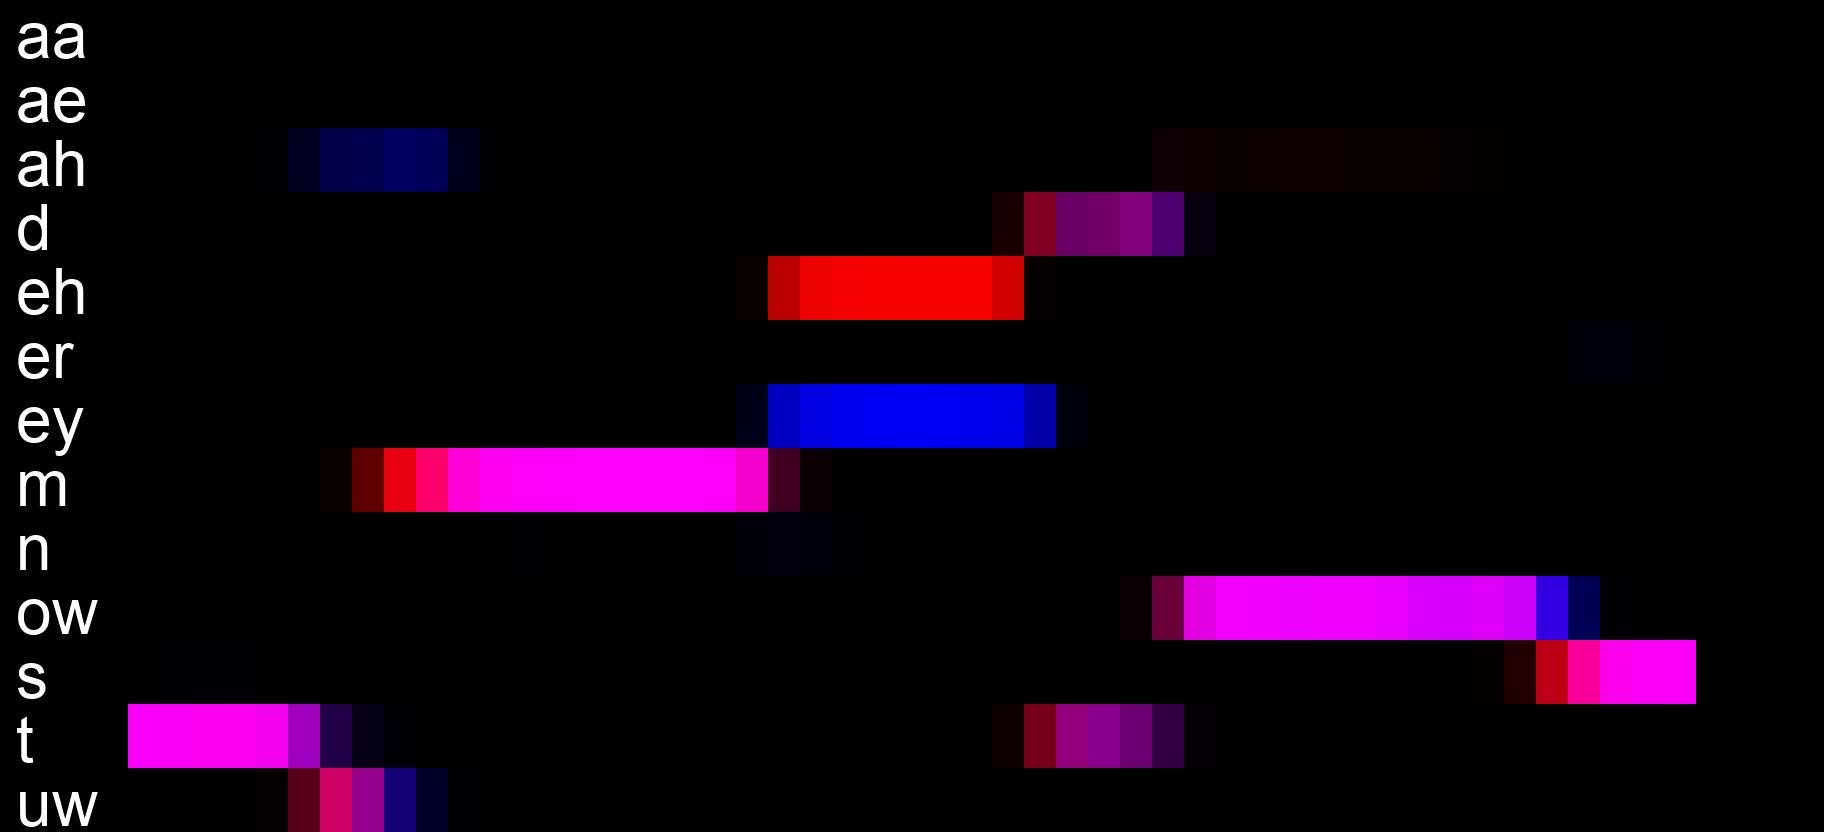

In [66]:
ppgs.evaluate.visualize.from_ppg_to_image_file(
    reconstruction_inferred_ppg[kept_row_indices,
    start_time-window_extend_radius:stop_time+window_extend_radius].T,
    audio_file,
    'fig00.jpg',
    second_ppg=ppg[kept_row_indices, start_time-window_extend_radius:stop_time+window_extend_radius].T,
    font_filename='arial.ttf',
    labels=kept_phonemes,
    scalefactor=scalefactor,
    padding=padding
)
# ppgs.evaluate.visualize.from_ppg_to_image_file(reconstruction_inferred_ppg.T, audio_file, 'fig00.jpg', second_ppg=ppg[:, :-1].T, font_filename='arial.ttf')
IPython.display.Image('fig00.jpg')

In [29]:
# inferred_ppgs = []
# # for input_file in [reconstruction_output_file, edited_output_file, interp_output_file]:
# for input_file in [edited_output_file, interp_output_file]:
#     output_file = Path(input_file).stem + '-ppg.pt'
#     command = 'python -m ppgs '
#     command += f'--sources {input_file} '
#     command += f'--sinks {output_file} '
#     command += f'--config {ppgs_config_dir / (model + ".py")} '
#     command += f'--gpu 0'

#     print(command)
#     os.system(command)
#     # inferred_ppgs.append(torch.load(output_file)[:, start_time-window_extend_radius:stop_time+window_extend_radius])
#     inferred_ppgs.append(torch.load(output_file))
#     print(inferred_ppgs[-1].shape)

# # reconstruction_inferred_ppg, edited_inferred_ppg, interp_inferred_ppg = inferred_ppgs
# _, edited_inferred_ppg, interp_inferred_ppg = inferred_ppgs

python -m ppgs --sources reconstruction/tomato_clean-reconstruction-004.wav --sinks tomato_clean-reconstruction-004-ppg.pt --config /repos/promonet/config/ppgs-experiments/ppgs/w2v2fb-ppg.py --gpu 0
preparing dataset metadata (operation may be slow)


processing w2v2fb for dataset <list of files>: 100%|██████████| 1/1 [00:02<00:00,  2.39s/it]


using transformer model
torch.Size([40, 308])
python -m ppgs --sources tomato_clean-edited.wav --sinks tomato_clean-edited-ppg.pt --config /repos/promonet/config/ppgs-experiments/ppgs/w2v2fb-ppg.py --gpu 0
preparing dataset metadata (operation may be slow)


processing w2v2fb for dataset <list of files>: 100%|██████████| 1/1 [00:02<00:00,  2.40s/it]


using transformer model
torch.Size([40, 308])
python -m ppgs --sources tomato_clean-interpolated.wav --sinks tomato_clean-interpolated-ppg.pt --config /repos/promonet/config/ppgs-experiments/ppgs/w2v2fb-ppg.py --gpu 0
preparing dataset metadata (operation may be slow)


processing w2v2fb for dataset <list of files>: 100%|██████████| 1/1 [00:02<00:00,  2.38s/it]


using transformer model
torch.Size([40, 308])


In [30]:
ppg_row_threshold = 0.1

all_ppgs = torch.cat(
    [
        ppg[:, start_time-window_extend_radius:stop_time+window_extend_radius],
        reconstruction_inferred_ppg[:, start_time-window_extend_radius:stop_time+window_extend_radius],
        interp_inferred_ppg[:, start_time-window_extend_radius:stop_time+window_extend_radius],
        edited_inferred_ppg[:, start_time-window_extend_radius:stop_time+window_extend_radius]
    ],
    dim=-1
)
kept_row_indices = (all_ppgs > ppg_row_threshold).any(dim=-1).nonzero().squeeze()
kept_phonemes = [phone for i, phone in enumerate(ppgs.PHONEME_LIST) if i in kept_row_indices]

In [31]:
scalefactor = (32, 64)
padding = 4

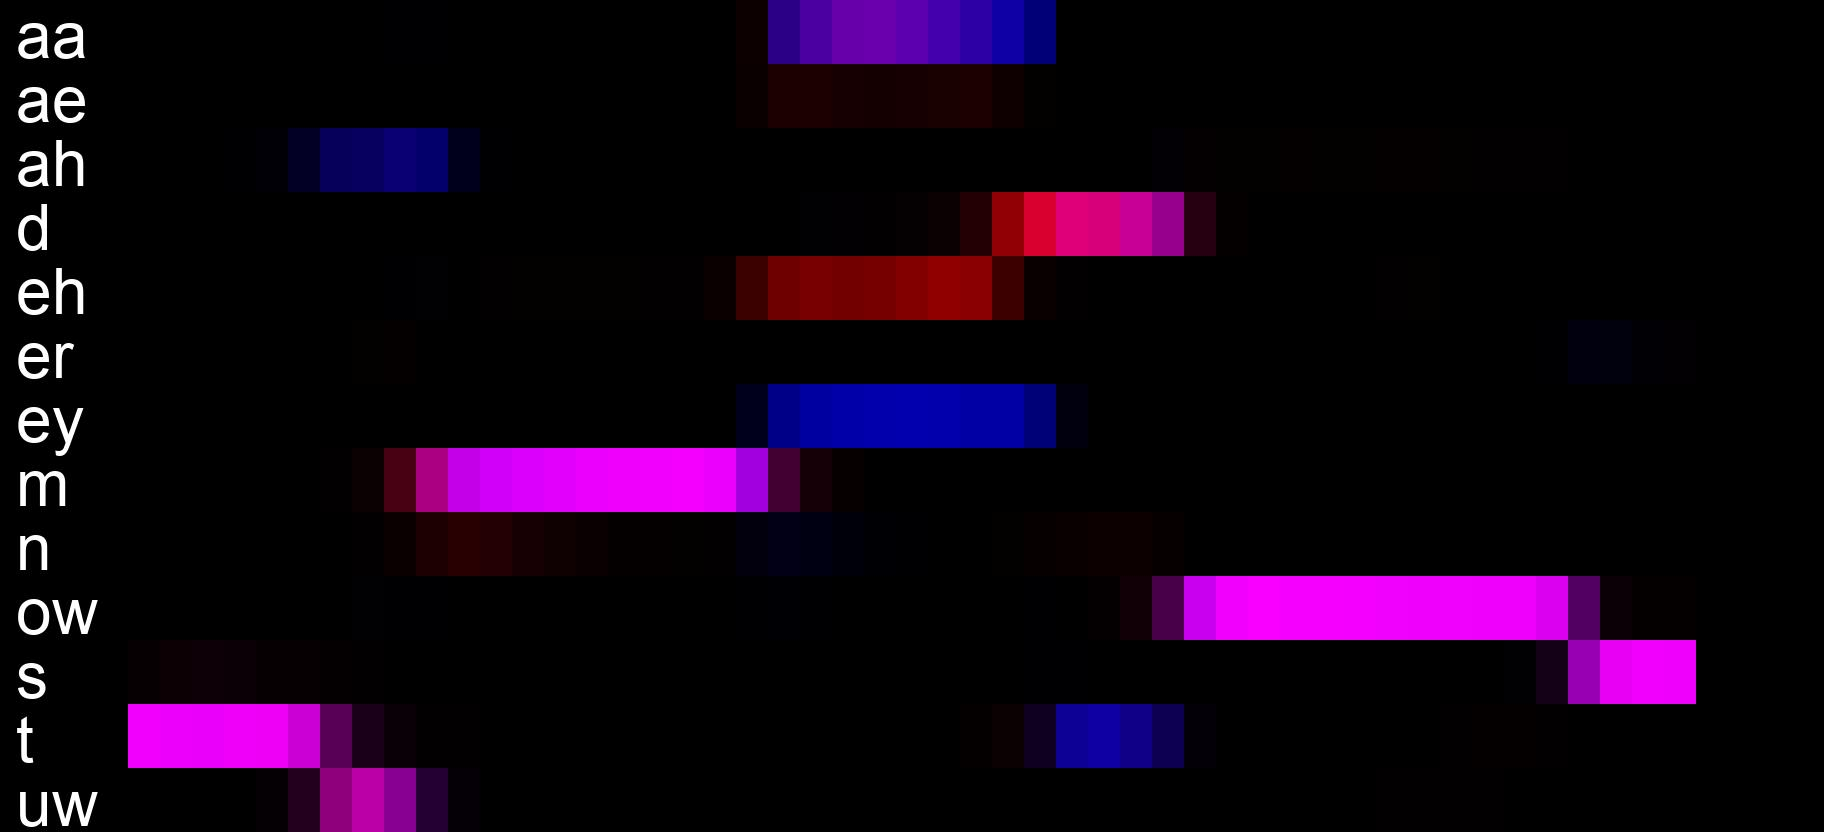

In [59]:
ppgs.evaluate.visualize.from_ppg_to_image_file(
    interp_inferred_ppg[kept_row_indices,
    start_time-window_extend_radius:stop_time+window_extend_radius].T,
    audio_file,
    'fig01.jpg',
    second_ppg=interpolated_ppg[kept_row_indices, start_time-window_extend_radius:stop_time+window_extend_radius].T,
    font_filename='arial.ttf',
    labels=kept_phonemes,
    scalefactor=scalefactor,
    padding=padding
)
# ppgs.evaluate.visualize.from_ppg_to_image_file(interp_inferred_ppg.T, audio_file, 'fig01.jpg', second_ppg=ppg[:, :-1].T, font_filename='arial.ttf')
IPython.display.Image('fig01.jpg')

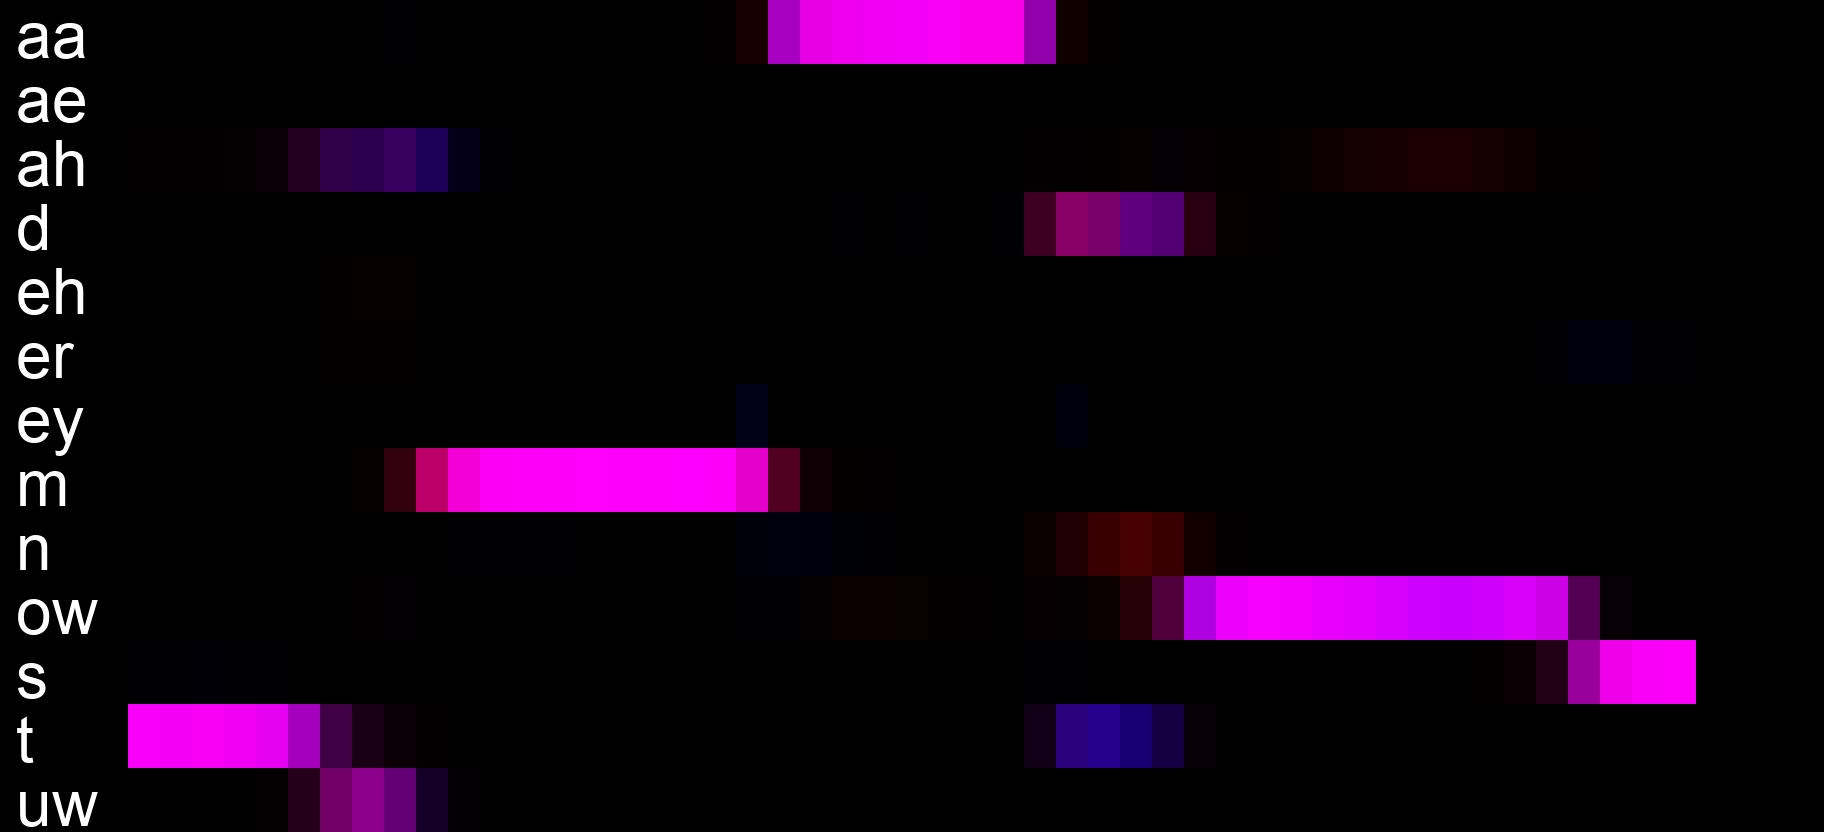

In [60]:
ppgs.evaluate.visualize.from_ppg_to_image_file(
    edited_inferred_ppg[kept_row_indices, start_time-window_extend_radius:stop_time+window_extend_radius].T,
    audio_file,
    'fig02.jpg',
    second_ppg=edited_ppg[kept_row_indices, start_time-window_extend_radius:stop_time+window_extend_radius].T,
    font_filename='arial.ttf',
    labels=kept_phonemes,
    scalefactor=scalefactor,
    padding=padding
)
IPython.display.Image('fig02.jpg')

In [171]:
w2v2fb_dist_0 = (original_w2v2fb - recon_w2v2fb).pow(2).sum(dim=0).sqrt()
w2v2fb_dist_1 = (original_w2v2fb - interp_w2v2fb).pow(2).sum(dim=0).sqrt()
w2v2fb_dist_2 = (original_w2v2fb - edit_w2v2fb).pow(2).sum(dim=0).sqrt()

peak = max(w2v2fb_dist_0.max(), w2v2fb_dist_1.max(), w2v2fb_dist_1.max())
trough = min(w2v2fb_dist_0.min(), w2v2fb_dist_1.min(), w2v2fb_dist_2.min())
w2v2fb_dist_0 = (w2v2fb_dist_0 - trough) / (peak-trough)
w2v2fb_dist_1 = (w2v2fb_dist_1 - trough) / (peak-trough)
w2v2fb_dist_2 = (w2v2fb_dist_2 - trough) / (peak-trough)

In [172]:
jsd = ppgs.evaluate.metrics.jensenShannonDivergence
ppg_dist_0 = jsd(ppg[:, start_time-window_extend_radius:stop_time+window_extend_radius], reconstruction_inferred_ppg[:, start_time-window_extend_radius:stop_time+window_extend_radius], reduction=None)
ppg_dist_1 = jsd(ppg[:, start_time-window_extend_radius:stop_time+window_extend_radius], interp_inferred_ppg[:, start_time-window_extend_radius:stop_time+window_extend_radius], reduction=None)
ppg_dist_2 = jsd(ppg[:, start_time-window_extend_radius:stop_time+window_extend_radius], edited_inferred_ppg[:, start_time-window_extend_radius:stop_time+window_extend_radius], reduction=None)

peak = max(ppg_dist_0.max(), ppg_dist_1.max(), ppg_dist_2.max())
trough = min(ppg_dist_0.min(), ppg_dist_1.min(), ppg_dist_2.min())
ppg_dist_0 = (ppg_dist_0 - trough) / (peak-trough)
ppg_dist_1 = (ppg_dist_1 - trough) / (peak-trough)
ppg_dist_2 = (ppg_dist_2 - trough) / (peak-trough)

In [173]:
def norm(ppg):
    return torch.mm(similarity_matrix.T ** 1, ppg)

ppg_dist_norm_0 = jsd(
    norm(ppg[:, start_time-window_extend_radius:stop_time+window_extend_radius]), 
    norm(reconstruction_inferred_ppg[:, start_time-window_extend_radius:stop_time+window_extend_radius]), 
    reduction=None
)

ppg_dist_norm_1 = jsd(
    norm(ppg[:, start_time-window_extend_radius:stop_time+window_extend_radius]),
    norm(interp_inferred_ppg[:, start_time-window_extend_radius:stop_time+window_extend_radius]),
    reduction=None
)

ppg_dist_norm_2 = jsd(
    norm(ppg[:, start_time-window_extend_radius:stop_time+window_extend_radius]), 
    norm(edited_inferred_ppg[:, start_time-window_extend_radius:stop_time+window_extend_radius]),
    reduction=None
)

peak = max(ppg_dist_norm_0.max(), ppg_dist_norm_1.max(), ppg_dist_norm_2.max())
trough = min(ppg_dist_norm_0.min(), ppg_dist_norm_1.min(), ppg_dist_norm_2.min())
ppg_dist_norm_0 = (ppg_dist_norm_0 - trough) / (peak-trough)
ppg_dist_norm_1 = (ppg_dist_norm_1 - trough) / (peak-trough)
ppg_dist_norm_2 = (ppg_dist_norm_2 - trough) / (peak-trough)
print(ppg_dist_norm_0)

tensor([0.0073, 0.0035, 0.0026, 0.0030, 0.0499, 0.2977, 0.3717, 0.2577, 0.2737,
        0.4026, 0.1326, 0.0223, 0.0120, 0.0048, 0.0022, 0.0014, 0.0010, 0.0049,
        0.0823, 0.3691, 0.0632, 0.0740, 0.0911, 0.1290, 0.1720, 0.1775, 0.1343,
        0.1927, 0.4024, 0.1983, 0.1939, 0.1413, 0.0837, 0.0660, 0.0419, 0.0329,
        0.0244, 0.0240, 0.0246, 0.0273, 0.0416, 0.0571, 0.0608, 0.0489, 0.0922,
        0.0501, 0.0582, 0.0502, 0.0461])


In [178]:
print(times, alignment.duration())

tensor([0.0050, 0.0150, 0.0250, 0.0350, 0.0450, 0.0550, 0.0650, 0.0750, 0.0850,
        0.0950, 0.1050, 0.1150, 0.1250, 0.1350, 0.1450, 0.1550, 0.1650, 0.1750,
        0.1850, 0.1950, 0.2050, 0.2150, 0.2250, 0.2350, 0.2450, 0.2550, 0.2650,
        0.2750, 0.2850, 0.2950, 0.3050, 0.3150, 0.3250, 0.3350, 0.3450, 0.3550,
        0.3650, 0.3750, 0.3850, 0.3950, 0.4050, 0.4150, 0.4250, 0.4350, 0.4450,
        0.4550, 0.4650, 0.4750, 0.4850, 0.4950, 0.5050, 0.5150, 0.5250, 0.5350,
        0.5450, 0.5550, 0.5650, 0.5750, 0.5850, 0.5950, 0.6050, 0.6150, 0.6250,
        0.6350, 0.6450, 0.6550, 0.6650, 0.6750, 0.6850, 0.6950, 0.7050, 0.7150,
        0.7250, 0.7350, 0.7450, 0.7550, 0.7650, 0.7750, 0.7850, 0.7950, 0.8050,
        0.8150, 0.8250, 0.8350, 0.8450, 0.8550, 0.8650, 0.8750, 0.8850, 0.8950,
        0.9050, 0.9150, 0.9250, 0.9350, 0.9450, 0.9550, 0.9650, 0.9750, 0.9850,
        0.9950, 1.0050, 1.0150, 1.0250, 1.0350, 1.0450, 1.0550, 1.0650, 1.0750,
        1.0850, 1.0950, 1.1050, 1.1150, 

In [34]:
print(audio_file)
original_audio= ppgs.load.audio(audio_file)
from ppgs.data.dataset import ppgs_phoneme_list
hopsize = ppgs.HOPSIZE / ppgs.SAMPLE_RATE
num_frames = original_audio.shape[-1] // ppgs.HOPSIZE
times = torch.linspace(hopsize/2, (num_frames-1)*hopsize+hopsize/2, num_frames)
times[-1] = alignment.duration()
with ppgs_phoneme_list():
    indices = pyfoal.convert.alignment_to_indices(
        alignment,
        hopsize=hopsize,
        return_word_breaks=False,
        times=times)
windowed_indices = indices[start_time-window_extend_radius:stop_time+window_extend_radius]
gt_phones = [ppgs.PHONEME_LIST[i] for i in windowed_indices]
gt_phone_lengths = torch.unique_consecutive(torch.tensor(windowed_indices), return_counts=True)[1]
gt_phone_lengths

tomato_clean.wav


tensor([ 7,  4, 10, 10,  4, 11,  3])

In [35]:
gt_phones

['t',
 't',
 't',
 't',
 't',
 't',
 't',
 'ah',
 'ah',
 'ah',
 'ah',
 'm',
 'm',
 'm',
 'm',
 'm',
 'm',
 'm',
 'm',
 'm',
 'm',
 'ey',
 'ey',
 'ey',
 'ey',
 'ey',
 'ey',
 'ey',
 'ey',
 'ey',
 'ey',
 't',
 't',
 't',
 't',
 'ow',
 'ow',
 'ow',
 'ow',
 'ow',
 'ow',
 'ow',
 'ow',
 'ow',
 'ow',
 'ow',
 's',
 's',
 's']

In [36]:
maximal_phones = []
count = 0
for phone_length in gt_phone_lengths:
    window_ppg = reconstruction_inferred_ppg[:, start_time-window_extend_radius:stop_time+window_extend_radius][:, count:count+phone_length]
    print(window_ppg.shape)
    maximal_index = window_ppg.sum(dim=-1).argmax(dim=0)
    maximal_phones.append(ppgs.PHONEME_LIST[maximal_index])
    count += phone_length
maximal_phones

torch.Size([40, 7])
torch.Size([40, 4])
torch.Size([40, 10])
torch.Size([40, 10])
torch.Size([40, 4])
torch.Size([40, 11])
torch.Size([40, 3])


['t', 'm', 'm', 'ey', 'ow', 'ow', 's']

[0, 50, 100, 150, 200, 250, 300]


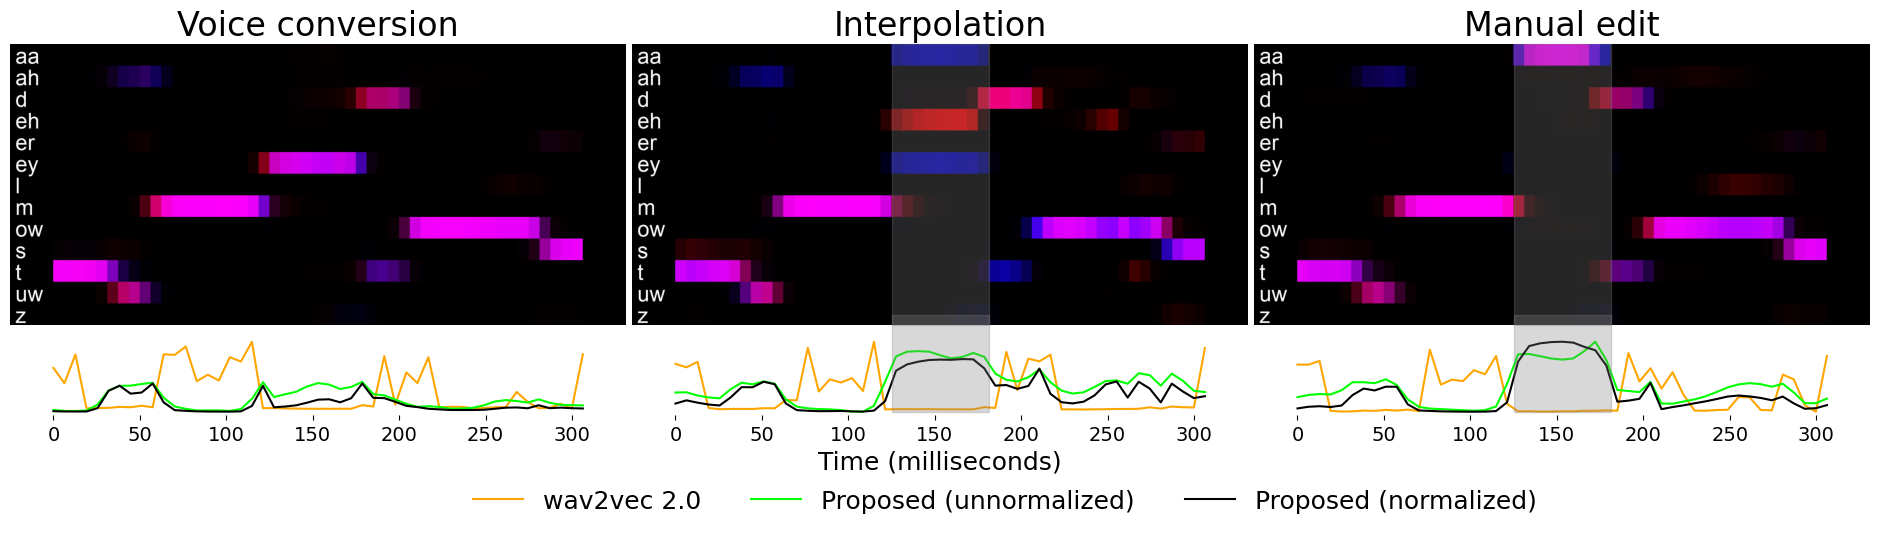

In [182]:
from matplotlib.patches import Rectangle

fig, axes = plt.subplots(2, 3, figsize=(24, 5), sharex=True, sharey='row', gridspec_kw={'height_ratios': [8, 2], 'width_ratios': [1, 1, 1]})
for i in range(0, 3):
    axes[0, i].imshow(Image.open(f'fig0{i}.jpg'))

vis_pad = padding
count = len(w2v2fb_dist_0.cpu())
x_start = scalefactor[0]*vis_pad 
x_stop = scalefactor[0]*(count+vis_pad)
x_points = np.linspace(x_start, x_stop, count)

axes[1, 0].plot(x_points, w2v2fb_dist_0.cpu().detach(), color='orange')
axes[1, 1].plot(x_points, w2v2fb_dist_1.cpu().detach(), color='orange')
w2v2fb_line = axes[1, 2].plot(x_points, w2v2fb_dist_2.cpu().detach(), color='orange')[0]

axes[1, 0].plot(x_points, ppg_dist_0.cpu().detach(), color='lime')
axes[1, 1].plot(x_points, ppg_dist_1.cpu().detach(), color='lime')
ppgs_line = axes[1, 2].plot(x_points, ppg_dist_2.cpu().detach(), color='lime')[0]

axes[1, 0].plot(x_points, ppg_dist_norm_0.cpu().detach(), color='black')
axes[1, 1].plot(x_points, ppg_dist_norm_1.cpu().detach(), color='black')
ppgs_norm_line = axes[1, 2].plot(x_points, ppg_dist_norm_2.cpu().detach(), color='black')[0]

titles = ['Voice conversion', 'Interpolation', 'Manual edit']

x_tick_points = np.round(np.arange(x_start, x_stop, scalefactor[0]*4/5)).astype(int)
window_duration = count / ppgs.HOPSIZE
x_tick_points = x_tick_points[0::10]
x_tick_labels = [int((((point-x_start)/scalefactor[0])/ppgs.HOPSIZE)*1000) for point in x_tick_points]
print(x_tick_labels)

for j in range(0, 3):
    axes[1, j].set_xticks(x_tick_points, x_tick_labels, fontsize=14)

for j in range(0, 3):
    axes[0, j].set_title(titles[j], fontsize=24)
    for i in range(0, 2):
        axes[i, j].axis('off')

for i in range(1, 3):
    axes[1, i].set_clip_on(False)
    axes[1, i].add_patch(Rectangle(
        (
            (window_extend_radius)*scalefactor[0] + x_start, 
            0
        ),
        (stop_time-start_time)*scalefactor[0],
        1.38,
        zorder=100,
        clip_on=False,
        alpha=0.3,
        color='grey'
    ))
    axes[0, i].add_patch(Rectangle(
        (
            (window_extend_radius)*scalefactor[0] + x_start, 
            0
        ),
        (stop_time-start_time)*scalefactor[0],
        scalefactor[1]*len(kept_row_indices),
        zorder=100,
        clip_on=False,
        alpha=0.3,
        color='grey'
    ))


middle_bottom = axes[1, 1]
middle_bottom.set_xlabel('Time (milliseconds)', fontsize=18)
for i in range(0, 3):
    ax = axes[1, i]
    ax.axis('on')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.get_yaxis().set_ticks([])


# fig.tight_layout()
# plt.subplots_adjust(hspace=-0.55)
plt.subplots_adjust(wspace=0.01, hspace=0)

lines = [w2v2fb_line, ppgs_line, ppgs_norm_line]
# lines = [w2v2fb_line, ppgs_line]
axes[1, 1].legend(
    lines,
    ['wav2vec 2.0', 'Proposed (unnormalized)', 'Proposed (normalized)'],
    # ['wav2vec 2.0', 'Proposed (unnormalized)'],
    loc=(-0.275, -1.4),
    frameon=False,
    ncol=len(lines),
    fontsize=18
)
plt.savefig('interp.pdf', bbox_inches='tight')
